# **Pseudocode for Breast Cancer Classification Using ResNet and Custom CNN**

---

## **Step 1: Data Preprocessing**
1. **Load Dataset**:
   - Load the dataset of histopathological breast cancer images.
   - Split the dataset into training, validation, and testing sets.
2. **Image Preprocessing**:
   - Resize all images to a uniform size (e.g., 64x64 pixels).
   - Normalize pixel values to a range of [-1, 1] for compatibility with GAN and neural networks.
3. **SVD Compression**:
   - Apply SVD to each image:
     - Decompose each image into $$( U, \sum, V^T )$$.
     - Retain top \( k \) singular values and reconstruct the compressed image.
   - Save the compressed images for training, validation, and testing.

---

## **Step 2: Define Pre-Trained CNN Model (ResNet)**
1. Import a pre-trained ResNet model (e.g., ResNet50) with ImageNet weights.
2. Modify the final layers for binary classification (IDC positive/negative):
   - Replace the top dense layer with a fully connected layer with 2 output neurons (softmax activation).
3. Set up the optimizer, loss function (binary cross-entropy), and evaluation metrics (accuracy, precision, recall, F1-score, AUC).

---

## **Step 3: Define Custom CNN Model**
1. Design a custom lightweight CNN model:
   - Add convolutional layers with varying filter sizes (e.g., 3x3, 5x5) for feature extraction.
   - Include batch normalization and activation layers (ReLU).
   - Add max-pooling layers for dimensionality reduction.
   - Use dropout layers to prevent overfitting.
   - Add fully connected layers for classification with 2 output neurons (softmax activation).
2. Compile the model with a suitable optimizer, loss function, and evaluation metrics.

## **Step 4: Hybrid CNN Model Design**
- **Input 1:** Original Images (64x64x3).
- **Input 2:** SVD-Compressed Images (64x64x3).

1. Build two parallel CNN branches:
   - Use the same architecture as the Custom CNN model.

2. Merge Outputs:
   - Use the `Concatenate` layer.

3. Fully Connected Layers:
   - Dense layers for classification.
   - Output layer with 2 output neurons (softmax).

---

## **Step 5: Train GAN for Data Augmentation**
1. **Define GAN Architecture**:
   - Create a generator model:
     - Input: Random noise vector.
     - Output: Synthetic histopathological image (same size as real images).
   - Create a discriminator model:
     - Input: Image (real or generated).
     - Output: Binary classification (real/fake).
2. **Train GAN**:
   - Use alternating training for the generator and discriminator.
   - Train until the generator produces realistic synthetic images that can fool the discriminator.

---

## **Step 6: Data Augmentation**
1. Use the trained GAN to generate additional synthetic images for IDC positive/negative classes.
2. Combine real images and GAN-generated synthetic images to create an augmented dataset.

---

## **Step 6: Train Models**
1. **Train ResNet** on the SVD-compressed and augmented dataset:
   - Use transfer learning by fine-tuning the ResNet model on the new dataset.
2. **Train the Custom CNN** on the same SVD-compressed and augmented dataset.
3. **Train the Hybrid CNN** on the same SVD-compressed and augmented dataset.
4. Use callbacks such as `EarlyStopping` and `ReduceLROnPlateau` to optimize training.

---

## **Step 7: Evaluate the Models**
1. Test both models on the separate testing dataset (real images, not augmented).
2. Calculate performance metrics:
   - Accuracy
   - Precision
   - Recall
   - F1-score
   - AUC
   - Computational efficiency (training time, memory usage).
3. Compare the results of ResNet and the custom CNN in terms of:
   - Classification performance.
   - Computational cost (speed and memory).

---

## **Additional Notes**

- **GAN Tuning**:
  - Regularly evaluate the quality of synthetic images during GAN training to ensure they are realistic and diverse.
- **Report Results**:
  - Create tables and graphs comparing ResNet and custom CNN performance on different datasets (original vs. compressed).

---


In [3]:
import numpy as np
import random
import math
import cv2
import time
import zipfile
from PIL import Image
import os
from io import BytesIO
from glob import glob
import gc
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import fnmatch
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

import tensorflow as tf
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Add, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU, Concatenate, Dense, Reshape, Conv2DTranspose, Conv2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, auc, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve

2024-12-16 13:36:28.704058: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 13:36:30.444935: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 13:36:30.775364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734374191.252603 3759832 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734374191.437302 3759832 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 13:36:32.888795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
gc.collect()

0

### Exploring data

In [4]:
extracted_folder = os.path.join(os.getcwd(), "Images")

In [5]:
def plot_images(images, labels, num_images=25, title_map={0: "IDC Negative", 1: "IDC Positive"}):
    """
    Plots a specified number of images with their labels.

    Args:
        images (ndarray): Array of images to display.
        labels (ndarray): Array of labels corresponding to the images.
        num_images (int): Number of images to display (default: 25).
        title_map (dict): Mapping of label values to display titles.
    """
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i in range(min(num_images, len(images))):
        plt.subplot(5, 5, i + 1)  # Arrange in a 5x5 grid
        plt.imshow(images[i].astype(np.uint8))
        plt.axis('off')
        plt.title(title_map.get(labels[i], str(labels[i])), fontsize=8)

    plt.show()

In [6]:
def display_random_images(images, labels, num_images=4, title_map={0: "IDC Negative", 1: "IDC Positive"}):
    """
    Displays a random selection of images with their labels.

    Args:
        images (ndarray): Array of images to display.
        labels (ndarray): Array of labels corresponding to the images.
        num_images (int): Number of random images to display (default: 4).
        title_map (dict): Mapping of label values to display titles.
    """
    indices = np.random.choice(len(images), size=min(num_images, len(images)), replace=False)
    plt.figure(figsize=(16, 16))

    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)  # Arrange in a single row
        plt.imshow(images[idx].astype(np.uint8))
        plt.axis('off')
        plt.title(title_map.get(labels[idx], str(labels[idx])), fontsize=12)

    plt.show()

In [7]:
def display_svd_images(compressed_images, labels, k, num_images=25, title_map={0: "IDC Negative", 1: "IDC Positive"}):
    """
    Displays a grid of compressed SVD images with labels.

    Args:
        compressed_images (ndarray): Array of compressed images.
        labels (ndarray): Corresponding labels.
        k (int): Number of singular values retained.
        num_images (int): Number of images to display.
        title_map (dict): Mapping of label values to titles.
    """
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i in range(min(num_images, len(compressed_images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(compressed_images[i].astype(np.uint8))
        plt.axis('off')
        plt.title(f"{title_map.get(labels[i], str(labels[i]))} (k={k})", fontsize=8)

    plt.show()

## Preprocessing Data

In [8]:
# Function to process a single image from extracted folder
def process_image_extracted(args):
    img_path, target_size = args
    label = 0 if 'class0' in img_path else 1 if 'class1' in img_path else -1
    if label == -1:
        return None
    
    try:
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, target_size)
        image = image.astype(np.float32)
        return image, label
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [9]:
# Use multiprocessing to process the images
def process_images_from_folder(folder_path, target_size=(64, 64)):
    print(f"Loading image paths from {folder_path}...")
    image_patches = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.png') and ('class0' in file or 'class1' in file):
                image_patches.append(os.path.join(root, file))

    print(f"Found {len(image_patches)} valid PNG files. Starting processing...")

    # Use tqdm for progress display
    with Pool(processes=os.cpu_count()) as pool:
        args = [(img_path, target_size) for img_path in image_patches]
        results = list(tqdm(pool.imap(process_image_extracted, args), total=len(image_patches), desc="Processing Images", unit="images"))

    # Filter out None results
    results = [result for result in results if result is not None]
    print(f"Successfully processed {len(results)} images.")
    return results

In [10]:
def describe_data(images, labels):
    """
    Prints statistics about the dataset.

    Args:
        images (ndarray): Array of processed images.
        labels (ndarray): Array of labels corresponding to the images.
    """
    num_total = len(labels)
    num_positive = np.sum(labels == 1)
    num_negative = np.sum(labels == 0)

    print('--- Dataset Description ---')
    print(f'Total number of images: {num_total}')
    print(f'Number of IDC(-) images (class 0): {num_negative}')
    print(f'Number of IDC(+) images (class 1): {num_positive}')
    print(f'Percent of positive images (IDC+): {(num_positive / num_total) * 100:.2f}%')
    print(f'Image shape (Width, Height, Channels): {images[0].shape}' if num_total > 0 else "No images found")


In [11]:
def svd_compress(images, k):
    """
    Applies SVD compression to images with explained variance calculation.

    Args:
        images (numpy.ndarray): Either a single image or a batch of images.
        k (int): Number of singular values to retain.

    Returns:
        compressed_images (numpy.ndarray): Compressed and reconstructed images.
        explained_variance_ratios (float or list): Explained variance ratio(s).
    """
    # Check if input is a batch or a single image
    is_batch = len(images.shape) == 4  # Batch: (num_images, height, width, channels)
    if not is_batch:
        images = np.expand_dims(images, axis=0)

    compressed_images = []
    explained_variance_ratios = []

    # Loop through each image in the dataset
    for image in images:
        compressed_channels = []
        explained_variance = 0

        # Process each channel (R, G, B) individually
        for channel in range(image.shape[-1]):
            # Apply SVD on the current channel
            U, S, VT = np.linalg.svd(image[:, :, channel], full_matrices=False)

            # Retain only the top k singular values and corresponding matrices
            U_k = U[:, :k]        # Top k left singular vectors
            S_k = np.diag(S[:k])  # Top k singular values as a diagonal matrix
            VT_k = VT[:k, :]      # Top k right singular vectors

            # Reconstruct the compressed channel using the reduced matrices
            compressed_channel = np.dot(U_k, np.dot(S_k, VT_k))

            # Compute explained variance
            explained_variance += np.sum(S[:k]) / np.sum(S)

            # Append compressed channel
            compressed_channels.append(compressed_channel)

        # Average explained variance over 3 channels (R, G, B)
        explained_variance /= image.shape[-1]
        explained_variance_ratios.append(explained_variance)

        # Stack compressed channels back into an image
        compressed_image = np.stack(compressed_channels, axis=-1)
        compressed_images.append(compressed_image)

    compressed_images = np.array(compressed_images)

    # Return single image if input was not a batch
    if not is_batch:
        return compressed_images[0], explained_variance_ratios[0]

    return compressed_images, explained_variance_ratios

In [12]:
def save_compressed_data(compressed_data, labels, explained_variance_ratios, filename):
    try:
        with open(filename, 'wb') as file:
            pickle.dump((compressed_data, labels, explained_variance_ratios), file)
        print(f"Compressed dataset saved to {filename}")
    except Exception as e:
        print(f"Error saving file {filename}: {e}")

def load_compressed_data(filename):
    try:
        with open(filename, 'rb') as file:
            compressed_data, labels, explained_variance_ratios = pickle.load(file)
        print(f"Compressed dataset loaded from {filename}")
        return compressed_data, labels, explained_variance_ratios
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return None, None

In [13]:
def svd_compression_pipeline(images, labels, k_values, save_best=True):
    """
    Applies SVD compression, evaluates performance, and saves the best dataset.

    Args:
        images (numpy.ndarray): Original dataset of images.
        labels (numpy.ndarray): Corresponding labels for images.
        k_values (list): List of k-values to evaluate.
        save_best (bool): Whether to save the best compressed dataset.
    """
    best_k = None
    best_explained_variance = -1
    best_compressed_images = None
    best_variance_ratios = None

    metrics_dict = {"k": [], "Explained Variance": [], "Reconstruction Error": [], "RMSE": []}

    for k in k_values:
        print(f"\nApplying SVD compression with k={k}...")

        # Perform SVD compression
        compressed_images, variance_ratios = svd_compress(images, k)
        avg_explained_variance = np.mean(variance_ratios)

        # Evaluate Compression Metrics
        total_reconstruction_error = mean_squared_error(images.flatten(), compressed_images.flatten())
        total_rmse = np.sqrt(total_reconstruction_error)

        print(f"Average Explained Variance for k={k}: {avg_explained_variance:.4f}")
        print(f"Reconstruction Error for k={k}: {total_reconstruction_error:.4f}")
        print(f"RMSE for k={k}: {total_rmse:.4f}")

        # Update Metrics Dictionary
        metrics_dict["k"].append(k)
        metrics_dict["Explained Variance"].append(avg_explained_variance)
        metrics_dict["Reconstruction Error"].append(total_reconstruction_error)
        metrics_dict["RMSE"].append(total_rmse)

        # Track the Best Compression
        if avg_explained_variance > best_explained_variance:
            best_k = k
            best_explained_variance = avg_explained_variance
            best_compressed_images = compressed_images
            best_variance_ratios = variance_ratios

        gc.collect()

    # Save the best compressed dataset
    if save_best and best_compressed_images is not None:
        save_filename = f"best_svd_compressed_k{best_k}.pkl"
        save_compressed_data(
                best_compressed_images, Y, variance_ratios, f"best_svd_compressed_k{best_k}.pkl"
            )
        print(f"Best compressed dataset with k={best_k} saved successfully.")
    else:
        print("Error: No valid compressed dataset found.")

    # Plot Evaluation Results
    plt.figure(figsize=(12, 6))

    # Explained Variance
    plt.subplot(1, 3, 1)
    plt.plot(metrics_dict["k"], metrics_dict["Explained Variance"], marker='o', color='b')
    plt.title("Explained Variance vs k")
    plt.xlabel("k")
    plt.ylabel("Explained Variance")

    # Reconstruction Error
    plt.subplot(1, 3, 2)
    plt.plot(metrics_dict["k"], metrics_dict["Reconstruction Error"], marker='o', color='r')
    plt.title("Reconstruction Error vs k")
    plt.xlabel("k")
    plt.ylabel("Reconstruction Error (MSE)")

    # RMSE
    plt.subplot(1, 3, 3)
    plt.plot(metrics_dict["k"], metrics_dict["RMSE"], marker='o', color='g')
    plt.title("RMSE vs k")
    plt.xlabel("k")
    plt.ylabel("Root Mean Squared Error")

    plt.tight_layout()
    plt.show()

    return metrics_dict

Loading image paths from /geode2/home/u080/sbidanta/Quartz/Projects/IIS/Images...
Found 32173 valid PNG files. Starting processing...


Processing Images: 100%|██████████| 32173/32173 [00:11<00:00, 2742.64images/s]


Successfully processed 32173 images.
--- Dataset Description ---
Total number of images: 32173
Number of IDC(-) images (class 0): 24741
Number of IDC(+) images (class 1): 7432
Percent of positive images (IDC+): 23.10%
Image shape (Width, Height, Channels): (64, 64, 3)
Displaying the first 25 images:


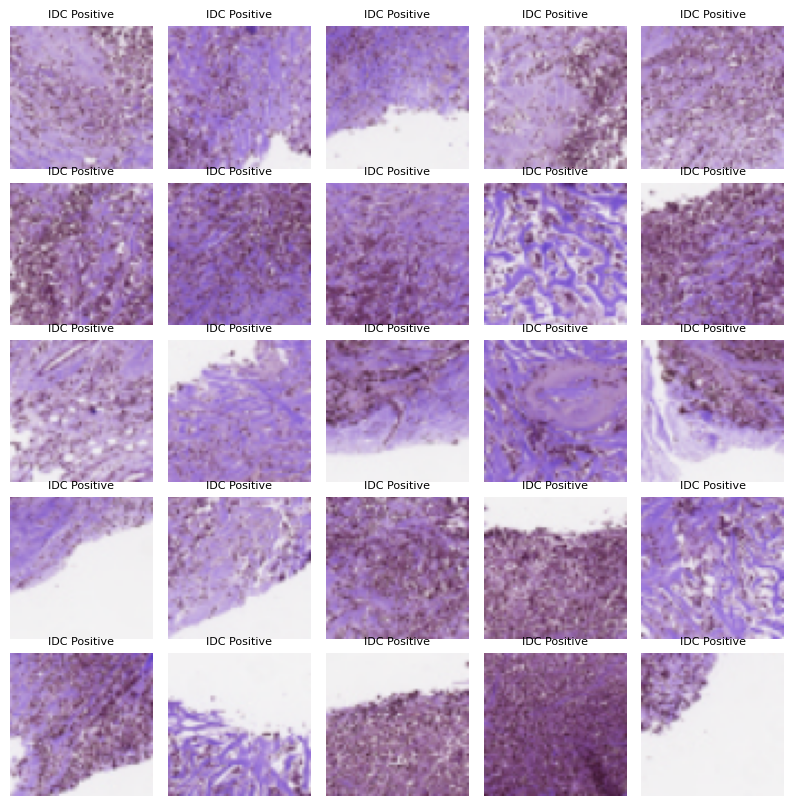

Displaying 4 randomly selected images:


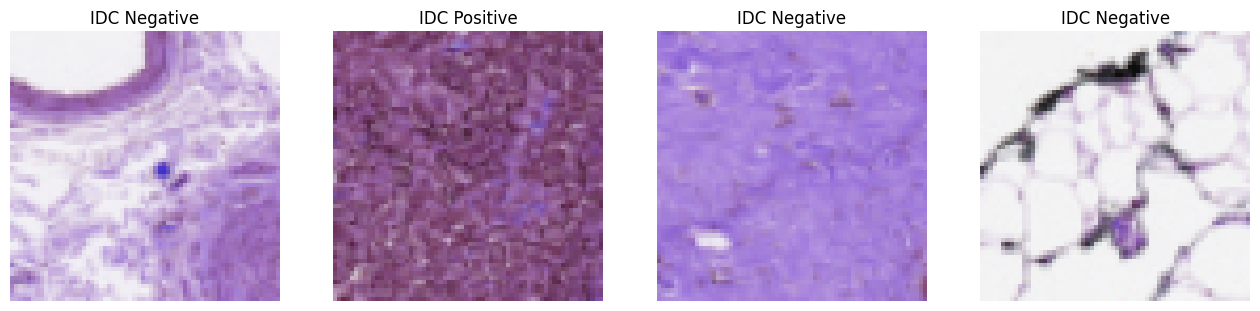

In [14]:
if os.path.exists(extracted_folder):
    # Process images from the extracted folder
    processed_data = process_images_from_folder(extracted_folder)

    # Separate images and labels
    X = np.array([data[0] for data in processed_data])
    Y = np.array([data[1] for data in processed_data])

    # Describe the full dataset
    describe_data(X, Y)

    # Display example images
    print("Displaying the first 25 images:")
    plot_images(X, Y, num_images=25)

    print("Displaying 4 randomly selected images:")
    display_random_images(X, Y, num_images=4)

    # Apply SVD on the first half only
    #k_values = [5, 10, 20, 50]
    #print("\n--- Applying SVD Compression on the Images ---")
    #metrics = svd_compression_pipeline(X, Y, k_values)

else:
    print(f"Error: Folder not found at {extracted_folder}")

### Pre-Trained CNN Model (ResNet50)

In [14]:
# Define ResNet50 Model
def build_resnet50(input_shape=(64, 64, 3), num_classes=1, fine_tune_at=100):
    
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True

    # Freeze layers up to the fine-tune layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True,
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )

    return model

# Build and Compile ResNet50 Model
resnet_model = build_resnet50(input_shape=(64, 64, 3), num_classes=1, fine_tune_at=100)

# Display Model Summary
resnet_model.summary()

2024-12-16 01:46:38.406348: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 19,977,729 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [15]:
gc.collect()

9544

### Custom CNN Model

In [16]:
def build_custom_cnn(input_shape=(64, 64, 3), num_classes=1, dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # Convolutional Block 1
    x = Conv2D(32, (3, 3), padding='same', activation=None)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Convolutional Block 2
    x = Conv2D(64, (3, 3), padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Convolutional Block 3
    x = Conv2D(128, (3, 3), padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Convolutional Block 4
    x = Conv2D(256, (3, 3), padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Fully Connected Layers
    x = GlobalAveragePooling2D()(x)  
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    # Define and compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )

    return model

# Build and Compile the Custom CNN Model
custom_cnn_model = build_custom_cnn(input_shape=(64, 64, 3), num_classes=1)
custom_cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
gc.collect()

13

### Hybrid CNN Model

In [40]:
def build_hybrid_cnn(input_shape=(64, 64, 3), num_classes=1, dropout_rate=0.3):
    def cnn_branch(inputs):
        x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.MaxPooling2D((2, 2))(x)

        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.MaxPooling2D((2, 2))(x)

        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        return x

    input_original = layers.Input(shape=input_shape, name="Original_Input")
    input_svd = layers.Input(shape=input_shape, name="SVD_Input")

    branch_original = cnn_branch(input_original)
    branch_svd = cnn_branch(input_svd)

    merged = layers.Concatenate()([branch_original, branch_svd])
    x = layers.Flatten()(merged)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=[input_original, input_svd], outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model



# Build and Compile Custom CNN Model
hybrid_cnn_model = build_hybrid_cnn(input_shape=(64, 64, 3), num_classes=1)

# Display the Model Summary
hybrid_cnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Original_Input      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SVD_Input           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │        896 │ Original_Input[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │        896 │ SVD_Input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ leaky_re_lu_2[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ leaky_re_lu_5[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ leaky_re_lu_3[0]

 Total params: 4,383,105 (16.72 MB)

 Trainable params: 4,382,209 (16.72 MB)

 Non-trainable params: 896 (3.50 KB)

In [19]:
gc.collect()

14

### Create DCGAN Model

In [21]:
def make_generator_model():
    model = tf.keras.Sequential([
        # Fully connected layer
        tf.keras.layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        # Reshape to (8, 8, 256)
        tf.keras.layers.Reshape((8, 8, 256)),

        # Upsample to (16, 16, 128)
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        # Upsample to (32, 32, 64)
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        # Final Upsample to (64, 64, 3)
        tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model


def make_discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [22]:
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [23]:
def generate_and_save_images(model, epoch, test_input, output_dir="Generated_images", grid_size=(4, 4)):
    """
    Generates and saves images using the generator model.

    Args:
        model: The generator model.
        epoch: Current epoch number.
        test_input: Latent vectors (noise) for generating images.
        output_dir: Directory to save the generated images (default: "Generated_images").
        grid_size: Tuple specifying the grid size for the images (default: (4, 4)).
    """
    predictions = model(test_input, training=False)

    # Create the figure for plotting
    fig = plt.figure(figsize=(8, 8))

    num_images = min(predictions.shape[0], grid_size[0] * grid_size[1])

    for i in range(num_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        
        # Convert EagerTensor to NumPy array and rescale to [0, 255]
        img = (predictions[i].numpy() + 1) * 127.5
        plt.imshow(img.astype('uint8'))
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=16)

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the generated images
    file_path = os.path.join(output_dir, f'images_at_epoch_{epoch:04d}.png')
    plt.savefig(file_path)
    plt.close(fig)  # Close the figure to free memory

    print(f"Generated images saved at: {file_path}")

In [24]:
gc.collect()

2836

In [25]:
# GAN Training Parameters
EPOCHS = 400
NOISE_DIM = 128
NUM_EXAMPLES_TO_GENERATE = 16
BATCH_SIZE = 256
STEPS_PER_EPOCH = 100

# Seed for Consistent Image Generation
fixed_noise = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer, latent_dim):
    # Ensure correct Tensor format
    if not isinstance(images, tf.Tensor):
        images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Type checking for latent_dim
    if not isinstance(latent_dim, int):
        raise TypeError(f"Expected integer for latent_dim, but got {type(latent_dim)}.")

    # Generate random noise
    noise = tf.random.normal([BATCH_SIZE, latent_dim], dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute losses
        gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(fake_output), fake_output)
        disc_loss = (
            tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(real_output), real_output)
            + tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.zeros_like(fake_output), fake_output)
        )

    # Apply Gradients
    gen_grads = tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    tf.print("Batch processed with Gen Loss:", gen_loss, "Disc Loss:", disc_loss)
    return gen_loss, disc_loss



def train(dataset, epochs, latent_dim, generator, discriminator, generator_optimizer, discriminator_optimizer):
    for epoch in range(epochs):
        print(f"\n--- Starting Epoch {epoch + 1}/{epochs} ---")
        start_time = time.time()

        gen_losses, disc_losses = [], []

        for batch_count, (image_batch, _) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
            
            gen_loss, disc_loss = train_step(
                image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer, latent_dim
                )
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

            if batch_count % 10 == 0:
                
                print(f"Batch {batch_count} - Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")


        avg_gen_loss = tf.reduce_mean(gen_losses)
        avg_disc_loss = tf.reduce_mean(disc_losses)

        print(f"Epoch {epoch + 1} completed in {time.time() - start_time:.2f}s")
        print(f"Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")
        generate_and_save_images(generator, epoch + 1, fixed_noise)


# Initialize the Models and Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.5, beta_2=0.999, epsilon=1e-7
)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.5, beta_2=0.999, epsilon=1e-7
)

generator.summary()
discriminator.summary()

2024-12-16 13:39:59.215431: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │         4,803 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,192,259 (12.18 MB)

 Trainable params: 3,159,107 (12.05 MB)

 Non-trainable params: 33,152 (129.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
gc.collect()

26

In [15]:
svd_images, labels_svd, _ = load_compressed_data('best_svd_compressed_k50.pkl')

Compressed dataset loaded from best_svd_compressed_k50.pkl


In [16]:
original_images = X
labels = Y

In [17]:
gc.collect()

68244

In [18]:
def prepare_dataset(dataset_type, generator=None, noise_dim=100):
    # Define the ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    if dataset_type == "Original":
        X, Y = original_images, labels
        X = X.astype('float32') / 255.0
        
    elif dataset_type == "SVD":
        X, Y = svd_images, labels_svd
        X = X.astype('float32') / 255.0

    elif dataset_type == "Original + Augmented":
        X_augmented, Y_augmented = generate_gan_images_auto(generator, original_images, labels, noise_dim)
        X, Y = np.concatenate([original_images, X_augmented]), np.concatenate([labels, Y_augmented])
        X = X.astype('float32') / 255.0

    elif dataset_type == "Hybrid CNN":
        X_original, Y_original = original_images, labels
        X_svd, Y_svd = svd_images, labels_svd

        # Normalize images
        X_original = X_original.astype('float32') / 255.0
        X_svd = X_svd.astype('float32') / 255.0

        # Train-test split
        X_train_original, X_test_original, Y_train, Y_test = train_test_split(
            X_original, Y_original, test_size=0.2, random_state=42
        )
        X_train_svd, X_test_svd, _, _ = train_test_split(
            X_svd, Y_svd, test_size=0.2, random_state=42
        )

        # Create TensorFlow datasets
        train_original = tf.data.Dataset.from_tensor_slices((X_train_original, Y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        train_svd = tf.data.Dataset.from_tensor_slices((X_train_svd, Y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        test_original = tf.data.Dataset.from_tensor_slices((X_test_original, Y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        test_svd = tf.data.Dataset.from_tensor_slices((X_test_svd, Y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        return ((train_original, train_svd), (test_original, test_svd), (X_test_original, X_test_svd), Y_test)

    else:
        raise ValueError("Invalid dataset_type. Choose from ['Original', 'SVD', 'Original + Augmented', 'Hybrid CNN']")

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Augment only the training dataset
    train_dataset = tf.data.Dataset.from_generator(
        lambda: datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
        output_signature=(
            tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    ).prefetch(tf.data.AUTOTUNE)

    # Test dataset without augmentation
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset, X_test, Y_test


In [27]:
def generate_gan_images_auto(generator, X, Y, noise_dim, output_dir=None, show=False, file_format='png'):
    """
    Automatically generates synthetic images for class balancing.

    Args:
        generator: Trained GAN generator model.
        X (numpy.ndarray): Original dataset.
        Y (numpy.ndarray): Corresponding labels.
        noise_dim (int): Dimensionality of the latent space.
        output_dir (str): Directory to save generated images (optional).
        show (bool): Whether to display generated images.
        file_format (str): File format for saved images (default: 'png').

    Returns:
        X_augmented (numpy.ndarray): Augmented image dataset.
        Y_augmented (numpy.ndarray): Corresponding labels.
    """
    # Count class occurrences
    unique_classes, class_counts = np.unique(Y, return_counts=True)
    max_class_count = np.max(class_counts)

    print("Class Counts Before Augmentation:", dict(zip(unique_classes, class_counts)))
    print(f"Target Class Size: {max_class_count} (Max Count)")

    X_augmented, Y_augmented = X.copy(), Y.copy()

    for cls, count in zip(unique_classes, class_counts):
        if count < max_class_count:
            # Calculate number of images to generate
            num_images_to_generate = max_class_count - count
            print(f"Generating {num_images_to_generate} synthetic images for class {cls}...")

            # Generate synthetic images
            noise = tf.random.normal([num_images_to_generate, noise_dim])
            synthetic_images = generator(noise, training=False)
            synthetic_images = (synthetic_images + 1.0) / 2.0
            synthetic_images = synthetic_images.numpy().astype('uint8')

            # Update augmented dataset
            X_augmented = np.concatenate([X_augmented, synthetic_images])
            Y_augmented = np.concatenate([Y_augmented, np.full(len(synthetic_images), cls)])

            # Optionally save images
            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
                for i, img in enumerate(synthetic_images):
                    filename = os.path.join(output_dir, f"class_{cls}_image_{i + 1:05d}.{file_format}")
                    plt.imsave(filename, img)

            # Optionally display generated images
            if show:
                cols = 10
                rows = num_images_to_generate // cols + (num_images_to_generate % cols != 0)
                plt.figure(figsize=(cols, rows))
                for i in range(num_images_to_generate):
                    plt.subplot(rows, cols, i + 1)
                    plt.imshow(synthetic_images[i])
                    plt.axis('off')
                plt.show()

    print("Augmentation Completed.")
    print("Class Counts After Augmentation:", dict(zip(*np.unique(Y_augmented, return_counts=True))))

    return X_augmented, Y_augmented

In [31]:
def evaluate_discriminator(discriminator, test_dataset):
    true_labels = []
    predicted_labels = []

    for test_images, test_labels in test_dataset:
        predictions = discriminator(test_images, training=False)
        
        # Convert TensorFlow tensors to NumPy arrays
        predicted = tf.round(predictions).numpy()
        true_labels.extend(test_labels.numpy())
        predicted_labels.extend(predicted)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)

    return accuracy, precision, recall, f1

In [32]:
gc.collect()

0

In [33]:
train_dataset, test_dataset, X_test, Y_test = prepare_dataset("Original")

# Train the GAN
print("Starting DCGAN training...")
train(train_dataset, EPOCHS, NOISE_DIM, generator, discriminator, generator_optimizer, discriminator_optimizer)
print("DCGAN training completed.")


Starting DCGAN training...

--- Starting Epoch 1/400 ---
Batch processed with Gen Loss: 0.744835675 Disc Loss: 1.34243774
Batch 0 - Gen Loss: 0.7448, Disc Loss: 1.3424
Batch processed with Gen Loss: 0.722035885 Disc Loss: 1.23594069
Batch processed with Gen Loss: 0.698507249 Disc Loss: 1.16299582
Batch processed with Gen Loss: 0.698298454 Disc Loss: 1.08492434
Batch processed with Gen Loss: 0.72476387 Disc Loss: 0.994862497
Batch processed with Gen Loss: 0.75335151 Disc Loss: 0.91275835
Batch processed with Gen Loss: 0.814721048 Disc Loss: 0.813197851
Batch processed with Gen Loss: 0.868492961 Disc Loss: 0.733086646
Batch processed with Gen Loss: 0.940418839 Disc Loss: 0.651883543
Batch processed with Gen Loss: 1.00312901 Disc Loss: 0.595044732
Batch processed with Gen Loss: 1.03446102 Disc Loss: 0.562176943
Batch 10 - Gen Loss: 1.0345, Disc Loss: 0.5622
Batch processed with Gen Loss: 1.05455363 Disc Loss: 0.528027833
Batch processed with Gen Loss: 1.06811929 Disc Loss: 0.51015532
Batc

2024-12-16 01:48:14.953820: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 completed in 88.62s
Generator Loss: 0.9363, Discriminator Loss: 0.9234
Generated images saved at: Generated_images/images_at_epoch_0001.png

--- Starting Epoch 2/400 ---
Batch processed with Gen Loss: 0.642148554 Disc Loss: 1.4150213
Batch 0 - Gen Loss: 0.6421, Disc Loss: 1.4150
Batch processed with Gen Loss: 0.715445757 Disc Loss: 1.39970815
Batch processed with Gen Loss: 0.623447657 Disc Loss: 1.45333433
Batch processed with Gen Loss: 0.69389832 Disc Loss: 1.43348587
Batch processed with Gen Loss: 0.631068 Disc Loss: 1.4382751
Batch processed with Gen Loss: 0.697093129 Disc Loss: 1.42621565
Batch processed with Gen Loss: 0.672327459 Disc Loss: 1.41962218
Batch processed with Gen Loss: 0.670103788 Disc Loss: 1.40920675
Batch processed with Gen Loss: 0.746359408 Disc Loss: 1.4083972
Batch processed with Gen Loss: 0.623089314 Disc Loss: 1.44343758
Batch processed with Gen Loss: 0.774096131 Disc Loss: 1.43156183
Batch 10 - Gen Loss: 0.7741, Disc Loss: 1.4316
Batch processed with 

2024-12-16 01:49:38.994492: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 completed in 83.39s
Generator Loss: 0.6831, Discriminator Loss: 1.4749
Generated images saved at: Generated_images/images_at_epoch_0002.png

--- Starting Epoch 3/400 ---
Batch processed with Gen Loss: 0.771758795 Disc Loss: 1.43182802
Batch 0 - Gen Loss: 0.7718, Disc Loss: 1.4318
Batch processed with Gen Loss: 0.743666768 Disc Loss: 1.37343216
Batch processed with Gen Loss: 0.756213427 Disc Loss: 1.37285161
Batch processed with Gen Loss: 0.776515961 Disc Loss: 1.3742218
Batch processed with Gen Loss: 0.74023217 Disc Loss: 1.36173558
Batch processed with Gen Loss: 0.728096485 Disc Loss: 1.40958285
Batch processed with Gen Loss: 0.712730587 Disc Loss: 1.44189453
Batch processed with Gen Loss: 0.68690151 Disc Loss: 1.48485553
Batch processed with Gen Loss: 0.670706749 Disc Loss: 1.53498626
Batch processed with Gen Loss: 0.662073851 Disc Loss: 1.56300688
Batch processed with Gen Loss: 0.627127588 Disc Loss: 1.61009932
Batch 10 - Gen Loss: 0.6271, Disc Loss: 1.6101
Batch processed w

Batch processed with Gen Loss: 0.703687 Disc Loss: 1.46307576
Batch processed with Gen Loss: 0.735122323 Disc Loss: 1.45083272
Batch processed with Gen Loss: 0.722017407 Disc Loss: 1.44775975
Batch processed with Gen Loss: 0.720728636 Disc Loss: 1.43597674
Batch processed with Gen Loss: 0.71823597 Disc Loss: 1.42180014
Batch processed with Gen Loss: 0.738122582 Disc Loss: 1.41288495
Batch processed with Gen Loss: 0.751974523 Disc Loss: 1.40214539
Batch processed with Gen Loss: 0.741227269 Disc Loss: 1.40424371
Batch 20 - Gen Loss: 0.7412, Disc Loss: 1.4042
Batch processed with Gen Loss: 0.757501662 Disc Loss: 1.38173842
Batch processed with Gen Loss: 0.757153809 Disc Loss: 1.38987195
Batch processed with Gen Loss: 0.767096162 Disc Loss: 1.38376546
Batch processed with Gen Loss: 0.759446859 Disc Loss: 1.39893579
Batch processed with Gen Loss: 0.753009439 Disc Loss: 1.4078697
Batch processed with Gen Loss: 0.744269252 Disc Loss: 1.4160099
Batch processed with Gen Loss: 0.740239739 Disc L

2024-12-16 01:52:26.490768: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 completed in 82.54s
Generator Loss: 0.7345, Discriminator Loss: 1.4234
Generated images saved at: Generated_images/images_at_epoch_0004.png

--- Starting Epoch 5/400 ---
Batch processed with Gen Loss: 0.74235487 Disc Loss: 1.41491985
Batch 0 - Gen Loss: 0.7424, Disc Loss: 1.4149
Batch processed with Gen Loss: 0.754121661 Disc Loss: 1.42001677
Batch processed with Gen Loss: 0.7613554 Disc Loss: 1.40839374
Batch processed with Gen Loss: 0.740301073 Disc Loss: 1.4254005
Batch processed with Gen Loss: 0.745027661 Disc Loss: 1.41946924
Batch processed with Gen Loss: 0.748508394 Disc Loss: 1.41515517
Batch processed with Gen Loss: 0.746316195 Disc Loss: 1.41813326
Batch processed with Gen Loss: 0.750617743 Disc Loss: 1.41290903
Batch processed with Gen Loss: 0.75312829 Disc Loss: 1.4190768
Batch processed with Gen Loss: 0.750784278 Disc Loss: 1.41038179
Batch processed with Gen Loss: 0.738234818 Disc Loss: 1.41272902
Batch 10 - Gen Loss: 0.7382, Disc Loss: 1.4127
Batch processed with

Batch processed with Gen Loss: 0.773688376 Disc Loss: 1.35674286
Batch processed with Gen Loss: 0.772161603 Disc Loss: 1.357674
Batch processed with Gen Loss: 0.764380395 Disc Loss: 1.36935639
Batch processed with Gen Loss: 0.758360684 Disc Loss: 1.36956763
Batch processed with Gen Loss: 0.765180349 Disc Loss: 1.36444068
Batch processed with Gen Loss: 0.766449332 Disc Loss: 1.36049795
Batch processed with Gen Loss: 0.771073222 Disc Loss: 1.37461245
Batch processed with Gen Loss: 0.760340929 Disc Loss: 1.37784064
Batch 20 - Gen Loss: 0.7603, Disc Loss: 1.3778
Batch processed with Gen Loss: 0.741441965 Disc Loss: 1.38542652
Batch processed with Gen Loss: 0.737323403 Disc Loss: 1.3892231
Batch processed with Gen Loss: 0.755240619 Disc Loss: 1.38185906
Batch processed with Gen Loss: 0.737950206 Disc Loss: 1.38206685
Batch processed with Gen Loss: 0.742215574 Disc Loss: 1.37290537
Batch processed with Gen Loss: 0.753491521 Disc Loss: 1.35823262
Batch processed with Gen Loss: 0.752568483 Dis

Batch processed with Gen Loss: 0.877528131 Disc Loss: 1.36676288
Batch 30 - Gen Loss: 0.8775, Disc Loss: 1.3668
Batch processed with Gen Loss: 0.650668859 Disc Loss: 1.36058724
Batch processed with Gen Loss: 0.981689155 Disc Loss: 1.27439117
Batch processed with Gen Loss: 0.657014251 Disc Loss: 1.23002529
Batch processed with Gen Loss: 1.31255412 Disc Loss: 1.10067916
Batch processed with Gen Loss: 0.490152925 Disc Loss: 1.27922356
Batch processed with Gen Loss: 1.81938839 Disc Loss: 1.26696897
Batch processed with Gen Loss: 0.229163662 Disc Loss: 1.79976249
Batch processed with Gen Loss: 1.38535452 Disc Loss: 1.44568574
Batch processed with Gen Loss: 0.516454935 Disc Loss: 1.47360146
Batch processed with Gen Loss: 0.812637329 Disc Loss: 1.44091487
Batch 40 - Gen Loss: 0.8126, Disc Loss: 1.4409
Batch processed with Gen Loss: 0.823384523 Disc Loss: 1.33026719
Batch processed with Gen Loss: 0.814963102 Disc Loss: 1.14601922
Batch processed with Gen Loss: 0.995995164 Disc Loss: 0.98125141

Batch processed with Gen Loss: 0.828414738 Disc Loss: 1.1090169
Batch processed with Gen Loss: 0.997924685 Disc Loss: 1.06630754
Batch processed with Gen Loss: 0.912803173 Disc Loss: 1.01776624
Batch processed with Gen Loss: 1.01276565 Disc Loss: 0.993827045
Batch processed with Gen Loss: 1.03032875 Disc Loss: 0.99654454
Batch 50 - Gen Loss: 1.0303, Disc Loss: 0.9965
Batch processed with Gen Loss: 0.861001968 Disc Loss: 1.01965332
Batch processed with Gen Loss: 0.989002287 Disc Loss: 1.11991799
Batch processed with Gen Loss: 0.747581363 Disc Loss: 1.17394245
Batch processed with Gen Loss: 0.882585883 Disc Loss: 1.26376665
Batch processed with Gen Loss: 0.70159179 Disc Loss: 1.40363574
Batch processed with Gen Loss: 0.66978091 Disc Loss: 1.48667431
Batch processed with Gen Loss: 0.724995434 Disc Loss: 1.61154604
Batch processed with Gen Loss: 0.584835887 Disc Loss: 1.57806897
Batch processed with Gen Loss: 0.784119844 Disc Loss: 1.38656902
Batch processed with Gen Loss: 0.925713658 Disc

2024-12-16 01:57:59.910672: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 completed in 82.59s
Generator Loss: 0.8117, Discriminator Loss: 1.2963
Generated images saved at: Generated_images/images_at_epoch_0008.png

--- Starting Epoch 9/400 ---
Batch processed with Gen Loss: 0.730296433 Disc Loss: 1.41917038
Batch 0 - Gen Loss: 0.7303, Disc Loss: 1.4192
Batch processed with Gen Loss: 0.911809802 Disc Loss: 1.26155353
Batch processed with Gen Loss: 0.77316606 Disc Loss: 1.09507763
Batch processed with Gen Loss: 1.07518041 Disc Loss: 0.956487894
Batch processed with Gen Loss: 0.905432343 Disc Loss: 0.923049331
Batch processed with Gen Loss: 1.04726708 Disc Loss: 0.940958202
Batch processed with Gen Loss: 0.956280351 Disc Loss: 1.03759921
Batch processed with Gen Loss: 0.806783438 Disc Loss: 1.11356795
Batch processed with Gen Loss: 0.964790285 Disc Loss: 1.14735651
Batch processed with Gen Loss: 0.693751335 Disc Loss: 1.25069761
Batch processed with Gen Loss: 0.909954429 Disc Loss: 1.31072402
Batch 10 - Gen Loss: 0.9100, Disc Loss: 1.3107
Batch processe

Batch processed with Gen Loss: 0.7937994 Disc Loss: 1.36272264
Batch processed with Gen Loss: 0.65322125 Disc Loss: 1.41331387
Batch processed with Gen Loss: 0.790638685 Disc Loss: 1.40430164
Batch processed with Gen Loss: 0.599545717 Disc Loss: 1.3818
Batch processed with Gen Loss: 0.949256182 Disc Loss: 1.34889436
Batch processed with Gen Loss: 0.564962745 Disc Loss: 1.36566281
Batch processed with Gen Loss: 1.01128352 Disc Loss: 1.45588887
Batch processed with Gen Loss: 0.343417346 Disc Loss: 1.61263466
Batch 20 - Gen Loss: 0.3434, Disc Loss: 1.6126
Batch processed with Gen Loss: 1.4035995 Disc Loss: 1.66761231
Batch processed with Gen Loss: 0.227735788 Disc Loss: 1.85617638
Batch processed with Gen Loss: 1.21032846 Disc Loss: 1.63604617
Batch processed with Gen Loss: 0.376052648 Disc Loss: 1.64427
Batch processed with Gen Loss: 0.651608229 Disc Loss: 1.55612731
Batch processed with Gen Loss: 0.657575369 Disc Loss: 1.58012
Batch processed with Gen Loss: 0.488986135 Disc Loss: 1.6372

Batch processed with Gen Loss: 0.603979707 Disc Loss: 1.36269712
Batch 30 - Gen Loss: 0.6040, Disc Loss: 1.3627
Batch processed with Gen Loss: 0.600046635 Disc Loss: 1.3594805
Batch processed with Gen Loss: 0.61173135 Disc Loss: 1.3490622
Batch processed with Gen Loss: 0.623955846 Disc Loss: 1.33568883
Batch processed with Gen Loss: 0.63431865 Disc Loss: 1.30713522
Batch processed with Gen Loss: 0.642693 Disc Loss: 1.29506254
Batch processed with Gen Loss: 0.648622751 Disc Loss: 1.27947772
Batch processed with Gen Loss: 0.674266 Disc Loss: 1.24785924
Batch processed with Gen Loss: 0.690785706 Disc Loss: 1.20781326
Batch processed with Gen Loss: 0.700131893 Disc Loss: 1.18103409
Batch processed with Gen Loss: 0.70646441 Disc Loss: 1.1763792
Batch 40 - Gen Loss: 0.7065, Disc Loss: 1.1764
Batch processed with Gen Loss: 0.720412314 Disc Loss: 1.18260849
Batch processed with Gen Loss: 0.708340466 Disc Loss: 1.20943069
Batch processed with Gen Loss: 0.677394271 Disc Loss: 1.2482425
Batch pro

Batch processed with Gen Loss: 0.60706681 Disc Loss: 1.48139262
Batch processed with Gen Loss: 0.566691339 Disc Loss: 1.53353119
Batch processed with Gen Loss: 0.566361 Disc Loss: 1.54312074
Batch processed with Gen Loss: 0.581771195 Disc Loss: 1.51970506
Batch processed with Gen Loss: 0.632597923 Disc Loss: 1.42388034
Batch 50 - Gen Loss: 0.6326, Disc Loss: 1.4239
Batch processed with Gen Loss: 0.710603118 Disc Loss: 1.36432981
Batch processed with Gen Loss: 0.744350553 Disc Loss: 1.34952378
Batch processed with Gen Loss: 0.712183952 Disc Loss: 1.35214019
Batch processed with Gen Loss: 0.665230691 Disc Loss: 1.37015843
Batch processed with Gen Loss: 0.665130079 Disc Loss: 1.38871181
Batch processed with Gen Loss: 0.685931 Disc Loss: 1.39924526
Batch processed with Gen Loss: 0.681830525 Disc Loss: 1.39474905
Batch processed with Gen Loss: 0.67035687 Disc Loss: 1.40131092
Batch processed with Gen Loss: 0.643172264 Disc Loss: 1.42091429
Batch processed with Gen Loss: 0.602050066 Disc Los

Batch processed with Gen Loss: 0.915995777 Disc Loss: 1.0517832
Batch processed with Gen Loss: 0.92084825 Disc Loss: 1.0607245
Batch processed with Gen Loss: 0.897416592 Disc Loss: 1.10152411
Batch processed with Gen Loss: 0.881021142 Disc Loss: 1.11063
Batch processed with Gen Loss: 0.897400737 Disc Loss: 1.16770506
Batch processed with Gen Loss: 0.808353424 Disc Loss: 1.16545534
Batch processed with Gen Loss: 0.827911377 Disc Loss: 1.22833276
Batch processed with Gen Loss: 0.807808 Disc Loss: 1.22939122
Batch processed with Gen Loss: 0.896317959 Disc Loss: 1.23945403
Batch 70 - Gen Loss: 0.8963, Disc Loss: 1.2395
Batch processed with Gen Loss: 0.821109176 Disc Loss: 1.42277646
Batch processed with Gen Loss: 0.820208311 Disc Loss: 1.64294648
Batch processed with Gen Loss: 0.549850106 Disc Loss: 1.89262938
Batch processed with Gen Loss: 1.33276045 Disc Loss: 2.00493765
Batch processed with Gen Loss: 0.186880216 Disc Loss: 2.23437905
Batch processed with Gen Loss: 1.61836648 Disc Loss: 

Batch processed with Gen Loss: 0.922652721 Disc Loss: 1.08494377
Batch processed with Gen Loss: 0.827598572 Disc Loss: 1.1646229
Batch 80 - Gen Loss: 0.8276, Disc Loss: 1.1646
Batch processed with Gen Loss: 0.907785416 Disc Loss: 1.15006518
Batch processed with Gen Loss: 0.873462319 Disc Loss: 1.14742374
Batch processed with Gen Loss: 0.982896626 Disc Loss: 1.14580142
Batch processed with Gen Loss: 0.814121485 Disc Loss: 1.137743
Batch processed with Gen Loss: 1.03159964 Disc Loss: 1.14484239
Batch processed with Gen Loss: 0.833973825 Disc Loss: 1.16283345
Batch processed with Gen Loss: 0.826469421 Disc Loss: 1.1966424
Batch processed with Gen Loss: 0.852397501 Disc Loss: 1.27356374
Batch processed with Gen Loss: 0.68005228 Disc Loss: 1.36095142
Batch processed with Gen Loss: 0.875642657 Disc Loss: 1.4444232
Batch 90 - Gen Loss: 0.8756, Disc Loss: 1.4444
Batch processed with Gen Loss: 0.590136826 Disc Loss: 1.50050867
Batch processed with Gen Loss: 0.9302724 Disc Loss: 1.42988396
Batch

Batch processed with Gen Loss: 0.661537051 Disc Loss: 1.37074423
Batch processed with Gen Loss: 0.670879364 Disc Loss: 1.43225121
Batch processed with Gen Loss: 0.619698524 Disc Loss: 1.5138123
Batch processed with Gen Loss: 0.581253111 Disc Loss: 1.5722611
Batch processed with Gen Loss: 0.580808043 Disc Loss: 1.59618604
Epoch 15 completed in 83.25s
Generator Loss: 0.6783, Discriminator Loss: 1.4551
Generated images saved at: Generated_images/images_at_epoch_0015.png

--- Starting Epoch 16/400 ---
Batch processed with Gen Loss: 0.567337632 Disc Loss: 1.57240915
Batch 0 - Gen Loss: 0.5673, Disc Loss: 1.5724
Batch processed with Gen Loss: 0.628055692 Disc Loss: 1.54845071
Batch processed with Gen Loss: 0.661233842 Disc Loss: 1.51232576
Batch processed with Gen Loss: 0.637822032 Disc Loss: 1.49188566
Batch processed with Gen Loss: 0.674834 Disc Loss: 1.43716693
Batch processed with Gen Loss: 0.72713691 Disc Loss: 1.40989351
Batch processed with Gen Loss: 0.691815853 Disc Loss: 1.37993777


2024-12-16 02:09:08.947065: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16 completed in 82.97s
Generator Loss: 0.6728, Discriminator Loss: 1.4004
Generated images saved at: Generated_images/images_at_epoch_0016.png

--- Starting Epoch 17/400 ---
Batch processed with Gen Loss: 0.66028893 Disc Loss: 1.43989706
Batch 0 - Gen Loss: 0.6603, Disc Loss: 1.4399
Batch processed with Gen Loss: 0.646454096 Disc Loss: 1.45043206
Batch processed with Gen Loss: 0.64094913 Disc Loss: 1.45867527
Batch processed with Gen Loss: 0.64479661 Disc Loss: 1.45396137
Batch processed with Gen Loss: 0.681237876 Disc Loss: 1.44763756
Batch processed with Gen Loss: 0.686899602 Disc Loss: 1.43699217
Batch processed with Gen Loss: 0.674995899 Disc Loss: 1.41833234
Batch processed with Gen Loss: 0.672635913 Disc Loss: 1.42867076
Batch processed with Gen Loss: 0.667823195 Disc Loss: 1.41858411
Batch processed with Gen Loss: 0.695816517 Disc Loss: 1.38480139
Batch processed with Gen Loss: 0.695685327 Disc Loss: 1.36881256
Batch 10 - Gen Loss: 0.6957, Disc Loss: 1.3688
Batch processed

Batch processed with Gen Loss: 0.698645 Disc Loss: 1.40272951
Batch processed with Gen Loss: 0.735155821 Disc Loss: 1.36585259
Batch processed with Gen Loss: 0.724336863 Disc Loss: 1.3362143
Batch processed with Gen Loss: 0.752284169 Disc Loss: 1.32254696
Batch processed with Gen Loss: 0.761870384 Disc Loss: 1.29976273
Batch processed with Gen Loss: 0.754664898 Disc Loss: 1.27623796
Batch processed with Gen Loss: 0.762338161 Disc Loss: 1.28610086
Batch processed with Gen Loss: 0.728068411 Disc Loss: 1.32445776
Batch 20 - Gen Loss: 0.7281, Disc Loss: 1.3245
Batch processed with Gen Loss: 0.720488966 Disc Loss: 1.37185049
Batch processed with Gen Loss: 0.656881332 Disc Loss: 1.41794729
Batch processed with Gen Loss: 0.677016139 Disc Loss: 1.44148731
Batch processed with Gen Loss: 0.654956 Disc Loss: 1.45865321
Batch processed with Gen Loss: 0.618522525 Disc Loss: 1.48583829
Batch processed with Gen Loss: 0.63056916 Disc Loss: 1.47126901
Batch processed with Gen Loss: 0.636364 Disc Loss: 

Batch processed with Gen Loss: 0.735312 Disc Loss: 1.35613179
Batch 30 - Gen Loss: 0.7353, Disc Loss: 1.3561
Batch processed with Gen Loss: 0.735095859 Disc Loss: 1.33813405
Batch processed with Gen Loss: 0.718964934 Disc Loss: 1.33949876
Batch processed with Gen Loss: 0.72068274 Disc Loss: 1.35296869
Batch processed with Gen Loss: 0.702220678 Disc Loss: 1.36990333
Batch processed with Gen Loss: 0.696900487 Disc Loss: 1.38855076
Batch processed with Gen Loss: 0.699949622 Disc Loss: 1.4076972
Batch processed with Gen Loss: 0.67912358 Disc Loss: 1.41754866
Batch processed with Gen Loss: 0.730876446 Disc Loss: 1.39821267
Batch processed with Gen Loss: 0.699841142 Disc Loss: 1.41612065
Batch processed with Gen Loss: 0.715558052 Disc Loss: 1.39090049
Batch 40 - Gen Loss: 0.7156, Disc Loss: 1.3909
Batch processed with Gen Loss: 0.752063811 Disc Loss: 1.37523401
Batch processed with Gen Loss: 0.721318722 Disc Loss: 1.36947048
Batch processed with Gen Loss: 0.71147114 Disc Loss: 1.37433815
Bat

Batch processed with Gen Loss: 0.828983665 Disc Loss: 1.30254757
Batch processed with Gen Loss: 0.670440793 Disc Loss: 1.31146121
Batch processed with Gen Loss: 0.871320248 Disc Loss: 1.32451582
Batch processed with Gen Loss: 0.583975077 Disc Loss: 1.3388443
Batch processed with Gen Loss: 0.953605473 Disc Loss: 1.35045862
Batch 50 - Gen Loss: 0.9536, Disc Loss: 1.3505
Batch processed with Gen Loss: 0.475182533 Disc Loss: 1.42588186
Batch processed with Gen Loss: 0.997139931 Disc Loss: 1.46059418
Batch processed with Gen Loss: 0.404524684 Disc Loss: 1.54830575
Batch processed with Gen Loss: 0.846589267 Disc Loss: 1.53738976
Batch processed with Gen Loss: 0.50016284 Disc Loss: 1.54292691
Batch processed with Gen Loss: 0.636285067 Disc Loss: 1.51250672
Batch processed with Gen Loss: 0.699713767 Disc Loss: 1.48995352
Batch processed with Gen Loss: 0.58927 Disc Loss: 1.44688845
Batch processed with Gen Loss: 0.735695362 Disc Loss: 1.39484441
Batch processed with Gen Loss: 0.715222418 Disc L

Batch processed with Gen Loss: 0.69250828 Disc Loss: 1.36237097
Batch processed with Gen Loss: 0.67661792 Disc Loss: 1.37064862
Batch processed with Gen Loss: 0.675848305 Disc Loss: 1.40061557
Batch processed with Gen Loss: 0.677261 Disc Loss: 1.42061353
Batch processed with Gen Loss: 0.675734878 Disc Loss: 1.42961979
Batch processed with Gen Loss: 0.681202 Disc Loss: 1.41696787
Batch processed with Gen Loss: 0.689433694 Disc Loss: 1.41025376
Batch processed with Gen Loss: 0.689825118 Disc Loss: 1.39682853
Batch processed with Gen Loss: 0.704279363 Disc Loss: 1.38090777
Batch 70 - Gen Loss: 0.7043, Disc Loss: 1.3809
Batch processed with Gen Loss: 0.694292784 Disc Loss: 1.35616231
Batch processed with Gen Loss: 0.728442907 Disc Loss: 1.34405327
Batch processed with Gen Loss: 0.696118057 Disc Loss: 1.35421896
Batch processed with Gen Loss: 0.683109462 Disc Loss: 1.38124323
Batch processed with Gen Loss: 0.665731549 Disc Loss: 1.41173482
Batch processed with Gen Loss: 0.645513177 Disc Los

Batch processed with Gen Loss: 0.685744643 Disc Loss: 1.39125
Batch processed with Gen Loss: 0.697801828 Disc Loss: 1.3579427
Batch 80 - Gen Loss: 0.6978, Disc Loss: 1.3579
Batch processed with Gen Loss: 0.734055161 Disc Loss: 1.32906294
Batch processed with Gen Loss: 0.733191907 Disc Loss: 1.31716967
Batch processed with Gen Loss: 0.726856947 Disc Loss: 1.31052208
Batch processed with Gen Loss: 0.740388632 Disc Loss: 1.33301187
Batch processed with Gen Loss: 0.730623722 Disc Loss: 1.34658563
Batch processed with Gen Loss: 0.710616708 Disc Loss: 1.36511052
Batch processed with Gen Loss: 0.712797403 Disc Loss: 1.37871885
Batch processed with Gen Loss: 0.722004294 Disc Loss: 1.37598479
Batch processed with Gen Loss: 0.70786 Disc Loss: 1.34643459
Batch processed with Gen Loss: 0.760288835 Disc Loss: 1.32895541
Batch 90 - Gen Loss: 0.7603, Disc Loss: 1.3290
Batch processed with Gen Loss: 0.747485638 Disc Loss: 1.3114686
Batch processed with Gen Loss: 0.738337755 Disc Loss: 1.30600929
Batch

Batch processed with Gen Loss: 0.70092541 Disc Loss: 1.2706449
Batch processed with Gen Loss: 0.83711493 Disc Loss: 1.28407109
Batch processed with Gen Loss: 0.608126163 Disc Loss: 1.3212049
Batch processed with Gen Loss: 1.02954149 Disc Loss: 1.39735889
Batch processed with Gen Loss: 0.432406187 Disc Loss: 1.44571018
Epoch 23 completed in 100.20s
Generator Loss: 0.7181, Discriminator Loss: 1.3535
Generated images saved at: Generated_images/images_at_epoch_0023.png

--- Starting Epoch 24/400 ---
Batch processed with Gen Loss: 1.09434068 Disc Loss: 1.43011618
Batch 0 - Gen Loss: 1.0943, Disc Loss: 1.4301
Batch processed with Gen Loss: 0.558557749 Disc Loss: 1.35147023
Batch processed with Gen Loss: 0.738820434 Disc Loss: 1.29649234
Batch processed with Gen Loss: 0.866072297 Disc Loss: 1.30819893
Batch processed with Gen Loss: 0.606311798 Disc Loss: 1.36288726
Batch processed with Gen Loss: 0.755000234 Disc Loss: 1.38399434
Batch processed with Gen Loss: 0.69209075 Disc Loss: 1.36936069


Batch processed with Gen Loss: 0.717624724 Disc Loss: 1.35049033
Batch processed with Gen Loss: 0.793437839 Disc Loss: 1.32558799
Batch 10 - Gen Loss: 0.7934, Disc Loss: 1.3256
Batch processed with Gen Loss: 0.711407781 Disc Loss: 1.28019989
Batch processed with Gen Loss: 0.920661449 Disc Loss: 1.28625727
Batch processed with Gen Loss: 0.571381927 Disc Loss: 1.28432226
Batch processed with Gen Loss: 1.18802357 Disc Loss: 1.32028472
Batch processed with Gen Loss: 0.44122228 Disc Loss: 1.40495956
Batch processed with Gen Loss: 1.17275333 Disc Loss: 1.42567313
Batch processed with Gen Loss: 0.447812021 Disc Loss: 1.43716896
Batch processed with Gen Loss: 0.980190933 Disc Loss: 1.37062359
Batch processed with Gen Loss: 0.660180092 Disc Loss: 1.33036125
Batch processed with Gen Loss: 0.68252027 Disc Loss: 1.31362343
Batch 20 - Gen Loss: 0.6825, Disc Loss: 1.3136
Batch processed with Gen Loss: 0.816562891 Disc Loss: 1.31158721
Batch processed with Gen Loss: 0.669259548 Disc Loss: 1.3169167
B

Batch processed with Gen Loss: 0.636014342 Disc Loss: 1.29950404
Batch processed with Gen Loss: 1.00620067 Disc Loss: 1.28332472
Batch processed with Gen Loss: 0.581711113 Disc Loss: 1.25023317
Batch processed with Gen Loss: 0.983583748 Disc Loss: 1.17679465
Batch processed with Gen Loss: 0.683159173 Disc Loss: 1.21554232
Batch processed with Gen Loss: 1.03694892 Disc Loss: 1.2760061
Batch 30 - Gen Loss: 1.0369, Disc Loss: 1.2760
Batch processed with Gen Loss: 0.409163743 Disc Loss: 1.45757806
Batch processed with Gen Loss: 1.54661608 Disc Loss: 1.69323874
Batch processed with Gen Loss: 0.229035616 Disc Loss: 1.79891372
Batch processed with Gen Loss: 0.936733902 Disc Loss: 1.28969121
Batch processed with Gen Loss: 0.983552277 Disc Loss: 1.30942237
Batch processed with Gen Loss: 0.642877698 Disc Loss: 1.28694344
Batch processed with Gen Loss: 0.626305342 Disc Loss: 1.2733109
Batch processed with Gen Loss: 0.761721 Disc Loss: 1.28456712
Batch processed with Gen Loss: 0.717217147 Disc Los

Batch processed with Gen Loss: 1.10789132 Disc Loss: 1.33659768
Batch processed with Gen Loss: 0.386591911 Disc Loss: 1.48528
Batch processed with Gen Loss: 1.36641288 Disc Loss: 1.55898702
Batch processed with Gen Loss: 0.390220612 Disc Loss: 1.51998675
Batch processed with Gen Loss: 0.90647459 Disc Loss: 1.40066624
Batch processed with Gen Loss: 0.725257397 Disc Loss: 1.38106799
Batch processed with Gen Loss: 0.583738685 Disc Loss: 1.41085529
Batch processed with Gen Loss: 0.744310379 Disc Loss: 1.41139662
Batch processed with Gen Loss: 0.665438175 Disc Loss: 1.42173266
Batch processed with Gen Loss: 0.614214063 Disc Loss: 1.43933678
Batch 50 - Gen Loss: 0.6142, Disc Loss: 1.4393
Batch processed with Gen Loss: 0.683124483 Disc Loss: 1.44817579
Batch processed with Gen Loss: 0.663938522 Disc Loss: 1.45069981
Batch processed with Gen Loss: 0.624837756 Disc Loss: 1.44506812
Batch processed with Gen Loss: 0.662378192 Disc Loss: 1.39051437
Batch processed with Gen Loss: 0.728741407 Disc L

Batch processed with Gen Loss: 0.752255559 Disc Loss: 1.27664113
Batch processed with Gen Loss: 0.744059086 Disc Loss: 1.26170683
Batch processed with Gen Loss: 0.755359292 Disc Loss: 1.27617347
Batch processed with Gen Loss: 0.715245664 Disc Loss: 1.25831723
Batch 60 - Gen Loss: 0.7152, Disc Loss: 1.2583
Batch processed with Gen Loss: 0.776720524 Disc Loss: 1.25069642
Batch processed with Gen Loss: 0.737071931 Disc Loss: 1.26875734
Batch processed with Gen Loss: 0.715566158 Disc Loss: 1.30219197
Batch processed with Gen Loss: 0.739391446 Disc Loss: 1.3457756
Batch processed with Gen Loss: 0.647166967 Disc Loss: 1.40268135
Batch processed with Gen Loss: 0.719377875 Disc Loss: 1.44227886
Batch processed with Gen Loss: 0.612173438 Disc Loss: 1.49553764
Batch processed with Gen Loss: 0.651560664 Disc Loss: 1.4852879
Batch processed with Gen Loss: 0.65259409 Disc Loss: 1.43620133
Batch processed with Gen Loss: 0.749303 Disc Loss: 1.39896131
Batch 70 - Gen Loss: 0.7493, Disc Loss: 1.3990
Ba

Batch processed with Gen Loss: 1.07025433 Disc Loss: 1.48296511
Batch processed with Gen Loss: 0.272944868 Disc Loss: 1.75311255
Batch processed with Gen Loss: 1.73367941 Disc Loss: 1.95961308
Batch processed with Gen Loss: 0.319961399 Disc Loss: 1.69146419
Batch processed with Gen Loss: 0.631838918 Disc Loss: 1.46447206
Batch processed with Gen Loss: 0.967850387 Disc Loss: 1.5142889
Batch processed with Gen Loss: 0.669168353 Disc Loss: 1.48112249
Batch processed with Gen Loss: 0.569423437 Disc Loss: 1.46164596
Batch 80 - Gen Loss: 0.5694, Disc Loss: 1.4616
Batch processed with Gen Loss: 0.705552459 Disc Loss: 1.41421652
Batch processed with Gen Loss: 0.770495772 Disc Loss: 1.36297107
Batch processed with Gen Loss: 0.734940767 Disc Loss: 1.3173064
Batch processed with Gen Loss: 0.732999265 Disc Loss: 1.28578401
Batch processed with Gen Loss: 0.776051164 Disc Loss: 1.25409496
Batch processed with Gen Loss: 0.834020853 Disc Loss: 1.2272439
Batch processed with Gen Loss: 0.790682316 Disc 

Batch processed with Gen Loss: 0.828494072 Disc Loss: 1.29196084
Batch 90 - Gen Loss: 0.8285, Disc Loss: 1.2920
Batch processed with Gen Loss: 0.737988234 Disc Loss: 1.32200408
Batch processed with Gen Loss: 0.754876733 Disc Loss: 1.30116415
Batch processed with Gen Loss: 0.813081741 Disc Loss: 1.31726313
Batch processed with Gen Loss: 0.70690918 Disc Loss: 1.32985663
Batch processed with Gen Loss: 0.766482711 Disc Loss: 1.36965489
Batch processed with Gen Loss: 0.682918549 Disc Loss: 1.38293147
Batch processed with Gen Loss: 0.728798568 Disc Loss: 1.37454391
Batch processed with Gen Loss: 0.732778788 Disc Loss: 1.35574687
Batch processed with Gen Loss: 0.726817966 Disc Loss: 1.36441159
Epoch 30 completed in 82.56s
Generator Loss: 0.7298, Discriminator Loss: 1.3522
Generated images saved at: Generated_images/images_at_epoch_0030.png

--- Starting Epoch 31/400 ---
Batch processed with Gen Loss: 0.735908389 Disc Loss: 1.35697639
Batch 0 - Gen Loss: 0.7359, Disc Loss: 1.3570
Batch process

Batch processed with Gen Loss: 0.794066668 Disc Loss: 1.27337265
Batch processed with Gen Loss: 0.739397883 Disc Loss: 1.32462919
Batch processed with Gen Loss: 0.692100465 Disc Loss: 1.37986827
Batch processed with Gen Loss: 0.702839851 Disc Loss: 1.39022398
Batch processed with Gen Loss: 0.707548261 Disc Loss: 1.33992243
Batch processed with Gen Loss: 0.799916089 Disc Loss: 1.32368195
Batch processed with Gen Loss: 0.730097 Disc Loss: 1.29547942
Batch processed with Gen Loss: 0.771693587 Disc Loss: 1.2879
Batch 10 - Gen Loss: 0.7717, Disc Loss: 1.2879
Batch processed with Gen Loss: 0.741521895 Disc Loss: 1.28395748
Batch processed with Gen Loss: 0.763725042 Disc Loss: 1.27531755
Batch processed with Gen Loss: 0.764374852 Disc Loss: 1.27632046
Batch processed with Gen Loss: 0.73579675 Disc Loss: 1.28306687
Batch processed with Gen Loss: 0.748917222 Disc Loss: 1.3314569
Batch processed with Gen Loss: 0.638946056 Disc Loss: 1.3630507
Batch processed with Gen Loss: 0.778040409 Disc Loss:

2024-12-16 02:32:42.356596: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32 completed in 82.98s
Generator Loss: 0.7416, Discriminator Loss: 1.3378
Generated images saved at: Generated_images/images_at_epoch_0032.png

--- Starting Epoch 33/400 ---
Batch processed with Gen Loss: 0.749462903 Disc Loss: 1.34039009
Batch 0 - Gen Loss: 0.7495, Disc Loss: 1.3404
Batch processed with Gen Loss: 0.767340302 Disc Loss: 1.362306
Batch processed with Gen Loss: 0.758367598 Disc Loss: 1.35784936
Batch processed with Gen Loss: 0.779395938 Disc Loss: 1.34120369
Batch processed with Gen Loss: 0.792832315 Disc Loss: 1.32680559
Batch processed with Gen Loss: 0.701297164 Disc Loss: 1.3554455
Batch processed with Gen Loss: 0.779204845 Disc Loss: 1.34711552
Batch processed with Gen Loss: 0.774337411 Disc Loss: 1.37434793
Batch processed with Gen Loss: 0.709528446 Disc Loss: 1.3585521
Batch processed with Gen Loss: 0.735327244 Disc Loss: 1.35006189
Batch processed with Gen Loss: 0.762380481 Disc Loss: 1.35930228
Batch 10 - Gen Loss: 0.7624, Disc Loss: 1.3593
Batch processed 

Batch processed with Gen Loss: 0.729159474 Disc Loss: 1.34249663
Batch processed with Gen Loss: 0.666650832 Disc Loss: 1.3815248
Batch processed with Gen Loss: 0.696215689 Disc Loss: 1.40295625
Batch processed with Gen Loss: 0.664561749 Disc Loss: 1.41332006
Batch processed with Gen Loss: 0.687742233 Disc Loss: 1.39938259
Batch processed with Gen Loss: 0.691111 Disc Loss: 1.3798399
Batch processed with Gen Loss: 0.706076086 Disc Loss: 1.36393631
Batch processed with Gen Loss: 0.726005793 Disc Loss: 1.35069799
Batch 20 - Gen Loss: 0.7260, Disc Loss: 1.3507
Batch processed with Gen Loss: 0.692273855 Disc Loss: 1.34716058
Batch processed with Gen Loss: 0.735099077 Disc Loss: 1.3530364
Batch processed with Gen Loss: 0.685392737 Disc Loss: 1.35787845
Batch processed with Gen Loss: 0.69994539 Disc Loss: 1.38032842
Batch processed with Gen Loss: 0.689712942 Disc Loss: 1.40836692
Batch processed with Gen Loss: 0.667756557 Disc Loss: 1.43091011
Batch processed with Gen Loss: 0.653572857 Disc Lo

Batch processed with Gen Loss: 0.622842789 Disc Loss: 1.46789527
Batch 30 - Gen Loss: 0.6228, Disc Loss: 1.4679
Batch processed with Gen Loss: 0.650707781 Disc Loss: 1.45282054
Batch processed with Gen Loss: 0.656529546 Disc Loss: 1.3982141
Batch processed with Gen Loss: 0.648485065 Disc Loss: 1.3529222
Batch processed with Gen Loss: 0.704890609 Disc Loss: 1.32216942
Batch processed with Gen Loss: 0.719920278 Disc Loss: 1.31530607
Batch processed with Gen Loss: 0.687952578 Disc Loss: 1.33550334
Batch processed with Gen Loss: 0.684297562 Disc Loss: 1.36022747
Batch processed with Gen Loss: 0.652125895 Disc Loss: 1.38814414
Batch processed with Gen Loss: 0.662061453 Disc Loss: 1.41605651
Batch processed with Gen Loss: 0.668526411 Disc Loss: 1.41382062
Batch 40 - Gen Loss: 0.6685, Disc Loss: 1.4138
Batch processed with Gen Loss: 0.6670959 Disc Loss: 1.4103713
Batch processed with Gen Loss: 0.669323444 Disc Loss: 1.38537478
Batch processed with Gen Loss: 0.670936406 Disc Loss: 1.35121727
B

Batch processed with Gen Loss: 0.688780665 Disc Loss: 1.34386408
Batch processed with Gen Loss: 0.731192112 Disc Loss: 1.35688305
Batch processed with Gen Loss: 0.692131341 Disc Loss: 1.38743258
Batch processed with Gen Loss: 0.692622066 Disc Loss: 1.38105893
Batch processed with Gen Loss: 0.723091662 Disc Loss: 1.38324463
Batch 50 - Gen Loss: 0.7231, Disc Loss: 1.3832
Batch processed with Gen Loss: 0.68372339 Disc Loss: 1.36608338
Batch processed with Gen Loss: 0.79077661 Disc Loss: 1.36329222
Batch processed with Gen Loss: 0.618569851 Disc Loss: 1.3975265
Batch processed with Gen Loss: 0.761270046 Disc Loss: 1.40976882
Batch processed with Gen Loss: 0.617772818 Disc Loss: 1.43475294
Batch processed with Gen Loss: 0.705996156 Disc Loss: 1.44209754
Batch processed with Gen Loss: 0.655067563 Disc Loss: 1.44245744
Batch processed with Gen Loss: 0.676323056 Disc Loss: 1.45203936
Batch processed with Gen Loss: 0.661007762 Disc Loss: 1.46990311
Batch processed with Gen Loss: 0.629883945 Dis

Batch processed with Gen Loss: 0.685578465 Disc Loss: 1.40725553
Batch processed with Gen Loss: 0.749731362 Disc Loss: 1.37522483
Batch processed with Gen Loss: 0.697016597 Disc Loss: 1.41029692
Batch processed with Gen Loss: 0.649352074 Disc Loss: 1.42546248
Batch processed with Gen Loss: 0.710633814 Disc Loss: 1.43291306
Batch processed with Gen Loss: 0.692849755 Disc Loss: 1.43627834
Batch processed with Gen Loss: 0.6807006 Disc Loss: 1.4459883
Batch processed with Gen Loss: 0.698071957 Disc Loss: 1.46372461
Batch processed with Gen Loss: 0.676361203 Disc Loss: 1.47900414
Batch 70 - Gen Loss: 0.6764, Disc Loss: 1.4790
Batch processed with Gen Loss: 0.652754426 Disc Loss: 1.50560164
Batch processed with Gen Loss: 0.677309752 Disc Loss: 1.52809203
Batch processed with Gen Loss: 0.63136673 Disc Loss: 1.50630307
Batch processed with Gen Loss: 0.679446816 Disc Loss: 1.50097561
Batch processed with Gen Loss: 0.657224536 Disc Loss: 1.42740273
Batch processed with Gen Loss: 0.730249226 Disc

Batch processed with Gen Loss: 0.656257212 Disc Loss: 1.40163589
Batch processed with Gen Loss: 0.747341275 Disc Loss: 1.37554622
Batch processed with Gen Loss: 0.722689629 Disc Loss: 1.36402369
Batch 80 - Gen Loss: 0.7227, Disc Loss: 1.3640
Batch processed with Gen Loss: 0.697548389 Disc Loss: 1.36666894
Batch processed with Gen Loss: 0.755111694 Disc Loss: 1.39107084
Batch processed with Gen Loss: 0.659402132 Disc Loss: 1.40567946
Batch processed with Gen Loss: 0.708795071 Disc Loss: 1.41004121
Batch processed with Gen Loss: 0.709533334 Disc Loss: 1.40025759
Batch processed with Gen Loss: 0.70261 Disc Loss: 1.38538492
Batch processed with Gen Loss: 0.721118331 Disc Loss: 1.38050067
Batch processed with Gen Loss: 0.710882485 Disc Loss: 1.38254762
Batch processed with Gen Loss: 0.695142627 Disc Loss: 1.38075185
Batch processed with Gen Loss: 0.716456413 Disc Loss: 1.41895485
Batch 90 - Gen Loss: 0.7165, Disc Loss: 1.4190
Batch processed with Gen Loss: 0.694271922 Disc Loss: 1.4165225
B

Batch processed with Gen Loss: 0.844186127 Disc Loss: 1.35973215
Batch processed with Gen Loss: 0.691890836 Disc Loss: 1.27775526
Batch processed with Gen Loss: 0.622382164 Disc Loss: 1.24987853
Batch processed with Gen Loss: 0.817234933 Disc Loss: 1.23931813
Batch processed with Gen Loss: 0.816510499 Disc Loss: 1.24330497
Batch processed with Gen Loss: 0.713974833 Disc Loss: 1.27241492
Epoch 39 completed in 95.97s
Generator Loss: 0.7280, Discriminator Loss: 1.3551
Generated images saved at: Generated_images/images_at_epoch_0039.png

--- Starting Epoch 40/400 ---
Batch processed with Gen Loss: 0.744710684 Disc Loss: 1.27871871
Batch 0 - Gen Loss: 0.7447, Disc Loss: 1.2787
Batch processed with Gen Loss: 0.79430896 Disc Loss: 1.30113924
Batch processed with Gen Loss: 0.711793 Disc Loss: 1.35261905
Batch processed with Gen Loss: 0.702017605 Disc Loss: 1.38148952
Batch processed with Gen Loss: 0.717753708 Disc Loss: 1.42057681
Batch processed with Gen Loss: 0.663419366 Disc Loss: 1.4589055

Batch processed with Gen Loss: 0.699776411 Disc Loss: 1.40129662
Batch processed with Gen Loss: 0.689898193 Disc Loss: 1.41485393
Batch processed with Gen Loss: 0.670914054 Disc Loss: 1.43251777
Batch 10 - Gen Loss: 0.6709, Disc Loss: 1.4325
Batch processed with Gen Loss: 0.653866768 Disc Loss: 1.43276548
Batch processed with Gen Loss: 0.691217899 Disc Loss: 1.42329991
Batch processed with Gen Loss: 0.687153041 Disc Loss: 1.44191027
Batch processed with Gen Loss: 0.643470407 Disc Loss: 1.42532659
Batch processed with Gen Loss: 0.691262245 Disc Loss: 1.4380722
Batch processed with Gen Loss: 0.667118907 Disc Loss: 1.44047201
Batch processed with Gen Loss: 0.671096087 Disc Loss: 1.41503763
Batch processed with Gen Loss: 0.70428431 Disc Loss: 1.41866565
Batch processed with Gen Loss: 0.675973415 Disc Loss: 1.41572857
Batch processed with Gen Loss: 0.640277147 Disc Loss: 1.40989351
Batch 20 - Gen Loss: 0.6403, Disc Loss: 1.4099
Batch processed with Gen Loss: 0.682323456 Disc Loss: 1.4116174

Batch processed with Gen Loss: 0.768018365 Disc Loss: 1.32276559
Batch processed with Gen Loss: 0.771732509 Disc Loss: 1.32659602
Batch processed with Gen Loss: 0.776215076 Disc Loss: 1.3154726
Batch processed with Gen Loss: 0.768349171 Disc Loss: 1.29384458
Batch processed with Gen Loss: 0.818887353 Disc Loss: 1.30578804
Batch processed with Gen Loss: 0.748070478 Disc Loss: 1.28801
Batch processed with Gen Loss: 0.829831958 Disc Loss: 1.30067062
Batch 30 - Gen Loss: 0.8298, Disc Loss: 1.3007
Batch processed with Gen Loss: 0.765994489 Disc Loss: 1.30030859
Batch processed with Gen Loss: 0.787000179 Disc Loss: 1.28399301
Batch processed with Gen Loss: 0.816593289 Disc Loss: 1.28258061
Batch processed with Gen Loss: 0.781452417 Disc Loss: 1.27942753
Batch processed with Gen Loss: 0.785333276 Disc Loss: 1.25498819
Batch processed with Gen Loss: 0.834472895 Disc Loss: 1.24534702
Batch processed with Gen Loss: 0.78340596 Disc Loss: 1.26268411
Batch processed with Gen Loss: 0.751343191 Disc 

Batch processed with Gen Loss: 0.599807143 Disc Loss: 1.38410187
Batch 40 - Gen Loss: 0.5998, Disc Loss: 1.3841
Batch processed with Gen Loss: 0.691138387 Disc Loss: 1.34453654
Batch processed with Gen Loss: 0.90797621 Disc Loss: 1.32046318
Batch processed with Gen Loss: 0.685677648 Disc Loss: 1.30506802
Batch processed with Gen Loss: 0.7823807 Disc Loss: 1.2828604
Batch processed with Gen Loss: 0.907514155 Disc Loss: 1.28428304
Batch processed with Gen Loss: 0.68899858 Disc Loss: 1.26085508
Batch processed with Gen Loss: 0.929665685 Disc Loss: 1.23245931
Batch processed with Gen Loss: 0.769558549 Disc Loss: 1.2079916
Batch processed with Gen Loss: 0.961428642 Disc Loss: 1.22561574
Batch processed with Gen Loss: 0.574046493 Disc Loss: 1.28179717
Batch 50 - Gen Loss: 0.5740, Disc Loss: 1.2818
Batch processed with Gen Loss: 1.49571943 Disc Loss: 1.47069883
Batch processed with Gen Loss: 0.175599664 Disc Loss: 2.00745344
Batch processed with Gen Loss: 1.55145669 Disc Loss: 1.57451916
Batc

Batch processed with Gen Loss: 0.760463893 Disc Loss: 1.30577636
Batch processed with Gen Loss: 0.782629609 Disc Loss: 1.29945397
Batch processed with Gen Loss: 0.81758666 Disc Loss: 1.30680084
Batch processed with Gen Loss: 0.742996812 Disc Loss: 1.35130763
Batch processed with Gen Loss: 0.770448923 Disc Loss: 1.39798367
Batch 60 - Gen Loss: 0.7704, Disc Loss: 1.3980
Batch processed with Gen Loss: 0.792416692 Disc Loss: 1.37016475
Batch processed with Gen Loss: 0.755832553 Disc Loss: 1.40477037
Batch processed with Gen Loss: 0.71848762 Disc Loss: 1.42282331
Batch processed with Gen Loss: 0.832953 Disc Loss: 1.4306016
Batch processed with Gen Loss: 0.597721696 Disc Loss: 1.48046947
Batch processed with Gen Loss: 0.927338898 Disc Loss: 1.51814198
Batch processed with Gen Loss: 0.413868845 Disc Loss: 1.60031462
Batch processed with Gen Loss: 1.14630675 Disc Loss: 1.61332166
Batch processed with Gen Loss: 0.375299454 Disc Loss: 1.62657094
Batch processed with Gen Loss: 0.883608 Disc Loss:

Batch processed with Gen Loss: 0.673575044 Disc Loss: 1.44265604
Batch processed with Gen Loss: 0.667601824 Disc Loss: 1.47535384
Batch processed with Gen Loss: 0.660210848 Disc Loss: 1.48253465
Batch processed with Gen Loss: 0.671144068 Disc Loss: 1.45953321
Batch processed with Gen Loss: 0.698403478 Disc Loss: 1.40750265
Batch processed with Gen Loss: 0.736273944 Disc Loss: 1.33443272
Batch processed with Gen Loss: 0.795342684 Disc Loss: 1.27228904
Batch processed with Gen Loss: 0.816966414 Disc Loss: 1.24033689
Batch processed with Gen Loss: 0.807702601 Disc Loss: 1.2030288
Batch 80 - Gen Loss: 0.8077, Disc Loss: 1.2030
Batch processed with Gen Loss: 0.851159811 Disc Loss: 1.19710946
Batch processed with Gen Loss: 0.856385469 Disc Loss: 1.21198046
Batch processed with Gen Loss: 0.783108234 Disc Loss: 1.28484988
Batch processed with Gen Loss: 0.704748929 Disc Loss: 1.35873413
Batch processed with Gen Loss: 0.705806255 Disc Loss: 1.43004453
Batch processed with Gen Loss: 0.664407909 D

Batch processed with Gen Loss: 0.754122496 Disc Loss: 1.40241599
Batch processed with Gen Loss: 0.613088787 Disc Loss: 1.42114
Batch processed with Gen Loss: 0.667903185 Disc Loss: 1.43551981
Batch 90 - Gen Loss: 0.6679, Disc Loss: 1.4355
Batch processed with Gen Loss: 0.664141834 Disc Loss: 1.42997372
Batch processed with Gen Loss: 0.672764182 Disc Loss: 1.43099463
Batch processed with Gen Loss: 0.665424705 Disc Loss: 1.41819477
Batch processed with Gen Loss: 0.672270417 Disc Loss: 1.40373278
Batch processed with Gen Loss: 0.715072334 Disc Loss: 1.36047566
Batch processed with Gen Loss: 0.723642468 Disc Loss: 1.36595297
Batch processed with Gen Loss: 0.689996 Disc Loss: 1.33247876
Batch processed with Gen Loss: 0.742885113 Disc Loss: 1.31703639
Batch processed with Gen Loss: 0.701846957 Disc Loss: 1.28512168
Epoch 46 completed in 82.62s
Generator Loss: 0.7109, Discriminator Loss: 1.3780
Generated images saved at: Generated_images/images_at_epoch_0046.png

--- Starting Epoch 47/400 ---

Batch processed with Gen Loss: 0.986483932 Disc Loss: 1.52211154
Batch processed with Gen Loss: 0.419960976 Disc Loss: 1.49145484
Batch processed with Gen Loss: 1.13120222 Disc Loss: 1.40182543
Batch processed with Gen Loss: 0.590634346 Disc Loss: 1.25771224
Batch processed with Gen Loss: 0.862307906 Disc Loss: 1.21053338
Batch processed with Gen Loss: 0.804762602 Disc Loss: 1.21355176
Batch processed with Gen Loss: 0.687931478 Disc Loss: 1.24182773
Batch processed with Gen Loss: 0.844560802 Disc Loss: 1.26511443
Batch processed with Gen Loss: 0.687722385 Disc Loss: 1.28413582
Batch processed with Gen Loss: 0.822357595 Disc Loss: 1.32065344
Batch 10 - Gen Loss: 0.8224, Disc Loss: 1.3207
Batch processed with Gen Loss: 0.640900314 Disc Loss: 1.31155539
Batch processed with Gen Loss: 0.850676537 Disc Loss: 1.29763913
Batch processed with Gen Loss: 0.669262767 Disc Loss: 1.28859305
Batch processed with Gen Loss: 0.805149674 Disc Loss: 1.27278614
Batch processed with Gen Loss: 0.766937673 D

Batch processed with Gen Loss: 0.509817481 Disc Loss: 1.40932631
Batch processed with Gen Loss: 1.22342443 Disc Loss: 1.51336527
Batch processed with Gen Loss: 0.303987712 Disc Loss: 1.64537263
Batch 20 - Gen Loss: 0.3040, Disc Loss: 1.6454
Batch processed with Gen Loss: 1.549016 Disc Loss: 1.67518878
Batch processed with Gen Loss: 0.55850172 Disc Loss: 1.36242342
Batch processed with Gen Loss: 0.593544 Disc Loss: 1.37256742
Batch processed with Gen Loss: 0.929731846 Disc Loss: 1.40905643
Batch processed with Gen Loss: 0.659691215 Disc Loss: 1.40814626
Batch processed with Gen Loss: 0.594989777 Disc Loss: 1.43062305
Batch processed with Gen Loss: 0.728697777 Disc Loss: 1.44180405
Batch processed with Gen Loss: 0.675384879 Disc Loss: 1.42925596
Batch processed with Gen Loss: 0.670857191 Disc Loss: 1.38753593
Batch processed with Gen Loss: 0.710560918 Disc Loss: 1.3638562
Batch 30 - Gen Loss: 0.7106, Disc Loss: 1.3639
Batch processed with Gen Loss: 0.725022137 Disc Loss: 1.31647265
Batch

Batch processed with Gen Loss: 0.699624956 Disc Loss: 1.38634086
Batch processed with Gen Loss: 0.690618 Disc Loss: 1.33790159
Batch processed with Gen Loss: 0.744149864 Disc Loss: 1.30703032
Batch processed with Gen Loss: 0.763439655 Disc Loss: 1.28720319
Batch processed with Gen Loss: 0.755760074 Disc Loss: 1.31353974
Batch processed with Gen Loss: 0.709183156 Disc Loss: 1.32959175
Batch processed with Gen Loss: 0.78563118 Disc Loss: 1.37054622
Batch 40 - Gen Loss: 0.7856, Disc Loss: 1.3705
Batch processed with Gen Loss: 0.640140653 Disc Loss: 1.40072691
Batch processed with Gen Loss: 0.931265473 Disc Loss: 1.41957498
Batch processed with Gen Loss: 0.526660383 Disc Loss: 1.44483435
Batch processed with Gen Loss: 1.20273399 Disc Loss: 1.46914339
Batch processed with Gen Loss: 0.429158568 Disc Loss: 1.47532415
Batch processed with Gen Loss: 1.40917218 Disc Loss: 1.49384642
Batch processed with Gen Loss: 0.471104026 Disc Loss: 1.39395177
Batch processed with Gen Loss: 0.964058042 Disc L

Batch 50 - Gen Loss: 0.7425, Disc Loss: 1.3033
Batch processed with Gen Loss: 0.732693195 Disc Loss: 1.28914964
Batch processed with Gen Loss: 0.777873039 Disc Loss: 1.31153321
Batch processed with Gen Loss: 0.702384651 Disc Loss: 1.29752409
Batch processed with Gen Loss: 0.733017683 Disc Loss: 1.32493711
Batch processed with Gen Loss: 0.730760694 Disc Loss: 1.33565831
Batch processed with Gen Loss: 0.685795903 Disc Loss: 1.36161447
Batch processed with Gen Loss: 0.672963858 Disc Loss: 1.40116906
Batch processed with Gen Loss: 0.698314786 Disc Loss: 1.4125334
Batch processed with Gen Loss: 0.657855213 Disc Loss: 1.391397
Batch processed with Gen Loss: 0.703175068 Disc Loss: 1.36430669
Batch 60 - Gen Loss: 0.7032, Disc Loss: 1.3643
Batch processed with Gen Loss: 0.727363527 Disc Loss: 1.34473896
Batch processed with Gen Loss: 0.755710661 Disc Loss: 1.29154301
Batch processed with Gen Loss: 0.808154583 Disc Loss: 1.30817866
Batch processed with Gen Loss: 0.730420411 Disc Loss: 1.32543564

Batch processed with Gen Loss: 0.680345595 Disc Loss: 1.3842994
Batch processed with Gen Loss: 0.680407 Disc Loss: 1.39044714
Batch processed with Gen Loss: 0.710498333 Disc Loss: 1.39107811
Batch processed with Gen Loss: 0.696259 Disc Loss: 1.37889314
Batch 70 - Gen Loss: 0.6963, Disc Loss: 1.3789
Batch processed with Gen Loss: 0.697625101 Disc Loss: 1.37473583
Batch processed with Gen Loss: 0.74175787 Disc Loss: 1.35531497
Batch processed with Gen Loss: 0.73197031 Disc Loss: 1.33662176
Batch processed with Gen Loss: 0.725103736 Disc Loss: 1.32434511
Batch processed with Gen Loss: 0.730915904 Disc Loss: 1.31121421
Batch processed with Gen Loss: 0.765243888 Disc Loss: 1.29559422
Batch processed with Gen Loss: 0.771093428 Disc Loss: 1.31602788
Batch processed with Gen Loss: 0.696750581 Disc Loss: 1.33707118
Batch processed with Gen Loss: 0.72740984 Disc Loss: 1.33946478
Batch processed with Gen Loss: 0.704369068 Disc Loss: 1.40714359
Batch 80 - Gen Loss: 0.7044, Disc Loss: 1.4071
Batch 

Batch processed with Gen Loss: 0.772947073 Disc Loss: 1.33111572
Batch processed with Gen Loss: 0.773646474 Disc Loss: 1.31999183
Batch processed with Gen Loss: 0.712977052 Disc Loss: 1.3423202
Batch processed with Gen Loss: 0.735976577 Disc Loss: 1.37484288
Batch processed with Gen Loss: 0.687560678 Disc Loss: 1.39561605
Batch processed with Gen Loss: 0.707732677 Disc Loss: 1.43793631
Batch processed with Gen Loss: 0.643224776 Disc Loss: 1.47903562
Batch processed with Gen Loss: 0.615698934 Disc Loss: 1.47832704
Batch 90 - Gen Loss: 0.6157, Disc Loss: 1.4783
Batch processed with Gen Loss: 0.677974224 Disc Loss: 1.46317554
Batch processed with Gen Loss: 0.707764149 Disc Loss: 1.42507386
Batch processed with Gen Loss: 0.71281743 Disc Loss: 1.36460257
Batch processed with Gen Loss: 0.779124856 Disc Loss: 1.36297536
Batch processed with Gen Loss: 0.692175806 Disc Loss: 1.35233164
Batch processed with Gen Loss: 0.710423887 Disc Loss: 1.333588
Batch processed with Gen Loss: 0.767050743 Disc

Epoch 54 completed in 90.07s
Generator Loss: 0.7154, Discriminator Loss: 1.3834
Generated images saved at: Generated_images/images_at_epoch_0054.png

--- Starting Epoch 55/400 ---
Batch processed with Gen Loss: 0.643599749 Disc Loss: 1.38836
Batch 0 - Gen Loss: 0.6436, Disc Loss: 1.3884
Batch processed with Gen Loss: 0.668817341 Disc Loss: 1.40382779
Batch processed with Gen Loss: 0.656486392 Disc Loss: 1.43712139
Batch processed with Gen Loss: 0.658696055 Disc Loss: 1.47183764
Batch processed with Gen Loss: 0.631696224 Disc Loss: 1.48680961
Batch processed with Gen Loss: 0.698728323 Disc Loss: 1.47035718
Batch processed with Gen Loss: 0.708476424 Disc Loss: 1.42350328
Batch processed with Gen Loss: 0.692762 Disc Loss: 1.36421227
Batch processed with Gen Loss: 0.76983428 Disc Loss: 1.33238113
Batch processed with Gen Loss: 0.727385879 Disc Loss: 1.32210052
Batch processed with Gen Loss: 0.761757731 Disc Loss: 1.32295036
Batch 10 - Gen Loss: 0.7618, Disc Loss: 1.3230
Batch processed wit

Batch processed with Gen Loss: 0.657728493 Disc Loss: 1.41840792
Batch processed with Gen Loss: 0.736486793 Disc Loss: 1.38357496
Batch processed with Gen Loss: 0.721482813 Disc Loss: 1.35833347
Batch processed with Gen Loss: 0.693867147 Disc Loss: 1.36170781
Batch processed with Gen Loss: 0.74403584 Disc Loss: 1.34623885
Batch processed with Gen Loss: 0.748017311 Disc Loss: 1.35219109
Batch processed with Gen Loss: 0.670136333 Disc Loss: 1.37220263
Batch processed with Gen Loss: 0.740789115 Disc Loss: 1.37714481
Batch 20 - Gen Loss: 0.7408, Disc Loss: 1.3771
Batch processed with Gen Loss: 0.713908076 Disc Loss: 1.38434875
Batch processed with Gen Loss: 0.680081427 Disc Loss: 1.38142753
Batch processed with Gen Loss: 0.744543672 Disc Loss: 1.36769271
Batch processed with Gen Loss: 0.712222636 Disc Loss: 1.36130023
Batch processed with Gen Loss: 0.674515069 Disc Loss: 1.34806371
Batch processed with Gen Loss: 0.825515 Disc Loss: 1.37310362
Batch processed with Gen Loss: 0.629823804 Disc

Batch processed with Gen Loss: 0.686419845 Disc Loss: 1.35956
Batch 30 - Gen Loss: 0.6864, Disc Loss: 1.3596
Batch processed with Gen Loss: 0.70526588 Disc Loss: 1.38696671
Batch processed with Gen Loss: 0.668934 Disc Loss: 1.380301
Batch processed with Gen Loss: 0.665662 Disc Loss: 1.38232279
Batch processed with Gen Loss: 0.692740679 Disc Loss: 1.37548339
Batch processed with Gen Loss: 0.717251956 Disc Loss: 1.37329233
Batch processed with Gen Loss: 0.688742876 Disc Loss: 1.36909461
Batch processed with Gen Loss: 0.699385822 Disc Loss: 1.35238242
Batch processed with Gen Loss: 0.719775319 Disc Loss: 1.35565031
Batch processed with Gen Loss: 0.722102463 Disc Loss: 1.34100199
Batch processed with Gen Loss: 0.698234081 Disc Loss: 1.34664845
Batch 40 - Gen Loss: 0.6982, Disc Loss: 1.3466
Batch processed with Gen Loss: 0.715051651 Disc Loss: 1.35217166
Batch processed with Gen Loss: 0.719758272 Disc Loss: 1.35994732
Batch processed with Gen Loss: 0.701526284 Disc Loss: 1.37396765
Batch pr

Batch processed with Gen Loss: 0.718051553 Disc Loss: 1.37144792
Batch processed with Gen Loss: 0.708524644 Disc Loss: 1.39391053
Batch processed with Gen Loss: 0.677624106 Disc Loss: 1.41797686
Batch processed with Gen Loss: 0.687614441 Disc Loss: 1.41999245
Batch processed with Gen Loss: 0.686162829 Disc Loss: 1.4335885
Batch 50 - Gen Loss: 0.6862, Disc Loss: 1.4336
Batch processed with Gen Loss: 0.691937208 Disc Loss: 1.43987775
Batch processed with Gen Loss: 0.711330473 Disc Loss: 1.4210974
Batch processed with Gen Loss: 0.73124671 Disc Loss: 1.37510419
Batch processed with Gen Loss: 0.778152406 Disc Loss: 1.34720433
Batch processed with Gen Loss: 0.787447214 Disc Loss: 1.3120178
Batch processed with Gen Loss: 0.789055109 Disc Loss: 1.31365061
Batch processed with Gen Loss: 0.745324492 Disc Loss: 1.32601738
Batch processed with Gen Loss: 0.752560258 Disc Loss: 1.34704304
Batch processed with Gen Loss: 0.734322429 Disc Loss: 1.38126945
Batch processed with Gen Loss: 0.709341288 Disc

Batch processed with Gen Loss: 0.682167709 Disc Loss: 1.3694129
Batch processed with Gen Loss: 0.692098856 Disc Loss: 1.39879632
Batch processed with Gen Loss: 0.681035817 Disc Loss: 1.40333223
Batch processed with Gen Loss: 0.698850095 Disc Loss: 1.42249632
Batch processed with Gen Loss: 0.64336437 Disc Loss: 1.44260776
Batch processed with Gen Loss: 0.645430803 Disc Loss: 1.41981387
Batch processed with Gen Loss: 0.719502509 Disc Loss: 1.41094756
Batch processed with Gen Loss: 0.687367558 Disc Loss: 1.37793672
Batch processed with Gen Loss: 0.690862298 Disc Loss: 1.3640635
Batch 70 - Gen Loss: 0.6909, Disc Loss: 1.3641
Batch processed with Gen Loss: 0.713390946 Disc Loss: 1.32467067
Batch processed with Gen Loss: 0.725527644 Disc Loss: 1.33216095
Batch processed with Gen Loss: 0.667656183 Disc Loss: 1.29909778
Batch processed with Gen Loss: 0.732193828 Disc Loss: 1.29405427
Batch processed with Gen Loss: 0.730182767 Disc Loss: 1.30692458
Batch processed with Gen Loss: 0.674826264 Dis

Batch processed with Gen Loss: 0.731545925 Disc Loss: 1.29536664
Batch processed with Gen Loss: 0.691299081 Disc Loss: 1.38440466
Batch 80 - Gen Loss: 0.6913, Disc Loss: 1.3844
Batch processed with Gen Loss: 0.637594402 Disc Loss: 1.45764589
Batch processed with Gen Loss: 0.597432613 Disc Loss: 1.53487837
Batch processed with Gen Loss: 0.60664767 Disc Loss: 1.52961755
Batch processed with Gen Loss: 0.638227224 Disc Loss: 1.53905487
Batch processed with Gen Loss: 0.626882613 Disc Loss: 1.46456563
Batch processed with Gen Loss: 0.658868909 Disc Loss: 1.42463493
Batch processed with Gen Loss: 0.702603 Disc Loss: 1.39836383
Batch processed with Gen Loss: 0.686908722 Disc Loss: 1.38931537
Batch processed with Gen Loss: 0.711948872 Disc Loss: 1.36528468
Batch processed with Gen Loss: 0.703692734 Disc Loss: 1.35927153
Batch 90 - Gen Loss: 0.7037, Disc Loss: 1.3593
Batch processed with Gen Loss: 0.726600528 Disc Loss: 1.33862257
Batch processed with Gen Loss: 0.759947181 Disc Loss: 1.32387626


Batch processed with Gen Loss: 0.654438257 Disc Loss: 1.35639393
Batch processed with Gen Loss: 0.726505697 Disc Loss: 1.36261749
Batch processed with Gen Loss: 0.691401958 Disc Loss: 1.3905611
Batch processed with Gen Loss: 0.661425233 Disc Loss: 1.41265035
Batch processed with Gen Loss: 0.690498054 Disc Loss: 1.39459348
Epoch 61 completed in 96.05s
Generator Loss: 0.7027, Discriminator Loss: 1.3930
Generated images saved at: Generated_images/images_at_epoch_0061.png

--- Starting Epoch 62/400 ---
Batch processed with Gen Loss: 0.711291611 Disc Loss: 1.3969506
Batch 0 - Gen Loss: 0.7113, Disc Loss: 1.3970
Batch processed with Gen Loss: 0.675282359 Disc Loss: 1.35756671
Batch processed with Gen Loss: 0.759631872 Disc Loss: 1.30756462
Batch processed with Gen Loss: 0.775115907 Disc Loss: 1.27565861
Batch processed with Gen Loss: 0.747042239 Disc Loss: 1.28657031
Batch processed with Gen Loss: 0.728931069 Disc Loss: 1.24901247
Batch processed with Gen Loss: 0.821318865 Disc Loss: 1.30073

Batch processed with Gen Loss: 0.632956564 Disc Loss: 1.43251348
Batch processed with Gen Loss: 0.667890787 Disc Loss: 1.44630933
Batch 10 - Gen Loss: 0.6679, Disc Loss: 1.4463
Batch processed with Gen Loss: 0.660949051 Disc Loss: 1.44579434
Batch processed with Gen Loss: 0.630722404 Disc Loss: 1.4380331
Batch processed with Gen Loss: 0.694263101 Disc Loss: 1.42534399
Batch processed with Gen Loss: 0.692145884 Disc Loss: 1.40392852
Batch processed with Gen Loss: 0.648941934 Disc Loss: 1.39812386
Batch processed with Gen Loss: 0.708799362 Disc Loss: 1.39933705
Batch processed with Gen Loss: 0.667000651 Disc Loss: 1.39427519
Batch processed with Gen Loss: 0.670772374 Disc Loss: 1.39816117
Batch processed with Gen Loss: 0.700565517 Disc Loss: 1.39444
Batch processed with Gen Loss: 0.682036877 Disc Loss: 1.3935
Batch 20 - Gen Loss: 0.6820, Disc Loss: 1.3935
Batch processed with Gen Loss: 0.667834342 Disc Loss: 1.41223216
Batch processed with Gen Loss: 0.668195 Disc Loss: 1.42641544
Batch p

Batch processed with Gen Loss: 0.676406443 Disc Loss: 1.36646795
Batch processed with Gen Loss: 0.642657757 Disc Loss: 1.41339886
Batch processed with Gen Loss: 0.664124727 Disc Loss: 1.43868792
Batch processed with Gen Loss: 0.650026143 Disc Loss: 1.44835043
Batch processed with Gen Loss: 0.667481184 Disc Loss: 1.42513478
Batch processed with Gen Loss: 0.666515589 Disc Loss: 1.39282858
Batch 30 - Gen Loss: 0.6665, Disc Loss: 1.3928
Batch processed with Gen Loss: 0.735113204 Disc Loss: 1.37109625
Batch processed with Gen Loss: 0.758971274 Disc Loss: 1.3307029
Batch processed with Gen Loss: 0.744321227 Disc Loss: 1.32597756
Batch processed with Gen Loss: 0.776742339 Disc Loss: 1.3313607
Batch processed with Gen Loss: 0.738860548 Disc Loss: 1.30467772
Batch processed with Gen Loss: 0.651334703 Disc Loss: 1.36567831
Batch processed with Gen Loss: 0.795002818 Disc Loss: 1.39510417
Batch processed with Gen Loss: 0.574397683 Disc Loss: 1.4376508
Batch processed with Gen Loss: 0.718032241 Dis

2024-12-16 03:20:21.187781: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64 completed in 88.70s
Generator Loss: 0.7140, Discriminator Loss: 1.3733
Generated images saved at: Generated_images/images_at_epoch_0064.png

--- Starting Epoch 65/400 ---
Batch processed with Gen Loss: 0.692973077 Disc Loss: 1.35783887
Batch 0 - Gen Loss: 0.6930, Disc Loss: 1.3578
Batch processed with Gen Loss: 0.699136436 Disc Loss: 1.3751235
Batch processed with Gen Loss: 0.691326737 Disc Loss: 1.36496305
Batch processed with Gen Loss: 0.689475894 Disc Loss: 1.36323333
Batch processed with Gen Loss: 0.693202853 Disc Loss: 1.36146855
Batch processed with Gen Loss: 0.692818165 Disc Loss: 1.34497857
Batch processed with Gen Loss: 0.724423885 Disc Loss: 1.34891939
Batch processed with Gen Loss: 0.68103838 Disc Loss: 1.36837792
Batch processed with Gen Loss: 0.707665145 Disc Loss: 1.38620639
Batch processed with Gen Loss: 0.659361541 Disc Loss: 1.42171
Batch processed with Gen Loss: 0.645293772 Disc Loss: 1.44032788
Batch 10 - Gen Loss: 0.6453, Disc Loss: 1.4403
Batch processed w

Batch processed with Gen Loss: 0.705857038 Disc Loss: 1.3880769
Batch processed with Gen Loss: 0.712537408 Disc Loss: 1.39508748
Batch processed with Gen Loss: 0.660850167 Disc Loss: 1.41335022
Batch processed with Gen Loss: 0.679626107 Disc Loss: 1.42789888
Batch processed with Gen Loss: 0.639637351 Disc Loss: 1.42788267
Batch processed with Gen Loss: 0.668675542 Disc Loss: 1.4290359
Batch processed with Gen Loss: 0.655311227 Disc Loss: 1.40862274
Batch processed with Gen Loss: 0.677195191 Disc Loss: 1.39837551
Batch 20 - Gen Loss: 0.6772, Disc Loss: 1.3984
Batch processed with Gen Loss: 0.691537261 Disc Loss: 1.39605522
Batch processed with Gen Loss: 0.735029459 Disc Loss: 1.38559735
Batch processed with Gen Loss: 0.666776061 Disc Loss: 1.38365066
Batch processed with Gen Loss: 0.757975817 Disc Loss: 1.38378572
Batch processed with Gen Loss: 0.736835361 Disc Loss: 1.36880231
Batch processed with Gen Loss: 0.688761 Disc Loss: 1.37692642
Batch processed with Gen Loss: 0.749726355 Disc 

Batch processed with Gen Loss: 0.685573578 Disc Loss: 1.41092861
Batch 30 - Gen Loss: 0.6856, Disc Loss: 1.4109
Batch processed with Gen Loss: 0.614822149 Disc Loss: 1.42185342
Batch processed with Gen Loss: 0.725523233 Disc Loss: 1.42098844
Batch processed with Gen Loss: 0.633688688 Disc Loss: 1.39312065
Batch processed with Gen Loss: 0.711287618 Disc Loss: 1.36370587
Batch processed with Gen Loss: 0.738607883 Disc Loss: 1.31014895
Batch processed with Gen Loss: 0.740388155 Disc Loss: 1.29455101
Batch processed with Gen Loss: 0.743086 Disc Loss: 1.27902961
Batch processed with Gen Loss: 0.785011053 Disc Loss: 1.26586461
Batch processed with Gen Loss: 0.742051184 Disc Loss: 1.27559352
Batch processed with Gen Loss: 0.738457799 Disc Loss: 1.29854977
Batch 40 - Gen Loss: 0.7385, Disc Loss: 1.2985
Batch processed with Gen Loss: 0.754621625 Disc Loss: 1.31065178
Batch processed with Gen Loss: 0.686760902 Disc Loss: 1.35686684
Batch processed with Gen Loss: 0.726864338 Disc Loss: 1.39260387

Batch processed with Gen Loss: 0.739572227 Disc Loss: 1.31462336
Batch processed with Gen Loss: 0.742921293 Disc Loss: 1.30527246
Batch processed with Gen Loss: 0.750402808 Disc Loss: 1.28354526
Batch processed with Gen Loss: 0.738130033 Disc Loss: 1.29340029
Batch processed with Gen Loss: 0.758757651 Disc Loss: 1.28318143
Batch 50 - Gen Loss: 0.7588, Disc Loss: 1.2832
Batch processed with Gen Loss: 0.7646963 Disc Loss: 1.28771663
Batch processed with Gen Loss: 0.729989052 Disc Loss: 1.26983857
Batch processed with Gen Loss: 0.754383802 Disc Loss: 1.26644039
Batch processed with Gen Loss: 0.771302581 Disc Loss: 1.28275442
Batch processed with Gen Loss: 0.721301556 Disc Loss: 1.28294349
Batch processed with Gen Loss: 0.738445103 Disc Loss: 1.31427979
Batch processed with Gen Loss: 0.683101118 Disc Loss: 1.31951499
Batch processed with Gen Loss: 0.721982479 Disc Loss: 1.3373667
Batch processed with Gen Loss: 0.713331878 Disc Loss: 1.38497937
Batch processed with Gen Loss: 0.620766819 Dis

Batch processed with Gen Loss: 0.68503052 Disc Loss: 1.37157917
Batch processed with Gen Loss: 0.687807322 Disc Loss: 1.37343514
Batch processed with Gen Loss: 0.732316196 Disc Loss: 1.39486861
Batch processed with Gen Loss: 0.657249 Disc Loss: 1.41309357
Batch processed with Gen Loss: 0.678921461 Disc Loss: 1.40571165
Batch processed with Gen Loss: 0.704403162 Disc Loss: 1.40406752
Batch processed with Gen Loss: 0.674316704 Disc Loss: 1.41123748
Batch processed with Gen Loss: 0.670234561 Disc Loss: 1.42754591
Batch processed with Gen Loss: 0.671881914 Disc Loss: 1.43436956
Batch 70 - Gen Loss: 0.6719, Disc Loss: 1.4344
Batch processed with Gen Loss: 0.650039554 Disc Loss: 1.42130697
Batch processed with Gen Loss: 0.675583363 Disc Loss: 1.40442193
Batch processed with Gen Loss: 0.69679594 Disc Loss: 1.38649809
Batch processed with Gen Loss: 0.703919888 Disc Loss: 1.34955978
Batch processed with Gen Loss: 0.729503155 Disc Loss: 1.32435775
Batch processed with Gen Loss: 0.715403914 Disc 

Batch processed with Gen Loss: 0.732312441 Disc Loss: 1.36872911
Batch processed with Gen Loss: 0.70538497 Disc Loss: 1.39444935
Batch processed with Gen Loss: 0.644234 Disc Loss: 1.40356851
Batch 80 - Gen Loss: 0.6442, Disc Loss: 1.4036
Batch processed with Gen Loss: 0.708746552 Disc Loss: 1.4213047
Batch processed with Gen Loss: 0.617878795 Disc Loss: 1.4251318
Batch processed with Gen Loss: 0.632162452 Disc Loss: 1.40207219
Batch processed with Gen Loss: 0.703087211 Disc Loss: 1.38923383
Batch processed with Gen Loss: 0.684351563 Disc Loss: 1.38821316
Batch processed with Gen Loss: 0.685629 Disc Loss: 1.39374423
Batch processed with Gen Loss: 0.652636707 Disc Loss: 1.40822864
Batch processed with Gen Loss: 0.698046327 Disc Loss: 1.39054298
Batch processed with Gen Loss: 0.698296547 Disc Loss: 1.39317703
Batch processed with Gen Loss: 0.697434664 Disc Loss: 1.37173879
Batch 90 - Gen Loss: 0.6974, Disc Loss: 1.3717
Batch processed with Gen Loss: 0.672677875 Disc Loss: 1.3754549
Batch 

Batch processed with Gen Loss: 0.709228635 Disc Loss: 1.32699561
Batch processed with Gen Loss: 0.743323565 Disc Loss: 1.32161069
Batch processed with Gen Loss: 0.749523 Disc Loss: 1.33039618
Batch processed with Gen Loss: 0.692293763 Disc Loss: 1.35789514
Batch processed with Gen Loss: 0.6819911 Disc Loss: 1.39513731
Batch processed with Gen Loss: 0.673427343 Disc Loss: 1.41050386
Epoch 71 completed in 82.59s
Generator Loss: 0.7095, Discriminator Loss: 1.3748
Generated images saved at: Generated_images/images_at_epoch_0071.png

--- Starting Epoch 72/400 ---
Batch processed with Gen Loss: 0.64778918 Disc Loss: 1.40418315
Batch 0 - Gen Loss: 0.6478, Disc Loss: 1.4042
Batch processed with Gen Loss: 0.680295706 Disc Loss: 1.38705921
Batch processed with Gen Loss: 0.719403803 Disc Loss: 1.35589886
Batch processed with Gen Loss: 0.705811501 Disc Loss: 1.33623672
Batch processed with Gen Loss: 0.725451827 Disc Loss: 1.3147459
Batch processed with Gen Loss: 0.767953217 Disc Loss: 1.29838514
B

Batch processed with Gen Loss: 0.65332979 Disc Loss: 1.47947478
Batch processed with Gen Loss: 0.635473669 Disc Loss: 1.42834353
Batch processed with Gen Loss: 0.654768348 Disc Loss: 1.38555872
Batch 10 - Gen Loss: 0.6548, Disc Loss: 1.3856
Batch processed with Gen Loss: 0.697771788 Disc Loss: 1.34893298
Batch processed with Gen Loss: 0.717382491 Disc Loss: 1.33566809
Batch processed with Gen Loss: 0.703857839 Disc Loss: 1.34888124
Batch processed with Gen Loss: 0.700343311 Disc Loss: 1.35753655
Batch processed with Gen Loss: 0.713585377 Disc Loss: 1.36708963
Batch processed with Gen Loss: 0.682472825 Disc Loss: 1.38483107
Batch processed with Gen Loss: 0.705380678 Disc Loss: 1.4101193
Batch processed with Gen Loss: 0.689951777 Disc Loss: 1.42792439
Batch processed with Gen Loss: 0.680165946 Disc Loss: 1.43641973
Batch processed with Gen Loss: 0.677343488 Disc Loss: 1.43032575
Batch 20 - Gen Loss: 0.6773, Disc Loss: 1.4303
Batch processed with Gen Loss: 0.680743158 Disc Loss: 1.4413884

Batch processed with Gen Loss: 0.67738837 Disc Loss: 1.4155556
Batch processed with Gen Loss: 0.674321651 Disc Loss: 1.42647052
Batch processed with Gen Loss: 0.688842297 Disc Loss: 1.42051196
Batch processed with Gen Loss: 0.649634957 Disc Loss: 1.40845323
Batch processed with Gen Loss: 0.701869726 Disc Loss: 1.39297509
Batch processed with Gen Loss: 0.679630876 Disc Loss: 1.37421846
Batch processed with Gen Loss: 0.700582623 Disc Loss: 1.35425532
Batch 30 - Gen Loss: 0.7006, Disc Loss: 1.3543
Batch processed with Gen Loss: 0.705428958 Disc Loss: 1.35755825
Batch processed with Gen Loss: 0.725039423 Disc Loss: 1.36211944
Batch processed with Gen Loss: 0.70385325 Disc Loss: 1.37824595
Batch processed with Gen Loss: 0.700229645 Disc Loss: 1.38137937
Batch processed with Gen Loss: 0.700574636 Disc Loss: 1.38467443
Batch processed with Gen Loss: 0.689057052 Disc Loss: 1.41119599
Batch processed with Gen Loss: 0.703351617 Disc Loss: 1.43346345
Batch processed with Gen Loss: 0.694651723 Dis

Batch processed with Gen Loss: 0.685433745 Disc Loss: 1.38276422
Batch 40 - Gen Loss: 0.6854, Disc Loss: 1.3828
Batch processed with Gen Loss: 0.685794711 Disc Loss: 1.35806942
Batch processed with Gen Loss: 0.686886966 Disc Loss: 1.36751282
Batch processed with Gen Loss: 0.670237958 Disc Loss: 1.39170885
Batch processed with Gen Loss: 0.657625794 Disc Loss: 1.4071548
Batch processed with Gen Loss: 0.645449102 Disc Loss: 1.43015587
Batch processed with Gen Loss: 0.612033844 Disc Loss: 1.44160247
Batch processed with Gen Loss: 0.631605864 Disc Loss: 1.44283342
Batch processed with Gen Loss: 0.641176879 Disc Loss: 1.4202404
Batch processed with Gen Loss: 0.641755939 Disc Loss: 1.39608908
Batch processed with Gen Loss: 0.660097837 Disc Loss: 1.36517322
Batch 50 - Gen Loss: 0.6601, Disc Loss: 1.3652
Batch processed with Gen Loss: 0.678007543 Disc Loss: 1.33211255
Batch processed with Gen Loss: 0.721087337 Disc Loss: 1.31332123
Batch processed with Gen Loss: 0.713015318 Disc Loss: 1.3102767

Batch processed with Gen Loss: 0.722382665 Disc Loss: 1.32008672
Batch processed with Gen Loss: 0.801153302 Disc Loss: 1.32872319
Batch processed with Gen Loss: 0.772423208 Disc Loss: 1.32251263
Batch processed with Gen Loss: 0.708384454 Disc Loss: 1.35997212
Batch processed with Gen Loss: 0.719701111 Disc Loss: 1.38260889
Batch 60 - Gen Loss: 0.7197, Disc Loss: 1.3826
Batch processed with Gen Loss: 0.699615836 Disc Loss: 1.40196955
Batch processed with Gen Loss: 0.661780298 Disc Loss: 1.42882073
Batch processed with Gen Loss: 0.71682 Disc Loss: 1.44582593
Batch processed with Gen Loss: 0.673985958 Disc Loss: 1.43502939
Batch processed with Gen Loss: 0.662746549 Disc Loss: 1.40612054
Batch processed with Gen Loss: 0.746151924 Disc Loss: 1.33263206
Batch processed with Gen Loss: 0.837173343 Disc Loss: 1.26472855
Batch processed with Gen Loss: 0.827880085 Disc Loss: 1.21825564
Batch processed with Gen Loss: 0.815585136 Disc Loss: 1.20805562
Batch processed with Gen Loss: 0.83933121 Disc 

Batch processed with Gen Loss: 0.635133624 Disc Loss: 1.45572102
Batch processed with Gen Loss: 0.63170892 Disc Loss: 1.46295047
Batch processed with Gen Loss: 0.642025471 Disc Loss: 1.45394576
Batch processed with Gen Loss: 0.647607744 Disc Loss: 1.44427538
Batch processed with Gen Loss: 0.684592605 Disc Loss: 1.40942097
Batch processed with Gen Loss: 0.726411819 Disc Loss: 1.37504208
Batch processed with Gen Loss: 0.766179919 Disc Loss: 1.32836533
Batch processed with Gen Loss: 0.797813416 Disc Loss: 1.29952
Batch processed with Gen Loss: 0.85159117 Disc Loss: 1.25887203
Batch 80 - Gen Loss: 0.8516, Disc Loss: 1.2589
Batch processed with Gen Loss: 0.82169807 Disc Loss: 1.26205325
Batch processed with Gen Loss: 0.761127 Disc Loss: 1.27779138
Batch processed with Gen Loss: 0.803354442 Disc Loss: 1.29974759
Batch processed with Gen Loss: 0.725057721 Disc Loss: 1.33864844
Batch processed with Gen Loss: 0.687004566 Disc Loss: 1.3534981
Batch processed with Gen Loss: 0.701910138 Disc Loss:

Batch processed with Gen Loss: 0.66168189 Disc Loss: 1.46107411
Batch processed with Gen Loss: 0.645434 Disc Loss: 1.45644855
Batch 90 - Gen Loss: 0.6454, Disc Loss: 1.4564
Batch processed with Gen Loss: 0.663268209 Disc Loss: 1.42514396
Batch processed with Gen Loss: 0.681553721 Disc Loss: 1.39515793
Batch processed with Gen Loss: 0.720434785 Disc Loss: 1.36276591
Batch processed with Gen Loss: 0.751994789 Disc Loss: 1.34696281
Batch processed with Gen Loss: 0.77208209 Disc Loss: 1.33284283
Batch processed with Gen Loss: 0.771442652 Disc Loss: 1.33078694
Batch processed with Gen Loss: 0.760489762 Disc Loss: 1.31189859
Batch processed with Gen Loss: 0.756807625 Disc Loss: 1.30489349
Batch processed with Gen Loss: 0.769255459 Disc Loss: 1.3004005
Epoch 78 completed in 82.46s
Generator Loss: 0.6992, Discriminator Loss: 1.3831
Generated images saved at: Generated_images/images_at_epoch_0078.png

--- Starting Epoch 79/400 ---
Batch processed with Gen Loss: 0.789958835 Disc Loss: 1.30252469

Batch processed with Gen Loss: 0.632242322 Disc Loss: 1.53035522
Batch processed with Gen Loss: 0.584542632 Disc Loss: 1.55950594
Batch processed with Gen Loss: 0.578157067 Disc Loss: 1.57842565
Batch processed with Gen Loss: 0.580736578 Disc Loss: 1.53960407
Batch processed with Gen Loss: 0.597282648 Disc Loss: 1.48242807
Batch processed with Gen Loss: 0.654184818 Disc Loss: 1.41925454
Batch processed with Gen Loss: 0.725728631 Disc Loss: 1.34195685
Batch processed with Gen Loss: 0.767710805 Disc Loss: 1.26171613
Batch processed with Gen Loss: 0.811858416 Disc Loss: 1.21972704
Batch 10 - Gen Loss: 0.8119, Disc Loss: 1.2197
Batch processed with Gen Loss: 0.854015768 Disc Loss: 1.20804739
Batch processed with Gen Loss: 0.761835456 Disc Loss: 1.26440883
Batch processed with Gen Loss: 0.725585043 Disc Loss: 1.32152271
Batch processed with Gen Loss: 0.723893404 Disc Loss: 1.37977087
Batch processed with Gen Loss: 0.698415458 Disc Loss: 1.43389058
Batch processed with Gen Loss: 0.677503586 

Batch processed with Gen Loss: 0.715081 Disc Loss: 1.44483864
Batch processed with Gen Loss: 0.674521327 Disc Loss: 1.40815043
Batch 20 - Gen Loss: 0.6745, Disc Loss: 1.4082
Batch processed with Gen Loss: 0.678795934 Disc Loss: 1.36309183
Batch processed with Gen Loss: 0.753121614 Disc Loss: 1.33926594
Batch processed with Gen Loss: 0.734847307 Disc Loss: 1.33620059
Batch processed with Gen Loss: 0.729466796 Disc Loss: 1.30960822
Batch processed with Gen Loss: 0.778178453 Disc Loss: 1.31890678
Batch processed with Gen Loss: 0.751974046 Disc Loss: 1.32196093
Batch processed with Gen Loss: 0.72998476 Disc Loss: 1.30959034
Batch processed with Gen Loss: 0.781328321 Disc Loss: 1.31115603
Batch processed with Gen Loss: 0.72362864 Disc Loss: 1.3213532
Batch processed with Gen Loss: 0.759128869 Disc Loss: 1.33379912
Batch 30 - Gen Loss: 0.7591, Disc Loss: 1.3338
Batch processed with Gen Loss: 0.67045331 Disc Loss: 1.36047685
Batch processed with Gen Loss: 0.750466347 Disc Loss: 1.37373853
Bat

Batch processed with Gen Loss: 0.663324654 Disc Loss: 1.41657209
Batch processed with Gen Loss: 0.653902 Disc Loss: 1.41445756
Batch processed with Gen Loss: 0.640208066 Disc Loss: 1.41124249
Batch processed with Gen Loss: 0.705207109 Disc Loss: 1.36779284
Batch processed with Gen Loss: 0.710520148 Disc Loss: 1.36604357
Batch processed with Gen Loss: 0.712445 Disc Loss: 1.33662438
Batch 40 - Gen Loss: 0.7124, Disc Loss: 1.3366
Batch processed with Gen Loss: 0.72474277 Disc Loss: 1.31205368
Batch processed with Gen Loss: 0.737989664 Disc Loss: 1.32389808
Batch processed with Gen Loss: 0.686223209 Disc Loss: 1.34267
Batch processed with Gen Loss: 0.741878927 Disc Loss: 1.36179209
Batch processed with Gen Loss: 0.729945421 Disc Loss: 1.39024401
Batch processed with Gen Loss: 0.66317749 Disc Loss: 1.40589881
Batch processed with Gen Loss: 0.665821373 Disc Loss: 1.4436543
Batch processed with Gen Loss: 0.654000163 Disc Loss: 1.44671023
Batch processed with Gen Loss: 0.656296611 Disc Loss: 1

Batch processed with Gen Loss: 0.785301447 Disc Loss: 1.32198095
Batch processed with Gen Loss: 0.710587382 Disc Loss: 1.34802485
Batch processed with Gen Loss: 0.705510855 Disc Loss: 1.4039197
Batch processed with Gen Loss: 0.677331328 Disc Loss: 1.45602322
Batch processed with Gen Loss: 0.636559 Disc Loss: 1.45707524
Batch processed with Gen Loss: 0.629798532 Disc Loss: 1.47848904
Batch processed with Gen Loss: 0.634962142 Disc Loss: 1.47586071
Batch processed with Gen Loss: 0.644030571 Disc Loss: 1.44693696
Batch processed with Gen Loss: 0.676482081 Disc Loss: 1.42003286
Batch processed with Gen Loss: 0.680723846 Disc Loss: 1.40994549
Batch 60 - Gen Loss: 0.6807, Disc Loss: 1.4099
Batch processed with Gen Loss: 0.679287314 Disc Loss: 1.4017545
Batch processed with Gen Loss: 0.73053664 Disc Loss: 1.3782624
Batch processed with Gen Loss: 0.71319145 Disc Loss: 1.37302971
Batch processed with Gen Loss: 0.711607456 Disc Loss: 1.36033678
Batch processed with Gen Loss: 0.731594086 Disc Los

Batch processed with Gen Loss: 0.747622967 Disc Loss: 1.28177285
Batch processed with Gen Loss: 0.75793612 Disc Loss: 1.28398442
Batch processed with Gen Loss: 0.761346638 Disc Loss: 1.26793933
Batch 70 - Gen Loss: 0.7613, Disc Loss: 1.2679
Batch processed with Gen Loss: 0.783543468 Disc Loss: 1.25672257
Batch processed with Gen Loss: 0.772221386 Disc Loss: 1.24814308
Batch processed with Gen Loss: 0.796715856 Disc Loss: 1.24474597
Batch processed with Gen Loss: 0.813139439 Disc Loss: 1.24987984
Batch processed with Gen Loss: 0.755038559 Disc Loss: 1.25284874
Batch processed with Gen Loss: 0.775858283 Disc Loss: 1.26499367
Batch processed with Gen Loss: 0.760858536 Disc Loss: 1.28546751
Batch processed with Gen Loss: 0.727945685 Disc Loss: 1.31057692
Batch processed with Gen Loss: 0.74102509 Disc Loss: 1.34013104
Batch processed with Gen Loss: 0.65726167 Disc Loss: 1.36352503
Batch 80 - Gen Loss: 0.6573, Disc Loss: 1.3635
Batch processed with Gen Loss: 0.759341 Disc Loss: 1.40205371
Ba

Batch processed with Gen Loss: 0.580154836 Disc Loss: 1.35123134
Batch processed with Gen Loss: 0.964340627 Disc Loss: 1.36050749
Batch processed with Gen Loss: 0.516133428 Disc Loss: 1.43156385
Batch processed with Gen Loss: 0.818994522 Disc Loss: 1.44317961
Batch processed with Gen Loss: 0.518664 Disc Loss: 1.47995889
Batch processed with Gen Loss: 0.690634608 Disc Loss: 1.47850537
Batch processed with Gen Loss: 0.625293 Disc Loss: 1.4574995
Batch 90 - Gen Loss: 0.6253, Disc Loss: 1.4575
Batch processed with Gen Loss: 0.654472172 Disc Loss: 1.43184233
Batch processed with Gen Loss: 0.683156133 Disc Loss: 1.35263538
Batch processed with Gen Loss: 0.768544197 Disc Loss: 1.30133545
Batch processed with Gen Loss: 0.785046458 Disc Loss: 1.2509042
Batch processed with Gen Loss: 0.82950139 Disc Loss: 1.22935939
Batch processed with Gen Loss: 0.798670053 Disc Loss: 1.22179806
Batch processed with Gen Loss: 0.795555651 Disc Loss: 1.2419132
Batch processed with Gen Loss: 0.761357427 Disc Loss:

Generated images saved at: Generated_images/images_at_epoch_0086.png

--- Starting Epoch 87/400 ---
Batch processed with Gen Loss: 0.672649562 Disc Loss: 1.45777869
Batch 0 - Gen Loss: 0.6726, Disc Loss: 1.4578
Batch processed with Gen Loss: 0.671102703 Disc Loss: 1.4298985
Batch processed with Gen Loss: 0.65966177 Disc Loss: 1.43627179
Batch processed with Gen Loss: 0.687885284 Disc Loss: 1.42378867
Batch processed with Gen Loss: 0.669939 Disc Loss: 1.4323554
Batch processed with Gen Loss: 0.642279446 Disc Loss: 1.43890715
Batch processed with Gen Loss: 0.663309038 Disc Loss: 1.42404807
Batch processed with Gen Loss: 0.648648202 Disc Loss: 1.42723083
Batch processed with Gen Loss: 0.689476848 Disc Loss: 1.40787435
Batch processed with Gen Loss: 0.707696319 Disc Loss: 1.38286984
Batch processed with Gen Loss: 0.704947472 Disc Loss: 1.37202168
Batch 10 - Gen Loss: 0.7049, Disc Loss: 1.3720
Batch processed with Gen Loss: 0.708004355 Disc Loss: 1.34207094
Batch processed with Gen Loss: 0.

Batch processed with Gen Loss: 0.766141832 Disc Loss: 1.36757493
Batch processed with Gen Loss: 0.676025927 Disc Loss: 1.36234879
Batch processed with Gen Loss: 0.724251747 Disc Loss: 1.36679363
Batch processed with Gen Loss: 0.722781122 Disc Loss: 1.38101697
Batch processed with Gen Loss: 0.671818852 Disc Loss: 1.37589884
Batch processed with Gen Loss: 0.712023795 Disc Loss: 1.36766911
Batch 20 - Gen Loss: 0.7120, Disc Loss: 1.3677
Batch processed with Gen Loss: 0.720835149 Disc Loss: 1.3448379
Batch processed with Gen Loss: 0.726035118 Disc Loss: 1.33947444
Batch processed with Gen Loss: 0.734969258 Disc Loss: 1.35834444
Batch processed with Gen Loss: 0.68408525 Disc Loss: 1.34071219
Batch processed with Gen Loss: 0.723925829 Disc Loss: 1.34811568
Batch processed with Gen Loss: 0.729705572 Disc Loss: 1.3160919
Batch processed with Gen Loss: 0.752617955 Disc Loss: 1.32579648
Batch processed with Gen Loss: 0.734270692 Disc Loss: 1.31839526
Batch processed with Gen Loss: 0.726209402 Dis

Batch processed with Gen Loss: 0.694506347 Disc Loss: 1.4317199
Batch processed with Gen Loss: 0.708521545 Disc Loss: 1.44655979
Batch processed with Gen Loss: 0.673385918 Disc Loss: 1.44641232
Batch processed with Gen Loss: 0.672615528 Disc Loss: 1.40806949
Batch processed with Gen Loss: 0.795037866 Disc Loss: 1.38873482
Batch processed with Gen Loss: 0.764688313 Disc Loss: 1.37414038
Batch processed with Gen Loss: 0.689610124 Disc Loss: 1.37800097
Batch processed with Gen Loss: 0.743049681 Disc Loss: 1.3641758
Batch processed with Gen Loss: 0.762607217 Disc Loss: 1.35563445
Batch processed with Gen Loss: 0.721705616 Disc Loss: 1.35389209
Batch 40 - Gen Loss: 0.7217, Disc Loss: 1.3539
Batch processed with Gen Loss: 0.811390519 Disc Loss: 1.38780522
Batch processed with Gen Loss: 0.650462151 Disc Loss: 1.42569065
Batch processed with Gen Loss: 0.668471456 Disc Loss: 1.44211495
Batch processed with Gen Loss: 0.687854707 Disc Loss: 1.46163821
Batch processed with Gen Loss: 0.662923098 Di

Batch processed with Gen Loss: 0.738336444 Disc Loss: 1.37448931
Batch processed with Gen Loss: 0.657724857 Disc Loss: 1.38461733
Batch processed with Gen Loss: 0.731155753 Disc Loss: 1.37283862
Batch 50 - Gen Loss: 0.7312, Disc Loss: 1.3728
Batch processed with Gen Loss: 0.705118358 Disc Loss: 1.39126408
Batch processed with Gen Loss: 0.667168558 Disc Loss: 1.39884138
Batch processed with Gen Loss: 0.737078726 Disc Loss: 1.40308857
Batch processed with Gen Loss: 0.693133295 Disc Loss: 1.40490305
Batch processed with Gen Loss: 0.642750084 Disc Loss: 1.41772079
Batch processed with Gen Loss: 0.703845501 Disc Loss: 1.40900373
Batch processed with Gen Loss: 0.736422539 Disc Loss: 1.41786981
Batch processed with Gen Loss: 0.670372784 Disc Loss: 1.39775229
Batch processed with Gen Loss: 0.675880313 Disc Loss: 1.41451919
Batch processed with Gen Loss: 0.691102505 Disc Loss: 1.40214121
Batch 60 - Gen Loss: 0.6911, Disc Loss: 1.4021
Batch processed with Gen Loss: 0.670166314 Disc Loss: 1.40085

Batch processed with Gen Loss: 0.674123406 Disc Loss: 1.40764523
Batch processed with Gen Loss: 0.674969733 Disc Loss: 1.41226637
Batch processed with Gen Loss: 0.679257393 Disc Loss: 1.41360569
Batch processed with Gen Loss: 0.683044672 Disc Loss: 1.40589941
Batch processed with Gen Loss: 0.6927827 Disc Loss: 1.40359735
Batch processed with Gen Loss: 0.699338794 Disc Loss: 1.39612913
Batch processed with Gen Loss: 0.688910604 Disc Loss: 1.39998353
Batch 70 - Gen Loss: 0.6889, Disc Loss: 1.4000
Batch processed with Gen Loss: 0.668334 Disc Loss: 1.38784599
Batch processed with Gen Loss: 0.711545467 Disc Loss: 1.39459717
Batch processed with Gen Loss: 0.717169642 Disc Loss: 1.39248836
Batch processed with Gen Loss: 0.690086842 Disc Loss: 1.3860693
Batch processed with Gen Loss: 0.708977222 Disc Loss: 1.38391447
Batch processed with Gen Loss: 0.691252112 Disc Loss: 1.39754677
Batch processed with Gen Loss: 0.676011622 Disc Loss: 1.38672614
Batch processed with Gen Loss: 0.687771797 Disc L

Batch processed with Gen Loss: 0.693796337 Disc Loss: 1.40525413
Batch 80 - Gen Loss: 0.6938, Disc Loss: 1.4053
Batch processed with Gen Loss: 0.696261406 Disc Loss: 1.39514124
Batch processed with Gen Loss: 0.708207846 Disc Loss: 1.41687393
Batch processed with Gen Loss: 0.685705781 Disc Loss: 1.40172625
Batch processed with Gen Loss: 0.689503193 Disc Loss: 1.39534712
Batch processed with Gen Loss: 0.672881722 Disc Loss: 1.39434099
Batch processed with Gen Loss: 0.695886254 Disc Loss: 1.38585639
Batch processed with Gen Loss: 0.702804506 Disc Loss: 1.39940727
Batch processed with Gen Loss: 0.682367 Disc Loss: 1.40748525
Batch processed with Gen Loss: 0.662730932 Disc Loss: 1.42410159
Batch processed with Gen Loss: 0.676603436 Disc Loss: 1.43136215
Batch 90 - Gen Loss: 0.6766, Disc Loss: 1.4314
Batch processed with Gen Loss: 0.663486183 Disc Loss: 1.43435597
Batch processed with Gen Loss: 0.676668882 Disc Loss: 1.41216815
Batch processed with Gen Loss: 0.714785576 Disc Loss: 1.39965928

Batch processed with Gen Loss: 0.727419853 Disc Loss: 1.43505228
Batch processed with Gen Loss: 0.695859075 Disc Loss: 1.44130015
Batch processed with Gen Loss: 0.680821359 Disc Loss: 1.42669892
Batch processed with Gen Loss: 0.726126373 Disc Loss: 1.42463779
Epoch 93 completed in 82.38s
Generator Loss: 0.6942, Discriminator Loss: 1.3954
Generated images saved at: Generated_images/images_at_epoch_0093.png

--- Starting Epoch 94/400 ---
Batch processed with Gen Loss: 0.710472107 Disc Loss: 1.39925814
Batch 0 - Gen Loss: 0.7105, Disc Loss: 1.3993
Batch processed with Gen Loss: 0.708210886 Disc Loss: 1.38815618
Batch processed with Gen Loss: 0.716207 Disc Loss: 1.36454272
Batch processed with Gen Loss: 0.777599692 Disc Loss: 1.35281181
Batch processed with Gen Loss: 0.756527662 Disc Loss: 1.35557652
Batch processed with Gen Loss: 0.700495958 Disc Loss: 1.36012816
Batch processed with Gen Loss: 0.716166794 Disc Loss: 1.37318873
Batch processed with Gen Loss: 0.710592926 Disc Loss: 1.366667

Batch processed with Gen Loss: 0.81965065 Disc Loss: 1.26473391
Batch 10 - Gen Loss: 0.8197, Disc Loss: 1.2647
Batch processed with Gen Loss: 0.78871429 Disc Loss: 1.23235583
Batch processed with Gen Loss: 0.813325763 Disc Loss: 1.24107313
Batch processed with Gen Loss: 0.756443 Disc Loss: 1.26354814
Batch processed with Gen Loss: 0.782808065 Disc Loss: 1.30989563
Batch processed with Gen Loss: 0.586818218 Disc Loss: 1.37897491
Batch processed with Gen Loss: 0.972967863 Disc Loss: 1.5149982
Batch processed with Gen Loss: 0.242824018 Disc Loss: 1.79900503
Batch processed with Gen Loss: 1.3466171 Disc Loss: 1.76276112
Batch processed with Gen Loss: 0.457567453 Disc Loss: 1.46898913
Batch processed with Gen Loss: 0.608966827 Disc Loss: 1.35063767
Batch 20 - Gen Loss: 0.6090, Disc Loss: 1.3506
Batch processed with Gen Loss: 0.925105453 Disc Loss: 1.32326174
Batch processed with Gen Loss: 0.826693535 Disc Loss: 1.26182258
Batch processed with Gen Loss: 0.714238584 Disc Loss: 1.27039933
Batc

Batch processed with Gen Loss: 0.678874373 Disc Loss: 1.39333463
Batch processed with Gen Loss: 0.692274809 Disc Loss: 1.37941301
Batch processed with Gen Loss: 0.708909094 Disc Loss: 1.36436605
Batch processed with Gen Loss: 0.708547354 Disc Loss: 1.36038435
Batch processed with Gen Loss: 0.708350539 Disc Loss: 1.34067678
Batch 30 - Gen Loss: 0.7084, Disc Loss: 1.3407
Batch processed with Gen Loss: 0.728654087 Disc Loss: 1.32796276
Batch processed with Gen Loss: 0.74872458 Disc Loss: 1.31822848
Batch processed with Gen Loss: 0.774056792 Disc Loss: 1.30341077
Batch processed with Gen Loss: 0.737541199 Disc Loss: 1.30305624
Batch processed with Gen Loss: 0.736261606 Disc Loss: 1.32404828
Batch processed with Gen Loss: 0.736186445 Disc Loss: 1.32026267
Batch processed with Gen Loss: 0.71713 Disc Loss: 1.33561802
Batch processed with Gen Loss: 0.708572745 Disc Loss: 1.35082817
Batch processed with Gen Loss: 0.700386405 Disc Loss: 1.37423229
Batch processed with Gen Loss: 0.676538 Disc Los

Batch processed with Gen Loss: 0.710016847 Disc Loss: 1.35123754
Batch processed with Gen Loss: 0.703097 Disc Loss: 1.3565948
Batch processed with Gen Loss: 0.6970281 Disc Loss: 1.36258042
Batch processed with Gen Loss: 0.689562082 Disc Loss: 1.36861813
Batch processed with Gen Loss: 0.691587448 Disc Loss: 1.38920915
Batch processed with Gen Loss: 0.668423355 Disc Loss: 1.41805267
Batch processed with Gen Loss: 0.638804376 Disc Loss: 1.43091404
Batch processed with Gen Loss: 0.633181 Disc Loss: 1.45840883
Batch processed with Gen Loss: 0.634177804 Disc Loss: 1.47627616
Batch 50 - Gen Loss: 0.6342, Disc Loss: 1.4763
Batch processed with Gen Loss: 0.619743049 Disc Loss: 1.47611082
Batch processed with Gen Loss: 0.601404 Disc Loss: 1.46111381
Batch processed with Gen Loss: 0.626559258 Disc Loss: 1.44382215
Batch processed with Gen Loss: 0.675354123 Disc Loss: 1.42465925
Batch processed with Gen Loss: 0.686047196 Disc Loss: 1.39673448
Batch processed with Gen Loss: 0.695153177 Disc Loss: 1

Batch processed with Gen Loss: 0.688018322 Disc Loss: 1.38937354
Batch processed with Gen Loss: 0.655464292 Disc Loss: 1.41735792
Batch 60 - Gen Loss: 0.6555, Disc Loss: 1.4174
Batch processed with Gen Loss: 0.649860263 Disc Loss: 1.45916808
Batch processed with Gen Loss: 0.643699646 Disc Loss: 1.49114323
Batch processed with Gen Loss: 0.634105682 Disc Loss: 1.50132489
Batch processed with Gen Loss: 0.635992289 Disc Loss: 1.48622835
Batch processed with Gen Loss: 0.681463063 Disc Loss: 1.49903059
Batch processed with Gen Loss: 0.669443071 Disc Loss: 1.48990858
Batch processed with Gen Loss: 0.681499839 Disc Loss: 1.45282102
Batch processed with Gen Loss: 0.771122873 Disc Loss: 1.39597714
Batch processed with Gen Loss: 0.776338696 Disc Loss: 1.34867477
Batch processed with Gen Loss: 0.76129508 Disc Loss: 1.32228184
Batch 70 - Gen Loss: 0.7613, Disc Loss: 1.3223
Batch processed with Gen Loss: 0.80533874 Disc Loss: 1.29129565
Batch processed with Gen Loss: 0.782548308 Disc Loss: 1.2897452

Batch processed with Gen Loss: 0.719243288 Disc Loss: 1.35949206
Batch processed with Gen Loss: 0.728517294 Disc Loss: 1.35081172
Batch processed with Gen Loss: 0.739100575 Disc Loss: 1.35583544
Batch processed with Gen Loss: 0.737426043 Disc Loss: 1.35466516
Batch processed with Gen Loss: 0.725003958 Disc Loss: 1.35426211
Batch processed with Gen Loss: 0.735057235 Disc Loss: 1.35671067
Batch 80 - Gen Loss: 0.7351, Disc Loss: 1.3567
Batch processed with Gen Loss: 0.713552475 Disc Loss: 1.35475087
Batch processed with Gen Loss: 0.704571486 Disc Loss: 1.37013972
Batch processed with Gen Loss: 0.710559368 Disc Loss: 1.38266861
Batch processed with Gen Loss: 0.707187057 Disc Loss: 1.39359403
Batch processed with Gen Loss: 0.694421291 Disc Loss: 1.40777576
Batch processed with Gen Loss: 0.689639 Disc Loss: 1.42165756
Batch processed with Gen Loss: 0.67123276 Disc Loss: 1.42529094
Batch processed with Gen Loss: 0.661554635 Disc Loss: 1.4448595
Batch processed with Gen Loss: 0.657888651 Disc 

Batch 90 - Gen Loss: 0.6798, Disc Loss: 1.4403
Batch processed with Gen Loss: 0.667108536 Disc Loss: 1.45103335
Batch processed with Gen Loss: 0.634461284 Disc Loss: 1.44180703
Batch processed with Gen Loss: 0.650616825 Disc Loss: 1.42504358
Batch processed with Gen Loss: 0.681782126 Disc Loss: 1.39974809
Batch processed with Gen Loss: 0.697894156 Disc Loss: 1.38527381
Batch processed with Gen Loss: 0.705801785 Disc Loss: 1.38231397
Batch processed with Gen Loss: 0.711044431 Disc Loss: 1.37401295
Batch processed with Gen Loss: 0.704559445 Disc Loss: 1.36509204
Batch processed with Gen Loss: 0.699519873 Disc Loss: 1.3630054
Epoch 100 completed in 82.17s
Generator Loss: 0.7032, Discriminator Loss: 1.3833
Generated images saved at: Generated_images/images_at_epoch_0100.png

--- Starting Epoch 101/400 ---
Batch processed with Gen Loss: 0.699693203 Disc Loss: 1.34686458
Batch 0 - Gen Loss: 0.6997, Disc Loss: 1.3469
Batch processed with Gen Loss: 0.691462398 Disc Loss: 1.35599363
Batch proce

Batch processed with Gen Loss: 0.707692146 Disc Loss: 1.30977094
Batch processed with Gen Loss: 0.75528121 Disc Loss: 1.34776378
Batch processed with Gen Loss: 0.663190603 Disc Loss: 1.39579618
Batch processed with Gen Loss: 0.643788278 Disc Loss: 1.42719412
Batch processed with Gen Loss: 0.645192742 Disc Loss: 1.45426202
Batch processed with Gen Loss: 0.628450811 Disc Loss: 1.49212635
Batch processed with Gen Loss: 0.579239249 Disc Loss: 1.4881705
Batch 10 - Gen Loss: 0.5792, Disc Loss: 1.4882
Batch processed with Gen Loss: 0.626523733 Disc Loss: 1.48800492
Batch processed with Gen Loss: 0.668030739 Disc Loss: 1.48950362
Batch processed with Gen Loss: 0.607856572 Disc Loss: 1.45849574
Batch processed with Gen Loss: 0.65065062 Disc Loss: 1.42235827
Batch processed with Gen Loss: 0.703669071 Disc Loss: 1.39550114
Batch processed with Gen Loss: 0.707967877 Disc Loss: 1.38294148
Batch processed with Gen Loss: 0.664504886 Disc Loss: 1.36581588
Batch processed with Gen Loss: 0.698775113 Dis

Batch processed with Gen Loss: 0.694105685 Disc Loss: 1.41861606
Batch 20 - Gen Loss: 0.6941, Disc Loss: 1.4186
Batch processed with Gen Loss: 0.666370213 Disc Loss: 1.41685367
Batch processed with Gen Loss: 0.722274542 Disc Loss: 1.39574397
Batch processed with Gen Loss: 0.77888006 Disc Loss: 1.3706888
Batch processed with Gen Loss: 0.749459743 Disc Loss: 1.36396873
Batch processed with Gen Loss: 0.684297442 Disc Loss: 1.3708837
Batch processed with Gen Loss: 0.711835563 Disc Loss: 1.38755143
Batch processed with Gen Loss: 0.743302 Disc Loss: 1.37597549
Batch processed with Gen Loss: 0.742125571 Disc Loss: 1.35745454
Batch processed with Gen Loss: 0.740889847 Disc Loss: 1.31948304
Batch processed with Gen Loss: 0.769210696 Disc Loss: 1.31857347
Batch 30 - Gen Loss: 0.7692, Disc Loss: 1.3186
Batch processed with Gen Loss: 0.732642651 Disc Loss: 1.34014881
Batch processed with Gen Loss: 0.707668066 Disc Loss: 1.36772859
Batch processed with Gen Loss: 0.668746769 Disc Loss: 1.38664782
Ba

Batch processed with Gen Loss: 0.735366166 Disc Loss: 1.32672274
Batch processed with Gen Loss: 0.809783161 Disc Loss: 1.29137349
Batch processed with Gen Loss: 0.753127694 Disc Loss: 1.28194237
Batch processed with Gen Loss: 0.779254913 Disc Loss: 1.28051722
Batch processed with Gen Loss: 0.780085683 Disc Loss: 1.27395892
Batch 40 - Gen Loss: 0.7801, Disc Loss: 1.2740
Batch processed with Gen Loss: 0.766533911 Disc Loss: 1.2858721
Batch processed with Gen Loss: 0.703405201 Disc Loss: 1.31759346
Batch processed with Gen Loss: 0.736300111 Disc Loss: 1.35382366
Batch processed with Gen Loss: 0.662920594 Disc Loss: 1.37710285
Batch processed with Gen Loss: 0.672268271 Disc Loss: 1.41939068
Batch processed with Gen Loss: 0.651957214 Disc Loss: 1.47651672
Batch processed with Gen Loss: 0.602495611 Disc Loss: 1.50769
Batch processed with Gen Loss: 0.633622885 Disc Loss: 1.52827048
Batch processed with Gen Loss: 0.604740143 Disc Loss: 1.53672171
Batch processed with Gen Loss: 0.571536064 Disc

Batch processed with Gen Loss: 0.754071474 Disc Loss: 1.37713838
Batch processed with Gen Loss: 0.794631243 Disc Loss: 1.33776891
Batch processed with Gen Loss: 0.769328952 Disc Loss: 1.27862537
Batch processed with Gen Loss: 0.766160607 Disc Loss: 1.25769401
Batch processed with Gen Loss: 0.794056058 Disc Loss: 1.25981092
Batch processed with Gen Loss: 0.810027242 Disc Loss: 1.2445631
Batch processed with Gen Loss: 0.766436577 Disc Loss: 1.25032163
Batch processed with Gen Loss: 0.825850725 Disc Loss: 1.28202856
Batch processed with Gen Loss: 0.755647659 Disc Loss: 1.2869792
Batch 60 - Gen Loss: 0.7556, Disc Loss: 1.2870
Batch processed with Gen Loss: 0.806464672 Disc Loss: 1.30400229
Batch processed with Gen Loss: 0.719351292 Disc Loss: 1.318223
Batch processed with Gen Loss: 0.803659081 Disc Loss: 1.34827733
Batch processed with Gen Loss: 0.659032702 Disc Loss: 1.37759161
Batch processed with Gen Loss: 0.758057594 Disc Loss: 1.42759204
Batch processed with Gen Loss: 0.595164597 Disc

Batch processed with Gen Loss: 0.683617115 Disc Loss: 1.3936342
Batch processed with Gen Loss: 0.675990045 Disc Loss: 1.39467812
Batch 70 - Gen Loss: 0.6760, Disc Loss: 1.3947
Batch processed with Gen Loss: 0.682841182 Disc Loss: 1.41149068
Batch processed with Gen Loss: 0.651831746 Disc Loss: 1.42496586
Batch processed with Gen Loss: 0.671580791 Disc Loss: 1.44057465
Batch processed with Gen Loss: 0.630458236 Disc Loss: 1.4525969
Batch processed with Gen Loss: 0.655553162 Disc Loss: 1.45823419
Batch processed with Gen Loss: 0.637038 Disc Loss: 1.47661364
Batch processed with Gen Loss: 0.613612771 Disc Loss: 1.47381639
Batch processed with Gen Loss: 0.644317687 Disc Loss: 1.4734652
Batch processed with Gen Loss: 0.655703664 Disc Loss: 1.44965649
Batch processed with Gen Loss: 0.674658895 Disc Loss: 1.42523527
Batch 80 - Gen Loss: 0.6747, Disc Loss: 1.4252
Batch processed with Gen Loss: 0.701144278 Disc Loss: 1.40639138
Batch processed with Gen Loss: 0.70563513 Disc Loss: 1.36505616
Bat

Batch processed with Gen Loss: 0.735493183 Disc Loss: 1.3138659
Batch processed with Gen Loss: 0.731421173 Disc Loss: 1.34108901
Batch processed with Gen Loss: 0.693599463 Disc Loss: 1.33732903
Batch processed with Gen Loss: 0.673525631 Disc Loss: 1.38252664
Batch processed with Gen Loss: 0.714166343 Disc Loss: 1.40885854
Batch processed with Gen Loss: 0.643992901 Disc Loss: 1.42477548
Batch 90 - Gen Loss: 0.6440, Disc Loss: 1.4248
Batch processed with Gen Loss: 0.645199656 Disc Loss: 1.43918717
Batch processed with Gen Loss: 0.682779074 Disc Loss: 1.44459212
Batch processed with Gen Loss: 0.655667484 Disc Loss: 1.4469521
Batch processed with Gen Loss: 0.690837 Disc Loss: 1.43179226
Batch processed with Gen Loss: 0.730673313 Disc Loss: 1.40224767
Batch processed with Gen Loss: 0.730511785 Disc Loss: 1.35602164
Batch processed with Gen Loss: 0.736326754 Disc Loss: 1.33085382
Batch processed with Gen Loss: 0.772004604 Disc Loss: 1.32797873
Batch processed with Gen Loss: 0.733072281 Disc 

Generated images saved at: Generated_images/images_at_epoch_0108.png

--- Starting Epoch 109/400 ---
Batch processed with Gen Loss: 0.697903872 Disc Loss: 1.35796833
Batch 0 - Gen Loss: 0.6979, Disc Loss: 1.3580
Batch processed with Gen Loss: 0.702754378 Disc Loss: 1.35785592
Batch processed with Gen Loss: 0.758109 Disc Loss: 1.37642443
Batch processed with Gen Loss: 0.636204 Disc Loss: 1.39267921
Batch processed with Gen Loss: 0.696234703 Disc Loss: 1.39673424
Batch processed with Gen Loss: 0.707586169 Disc Loss: 1.41272974
Batch processed with Gen Loss: 0.663236916 Disc Loss: 1.39113224
Batch processed with Gen Loss: 0.734594166 Disc Loss: 1.36231446
Batch processed with Gen Loss: 0.726398945 Disc Loss: 1.34672916
Batch processed with Gen Loss: 0.701607049 Disc Loss: 1.3398366
Batch processed with Gen Loss: 0.73144871 Disc Loss: 1.34748757
Batch 10 - Gen Loss: 0.7314, Disc Loss: 1.3475
Batch processed with Gen Loss: 0.735156655 Disc Loss: 1.35119164
Batch processed with Gen Loss: 0.7

Batch processed with Gen Loss: 0.691488862 Disc Loss: 1.43074322
Batch processed with Gen Loss: 0.646396041 Disc Loss: 1.45183432
Batch processed with Gen Loss: 0.674543917 Disc Loss: 1.43675637
Batch processed with Gen Loss: 0.713207603 Disc Loss: 1.41664064
Batch processed with Gen Loss: 0.718502343 Disc Loss: 1.40736532
Batch processed with Gen Loss: 0.690455735 Disc Loss: 1.38229406
Batch processed with Gen Loss: 0.717529178 Disc Loss: 1.35235822
Batch 20 - Gen Loss: 0.7175, Disc Loss: 1.3524
Batch processed with Gen Loss: 0.754824519 Disc Loss: 1.31490433
Batch processed with Gen Loss: 0.773971379 Disc Loss: 1.28490162
Batch processed with Gen Loss: 0.773663819 Disc Loss: 1.27804697
Batch processed with Gen Loss: 0.797258854 Disc Loss: 1.26812255
Batch processed with Gen Loss: 0.781793416 Disc Loss: 1.27138901
Batch processed with Gen Loss: 0.780358076 Disc Loss: 1.29534316
Batch processed with Gen Loss: 0.7121104 Disc Loss: 1.31360114
Batch processed with Gen Loss: 0.730783 Disc 

Batch processed with Gen Loss: 0.65504843 Disc Loss: 1.50725651
Batch 30 - Gen Loss: 0.6550, Disc Loss: 1.5073
Batch processed with Gen Loss: 0.588191092 Disc Loss: 1.53090739
Batch processed with Gen Loss: 0.58967334 Disc Loss: 1.53331101
Batch processed with Gen Loss: 0.616835594 Disc Loss: 1.51276231
Batch processed with Gen Loss: 0.678527176 Disc Loss: 1.45502543
Batch processed with Gen Loss: 0.65757215 Disc Loss: 1.41479301
Batch processed with Gen Loss: 0.696505308 Disc Loss: 1.3895452
Batch processed with Gen Loss: 0.736498 Disc Loss: 1.37273192
Batch processed with Gen Loss: 0.72014147 Disc Loss: 1.35468268
Batch processed with Gen Loss: 0.722975731 Disc Loss: 1.34490919
Batch processed with Gen Loss: 0.752624452 Disc Loss: 1.33022904
Batch 40 - Gen Loss: 0.7526, Disc Loss: 1.3302
Batch processed with Gen Loss: 0.763716519 Disc Loss: 1.3192265
Batch processed with Gen Loss: 0.774780869 Disc Loss: 1.30963206
Batch processed with Gen Loss: 0.789879441 Disc Loss: 1.29542398
Batch

Batch processed with Gen Loss: 0.737277269 Disc Loss: 1.34619188
Batch processed with Gen Loss: 0.737269461 Disc Loss: 1.3278439
Batch processed with Gen Loss: 0.72238934 Disc Loss: 1.33155608
Batch processed with Gen Loss: 0.756747305 Disc Loss: 1.31851482
Batch processed with Gen Loss: 0.765092 Disc Loss: 1.32164383
Batch 50 - Gen Loss: 0.7651, Disc Loss: 1.3216
Batch processed with Gen Loss: 0.778041 Disc Loss: 1.32642972
Batch processed with Gen Loss: 0.708490551 Disc Loss: 1.33682895
Batch processed with Gen Loss: 0.721253514 Disc Loss: 1.38267756
Batch processed with Gen Loss: 0.662054896 Disc Loss: 1.42070508
Batch processed with Gen Loss: 0.687676132 Disc Loss: 1.45908093
Batch processed with Gen Loss: 0.623579264 Disc Loss: 1.49517941
Batch processed with Gen Loss: 0.602321506 Disc Loss: 1.51445556
Batch processed with Gen Loss: 0.654244781 Disc Loss: 1.51075625
Batch processed with Gen Loss: 0.627072453 Disc Loss: 1.47037864
Batch processed with Gen Loss: 0.676965237 Disc Los

Batch processed with Gen Loss: 0.655452728 Disc Loss: 1.4951483
Batch processed with Gen Loss: 0.6047194 Disc Loss: 1.49625921
Batch processed with Gen Loss: 0.603292465 Disc Loss: 1.50594425
Batch processed with Gen Loss: 0.639888167 Disc Loss: 1.47854257
Batch processed with Gen Loss: 0.645281434 Disc Loss: 1.45879197
Batch processed with Gen Loss: 0.657848835 Disc Loss: 1.42710209
Batch processed with Gen Loss: 0.688450813 Disc Loss: 1.38167405
Batch processed with Gen Loss: 0.747292399 Disc Loss: 1.34159827
Batch processed with Gen Loss: 0.770759046 Disc Loss: 1.31037474
Batch 70 - Gen Loss: 0.7708, Disc Loss: 1.3104
Batch processed with Gen Loss: 0.76220715 Disc Loss: 1.32311964
Batch processed with Gen Loss: 0.729428709 Disc Loss: 1.33036721
Batch processed with Gen Loss: 0.714283824 Disc Loss: 1.34272981
Batch processed with Gen Loss: 0.737032056 Disc Loss: 1.36636329
Batch processed with Gen Loss: 0.693122923 Disc Loss: 1.36376452
Batch processed with Gen Loss: 0.737220049 Disc

Batch processed with Gen Loss: 0.721714735 Disc Loss: 1.39586353
Batch processed with Gen Loss: 0.697037935 Disc Loss: 1.39753914
Batch 80 - Gen Loss: 0.6970, Disc Loss: 1.3975
Batch processed with Gen Loss: 0.729702592 Disc Loss: 1.39487135
Batch processed with Gen Loss: 0.705200911 Disc Loss: 1.37818468
Batch processed with Gen Loss: 0.739506125 Disc Loss: 1.37989819
Batch processed with Gen Loss: 0.718875468 Disc Loss: 1.3607316
Batch processed with Gen Loss: 0.715307593 Disc Loss: 1.33318806
Batch processed with Gen Loss: 0.805682182 Disc Loss: 1.34117281
Batch processed with Gen Loss: 0.702326596 Disc Loss: 1.33317983
Batch processed with Gen Loss: 0.735032737 Disc Loss: 1.31894207
Batch processed with Gen Loss: 0.780781627 Disc Loss: 1.31371641
Batch processed with Gen Loss: 0.749557555 Disc Loss: 1.31963968
Batch 90 - Gen Loss: 0.7496, Disc Loss: 1.3196
Batch processed with Gen Loss: 0.732217789 Disc Loss: 1.32241571
Batch processed with Gen Loss: 0.73839879 Disc Loss: 1.3256418

Batch processed with Gen Loss: 0.589998603 Disc Loss: 1.51660454
Batch processed with Gen Loss: 0.681541562 Disc Loss: 1.46447217
Batch processed with Gen Loss: 0.623392224 Disc Loss: 1.45145333
Batch processed with Gen Loss: 0.739730835 Disc Loss: 1.40876687
Batch processed with Gen Loss: 0.712169468 Disc Loss: 1.38518453
Epoch 115 completed in 82.48s
Generator Loss: 0.6935, Discriminator Loss: 1.3979
Generated images saved at: Generated_images/images_at_epoch_0115.png

--- Starting Epoch 116/400 ---
Batch processed with Gen Loss: 0.753102303 Disc Loss: 1.35015011
Batch 0 - Gen Loss: 0.7531, Disc Loss: 1.3502
Batch processed with Gen Loss: 0.791109383 Disc Loss: 1.33524632
Batch processed with Gen Loss: 0.779979527 Disc Loss: 1.30942202
Batch processed with Gen Loss: 0.765598834 Disc Loss: 1.29401731
Batch processed with Gen Loss: 0.803653359 Disc Loss: 1.29819131
Batch processed with Gen Loss: 0.720582247 Disc Loss: 1.32478213
Batch processed with Gen Loss: 0.824756 Disc Loss: 1.3563

Batch processed with Gen Loss: 0.68223691 Disc Loss: 1.40340424
Batch processed with Gen Loss: 0.688194096 Disc Loss: 1.43407488
Batch 10 - Gen Loss: 0.6882, Disc Loss: 1.4341
Batch processed with Gen Loss: 0.653924763 Disc Loss: 1.42668128
Batch processed with Gen Loss: 0.674773097 Disc Loss: 1.45102131
Batch processed with Gen Loss: 0.645729184 Disc Loss: 1.45270979
Batch processed with Gen Loss: 0.627016544 Disc Loss: 1.41882324
Batch processed with Gen Loss: 0.721058726 Disc Loss: 1.39324164
Batch processed with Gen Loss: 0.741509557 Disc Loss: 1.37147856
Batch processed with Gen Loss: 0.709109068 Disc Loss: 1.35205865
Batch processed with Gen Loss: 0.702351809 Disc Loss: 1.34642732
Batch processed with Gen Loss: 0.718380809 Disc Loss: 1.35012245
Batch processed with Gen Loss: 0.697311759 Disc Loss: 1.36010528
Batch 20 - Gen Loss: 0.6973, Disc Loss: 1.3601
Batch processed with Gen Loss: 0.674077451 Disc Loss: 1.36413705
Batch processed with Gen Loss: 0.691314697 Disc Loss: 1.364879

Batch processed with Gen Loss: 0.766060472 Disc Loss: 1.30016851
Batch processed with Gen Loss: 0.731576085 Disc Loss: 1.31854939
Batch processed with Gen Loss: 0.767463088 Disc Loss: 1.31427968
Batch processed with Gen Loss: 0.733825147 Disc Loss: 1.35021913
Batch processed with Gen Loss: 0.748533785 Disc Loss: 1.37247252
Batch processed with Gen Loss: 0.677315056 Disc Loss: 1.38178539
Batch 30 - Gen Loss: 0.6773, Disc Loss: 1.3818
Batch processed with Gen Loss: 0.701512456 Disc Loss: 1.41423583
Batch processed with Gen Loss: 0.656711102 Disc Loss: 1.44115257
Batch processed with Gen Loss: 0.650945246 Disc Loss: 1.4733572
Batch processed with Gen Loss: 0.609195411 Disc Loss: 1.49221933
Batch processed with Gen Loss: 0.631214678 Disc Loss: 1.50932074
Batch processed with Gen Loss: 0.597122192 Disc Loss: 1.53146172
Batch processed with Gen Loss: 0.583808243 Disc Loss: 1.52350354
Batch processed with Gen Loss: 0.616259575 Disc Loss: 1.50970185
Batch processed with Gen Loss: 0.655289531 D

Batch 40 - Gen Loss: 0.6349, Disc Loss: 1.4673
Batch processed with Gen Loss: 0.651409268 Disc Loss: 1.43096447
Batch processed with Gen Loss: 0.657496154 Disc Loss: 1.38751149
Batch processed with Gen Loss: 0.729587436 Disc Loss: 1.34434533
Batch processed with Gen Loss: 0.755125046 Disc Loss: 1.31704021
Batch processed with Gen Loss: 0.740974665 Disc Loss: 1.30449581
Batch processed with Gen Loss: 0.775234938 Disc Loss: 1.2803874
Batch processed with Gen Loss: 0.767640114 Disc Loss: 1.2997694
Batch processed with Gen Loss: 0.712480128 Disc Loss: 1.31307888
Batch processed with Gen Loss: 0.743254423 Disc Loss: 1.31917524
Batch processed with Gen Loss: 0.724810183 Disc Loss: 1.3568728
Batch 50 - Gen Loss: 0.7248, Disc Loss: 1.3569
Batch processed with Gen Loss: 0.689905405 Disc Loss: 1.37325072
Batch processed with Gen Loss: 0.657198608 Disc Loss: 1.39614558
Batch processed with Gen Loss: 0.706187487 Disc Loss: 1.42678654
Batch processed with Gen Loss: 0.635518968 Disc Loss: 1.41164541

Batch processed with Gen Loss: 0.678585887 Disc Loss: 1.3650279
Batch processed with Gen Loss: 0.709661603 Disc Loss: 1.34757423
Batch processed with Gen Loss: 0.736688673 Disc Loss: 1.34584665
Batch processed with Gen Loss: 0.695036292 Disc Loss: 1.35240495
Batch 60 - Gen Loss: 0.6950, Disc Loss: 1.3524
Batch processed with Gen Loss: 0.706443131 Disc Loss: 1.3573302
Batch processed with Gen Loss: 0.668413162 Disc Loss: 1.38994479
Batch processed with Gen Loss: 0.68077606 Disc Loss: 1.40078008
Batch processed with Gen Loss: 0.657042861 Disc Loss: 1.40021813
Batch processed with Gen Loss: 0.64598906 Disc Loss: 1.41440034
Batch processed with Gen Loss: 0.675626636 Disc Loss: 1.40312552
Batch processed with Gen Loss: 0.674827039 Disc Loss: 1.39572
Batch processed with Gen Loss: 0.70783937 Disc Loss: 1.36622596
Batch processed with Gen Loss: 0.757981122 Disc Loss: 1.34928656
Batch processed with Gen Loss: 0.736332774 Disc Loss: 1.31078017
Batch 70 - Gen Loss: 0.7363, Disc Loss: 1.3108
Batc

Batch processed with Gen Loss: 0.661559641 Disc Loss: 1.42339468
Batch processed with Gen Loss: 0.684170127 Disc Loss: 1.42282188
Batch processed with Gen Loss: 0.69842577 Disc Loss: 1.41467905
Batch processed with Gen Loss: 0.70860368 Disc Loss: 1.40781808
Batch processed with Gen Loss: 0.690421343 Disc Loss: 1.38383424
Batch processed with Gen Loss: 0.720624089 Disc Loss: 1.37357378
Batch processed with Gen Loss: 0.745175719 Disc Loss: 1.37379634
Batch processed with Gen Loss: 0.721742034 Disc Loss: 1.37346578
Batch 80 - Gen Loss: 0.7217, Disc Loss: 1.3735
Batch processed with Gen Loss: 0.729152441 Disc Loss: 1.36656284
Batch processed with Gen Loss: 0.742931366 Disc Loss: 1.37057424
Batch processed with Gen Loss: 0.691117167 Disc Loss: 1.37320149
Batch processed with Gen Loss: 0.72823137 Disc Loss: 1.36540854
Batch processed with Gen Loss: 0.744744718 Disc Loss: 1.3806299
Batch processed with Gen Loss: 0.669650197 Disc Loss: 1.38882077
Batch processed with Gen Loss: 0.692242861 Disc

Batch processed with Gen Loss: 0.729307532 Disc Loss: 1.32697201
Batch processed with Gen Loss: 0.719968677 Disc Loss: 1.33736622
Batch 90 - Gen Loss: 0.7200, Disc Loss: 1.3374
Batch processed with Gen Loss: 0.693904757 Disc Loss: 1.35858214
Batch processed with Gen Loss: 0.670747519 Disc Loss: 1.35630679
Batch processed with Gen Loss: 0.696025491 Disc Loss: 1.37457049
Batch processed with Gen Loss: 0.654957771 Disc Loss: 1.37630177
Batch processed with Gen Loss: 0.6828264 Disc Loss: 1.3670851
Batch processed with Gen Loss: 0.717286587 Disc Loss: 1.38381338
Batch processed with Gen Loss: 0.64843905 Disc Loss: 1.4089793
Batch processed with Gen Loss: 0.626558304 Disc Loss: 1.41084838
Batch processed with Gen Loss: 0.679927826 Disc Loss: 1.41281915
Epoch 122 completed in 82.13s
Generator Loss: 0.6969, Discriminator Loss: 1.3869
Generated images saved at: Generated_images/images_at_epoch_0122.png

--- Starting Epoch 123/400 ---
Batch processed with Gen Loss: 0.658578157 Disc Loss: 1.38964

Batch processed with Gen Loss: 0.652427435 Disc Loss: 1.47210181
Batch processed with Gen Loss: 0.628741 Disc Loss: 1.45705044
Batch processed with Gen Loss: 0.68034941 Disc Loss: 1.42361748
Batch processed with Gen Loss: 0.710436702 Disc Loss: 1.39635503
Batch processed with Gen Loss: 0.69760108 Disc Loss: 1.37143326
Batch processed with Gen Loss: 0.710005283 Disc Loss: 1.37479937
Batch processed with Gen Loss: 0.695610762 Disc Loss: 1.36519408
Batch processed with Gen Loss: 0.688634276 Disc Loss: 1.36616158
Batch processed with Gen Loss: 0.67830646 Disc Loss: 1.36033511
Batch 10 - Gen Loss: 0.6783, Disc Loss: 1.3603
Batch processed with Gen Loss: 0.696608961 Disc Loss: 1.3511802
Batch processed with Gen Loss: 0.707521141 Disc Loss: 1.35031509
Batch processed with Gen Loss: 0.705302775 Disc Loss: 1.34803975
Batch processed with Gen Loss: 0.696217418 Disc Loss: 1.37360692
Batch processed with Gen Loss: 0.676098704 Disc Loss: 1.37964845
Batch processed with Gen Loss: 0.677545667 Disc Lo

Batch processed with Gen Loss: 0.705523729 Disc Loss: 1.38432407
Batch processed with Gen Loss: 0.703936219 Disc Loss: 1.40568781
Batch 20 - Gen Loss: 0.7039, Disc Loss: 1.4057
Batch processed with Gen Loss: 0.633655548 Disc Loss: 1.42498672
Batch processed with Gen Loss: 0.677828 Disc Loss: 1.42798424
Batch processed with Gen Loss: 0.683250606 Disc Loss: 1.44217515
Batch processed with Gen Loss: 0.638056695 Disc Loss: 1.42454386
Batch processed with Gen Loss: 0.666915178 Disc Loss: 1.41763926
Batch processed with Gen Loss: 0.717847109 Disc Loss: 1.40566874
Batch processed with Gen Loss: 0.699395061 Disc Loss: 1.39665115
Batch processed with Gen Loss: 0.707305074 Disc Loss: 1.37016118
Batch processed with Gen Loss: 0.768056512 Disc Loss: 1.37380612
Batch processed with Gen Loss: 0.719821155 Disc Loss: 1.3566767
Batch 30 - Gen Loss: 0.7198, Disc Loss: 1.3567
Batch processed with Gen Loss: 0.751580596 Disc Loss: 1.32793748
Batch processed with Gen Loss: 0.769187808 Disc Loss: 1.31698871


Batch processed with Gen Loss: 0.78116256 Disc Loss: 1.3263166
Batch processed with Gen Loss: 0.799914181 Disc Loss: 1.28431094
Batch processed with Gen Loss: 0.822364 Disc Loss: 1.27350879
Batch processed with Gen Loss: 0.782784104 Disc Loss: 1.28903174
Batch processed with Gen Loss: 0.720050097 Disc Loss: 1.30763769
Batch processed with Gen Loss: 0.786863208 Disc Loss: 1.33956623
Batch 40 - Gen Loss: 0.7869, Disc Loss: 1.3396
Batch processed with Gen Loss: 0.72145927 Disc Loss: 1.37300968
Batch processed with Gen Loss: 0.631236672 Disc Loss: 1.41251373
Batch processed with Gen Loss: 0.693593323 Disc Loss: 1.4468745
Batch processed with Gen Loss: 0.625945449 Disc Loss: 1.47396994
Batch processed with Gen Loss: 0.632721424 Disc Loss: 1.49272037
Batch processed with Gen Loss: 0.620241404 Disc Loss: 1.52201319
Batch processed with Gen Loss: 0.601226211 Disc Loss: 1.53360093
Batch processed with Gen Loss: 0.59255141 Disc Loss: 1.50928354
Batch processed with Gen Loss: 0.648485661 Disc Los

Batch processed with Gen Loss: 0.660429955 Disc Loss: 1.42780232
Batch processed with Gen Loss: 0.637126327 Disc Loss: 1.44357181
Batch processed with Gen Loss: 0.646191299 Disc Loss: 1.43758726
Batch processed with Gen Loss: 0.660366178 Disc Loss: 1.43613338
Batch processed with Gen Loss: 0.627251506 Disc Loss: 1.43384945
Batch processed with Gen Loss: 0.667497873 Disc Loss: 1.40368462
Batch processed with Gen Loss: 0.687379479 Disc Loss: 1.38357162
Batch processed with Gen Loss: 0.717126966 Disc Loss: 1.35905766
Batch processed with Gen Loss: 0.746195793 Disc Loss: 1.33040237
Batch processed with Gen Loss: 0.729017496 Disc Loss: 1.33013928
Batch 60 - Gen Loss: 0.7290, Disc Loss: 1.3301
Batch processed with Gen Loss: 0.727486432 Disc Loss: 1.33002543
Batch processed with Gen Loss: 0.750128508 Disc Loss: 1.33357704
Batch processed with Gen Loss: 0.733280957 Disc Loss: 1.34587121
Batch processed with Gen Loss: 0.719180107 Disc Loss: 1.36016536
Batch processed with Gen Loss: 0.731187105 

Batch processed with Gen Loss: 0.825513065 Disc Loss: 1.28406644
Batch processed with Gen Loss: 0.804851055 Disc Loss: 1.2776618
Batch processed with Gen Loss: 0.819040358 Disc Loss: 1.27007449
Batch 70 - Gen Loss: 0.8190, Disc Loss: 1.2701
Batch processed with Gen Loss: 0.818102181 Disc Loss: 1.27362084
Batch processed with Gen Loss: 0.759577692 Disc Loss: 1.2910279
Batch processed with Gen Loss: 0.807131886 Disc Loss: 1.32227778
Batch processed with Gen Loss: 0.678095 Disc Loss: 1.34888911
Batch processed with Gen Loss: 0.885149479 Disc Loss: 1.39294207
Batch processed with Gen Loss: 0.430805027 Disc Loss: 1.50140738
Batch processed with Gen Loss: 1.01805699 Disc Loss: 1.48401904
Batch processed with Gen Loss: 0.516814113 Disc Loss: 1.43424404
Batch processed with Gen Loss: 0.746725857 Disc Loss: 1.37866223
Batch processed with Gen Loss: 0.800432682 Disc Loss: 1.3411442
Batch 80 - Gen Loss: 0.8004, Disc Loss: 1.3411
Batch processed with Gen Loss: 0.675513 Disc Loss: 1.34261751
Batch 

2024-12-16 04:50:27.437560: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128 completed in 81.84s
Generator Loss: 0.7086, Discriminator Loss: 1.3821
Generated images saved at: Generated_images/images_at_epoch_0128.png

--- Starting Epoch 129/400 ---
Batch processed with Gen Loss: 0.550243497 Disc Loss: 1.42909408
Batch 0 - Gen Loss: 0.5502, Disc Loss: 1.4291
Batch processed with Gen Loss: 0.84316963 Disc Loss: 1.47138667
Batch processed with Gen Loss: 0.491993904 Disc Loss: 1.51790357
Batch processed with Gen Loss: 0.82045573 Disc Loss: 1.54277802
Batch processed with Gen Loss: 0.484630018 Disc Loss: 1.55926979
Batch processed with Gen Loss: 0.724483371 Disc Loss: 1.54387569
Batch processed with Gen Loss: 0.611436129 Disc Loss: 1.52856112
Batch processed with Gen Loss: 0.567650795 Disc Loss: 1.50157666
Batch processed with Gen Loss: 0.658406734 Disc Loss: 1.48172951
Batch processed with Gen Loss: 0.692839444 Disc Loss: 1.43974411
Batch processed with Gen Loss: 0.664135933 Disc Loss: 1.40116763
Batch 10 - Gen Loss: 0.6641, Disc Loss: 1.4012
Batch proces

Batch processed with Gen Loss: 0.794644773 Disc Loss: 1.33635068
Batch processed with Gen Loss: 0.683774948 Disc Loss: 1.33654606
Batch processed with Gen Loss: 0.726738334 Disc Loss: 1.3455832
Batch processed with Gen Loss: 0.718296528 Disc Loss: 1.34171891
Batch processed with Gen Loss: 0.71768415 Disc Loss: 1.35020041
Batch processed with Gen Loss: 0.669213891 Disc Loss: 1.37915874
Batch processed with Gen Loss: 0.701311 Disc Loss: 1.40751719
Batch processed with Gen Loss: 0.702221394 Disc Loss: 1.43228757
Batch 20 - Gen Loss: 0.7022, Disc Loss: 1.4323
Batch processed with Gen Loss: 0.605692148 Disc Loss: 1.44182014
Batch processed with Gen Loss: 0.686316967 Disc Loss: 1.46160555
Batch processed with Gen Loss: 0.634077787 Disc Loss: 1.46256781
Batch processed with Gen Loss: 0.634030104 Disc Loss: 1.45330715
Batch processed with Gen Loss: 0.647086263 Disc Loss: 1.44446874
Batch processed with Gen Loss: 0.683095 Disc Loss: 1.42578316
Batch processed with Gen Loss: 0.679754496 Disc Los

Batch processed with Gen Loss: 0.801036477 Disc Loss: 1.318717
Batch 30 - Gen Loss: 0.8010, Disc Loss: 1.3187
Batch processed with Gen Loss: 0.813796461 Disc Loss: 1.28068018
Batch processed with Gen Loss: 0.820488751 Disc Loss: 1.2687335
Batch processed with Gen Loss: 0.80680573 Disc Loss: 1.27544188
Batch processed with Gen Loss: 0.782111 Disc Loss: 1.29045665
Batch processed with Gen Loss: 0.76013124 Disc Loss: 1.3150748
Batch processed with Gen Loss: 0.695767403 Disc Loss: 1.35671866
Batch processed with Gen Loss: 0.704405427 Disc Loss: 1.39580536
Batch processed with Gen Loss: 0.685346961 Disc Loss: 1.43088281
Batch processed with Gen Loss: 0.613441169 Disc Loss: 1.47844386
Batch processed with Gen Loss: 0.632606864 Disc Loss: 1.50816357
Batch 40 - Gen Loss: 0.6326, Disc Loss: 1.5082
Batch processed with Gen Loss: 0.612494886 Disc Loss: 1.53445601
Batch processed with Gen Loss: 0.581971765 Disc Loss: 1.54419422
Batch processed with Gen Loss: 0.560346246 Disc Loss: 1.52757406
Batch

Batch processed with Gen Loss: 0.711283922 Disc Loss: 1.38585591
Batch processed with Gen Loss: 0.717238486 Disc Loss: 1.38928175
Batch processed with Gen Loss: 0.734375477 Disc Loss: 1.38415527
Batch processed with Gen Loss: 0.709852338 Disc Loss: 1.38095939
Batch processed with Gen Loss: 0.757278442 Disc Loss: 1.35543561
Batch 50 - Gen Loss: 0.7573, Disc Loss: 1.3554
Batch processed with Gen Loss: 0.810138345 Disc Loss: 1.32685328
Batch processed with Gen Loss: 0.745060682 Disc Loss: 1.34003103
Batch processed with Gen Loss: 0.741146684 Disc Loss: 1.32931447
Batch processed with Gen Loss: 0.71145 Disc Loss: 1.32053161
Batch processed with Gen Loss: 0.778888941 Disc Loss: 1.3390646
Batch processed with Gen Loss: 0.709448874 Disc Loss: 1.34594452
Batch processed with Gen Loss: 0.715040624 Disc Loss: 1.37283063
Batch processed with Gen Loss: 0.680773 Disc Loss: 1.40997934
Batch processed with Gen Loss: 0.645765364 Disc Loss: 1.4416399
Batch processed with Gen Loss: 0.642650247 Disc Loss

Batch processed with Gen Loss: 0.722100735 Disc Loss: 1.35171413
Batch processed with Gen Loss: 0.719066262 Disc Loss: 1.34327936
Batch processed with Gen Loss: 0.771613836 Disc Loss: 1.34349966
Batch processed with Gen Loss: 0.722281456 Disc Loss: 1.36459851
Batch processed with Gen Loss: 0.667800248 Disc Loss: 1.38408768
Batch processed with Gen Loss: 0.686731 Disc Loss: 1.40780902
Batch processed with Gen Loss: 0.664272189 Disc Loss: 1.43484807
Batch processed with Gen Loss: 0.639173269 Disc Loss: 1.45148778
Batch processed with Gen Loss: 0.653093278 Disc Loss: 1.45687747
Batch 70 - Gen Loss: 0.6531, Disc Loss: 1.4569
Batch processed with Gen Loss: 0.644996941 Disc Loss: 1.44822955
Batch processed with Gen Loss: 0.675759792 Disc Loss: 1.42471755
Batch processed with Gen Loss: 0.689406633 Disc Loss: 1.39185631
Batch processed with Gen Loss: 0.753636658 Disc Loss: 1.35869861
Batch processed with Gen Loss: 0.773815691 Disc Loss: 1.33583057
Batch processed with Gen Loss: 0.716559649 Dis

Batch processed with Gen Loss: 0.776220679 Disc Loss: 1.3460331
Batch processed with Gen Loss: 0.727372289 Disc Loss: 1.33760405
Batch processed with Gen Loss: 0.706743479 Disc Loss: 1.33298755
Batch 80 - Gen Loss: 0.7067, Disc Loss: 1.3330
Batch processed with Gen Loss: 0.749116063 Disc Loss: 1.35020125
Batch processed with Gen Loss: 0.740424156 Disc Loss: 1.35622835
Batch processed with Gen Loss: 0.693315148 Disc Loss: 1.35933971
Batch processed with Gen Loss: 0.71871233 Disc Loss: 1.36278462
Batch processed with Gen Loss: 0.725483298 Disc Loss: 1.37008536
Batch processed with Gen Loss: 0.715712547 Disc Loss: 1.38847518
Batch processed with Gen Loss: 0.655943155 Disc Loss: 1.40573
Batch processed with Gen Loss: 0.623176455 Disc Loss: 1.45165348
Batch processed with Gen Loss: 0.72001195 Disc Loss: 1.459167
Batch processed with Gen Loss: 0.599271715 Disc Loss: 1.46828151
Batch 90 - Gen Loss: 0.5993, Disc Loss: 1.4683
Batch processed with Gen Loss: 0.684436262 Disc Loss: 1.46232128
Batc

Batch processed with Gen Loss: 0.727458358 Disc Loss: 1.39979458
Batch processed with Gen Loss: 0.662378669 Disc Loss: 1.39024186
Batch processed with Gen Loss: 0.691615641 Disc Loss: 1.39675093
Batch processed with Gen Loss: 0.687420249 Disc Loss: 1.39851117
Batch processed with Gen Loss: 0.680913806 Disc Loss: 1.41842377
Batch processed with Gen Loss: 0.67269963 Disc Loss: 1.42469573
Epoch 135 completed in 82.18s
Generator Loss: 0.6984, Discriminator Loss: 1.3860
Generated images saved at: Generated_images/images_at_epoch_0135.png

--- Starting Epoch 136/400 ---
Batch processed with Gen Loss: 0.650607347 Disc Loss: 1.44875813
Batch 0 - Gen Loss: 0.6506, Disc Loss: 1.4488
Batch processed with Gen Loss: 0.662368476 Disc Loss: 1.45858586
Batch processed with Gen Loss: 0.652340949 Disc Loss: 1.46430397
Batch processed with Gen Loss: 0.676919818 Disc Loss: 1.45099699
Batch processed with Gen Loss: 0.71657455 Disc Loss: 1.39970124
Batch processed with Gen Loss: 0.777508438 Disc Loss: 1.372

Batch processed with Gen Loss: 0.589987814 Disc Loss: 1.39655566
Batch processed with Gen Loss: 0.802771509 Disc Loss: 1.40470338
Batch processed with Gen Loss: 0.545532 Disc Loss: 1.41982841
Batch 10 - Gen Loss: 0.5455, Disc Loss: 1.4198
Batch processed with Gen Loss: 0.784758329 Disc Loss: 1.41879892
Batch processed with Gen Loss: 0.578579545 Disc Loss: 1.43793416
Batch processed with Gen Loss: 0.731160402 Disc Loss: 1.43133438
Batch processed with Gen Loss: 0.67943418 Disc Loss: 1.43917274
Batch processed with Gen Loss: 0.646730304 Disc Loss: 1.43729711
Batch processed with Gen Loss: 0.741856873 Disc Loss: 1.41884851
Batch processed with Gen Loss: 0.662406325 Disc Loss: 1.41801286
Batch processed with Gen Loss: 0.698587537 Disc Loss: 1.42094815
Batch processed with Gen Loss: 0.724607 Disc Loss: 1.39840698
Batch processed with Gen Loss: 0.712163031 Disc Loss: 1.40010262
Batch 20 - Gen Loss: 0.7122, Disc Loss: 1.4001
Batch processed with Gen Loss: 0.725053072 Disc Loss: 1.37699056
Bat

Batch processed with Gen Loss: 0.613417387 Disc Loss: 1.46956706
Batch processed with Gen Loss: 0.708372355 Disc Loss: 1.49379945
Batch processed with Gen Loss: 0.577797771 Disc Loss: 1.51809597
Batch processed with Gen Loss: 0.638674438 Disc Loss: 1.52993321
Batch processed with Gen Loss: 0.614025593 Disc Loss: 1.53725672
Batch processed with Gen Loss: 0.569202125 Disc Loss: 1.54842043
Batch processed with Gen Loss: 0.6529212 Disc Loss: 1.53732538
Batch 30 - Gen Loss: 0.6529, Disc Loss: 1.5373
Batch processed with Gen Loss: 0.632924378 Disc Loss: 1.50533926
Batch processed with Gen Loss: 0.634816527 Disc Loss: 1.47157431
Batch processed with Gen Loss: 0.689978361 Disc Loss: 1.43471563
Batch processed with Gen Loss: 0.744746208 Disc Loss: 1.38571763
Batch processed with Gen Loss: 0.747784853 Disc Loss: 1.3575604
Batch processed with Gen Loss: 0.710169077 Disc Loss: 1.33062267
Batch processed with Gen Loss: 0.737893343 Disc Loss: 1.30510354
Batch processed with Gen Loss: 0.784351826 Dis

Batch 40 - Gen Loss: 0.6852, Disc Loss: 1.3650
Batch processed with Gen Loss: 0.733796656 Disc Loss: 1.37327933
Batch processed with Gen Loss: 0.671930075 Disc Loss: 1.39170289
Batch processed with Gen Loss: 0.688784182 Disc Loss: 1.40249789
Batch processed with Gen Loss: 0.680043876 Disc Loss: 1.41276622
Batch processed with Gen Loss: 0.695772231 Disc Loss: 1.39294338
Batch processed with Gen Loss: 0.713245392 Disc Loss: 1.38537335
Batch processed with Gen Loss: 0.686022282 Disc Loss: 1.42460239
Batch processed with Gen Loss: 0.627944 Disc Loss: 1.4113698
Batch processed with Gen Loss: 0.725287557 Disc Loss: 1.4050889
Batch processed with Gen Loss: 0.700523734 Disc Loss: 1.43307757
Batch 50 - Gen Loss: 0.7005, Disc Loss: 1.4331
Batch processed with Gen Loss: 0.617734671 Disc Loss: 1.45874238
Batch processed with Gen Loss: 0.661236525 Disc Loss: 1.46610332
Batch processed with Gen Loss: 0.66920197 Disc Loss: 1.50118756
Batch processed with Gen Loss: 0.592941701 Disc Loss: 1.51125276
Ba

Batch processed with Gen Loss: 0.676633596 Disc Loss: 1.42185354
Batch processed with Gen Loss: 0.66879 Disc Loss: 1.43488228
Batch processed with Gen Loss: 0.670762122 Disc Loss: 1.43959713
Batch processed with Gen Loss: 0.657939374 Disc Loss: 1.44018412
Batch 60 - Gen Loss: 0.6579, Disc Loss: 1.4402
Batch processed with Gen Loss: 0.666689217 Disc Loss: 1.40787065
Batch processed with Gen Loss: 0.697012901 Disc Loss: 1.40522122
Batch processed with Gen Loss: 0.677012742 Disc Loss: 1.42964101
Batch processed with Gen Loss: 0.631935239 Disc Loss: 1.4403131
Batch processed with Gen Loss: 0.675189853 Disc Loss: 1.42585218
Batch processed with Gen Loss: 0.692326546 Disc Loss: 1.43831468
Batch processed with Gen Loss: 0.671199918 Disc Loss: 1.4104979
Batch processed with Gen Loss: 0.706842542 Disc Loss: 1.40950012
Batch processed with Gen Loss: 0.69745636 Disc Loss: 1.40439856
Batch processed with Gen Loss: 0.707758963 Disc Loss: 1.39780474
Batch 70 - Gen Loss: 0.7078, Disc Loss: 1.3978
Bat

Batch processed with Gen Loss: 0.6447258 Disc Loss: 1.46189833
Batch processed with Gen Loss: 0.663723946 Disc Loss: 1.42759037
Batch processed with Gen Loss: 0.677417874 Disc Loss: 1.40577614
Batch processed with Gen Loss: 0.692226708 Disc Loss: 1.38464451
Batch processed with Gen Loss: 0.73207736 Disc Loss: 1.35894191
Batch processed with Gen Loss: 0.733695507 Disc Loss: 1.37702262
Batch processed with Gen Loss: 0.686079443 Disc Loss: 1.36426616
Batch processed with Gen Loss: 0.697877407 Disc Loss: 1.35489166
Batch 80 - Gen Loss: 0.6979, Disc Loss: 1.3549
Batch processed with Gen Loss: 0.711261213 Disc Loss: 1.35374308
Batch processed with Gen Loss: 0.721218944 Disc Loss: 1.3459959
Batch processed with Gen Loss: 0.72823751 Disc Loss: 1.34578776
Batch processed with Gen Loss: 0.709505141 Disc Loss: 1.33228934
Batch processed with Gen Loss: 0.738086462 Disc Loss: 1.32865715
Batch processed with Gen Loss: 0.73199904 Disc Loss: 1.34336805
Batch processed with Gen Loss: 0.742307961 Disc L

Batch processed with Gen Loss: 0.723638594 Disc Loss: 1.36860895
Batch processed with Gen Loss: 0.734003186 Disc Loss: 1.3585366
Batch 90 - Gen Loss: 0.7340, Disc Loss: 1.3585
Batch processed with Gen Loss: 0.722134352 Disc Loss: 1.3706708
Batch processed with Gen Loss: 0.729468822 Disc Loss: 1.38030076
Batch processed with Gen Loss: 0.671297848 Disc Loss: 1.38718891
Batch processed with Gen Loss: 0.672680736 Disc Loss: 1.39396834
Batch processed with Gen Loss: 0.670535326 Disc Loss: 1.3948288
Batch processed with Gen Loss: 0.714256048 Disc Loss: 1.38073218
Batch processed with Gen Loss: 0.702358723 Disc Loss: 1.3773464
Batch processed with Gen Loss: 0.708303 Disc Loss: 1.38380647
Batch processed with Gen Loss: 0.697639108 Disc Loss: 1.37228572
Epoch 142 completed in 82.23s
Generator Loss: 0.6955, Discriminator Loss: 1.3883
Generated images saved at: Generated_images/images_at_epoch_0142.png

--- Starting Epoch 143/400 ---
Batch processed with Gen Loss: 0.695049047 Disc Loss: 1.3808484

Batch processed with Gen Loss: 0.673538446 Disc Loss: 1.42021537
Batch processed with Gen Loss: 0.660359085 Disc Loss: 1.44843543
Batch processed with Gen Loss: 0.649779081 Disc Loss: 1.45210779
Batch processed with Gen Loss: 0.659222126 Disc Loss: 1.46473277
Batch processed with Gen Loss: 0.644755542 Disc Loss: 1.47134697
Batch processed with Gen Loss: 0.626450658 Disc Loss: 1.46856546
Batch processed with Gen Loss: 0.639076233 Disc Loss: 1.44751549
Batch processed with Gen Loss: 0.664648 Disc Loss: 1.41957796
Batch processed with Gen Loss: 0.682194948 Disc Loss: 1.38648486
Batch 10 - Gen Loss: 0.6822, Disc Loss: 1.3865
Batch processed with Gen Loss: 0.701058149 Disc Loss: 1.36277127
Batch processed with Gen Loss: 0.723112702 Disc Loss: 1.32750869
Batch processed with Gen Loss: 0.758324862 Disc Loss: 1.3077426
Batch processed with Gen Loss: 0.750826657 Disc Loss: 1.3019135
Batch processed with Gen Loss: 0.736738443 Disc Loss: 1.30136478
Batch processed with Gen Loss: 0.731094956 Disc 

Batch processed with Gen Loss: 0.691379666 Disc Loss: 1.42245793
Batch processed with Gen Loss: 0.6316154 Disc Loss: 1.42016685
Batch 20 - Gen Loss: 0.6316, Disc Loss: 1.4202
Batch processed with Gen Loss: 0.656746 Disc Loss: 1.43242741
Batch processed with Gen Loss: 0.671874285 Disc Loss: 1.43708158
Batch processed with Gen Loss: 0.630881071 Disc Loss: 1.43215179
Batch processed with Gen Loss: 0.664255381 Disc Loss: 1.42108643
Batch processed with Gen Loss: 0.703858852 Disc Loss: 1.40217543
Batch processed with Gen Loss: 0.721947789 Disc Loss: 1.3785522
Batch processed with Gen Loss: 0.685311079 Disc Loss: 1.36789739
Batch processed with Gen Loss: 0.707377195 Disc Loss: 1.36876106
Batch processed with Gen Loss: 0.700861275 Disc Loss: 1.36740243
Batch processed with Gen Loss: 0.724238932 Disc Loss: 1.36290717
Batch 30 - Gen Loss: 0.7242, Disc Loss: 1.3629
Batch processed with Gen Loss: 0.7226367 Disc Loss: 1.37745786
Batch processed with Gen Loss: 0.692106843 Disc Loss: 1.38738203
Batc

Batch processed with Gen Loss: 0.698702 Disc Loss: 1.43799305
Batch processed with Gen Loss: 0.629175484 Disc Loss: 1.45925808
Batch processed with Gen Loss: 0.652722478 Disc Loss: 1.46367812
Batch processed with Gen Loss: 0.693652272 Disc Loss: 1.47491992
Batch processed with Gen Loss: 0.608280182 Disc Loss: 1.45660663
Batch processed with Gen Loss: 0.710656285 Disc Loss: 1.42908406
Batch 40 - Gen Loss: 0.7107, Disc Loss: 1.4291
Batch processed with Gen Loss: 0.6606915 Disc Loss: 1.40770459
Batch processed with Gen Loss: 0.710671127 Disc Loss: 1.37682152
Batch processed with Gen Loss: 0.775054634 Disc Loss: 1.32725573
Batch processed with Gen Loss: 0.801698685 Disc Loss: 1.29217386
Batch processed with Gen Loss: 0.756068408 Disc Loss: 1.28963518
Batch processed with Gen Loss: 0.781106532 Disc Loss: 1.28912497
Batch processed with Gen Loss: 0.795120955 Disc Loss: 1.29842055
Batch processed with Gen Loss: 0.741507351 Disc Loss: 1.31058097
Batch processed with Gen Loss: 0.731769443 Disc 

Batch 50 - Gen Loss: 0.6272, Disc Loss: 1.3866
Batch processed with Gen Loss: 0.784817934 Disc Loss: 1.35538328
Batch processed with Gen Loss: 0.693483233 Disc Loss: 1.3168211
Batch processed with Gen Loss: 0.759316266 Disc Loss: 1.30860507
Batch processed with Gen Loss: 0.753213882 Disc Loss: 1.30157423
Batch processed with Gen Loss: 0.735588193 Disc Loss: 1.30367064
Batch processed with Gen Loss: 0.753618121 Disc Loss: 1.33310604
Batch processed with Gen Loss: 0.670598924 Disc Loss: 1.35470462
Batch processed with Gen Loss: 0.771169364 Disc Loss: 1.38861609
Batch processed with Gen Loss: 0.584573925 Disc Loss: 1.41605735
Batch processed with Gen Loss: 0.93563211 Disc Loss: 1.45222807
Batch 60 - Gen Loss: 0.9356, Disc Loss: 1.4522
Batch processed with Gen Loss: 0.364432693 Disc Loss: 1.5713582
Batch processed with Gen Loss: 1.20586264 Disc Loss: 1.58065522
Batch processed with Gen Loss: 0.422034979 Disc Loss: 1.50195909
Batch processed with Gen Loss: 0.64298749 Disc Loss: 1.39183402
B

Batch processed with Gen Loss: 0.764974833 Disc Loss: 1.22385406
Batch processed with Gen Loss: 0.917273283 Disc Loss: 1.23787355
Batch processed with Gen Loss: 0.629023433 Disc Loss: 1.26783276
Batch processed with Gen Loss: 1.11679149 Disc Loss: 1.33416152
Batch 70 - Gen Loss: 1.1168, Disc Loss: 1.3342
Batch processed with Gen Loss: 0.405708253 Disc Loss: 1.45475137
Batch processed with Gen Loss: 1.45902205 Disc Loss: 1.52668285
Batch processed with Gen Loss: 0.408188283 Disc Loss: 1.49166238
Batch processed with Gen Loss: 0.895544291 Disc Loss: 1.38219094
Batch processed with Gen Loss: 0.756547332 Disc Loss: 1.40653932
Batch processed with Gen Loss: 0.57305032 Disc Loss: 1.45128858
Batch processed with Gen Loss: 0.710375845 Disc Loss: 1.46318
Batch processed with Gen Loss: 0.684649348 Disc Loss: 1.48531222
Batch processed with Gen Loss: 0.61486 Disc Loss: 1.48778796
Batch processed with Gen Loss: 0.643936634 Disc Loss: 1.48665845
Batch 80 - Gen Loss: 0.6439, Disc Loss: 1.4867
Batch 

Batch processed with Gen Loss: 0.669693768 Disc Loss: 1.39122391
Batch processed with Gen Loss: 0.701501369 Disc Loss: 1.35690546
Batch processed with Gen Loss: 0.763906598 Disc Loss: 1.33093977
Batch processed with Gen Loss: 0.775344968 Disc Loss: 1.32663107
Batch processed with Gen Loss: 0.707048357 Disc Loss: 1.32087588
Batch processed with Gen Loss: 0.748830795 Disc Loss: 1.32425594
Batch processed with Gen Loss: 0.748732805 Disc Loss: 1.33020735
Batch processed with Gen Loss: 0.725339472 Disc Loss: 1.32940531
Batch 90 - Gen Loss: 0.7253, Disc Loss: 1.3294
Batch processed with Gen Loss: 0.713090956 Disc Loss: 1.36304688
Batch processed with Gen Loss: 0.712432384 Disc Loss: 1.37285733
Batch processed with Gen Loss: 0.706230462 Disc Loss: 1.38549793
Batch processed with Gen Loss: 0.719551 Disc Loss: 1.39028561
Batch processed with Gen Loss: 0.704403698 Disc Loss: 1.41145229
Batch processed with Gen Loss: 0.664951146 Disc Loss: 1.41449022
Batch processed with Gen Loss: 0.669073 Disc L

Epoch 150 completed in 82.22s
Generator Loss: 0.6962, Discriminator Loss: 1.3861
Generated images saved at: Generated_images/images_at_epoch_0150.png

--- Starting Epoch 151/400 ---
Batch processed with Gen Loss: 0.831469655 Disc Loss: 1.25974941
Batch 0 - Gen Loss: 0.8315, Disc Loss: 1.2597
Batch processed with Gen Loss: 0.796656728 Disc Loss: 1.27212131
Batch processed with Gen Loss: 0.716823697 Disc Loss: 1.30144048
Batch processed with Gen Loss: 0.758646905 Disc Loss: 1.31068015
Batch processed with Gen Loss: 0.762784302 Disc Loss: 1.33590436
Batch processed with Gen Loss: 0.646517038 Disc Loss: 1.36890435
Batch processed with Gen Loss: 0.73880285 Disc Loss: 1.41949546
Batch processed with Gen Loss: 0.64922148 Disc Loss: 1.45851
Batch processed with Gen Loss: 0.614197731 Disc Loss: 1.4778347
Batch processed with Gen Loss: 0.66968 Disc Loss: 1.50702333
Batch processed with Gen Loss: 0.629600406 Disc Loss: 1.51447153
Batch 10 - Gen Loss: 0.6296, Disc Loss: 1.5145
Batch processed with

Batch processed with Gen Loss: 0.686509371 Disc Loss: 1.40528977
Batch processed with Gen Loss: 0.683969498 Disc Loss: 1.41675806
Batch processed with Gen Loss: 0.674428701 Disc Loss: 1.41682768
Batch processed with Gen Loss: 0.691617131 Disc Loss: 1.43606341
Batch processed with Gen Loss: 0.664351881 Disc Loss: 1.44155395
Batch processed with Gen Loss: 0.641147256 Disc Loss: 1.43357956
Batch processed with Gen Loss: 0.680296063 Disc Loss: 1.4303267
Batch processed with Gen Loss: 0.674445152 Disc Loss: 1.41227365
Batch 20 - Gen Loss: 0.6744, Disc Loss: 1.4123
Batch processed with Gen Loss: 0.66812551 Disc Loss: 1.39626372
Batch processed with Gen Loss: 0.697011113 Disc Loss: 1.40364563
Batch processed with Gen Loss: 0.687263787 Disc Loss: 1.38660669
Batch processed with Gen Loss: 0.694573462 Disc Loss: 1.39136958
Batch processed with Gen Loss: 0.701291263 Disc Loss: 1.38390326
Batch processed with Gen Loss: 0.733314753 Disc Loss: 1.3549397
Batch processed with Gen Loss: 0.770965815 Dis

Batch processed with Gen Loss: 0.684736729 Disc Loss: 1.36828601
Batch 30 - Gen Loss: 0.6847, Disc Loss: 1.3683
Batch processed with Gen Loss: 0.726366639 Disc Loss: 1.37771177
Batch processed with Gen Loss: 0.701394677 Disc Loss: 1.39015746
Batch processed with Gen Loss: 0.698947072 Disc Loss: 1.42435336
Batch processed with Gen Loss: 0.688824892 Disc Loss: 1.43593299
Batch processed with Gen Loss: 0.666991711 Disc Loss: 1.45272362
Batch processed with Gen Loss: 0.639777422 Disc Loss: 1.46798098
Batch processed with Gen Loss: 0.652891278 Disc Loss: 1.45631528
Batch processed with Gen Loss: 0.718303561 Disc Loss: 1.42520726
Batch processed with Gen Loss: 0.746430457 Disc Loss: 1.37330437
Batch processed with Gen Loss: 0.765742898 Disc Loss: 1.3427949
Batch 40 - Gen Loss: 0.7657, Disc Loss: 1.3428
Batch processed with Gen Loss: 0.70489347 Disc Loss: 1.34131956
Batch processed with Gen Loss: 0.747108042 Disc Loss: 1.34638381
Batch processed with Gen Loss: 0.688327432 Disc Loss: 1.3714641

Batch processed with Gen Loss: 0.628993273 Disc Loss: 1.45722294
Batch processed with Gen Loss: 0.64497751 Disc Loss: 1.46445167
Batch processed with Gen Loss: 0.638303101 Disc Loss: 1.47629023
Batch processed with Gen Loss: 0.619313598 Disc Loss: 1.47135317
Batch processed with Gen Loss: 0.648980737 Disc Loss: 1.46257544
Batch 50 - Gen Loss: 0.6490, Disc Loss: 1.4626
Batch processed with Gen Loss: 0.674037 Disc Loss: 1.44309187
Batch processed with Gen Loss: 0.678991079 Disc Loss: 1.40929675
Batch processed with Gen Loss: 0.710324 Disc Loss: 1.3733288
Batch processed with Gen Loss: 0.736677408 Disc Loss: 1.36413944
Batch processed with Gen Loss: 0.705074549 Disc Loss: 1.35366428
Batch processed with Gen Loss: 0.75514245 Disc Loss: 1.33773744
Batch processed with Gen Loss: 0.762388051 Disc Loss: 1.32011294
Batch processed with Gen Loss: 0.752018631 Disc Loss: 1.32081485
Batch processed with Gen Loss: 0.745762706 Disc Loss: 1.33299041
Batch processed with Gen Loss: 0.740151882 Disc Loss

Batch processed with Gen Loss: 0.759777188 Disc Loss: 1.27056503
Batch processed with Gen Loss: 0.762689233 Disc Loss: 1.26802254
Batch processed with Gen Loss: 0.774278 Disc Loss: 1.28972149
Batch processed with Gen Loss: 0.755343318 Disc Loss: 1.31424201
Batch processed with Gen Loss: 0.711408854 Disc Loss: 1.34677744
Batch processed with Gen Loss: 0.710926294 Disc Loss: 1.35800529
Batch processed with Gen Loss: 0.7058779 Disc Loss: 1.37772965
Batch processed with Gen Loss: 0.687009156 Disc Loss: 1.39817679
Batch processed with Gen Loss: 0.69204551 Disc Loss: 1.41970801
Batch 70 - Gen Loss: 0.6920, Disc Loss: 1.4197
Batch processed with Gen Loss: 0.659178853 Disc Loss: 1.42594
Batch processed with Gen Loss: 0.640604794 Disc Loss: 1.44787812
Batch processed with Gen Loss: 0.646397829 Disc Loss: 1.44579446
Batch processed with Gen Loss: 0.658017099 Disc Loss: 1.44336069
Batch processed with Gen Loss: 0.670724 Disc Loss: 1.41558123
Batch processed with Gen Loss: 0.689746797 Disc Loss: 1

Batch processed with Gen Loss: 0.704859614 Disc Loss: 1.36378145
Batch processed with Gen Loss: 0.725891709 Disc Loss: 1.34239173
Batch 80 - Gen Loss: 0.7259, Disc Loss: 1.3424
Batch processed with Gen Loss: 0.739563 Disc Loss: 1.32272601
Batch processed with Gen Loss: 0.722922146 Disc Loss: 1.32069981
Batch processed with Gen Loss: 0.76310426 Disc Loss: 1.31155074
Batch processed with Gen Loss: 0.776936293 Disc Loss: 1.30947304
Batch processed with Gen Loss: 0.728783131 Disc Loss: 1.32248068
Batch processed with Gen Loss: 0.732898355 Disc Loss: 1.33802843
Batch processed with Gen Loss: 0.722288 Disc Loss: 1.35875106
Batch processed with Gen Loss: 0.705813408 Disc Loss: 1.37453794
Batch processed with Gen Loss: 0.665423274 Disc Loss: 1.40262377
Batch processed with Gen Loss: 0.683428 Disc Loss: 1.42736697
Batch 90 - Gen Loss: 0.6834, Disc Loss: 1.4274
Batch processed with Gen Loss: 0.640425682 Disc Loss: 1.44497561
Batch processed with Gen Loss: 0.641023934 Disc Loss: 1.45378661
Batch 

Batch processed with Gen Loss: 0.698966622 Disc Loss: 1.33784556
Batch processed with Gen Loss: 0.715046 Disc Loss: 1.36969137
Batch processed with Gen Loss: 0.67417872 Disc Loss: 1.40323615
Batch processed with Gen Loss: 0.660838425 Disc Loss: 1.44546926
Batch processed with Gen Loss: 0.625374 Disc Loss: 1.47729039
Epoch 157 completed in 82.10s
Generator Loss: 0.7030, Discriminator Loss: 1.3832
Generated images saved at: Generated_images/images_at_epoch_0157.png

--- Starting Epoch 158/400 ---
Batch processed with Gen Loss: 0.613667488 Disc Loss: 1.50356042
Batch 0 - Gen Loss: 0.6137, Disc Loss: 1.5036
Batch processed with Gen Loss: 0.617032766 Disc Loss: 1.51536274
Batch processed with Gen Loss: 0.599695921 Disc Loss: 1.50869584
Batch processed with Gen Loss: 0.616903961 Disc Loss: 1.47310972
Batch processed with Gen Loss: 0.644415319 Disc Loss: 1.4370594
Batch processed with Gen Loss: 0.697248936 Disc Loss: 1.41972756
Batch processed with Gen Loss: 0.640829742 Disc Loss: 1.38406849


Batch processed with Gen Loss: 0.69673 Disc Loss: 1.46629906
Batch processed with Gen Loss: 0.613307893 Disc Loss: 1.4793992
Batch 10 - Gen Loss: 0.6133, Disc Loss: 1.4794
Batch processed with Gen Loss: 0.688559413 Disc Loss: 1.46581841
Batch processed with Gen Loss: 0.705514252 Disc Loss: 1.45211649
Batch processed with Gen Loss: 0.674331188 Disc Loss: 1.42320347
Batch processed with Gen Loss: 0.723126531 Disc Loss: 1.39345086
Batch processed with Gen Loss: 0.74636066 Disc Loss: 1.36804
Batch processed with Gen Loss: 0.750280261 Disc Loss: 1.32024384
Batch processed with Gen Loss: 0.79434514 Disc Loss: 1.29844093
Batch processed with Gen Loss: 0.726120114 Disc Loss: 1.26170564
Batch processed with Gen Loss: 0.840588808 Disc Loss: 1.24797678
Batch processed with Gen Loss: 0.766379476 Disc Loss: 1.25119305
Batch 20 - Gen Loss: 0.7664, Disc Loss: 1.2512
Batch processed with Gen Loss: 0.756649435 Disc Loss: 1.27017117
Batch processed with Gen Loss: 0.786327 Disc Loss: 1.28286445
Batch pro

Batch processed with Gen Loss: 0.672849238 Disc Loss: 1.42690659
Batch processed with Gen Loss: 0.674003 Disc Loss: 1.43023157
Batch processed with Gen Loss: 0.679563761 Disc Loss: 1.4178412
Batch processed with Gen Loss: 0.676094472 Disc Loss: 1.40522242
Batch processed with Gen Loss: 0.684204698 Disc Loss: 1.37659049
Batch processed with Gen Loss: 0.721998751 Disc Loss: 1.3610909
Batch 30 - Gen Loss: 0.7220, Disc Loss: 1.3611
Batch processed with Gen Loss: 0.710081756 Disc Loss: 1.34307957
Batch processed with Gen Loss: 0.740461588 Disc Loss: 1.32402849
Batch processed with Gen Loss: 0.705515504 Disc Loss: 1.31706095
Batch processed with Gen Loss: 0.713921309 Disc Loss: 1.32334018
Batch processed with Gen Loss: 0.733979106 Disc Loss: 1.33018374
Batch processed with Gen Loss: 0.700084448 Disc Loss: 1.35356641
Batch processed with Gen Loss: 0.693102777 Disc Loss: 1.38138843
Batch processed with Gen Loss: 0.651800692 Disc Loss: 1.3839668
Batch processed with Gen Loss: 0.704030156 Disc L

Batch 40 - Gen Loss: 0.7700, Disc Loss: 1.2899
Batch processed with Gen Loss: 0.760642648 Disc Loss: 1.30615568
Batch processed with Gen Loss: 0.747855425 Disc Loss: 1.31606483
Batch processed with Gen Loss: 0.730613708 Disc Loss: 1.33953881
Batch processed with Gen Loss: 0.725938082 Disc Loss: 1.38182473
Batch processed with Gen Loss: 0.636308432 Disc Loss: 1.41150045
Batch processed with Gen Loss: 0.703925788 Disc Loss: 1.42831528
Batch processed with Gen Loss: 0.627034187 Disc Loss: 1.42501593
Batch processed with Gen Loss: 0.687607408 Disc Loss: 1.43126822
Batch processed with Gen Loss: 0.637122273 Disc Loss: 1.45600915
Batch processed with Gen Loss: 0.623680532 Disc Loss: 1.42520094
Batch 50 - Gen Loss: 0.6237, Disc Loss: 1.4252
Batch processed with Gen Loss: 0.712412715 Disc Loss: 1.41698027
Batch processed with Gen Loss: 0.674537897 Disc Loss: 1.41045737
Batch processed with Gen Loss: 0.665943384 Disc Loss: 1.3982935
Batch processed with Gen Loss: 0.694106758 Disc Loss: 1.368771

Batch processed with Gen Loss: 0.665354848 Disc Loss: 1.44066823
Batch processed with Gen Loss: 0.690810204 Disc Loss: 1.4250654
Batch processed with Gen Loss: 0.713003278 Disc Loss: 1.41633141
Batch processed with Gen Loss: 0.675481677 Disc Loss: 1.40325117
Batch 60 - Gen Loss: 0.6755, Disc Loss: 1.4033
Batch processed with Gen Loss: 0.735997677 Disc Loss: 1.36594081
Batch processed with Gen Loss: 0.761346877 Disc Loss: 1.3307538
Batch processed with Gen Loss: 0.764418483 Disc Loss: 1.30247569
Batch processed with Gen Loss: 0.778028309 Disc Loss: 1.30768597
Batch processed with Gen Loss: 0.759593 Disc Loss: 1.30872941
Batch processed with Gen Loss: 0.729052544 Disc Loss: 1.32380223
Batch processed with Gen Loss: 0.735562861 Disc Loss: 1.33621705
Batch processed with Gen Loss: 0.699956656 Disc Loss: 1.34934855
Batch processed with Gen Loss: 0.705359399 Disc Loss: 1.3633256
Batch processed with Gen Loss: 0.698726714 Disc Loss: 1.36079502
Batch 70 - Gen Loss: 0.6987, Disc Loss: 1.3608
Ba

Batch processed with Gen Loss: 0.668513 Disc Loss: 1.4363147
Batch processed with Gen Loss: 0.667942941 Disc Loss: 1.44093299
Batch processed with Gen Loss: 0.679127932 Disc Loss: 1.45298433
Batch processed with Gen Loss: 0.645303965 Disc Loss: 1.4485184
Batch processed with Gen Loss: 0.652727604 Disc Loss: 1.45102882
Batch processed with Gen Loss: 0.681709707 Disc Loss: 1.44711828
Batch processed with Gen Loss: 0.653558969 Disc Loss: 1.43789935
Batch processed with Gen Loss: 0.673077941 Disc Loss: 1.43489861
Batch 80 - Gen Loss: 0.6731, Disc Loss: 1.4349
Batch processed with Gen Loss: 0.702133179 Disc Loss: 1.40044296
Batch processed with Gen Loss: 0.703887343 Disc Loss: 1.36250949
Batch processed with Gen Loss: 0.764645338 Disc Loss: 1.32476497
Batch processed with Gen Loss: 0.791491032 Disc Loss: 1.2908957
Batch processed with Gen Loss: 0.789094448 Disc Loss: 1.26409531
Batch processed with Gen Loss: 0.83611989 Disc Loss: 1.24423921
Batch processed with Gen Loss: 0.871582866 Disc Lo

Batch processed with Gen Loss: 0.656548 Disc Loss: 1.41059875
Batch 90 - Gen Loss: 0.6565, Disc Loss: 1.4106
Batch processed with Gen Loss: 0.6452806 Disc Loss: 1.4120096
Batch processed with Gen Loss: 0.699324965 Disc Loss: 1.42411923
Batch processed with Gen Loss: 0.643209636 Disc Loss: 1.41355705
Batch processed with Gen Loss: 0.665286541 Disc Loss: 1.41390622
Batch processed with Gen Loss: 0.672890902 Disc Loss: 1.39666474
Batch processed with Gen Loss: 0.683475673 Disc Loss: 1.38536167
Batch processed with Gen Loss: 0.699634314 Disc Loss: 1.36630213
Batch processed with Gen Loss: 0.724057615 Disc Loss: 1.33780491
Batch processed with Gen Loss: 0.731881261 Disc Loss: 1.31401944
Epoch 164 completed in 82.30s
Generator Loss: 0.6946, Discriminator Loss: 1.3861
Generated images saved at: Generated_images/images_at_epoch_0164.png

--- Starting Epoch 165/400 ---
Batch processed with Gen Loss: 0.74223721 Disc Loss: 1.30800462
Batch 0 - Gen Loss: 0.7422, Disc Loss: 1.3080
Batch processed w

Batch processed with Gen Loss: 0.816860557 Disc Loss: 1.39294422
Batch processed with Gen Loss: 0.632532299 Disc Loss: 1.40123808
Batch processed with Gen Loss: 0.737430096 Disc Loss: 1.40117621
Batch processed with Gen Loss: 0.642437637 Disc Loss: 1.39743638
Batch processed with Gen Loss: 0.765076 Disc Loss: 1.384938
Batch processed with Gen Loss: 0.622283697 Disc Loss: 1.38334441
Batch processed with Gen Loss: 0.805955887 Disc Loss: 1.39184785
Batch processed with Gen Loss: 0.617517233 Disc Loss: 1.39808559
Batch 10 - Gen Loss: 0.6175, Disc Loss: 1.3981
Batch processed with Gen Loss: 0.733929515 Disc Loss: 1.39460289
Batch processed with Gen Loss: 0.65289247 Disc Loss: 1.40426588
Batch processed with Gen Loss: 0.698971629 Disc Loss: 1.4167397
Batch processed with Gen Loss: 0.643269658 Disc Loss: 1.41750789
Batch processed with Gen Loss: 0.690937698 Disc Loss: 1.4256283
Batch processed with Gen Loss: 0.621935189 Disc Loss: 1.43813324
Batch processed with Gen Loss: 0.663852215 Disc Los

Batch processed with Gen Loss: 0.709917545 Disc Loss: 1.36413193
Batch 20 - Gen Loss: 0.7099, Disc Loss: 1.3641
Batch processed with Gen Loss: 0.659232914 Disc Loss: 1.38047028
Batch processed with Gen Loss: 0.703292608 Disc Loss: 1.3924613
Batch processed with Gen Loss: 0.681855261 Disc Loss: 1.41685748
Batch processed with Gen Loss: 0.662389278 Disc Loss: 1.42298794
Batch processed with Gen Loss: 0.664070249 Disc Loss: 1.42022371
Batch processed with Gen Loss: 0.674434483 Disc Loss: 1.39963078
Batch processed with Gen Loss: 0.701519907 Disc Loss: 1.38582397
Batch processed with Gen Loss: 0.714363217 Disc Loss: 1.3727628
Batch processed with Gen Loss: 0.688894391 Disc Loss: 1.36946678
Batch processed with Gen Loss: 0.709231615 Disc Loss: 1.35974407
Batch 30 - Gen Loss: 0.7092, Disc Loss: 1.3597
Batch processed with Gen Loss: 0.713360548 Disc Loss: 1.35700464
Batch processed with Gen Loss: 0.712869704 Disc Loss: 1.35688484
Batch processed with Gen Loss: 0.738362968 Disc Loss: 1.3493354

Batch processed with Gen Loss: 0.700059831 Disc Loss: 1.47722757
Batch processed with Gen Loss: 0.573200703 Disc Loss: 1.50425363
Batch processed with Gen Loss: 0.63526088 Disc Loss: 1.51028562
Batch processed with Gen Loss: 0.629828 Disc Loss: 1.51633739
Batch processed with Gen Loss: 0.603280067 Disc Loss: 1.51684284
Batch processed with Gen Loss: 0.613501072 Disc Loss: 1.48509324
Batch 40 - Gen Loss: 0.6135, Disc Loss: 1.4851
Batch processed with Gen Loss: 0.67707938 Disc Loss: 1.47119021
Batch processed with Gen Loss: 0.652537823 Disc Loss: 1.42518663
Batch processed with Gen Loss: 0.703632534 Disc Loss: 1.39168334
Batch processed with Gen Loss: 0.748183727 Disc Loss: 1.36197686
Batch processed with Gen Loss: 0.740460753 Disc Loss: 1.34477067
Batch processed with Gen Loss: 0.728765547 Disc Loss: 1.32318366
Batch processed with Gen Loss: 0.731357098 Disc Loss: 1.30762362
Batch processed with Gen Loss: 0.811743915 Disc Loss: 1.30012667
Batch processed with Gen Loss: 0.706868052 Disc 

Batch processed with Gen Loss: 0.670444608 Disc Loss: 1.33539844
Batch processed with Gen Loss: 0.770992875 Disc Loss: 1.31743073
Batch processed with Gen Loss: 0.661408961 Disc Loss: 1.31984091
Batch processed with Gen Loss: 0.776902854 Disc Loss: 1.33173633
Batch processed with Gen Loss: 0.661108851 Disc Loss: 1.36137104
Batch processed with Gen Loss: 0.796686411 Disc Loss: 1.39732575
Batch processed with Gen Loss: 0.562176943 Disc Loss: 1.43376052
Batch processed with Gen Loss: 0.75229466 Disc Loss: 1.4504962
Batch processed with Gen Loss: 0.610894084 Disc Loss: 1.46447694
Batch processed with Gen Loss: 0.647091389 Disc Loss: 1.47262871
Batch 60 - Gen Loss: 0.6471, Disc Loss: 1.4726
Batch processed with Gen Loss: 0.664141655 Disc Loss: 1.4828279
Batch processed with Gen Loss: 0.634541035 Disc Loss: 1.48545158
Batch processed with Gen Loss: 0.631800354 Disc Loss: 1.46704674
Batch processed with Gen Loss: 0.733647525 Disc Loss: 1.46328664
Batch processed with Gen Loss: 0.609250665 Dis

Batch processed with Gen Loss: 0.681242943 Disc Loss: 1.43661451
Batch processed with Gen Loss: 0.722733855 Disc Loss: 1.40616214
Batch processed with Gen Loss: 0.757131517 Disc Loss: 1.36007071
Batch processed with Gen Loss: 0.715529859 Disc Loss: 1.32656372
Batch 70 - Gen Loss: 0.7155, Disc Loss: 1.3266
Batch processed with Gen Loss: 0.792333 Disc Loss: 1.3033303
Batch processed with Gen Loss: 0.780539513 Disc Loss: 1.27311325
Batch processed with Gen Loss: 0.762068033 Disc Loss: 1.27506709
Batch processed with Gen Loss: 0.813421249 Disc Loss: 1.2863996
Batch processed with Gen Loss: 0.695003927 Disc Loss: 1.3194381
Batch processed with Gen Loss: 0.819147706 Disc Loss: 1.34318662
Batch processed with Gen Loss: 0.650785565 Disc Loss: 1.36116815
Batch processed with Gen Loss: 0.799747348 Disc Loss: 1.35843658
Batch processed with Gen Loss: 0.617551923 Disc Loss: 1.37193799
Batch processed with Gen Loss: 0.837312102 Disc Loss: 1.378901
Batch 80 - Gen Loss: 0.8373, Disc Loss: 1.3789
Batc

Batch processed with Gen Loss: 0.746704 Disc Loss: 1.307307
Batch processed with Gen Loss: 0.739218414 Disc Loss: 1.32192969
Batch processed with Gen Loss: 0.723224401 Disc Loss: 1.34894919
Batch processed with Gen Loss: 0.714385629 Disc Loss: 1.36712
Batch processed with Gen Loss: 0.681017399 Disc Loss: 1.39046907
Batch processed with Gen Loss: 0.657587111 Disc Loss: 1.4106245
Batch processed with Gen Loss: 0.681568205 Disc Loss: 1.42685723
Batch processed with Gen Loss: 0.670034647 Disc Loss: 1.44256485
Batch 90 - Gen Loss: 0.6700, Disc Loss: 1.4426
Batch processed with Gen Loss: 0.64115262 Disc Loss: 1.4479
Batch processed with Gen Loss: 0.673486 Disc Loss: 1.43322134
Batch processed with Gen Loss: 0.710228682 Disc Loss: 1.42432642
Batch processed with Gen Loss: 0.677208841 Disc Loss: 1.39615691
Batch processed with Gen Loss: 0.722002387 Disc Loss: 1.36759472
Batch processed with Gen Loss: 0.761905789 Disc Loss: 1.34581518
Batch processed with Gen Loss: 0.762051284 Disc Loss: 1.3237

Epoch 172 completed in 82.92s
Generator Loss: 0.6959, Discriminator Loss: 1.3930
Generated images saved at: Generated_images/images_at_epoch_0172.png

--- Starting Epoch 173/400 ---
Batch processed with Gen Loss: 0.724004388 Disc Loss: 1.33004642
Batch 0 - Gen Loss: 0.7240, Disc Loss: 1.3300
Batch processed with Gen Loss: 0.752725 Disc Loss: 1.31013393
Batch processed with Gen Loss: 0.74156177 Disc Loss: 1.33164847
Batch processed with Gen Loss: 0.679225445 Disc Loss: 1.3165803
Batch processed with Gen Loss: 0.756337047 Disc Loss: 1.30352199
Batch processed with Gen Loss: 0.76788938 Disc Loss: 1.30232286
Batch processed with Gen Loss: 0.710509539 Disc Loss: 1.31111455
Batch processed with Gen Loss: 0.708757162 Disc Loss: 1.32965839
Batch processed with Gen Loss: 0.725456238 Disc Loss: 1.33872175
Batch processed with Gen Loss: 0.693375707 Disc Loss: 1.37580442
Batch processed with Gen Loss: 0.665458679 Disc Loss: 1.3999877
Batch 10 - Gen Loss: 0.6655, Disc Loss: 1.4000
Batch processed w

Batch processed with Gen Loss: 0.696299732 Disc Loss: 1.37545931
Batch processed with Gen Loss: 0.710397482 Disc Loss: 1.39807081
Batch processed with Gen Loss: 0.682440042 Disc Loss: 1.40470028
Batch processed with Gen Loss: 0.655860782 Disc Loss: 1.4042269
Batch processed with Gen Loss: 0.705881 Disc Loss: 1.41572
Batch processed with Gen Loss: 0.655141175 Disc Loss: 1.40574431
Batch processed with Gen Loss: 0.653834581 Disc Loss: 1.42049253
Batch processed with Gen Loss: 0.699672222 Disc Loss: 1.44728482
Batch 20 - Gen Loss: 0.6997, Disc Loss: 1.4473
Batch processed with Gen Loss: 0.614356339 Disc Loss: 1.44195592
Batch processed with Gen Loss: 0.653411567 Disc Loss: 1.41350508
Batch processed with Gen Loss: 0.688006282 Disc Loss: 1.39184189
Batch processed with Gen Loss: 0.686780691 Disc Loss: 1.36126292
Batch processed with Gen Loss: 0.702565372 Disc Loss: 1.32620573
Batch processed with Gen Loss: 0.788315296 Disc Loss: 1.31377316
Batch processed with Gen Loss: 0.750648141 Disc Lo

Batch processed with Gen Loss: 0.611827 Disc Loss: 1.51173282
Batch 30 - Gen Loss: 0.6118, Disc Loss: 1.5117
Batch processed with Gen Loss: 0.611430943 Disc Loss: 1.50284326
Batch processed with Gen Loss: 0.660097063 Disc Loss: 1.46292508
Batch processed with Gen Loss: 0.735741258 Disc Loss: 1.41860175
Batch processed with Gen Loss: 0.730597615 Disc Loss: 1.34448063
Batch processed with Gen Loss: 0.767319202 Disc Loss: 1.30836821
Batch processed with Gen Loss: 0.806016803 Disc Loss: 1.28352451
Batch processed with Gen Loss: 0.790157914 Disc Loss: 1.2633462
Batch processed with Gen Loss: 0.830725431 Disc Loss: 1.24521339
Batch processed with Gen Loss: 0.809791148 Disc Loss: 1.25073349
Batch processed with Gen Loss: 0.756651461 Disc Loss: 1.27521944
Batch 40 - Gen Loss: 0.7567, Disc Loss: 1.2752
Batch processed with Gen Loss: 0.732606411 Disc Loss: 1.29345751
Batch processed with Gen Loss: 0.78665483 Disc Loss: 1.32663083
Batch processed with Gen Loss: 0.616225719 Disc Loss: 1.36977649
B

Batch processed with Gen Loss: 0.664280295 Disc Loss: 1.45195329
Batch processed with Gen Loss: 0.643176675 Disc Loss: 1.45626616
Batch processed with Gen Loss: 0.674673736 Disc Loss: 1.45501125
Batch processed with Gen Loss: 0.672209144 Disc Loss: 1.43138361
Batch processed with Gen Loss: 0.670129657 Disc Loss: 1.42026854
Batch 50 - Gen Loss: 0.6701, Disc Loss: 1.4203
Batch processed with Gen Loss: 0.701818109 Disc Loss: 1.4063096
Batch processed with Gen Loss: 0.671425 Disc Loss: 1.3736403
Batch processed with Gen Loss: 0.695916414 Disc Loss: 1.35635865
Batch processed with Gen Loss: 0.732278347 Disc Loss: 1.31589603
Batch processed with Gen Loss: 0.771814 Disc Loss: 1.29299617
Batch processed with Gen Loss: 0.771643162 Disc Loss: 1.29284239
Batch processed with Gen Loss: 0.745818853 Disc Loss: 1.28836584
Batch processed with Gen Loss: 0.729136169 Disc Loss: 1.30266821
Batch processed with Gen Loss: 0.729938805 Disc Loss: 1.29277349
Batch processed with Gen Loss: 0.811707497 Disc Los

Batch processed with Gen Loss: 0.735174477 Disc Loss: 1.33714724
Batch processed with Gen Loss: 0.726669967 Disc Loss: 1.33157849
Batch processed with Gen Loss: 0.735274076 Disc Loss: 1.33073568
Batch processed with Gen Loss: 0.750897825 Disc Loss: 1.32648063
Batch processed with Gen Loss: 0.748836637 Disc Loss: 1.32132649
Batch processed with Gen Loss: 0.738709509 Disc Loss: 1.32053697
Batch processed with Gen Loss: 0.769599915 Disc Loss: 1.32798076
Batch processed with Gen Loss: 0.769089878 Disc Loss: 1.34126568
Batch processed with Gen Loss: 0.717096 Disc Loss: 1.3405453
Batch 70 - Gen Loss: 0.7171, Disc Loss: 1.3405
Batch processed with Gen Loss: 0.750922203 Disc Loss: 1.3517108
Batch processed with Gen Loss: 0.728852034 Disc Loss: 1.36699748
Batch processed with Gen Loss: 0.678026438 Disc Loss: 1.38713109
Batch processed with Gen Loss: 0.723536968 Disc Loss: 1.38884091
Batch processed with Gen Loss: 0.685700834 Disc Loss: 1.3999474
Batch processed with Gen Loss: 0.68811357 Disc Lo

Batch processed with Gen Loss: 0.723864675 Disc Loss: 1.35861206
Batch processed with Gen Loss: 0.716558516 Disc Loss: 1.37235141
Batch 80 - Gen Loss: 0.7166, Disc Loss: 1.3724
Batch processed with Gen Loss: 0.685915589 Disc Loss: 1.39507961
Batch processed with Gen Loss: 0.693183541 Disc Loss: 1.3922472
Batch processed with Gen Loss: 0.750944376 Disc Loss: 1.36899233
Batch processed with Gen Loss: 0.671107709 Disc Loss: 1.3517592
Batch processed with Gen Loss: 0.789475 Disc Loss: 1.33307791
Batch processed with Gen Loss: 0.670254111 Disc Loss: 1.32910275
Batch processed with Gen Loss: 0.824231267 Disc Loss: 1.32701993
Batch processed with Gen Loss: 0.640672445 Disc Loss: 1.33356607
Batch processed with Gen Loss: 0.814834118 Disc Loss: 1.3282975
Batch processed with Gen Loss: 0.660634696 Disc Loss: 1.30170834
Batch 90 - Gen Loss: 0.6606, Disc Loss: 1.3017
Batch processed with Gen Loss: 0.860274255 Disc Loss: 1.26863682
Batch processed with Gen Loss: 0.693978369 Disc Loss: 1.2643503
Bat

Batch processed with Gen Loss: 0.640631437 Disc Loss: 1.4895854
Batch processed with Gen Loss: 0.653380752 Disc Loss: 1.49377644
Batch processed with Gen Loss: 0.645197868 Disc Loss: 1.48112309
Batch processed with Gen Loss: 0.655818164 Disc Loss: 1.46262729
Batch processed with Gen Loss: 0.691734076 Disc Loss: 1.44357848
Epoch 179 completed in 82.65s
Generator Loss: 0.6992, Discriminator Loss: 1.3869
Generated images saved at: Generated_images/images_at_epoch_0179.png

--- Starting Epoch 180/400 ---
Batch processed with Gen Loss: 0.70287168 Disc Loss: 1.40886354
Batch 0 - Gen Loss: 0.7029, Disc Loss: 1.4089
Batch processed with Gen Loss: 0.716388822 Disc Loss: 1.38215017
Batch processed with Gen Loss: 0.793447 Disc Loss: 1.33674312
Batch processed with Gen Loss: 0.85464412 Disc Loss: 1.28840804
Batch processed with Gen Loss: 0.81869328 Disc Loss: 1.27511382
Batch processed with Gen Loss: 0.824703455 Disc Loss: 1.28054631
Batch processed with Gen Loss: 0.773513317 Disc Loss: 1.29002523

Batch processed with Gen Loss: 0.634064436 Disc Loss: 1.47514451
Batch processed with Gen Loss: 0.631020427 Disc Loss: 1.47405493
Batch 10 - Gen Loss: 0.6310, Disc Loss: 1.4741
Batch processed with Gen Loss: 0.645261884 Disc Loss: 1.46456993
Batch processed with Gen Loss: 0.65662384 Disc Loss: 1.45773864
Batch processed with Gen Loss: 0.659867883 Disc Loss: 1.44223332
Batch processed with Gen Loss: 0.67899251 Disc Loss: 1.42732704
Batch processed with Gen Loss: 0.700789094 Disc Loss: 1.39252901
Batch processed with Gen Loss: 0.725218 Disc Loss: 1.37958872
Batch processed with Gen Loss: 0.688953638 Disc Loss: 1.36771417
Batch processed with Gen Loss: 0.669707656 Disc Loss: 1.35238838
Batch processed with Gen Loss: 0.732508779 Disc Loss: 1.33565891
Batch processed with Gen Loss: 0.738658309 Disc Loss: 1.33572674
Batch 20 - Gen Loss: 0.7387, Disc Loss: 1.3357
Batch processed with Gen Loss: 0.707246602 Disc Loss: 1.33778596
Batch processed with Gen Loss: 0.723624051 Disc Loss: 1.34370434
B

Batch processed with Gen Loss: 0.700302422 Disc Loss: 1.40856111
Batch processed with Gen Loss: 0.669744372 Disc Loss: 1.43145561
Batch processed with Gen Loss: 0.656177938 Disc Loss: 1.44854736
Batch processed with Gen Loss: 0.634797573 Disc Loss: 1.47710657
Batch processed with Gen Loss: 0.6380229 Disc Loss: 1.50461674
Batch processed with Gen Loss: 0.589732647 Disc Loss: 1.52070069
Batch 30 - Gen Loss: 0.5897, Disc Loss: 1.5207
Batch processed with Gen Loss: 0.610150278 Disc Loss: 1.53366339
Batch processed with Gen Loss: 0.579090357 Disc Loss: 1.52367306
Batch processed with Gen Loss: 0.57637167 Disc Loss: 1.48666286
Batch processed with Gen Loss: 0.633214056 Disc Loss: 1.4301672
Batch processed with Gen Loss: 0.678687036 Disc Loss: 1.40191376
Batch processed with Gen Loss: 0.708891392 Disc Loss: 1.38963771
Batch processed with Gen Loss: 0.712108731 Disc Loss: 1.36396158
Batch processed with Gen Loss: 0.713076413 Disc Loss: 1.34703898
Batch processed with Gen Loss: 0.725073338 Disc

Batch 40 - Gen Loss: 0.7891, Disc Loss: 1.3240
Batch processed with Gen Loss: 0.715215445 Disc Loss: 1.33712983
Batch processed with Gen Loss: 0.726313353 Disc Loss: 1.35282457
Batch processed with Gen Loss: 0.73870784 Disc Loss: 1.37616241
Batch processed with Gen Loss: 0.693402767 Disc Loss: 1.39277589
Batch processed with Gen Loss: 0.733330071 Disc Loss: 1.39897346
Batch processed with Gen Loss: 0.671462655 Disc Loss: 1.40457332
Batch processed with Gen Loss: 0.703572869 Disc Loss: 1.41315079
Batch processed with Gen Loss: 0.738407493 Disc Loss: 1.40261483
Batch processed with Gen Loss: 0.649487317 Disc Loss: 1.39900136
Batch processed with Gen Loss: 0.792401671 Disc Loss: 1.392061
Batch 50 - Gen Loss: 0.7924, Disc Loss: 1.3921
Batch processed with Gen Loss: 0.611385703 Disc Loss: 1.38043857
Batch processed with Gen Loss: 0.77802217 Disc Loss: 1.37405574
Batch processed with Gen Loss: 0.663499355 Disc Loss: 1.36945367
Batch processed with Gen Loss: 0.732610285 Disc Loss: 1.38266146


Batch processed with Gen Loss: 0.70147 Disc Loss: 1.36830127
Batch processed with Gen Loss: 0.710508943 Disc Loss: 1.38040781
Batch processed with Gen Loss: 0.682354212 Disc Loss: 1.39333403
Batch processed with Gen Loss: 0.680499434 Disc Loss: 1.40834928
Batch 60 - Gen Loss: 0.6805, Disc Loss: 1.4083
Batch processed with Gen Loss: 0.67255944 Disc Loss: 1.4039706
Batch processed with Gen Loss: 0.700309634 Disc Loss: 1.41037667
Batch processed with Gen Loss: 0.668723583 Disc Loss: 1.39999223
Batch processed with Gen Loss: 0.724272251 Disc Loss: 1.395854
Batch processed with Gen Loss: 0.703707814 Disc Loss: 1.40855074
Batch processed with Gen Loss: 0.666340828 Disc Loss: 1.41511559
Batch processed with Gen Loss: 0.686553359 Disc Loss: 1.4128859
Batch processed with Gen Loss: 0.689451337 Disc Loss: 1.4005152
Batch processed with Gen Loss: 0.730306506 Disc Loss: 1.38085508
Batch processed with Gen Loss: 0.691658735 Disc Loss: 1.36193895
Batch 70 - Gen Loss: 0.6917, Disc Loss: 1.3619
Batch 

Batch processed with Gen Loss: 0.759851694 Disc Loss: 1.29474449
Batch processed with Gen Loss: 0.776888371 Disc Loss: 1.30742526
Batch processed with Gen Loss: 0.755071044 Disc Loss: 1.3242321
Batch processed with Gen Loss: 0.739990473 Disc Loss: 1.36972082
Batch processed with Gen Loss: 0.710475087 Disc Loss: 1.40485108
Batch processed with Gen Loss: 0.670238554 Disc Loss: 1.43627572
Batch processed with Gen Loss: 0.621876717 Disc Loss: 1.47472823
Batch processed with Gen Loss: 0.623971701 Disc Loss: 1.51104021
Batch 80 - Gen Loss: 0.6240, Disc Loss: 1.5110
Batch processed with Gen Loss: 0.595510542 Disc Loss: 1.51651144
Batch processed with Gen Loss: 0.608250141 Disc Loss: 1.52432537
Batch processed with Gen Loss: 0.605303764 Disc Loss: 1.50979149
Batch processed with Gen Loss: 0.630414 Disc Loss: 1.4922955
Batch processed with Gen Loss: 0.621505499 Disc Loss: 1.45358121
Batch processed with Gen Loss: 0.670208633 Disc Loss: 1.42589164
Batch processed with Gen Loss: 0.698076963 Disc 

Batch processed with Gen Loss: 0.826932967 Disc Loss: 1.27298379
Batch processed with Gen Loss: 0.793232918 Disc Loss: 1.29764867
Batch 90 - Gen Loss: 0.7932, Disc Loss: 1.2976
Batch processed with Gen Loss: 0.724066377 Disc Loss: 1.33624637
Batch processed with Gen Loss: 0.761092544 Disc Loss: 1.35600436
Batch processed with Gen Loss: 0.696331441 Disc Loss: 1.37631547
Batch processed with Gen Loss: 0.749952078 Disc Loss: 1.40114284
Batch processed with Gen Loss: 0.64502722 Disc Loss: 1.4374156
Batch processed with Gen Loss: 0.641726 Disc Loss: 1.44876933
Batch processed with Gen Loss: 0.673504651 Disc Loss: 1.48045814
Batch processed with Gen Loss: 0.574861169 Disc Loss: 1.49002635
Batch processed with Gen Loss: 0.683109522 Disc Loss: 1.46185982
Epoch 186 completed in 82.57s
Generator Loss: 0.7075, Discriminator Loss: 1.3735
Generated images saved at: Generated_images/images_at_epoch_0186.png

--- Starting Epoch 187/400 ---
Batch processed with Gen Loss: 0.659670949 Disc Loss: 1.44113

Batch processed with Gen Loss: 0.671162248 Disc Loss: 1.49335265
Batch processed with Gen Loss: 0.590789914 Disc Loss: 1.47685647
Batch processed with Gen Loss: 0.711287141 Disc Loss: 1.45441914
Batch processed with Gen Loss: 0.678581774 Disc Loss: 1.42521524
Batch processed with Gen Loss: 0.691638 Disc Loss: 1.40569031
Batch processed with Gen Loss: 0.734729588 Disc Loss: 1.38881207
Batch processed with Gen Loss: 0.713284791 Disc Loss: 1.38417339
Batch processed with Gen Loss: 0.730779171 Disc Loss: 1.38809979
Batch processed with Gen Loss: 0.732077837 Disc Loss: 1.38253272
Batch 10 - Gen Loss: 0.7321, Disc Loss: 1.3825
Batch processed with Gen Loss: 0.70061934 Disc Loss: 1.37545061
Batch processed with Gen Loss: 0.744784355 Disc Loss: 1.35192251
Batch processed with Gen Loss: 0.76663506 Disc Loss: 1.33011842
Batch processed with Gen Loss: 0.756482542 Disc Loss: 1.31921732
Batch processed with Gen Loss: 0.769394398 Disc Loss: 1.32229912
Batch processed with Gen Loss: 0.719193935 Disc 

Batch processed with Gen Loss: 0.698963463 Disc Loss: 1.36673594
Batch processed with Gen Loss: 0.708655477 Disc Loss: 1.34623957
Batch 20 - Gen Loss: 0.7087, Disc Loss: 1.3462
Batch processed with Gen Loss: 0.72682941 Disc Loss: 1.31989574
Batch processed with Gen Loss: 0.743028402 Disc Loss: 1.31786275
Batch processed with Gen Loss: 0.743850827 Disc Loss: 1.31771541
Batch processed with Gen Loss: 0.749836206 Disc Loss: 1.3061831
Batch processed with Gen Loss: 0.740968704 Disc Loss: 1.31727123
Batch processed with Gen Loss: 0.729535 Disc Loss: 1.33452976
Batch processed with Gen Loss: 0.733666182 Disc Loss: 1.33789897
Batch processed with Gen Loss: 0.74508965 Disc Loss: 1.35677576
Batch processed with Gen Loss: 0.678172946 Disc Loss: 1.35574794
Batch processed with Gen Loss: 0.709110439 Disc Loss: 1.36386728
Batch 30 - Gen Loss: 0.7091, Disc Loss: 1.3639
Batch processed with Gen Loss: 0.748058558 Disc Loss: 1.36571693
Batch processed with Gen Loss: 0.708151 Disc Loss: 1.35566354
Batch

Batch processed with Gen Loss: 0.941368699 Disc Loss: 1.40707088
Batch processed with Gen Loss: 0.505159855 Disc Loss: 1.42398798
Batch processed with Gen Loss: 0.840673387 Disc Loss: 1.40198636
Batch processed with Gen Loss: 0.631493 Disc Loss: 1.38727701
Batch processed with Gen Loss: 0.709545 Disc Loss: 1.40113831
Batch processed with Gen Loss: 0.676297426 Disc Loss: 1.4068197
Batch 40 - Gen Loss: 0.6763, Disc Loss: 1.4068
Batch processed with Gen Loss: 0.655637264 Disc Loss: 1.40525246
Batch processed with Gen Loss: 0.67668736 Disc Loss: 1.40086126
Batch processed with Gen Loss: 0.688283443 Disc Loss: 1.40622568
Batch processed with Gen Loss: 0.665898085 Disc Loss: 1.38796759
Batch processed with Gen Loss: 0.71739608 Disc Loss: 1.37474287
Batch processed with Gen Loss: 0.686118126 Disc Loss: 1.35709643
Batch processed with Gen Loss: 0.77924782 Disc Loss: 1.33240962
Batch processed with Gen Loss: 0.727711737 Disc Loss: 1.29636
Batch processed with Gen Loss: 0.769992709 Disc Loss: 1.

Batch processed with Gen Loss: 0.692371368 Disc Loss: 1.35641313
Batch processed with Gen Loss: 0.741378486 Disc Loss: 1.35954702
Batch processed with Gen Loss: 0.711982131 Disc Loss: 1.35631526
Batch processed with Gen Loss: 0.721772909 Disc Loss: 1.34408975
Batch processed with Gen Loss: 0.740348339 Disc Loss: 1.35180974
Batch processed with Gen Loss: 0.687349379 Disc Loss: 1.34374356
Batch processed with Gen Loss: 0.68612206 Disc Loss: 1.35214972
Batch processed with Gen Loss: 0.750147879 Disc Loss: 1.34547234
Batch processed with Gen Loss: 0.741004944 Disc Loss: 1.35082579
Batch processed with Gen Loss: 0.676049173 Disc Loss: 1.36785591
Batch 60 - Gen Loss: 0.6760, Disc Loss: 1.3679
Batch processed with Gen Loss: 0.711395144 Disc Loss: 1.36932671
Batch processed with Gen Loss: 0.71647346 Disc Loss: 1.3818996
Batch processed with Gen Loss: 0.645359814 Disc Loss: 1.40228426
Batch processed with Gen Loss: 0.697079539 Disc Loss: 1.39865041
Batch processed with Gen Loss: 0.695101559 Dis

Batch processed with Gen Loss: 0.712685168 Disc Loss: 1.40417504
Batch processed with Gen Loss: 0.679703951 Disc Loss: 1.41965199
Batch processed with Gen Loss: 0.681371093 Disc Loss: 1.43113506
Batch 70 - Gen Loss: 0.6814, Disc Loss: 1.4311
Batch processed with Gen Loss: 0.673339248 Disc Loss: 1.44713378
Batch processed with Gen Loss: 0.68747282 Disc Loss: 1.45494699
Batch processed with Gen Loss: 0.686974347 Disc Loss: 1.46497083
Batch processed with Gen Loss: 0.646654129 Disc Loss: 1.45421863
Batch processed with Gen Loss: 0.672979 Disc Loss: 1.43464756
Batch processed with Gen Loss: 0.721836329 Disc Loss: 1.43650436
Batch processed with Gen Loss: 0.633981109 Disc Loss: 1.42660034
Batch processed with Gen Loss: 0.674871743 Disc Loss: 1.41264129
Batch processed with Gen Loss: 0.721608877 Disc Loss: 1.38249302
Batch processed with Gen Loss: 0.737473249 Disc Loss: 1.37250948
Batch 80 - Gen Loss: 0.7375, Disc Loss: 1.3725
Batch processed with Gen Loss: 0.689028859 Disc Loss: 1.35679257


Batch processed with Gen Loss: 0.645171344 Disc Loss: 1.48688853
Batch processed with Gen Loss: 0.686657786 Disc Loss: 1.42404068
Batch processed with Gen Loss: 0.744613767 Disc Loss: 1.37313426
Batch processed with Gen Loss: 0.765520811 Disc Loss: 1.33228779
Batch processed with Gen Loss: 0.756076217 Disc Loss: 1.27922416
Batch processed with Gen Loss: 0.82522285 Disc Loss: 1.26041055
Batch processed with Gen Loss: 0.794996202 Disc Loss: 1.23328233
Batch 90 - Gen Loss: 0.7950, Disc Loss: 1.2333
Batch processed with Gen Loss: 0.82077086 Disc Loss: 1.23113894
Batch processed with Gen Loss: 0.800834417 Disc Loss: 1.26274729
Batch processed with Gen Loss: 0.688551545 Disc Loss: 1.29186952
Batch processed with Gen Loss: 0.872129083 Disc Loss: 1.35258043
Batch processed with Gen Loss: 0.573397756 Disc Loss: 1.41156137
Batch processed with Gen Loss: 0.815839529 Disc Loss: 1.4405427
Batch processed with Gen Loss: 0.564819157 Disc Loss: 1.48075271
Batch processed with Gen Loss: 0.703637779 Dis

Generated images saved at: Generated_images/images_at_epoch_0194.png

--- Starting Epoch 195/400 ---
Batch processed with Gen Loss: 0.723470807 Disc Loss: 1.36595047
Batch 0 - Gen Loss: 0.7235, Disc Loss: 1.3660
Batch processed with Gen Loss: 0.72701937 Disc Loss: 1.34152985
Batch processed with Gen Loss: 0.732310534 Disc Loss: 1.32489896
Batch processed with Gen Loss: 0.773429513 Disc Loss: 1.30875444
Batch processed with Gen Loss: 0.743554115 Disc Loss: 1.27915812
Batch processed with Gen Loss: 0.815728188 Disc Loss: 1.25372398
Batch processed with Gen Loss: 0.776435375 Disc Loss: 1.25991023
Batch processed with Gen Loss: 0.728958368 Disc Loss: 1.27747428
Batch processed with Gen Loss: 0.742093861 Disc Loss: 1.30894899
Batch processed with Gen Loss: 0.700285554 Disc Loss: 1.32799041
Batch processed with Gen Loss: 0.711958826 Disc Loss: 1.35335445
Batch 10 - Gen Loss: 0.7120, Disc Loss: 1.3534
Batch processed with Gen Loss: 0.703923345 Disc Loss: 1.38197756
Batch processed with Gen Lo

Batch processed with Gen Loss: 0.716110528 Disc Loss: 1.32971549
Batch processed with Gen Loss: 0.689199269 Disc Loss: 1.3233763
Batch processed with Gen Loss: 0.730145 Disc Loss: 1.31370234
Batch processed with Gen Loss: 0.728525639 Disc Loss: 1.32697606
Batch processed with Gen Loss: 0.710343719 Disc Loss: 1.32468295
Batch processed with Gen Loss: 0.725037217 Disc Loss: 1.31754029
Batch processed with Gen Loss: 0.750946641 Disc Loss: 1.31904662
Batch 20 - Gen Loss: 0.7509, Disc Loss: 1.3190
Batch processed with Gen Loss: 0.68816191 Disc Loss: 1.33141935
Batch processed with Gen Loss: 0.689254522 Disc Loss: 1.34179163
Batch processed with Gen Loss: 0.719495058 Disc Loss: 1.37436223
Batch processed with Gen Loss: 0.655258417 Disc Loss: 1.38181591
Batch processed with Gen Loss: 0.675200105 Disc Loss: 1.3996563
Batch processed with Gen Loss: 0.667687774 Disc Loss: 1.41532016
Batch processed with Gen Loss: 0.651331306 Disc Loss: 1.41856956
Batch processed with Gen Loss: 0.669850469 Disc L

Batch 30 - Gen Loss: 0.6598, Disc Loss: 1.4296
Batch processed with Gen Loss: 0.699765325 Disc Loss: 1.41007566
Batch processed with Gen Loss: 0.662160158 Disc Loss: 1.4006412
Batch processed with Gen Loss: 0.67892921 Disc Loss: 1.39050674
Batch processed with Gen Loss: 0.703159273 Disc Loss: 1.3804003
Batch processed with Gen Loss: 0.686187625 Disc Loss: 1.36220443
Batch processed with Gen Loss: 0.695803 Disc Loss: 1.35995197
Batch processed with Gen Loss: 0.729254603 Disc Loss: 1.35699868
Batch processed with Gen Loss: 0.726484537 Disc Loss: 1.35146
Batch processed with Gen Loss: 0.702180624 Disc Loss: 1.34550452
Batch processed with Gen Loss: 0.709806144 Disc Loss: 1.33272719
Batch 40 - Gen Loss: 0.7098, Disc Loss: 1.3327
Batch processed with Gen Loss: 0.757912636 Disc Loss: 1.32511389
Batch processed with Gen Loss: 0.703040957 Disc Loss: 1.32218742
Batch processed with Gen Loss: 0.700706482 Disc Loss: 1.31754351
Batch processed with Gen Loss: 0.772936 Disc Loss: 1.32435668
Batch pr

Batch processed with Gen Loss: 0.61655128 Disc Loss: 1.4321413
Batch processed with Gen Loss: 0.663685501 Disc Loss: 1.40239871
Batch processed with Gen Loss: 0.668064356 Disc Loss: 1.40144897
Batch processed with Gen Loss: 0.678722918 Disc Loss: 1.37289667
Batch 50 - Gen Loss: 0.6787, Disc Loss: 1.3729
Batch processed with Gen Loss: 0.700514615 Disc Loss: 1.36415112
Batch processed with Gen Loss: 0.676948071 Disc Loss: 1.35586262
Batch processed with Gen Loss: 0.702932298 Disc Loss: 1.3347683
Batch processed with Gen Loss: 0.741206229 Disc Loss: 1.30002832
Batch processed with Gen Loss: 0.749202371 Disc Loss: 1.27627206
Batch processed with Gen Loss: 0.763686299 Disc Loss: 1.28435576
Batch processed with Gen Loss: 0.744371474 Disc Loss: 1.28108025
Batch processed with Gen Loss: 0.754873037 Disc Loss: 1.28713977
Batch processed with Gen Loss: 0.715900779 Disc Loss: 1.30691886
Batch processed with Gen Loss: 0.728999496 Disc Loss: 1.32717991
Batch 60 - Gen Loss: 0.7290, Disc Loss: 1.3272

Batch processed with Gen Loss: 0.712571621 Disc Loss: 1.40216041
Batch processed with Gen Loss: 0.681426287 Disc Loss: 1.3890636
Batch processed with Gen Loss: 0.702338636 Disc Loss: 1.35749018
Batch processed with Gen Loss: 0.712432563 Disc Loss: 1.33900189
Batch processed with Gen Loss: 0.774799585 Disc Loss: 1.33472037
Batch processed with Gen Loss: 0.688301682 Disc Loss: 1.33174324
Batch processed with Gen Loss: 0.743951797 Disc Loss: 1.33475792
Batch processed with Gen Loss: 0.690449953 Disc Loss: 1.33005798
Batch 70 - Gen Loss: 0.6904, Disc Loss: 1.3301
Batch processed with Gen Loss: 0.772178531 Disc Loss: 1.33243036
Batch processed with Gen Loss: 0.700279474 Disc Loss: 1.33402193
Batch processed with Gen Loss: 0.744298875 Disc Loss: 1.32956839
Batch processed with Gen Loss: 0.753015399 Disc Loss: 1.32035458
Batch processed with Gen Loss: 0.734856606 Disc Loss: 1.33819366
Batch processed with Gen Loss: 0.712398767 Disc Loss: 1.33349895
Batch processed with Gen Loss: 0.745197654 D

Batch processed with Gen Loss: 0.620161653 Disc Loss: 1.37829769
Batch processed with Gen Loss: 0.874437571 Disc Loss: 1.4046253
Batch 80 - Gen Loss: 0.8744, Disc Loss: 1.4046
Batch processed with Gen Loss: 0.46239841 Disc Loss: 1.46509528
Batch processed with Gen Loss: 1.1029135 Disc Loss: 1.49730539
Batch processed with Gen Loss: 0.41342324 Disc Loss: 1.50502062
Batch processed with Gen Loss: 0.823769927 Disc Loss: 1.40246296
Batch processed with Gen Loss: 0.715852201 Disc Loss: 1.36507428
Batch processed with Gen Loss: 0.644397616 Disc Loss: 1.35428524
Batch processed with Gen Loss: 0.784326911 Disc Loss: 1.33604968
Batch processed with Gen Loss: 0.730039954 Disc Loss: 1.33257675
Batch processed with Gen Loss: 0.715330362 Disc Loss: 1.3148824
Batch processed with Gen Loss: 0.77562362 Disc Loss: 1.31939447
Batch 90 - Gen Loss: 0.7756, Disc Loss: 1.3194
Batch processed with Gen Loss: 0.731791139 Disc Loss: 1.31853
Batch processed with Gen Loss: 0.728629351 Disc Loss: 1.32254863
Batch 

Batch processed with Gen Loss: 0.661309719 Disc Loss: 1.42113209
Batch processed with Gen Loss: 0.65964967 Disc Loss: 1.45012069
Batch processed with Gen Loss: 0.666881 Disc Loss: 1.47365165
Batch processed with Gen Loss: 0.673041821 Disc Loss: 1.46604681
Batch processed with Gen Loss: 0.640327036 Disc Loss: 1.4828105
Epoch 201 completed in 82.16s
Generator Loss: 0.7029, Discriminator Loss: 1.3849
Generated images saved at: Generated_images/images_at_epoch_0201.png

--- Starting Epoch 202/400 ---
Batch processed with Gen Loss: 0.65275377 Disc Loss: 1.47471738
Batch 0 - Gen Loss: 0.6528, Disc Loss: 1.4747
Batch processed with Gen Loss: 0.678849339 Disc Loss: 1.47351766
Batch processed with Gen Loss: 0.633861423 Disc Loss: 1.45963502
Batch processed with Gen Loss: 0.643121064 Disc Loss: 1.41724634
Batch processed with Gen Loss: 0.73097086 Disc Loss: 1.37734151
Batch processed with Gen Loss: 0.715138674 Disc Loss: 1.34508383
Batch processed with Gen Loss: 0.740876853 Disc Loss: 1.31577241

Batch processed with Gen Loss: 0.775211215 Disc Loss: 1.32169747
Batch processed with Gen Loss: 0.697699964 Disc Loss: 1.33785
Batch 10 - Gen Loss: 0.6977, Disc Loss: 1.3378
Batch processed with Gen Loss: 0.821224213 Disc Loss: 1.36021197
Batch processed with Gen Loss: 0.596614 Disc Loss: 1.38865471
Batch processed with Gen Loss: 0.849811077 Disc Loss: 1.41531336
Batch processed with Gen Loss: 0.489121974 Disc Loss: 1.45848632
Batch processed with Gen Loss: 0.929220438 Disc Loss: 1.48425782
Batch processed with Gen Loss: 0.456977963 Disc Loss: 1.5078913
Batch processed with Gen Loss: 0.868261933 Disc Loss: 1.46399164
Batch processed with Gen Loss: 0.672169447 Disc Loss: 1.41886663
Batch processed with Gen Loss: 0.633870125 Disc Loss: 1.43097568
Batch processed with Gen Loss: 0.761745214 Disc Loss: 1.42910361
Batch 20 - Gen Loss: 0.7617, Disc Loss: 1.4291
Batch processed with Gen Loss: 0.642835736 Disc Loss: 1.42591619
Batch processed with Gen Loss: 0.655309319 Disc Loss: 1.41705048
Bat

Batch processed with Gen Loss: 0.719528496 Disc Loss: 1.4134692
Batch processed with Gen Loss: 0.729215503 Disc Loss: 1.37862515
Batch processed with Gen Loss: 0.773633122 Disc Loss: 1.31541085
Batch processed with Gen Loss: 0.815135241 Disc Loss: 1.27030897
Batch processed with Gen Loss: 0.807890415 Disc Loss: 1.23918974
Batch processed with Gen Loss: 0.810990453 Disc Loss: 1.23016298
Batch 30 - Gen Loss: 0.8110, Disc Loss: 1.2302
Batch processed with Gen Loss: 0.803907037 Disc Loss: 1.2409848
Batch processed with Gen Loss: 0.743759036 Disc Loss: 1.27239811
Batch processed with Gen Loss: 0.767751753 Disc Loss: 1.29936433
Batch processed with Gen Loss: 0.704381287 Disc Loss: 1.35163093
Batch processed with Gen Loss: 0.681893826 Disc Loss: 1.40324259
Batch processed with Gen Loss: 0.644634604 Disc Loss: 1.44453037
Batch processed with Gen Loss: 0.683159113 Disc Loss: 1.50333643
Batch processed with Gen Loss: 0.484842658 Disc Loss: 1.5340271
Batch processed with Gen Loss: 0.823320091 Dis

Batch processed with Gen Loss: 0.687765539 Disc Loss: 1.37311304
Batch processed with Gen Loss: 0.709055603 Disc Loss: 1.37418985
Batch processed with Gen Loss: 0.707971513 Disc Loss: 1.37689185
Batch processed with Gen Loss: 0.664342761 Disc Loss: 1.3662461
Batch processed with Gen Loss: 0.702036381 Disc Loss: 1.35697603
Batch processed with Gen Loss: 0.707605124 Disc Loss: 1.35451543
Batch processed with Gen Loss: 0.738141179 Disc Loss: 1.36439133
Batch processed with Gen Loss: 0.690315366 Disc Loss: 1.36726904
Batch processed with Gen Loss: 0.650378764 Disc Loss: 1.36314082
Batch processed with Gen Loss: 0.736387193 Disc Loss: 1.35672402
Batch 50 - Gen Loss: 0.7364, Disc Loss: 1.3567
Batch processed with Gen Loss: 0.739862442 Disc Loss: 1.34689498
Batch processed with Gen Loss: 0.696548343 Disc Loss: 1.36671543
Batch processed with Gen Loss: 0.677945852 Disc Loss: 1.33540201
Batch processed with Gen Loss: 0.76615113 Disc Loss: 1.33608842
Batch processed with Gen Loss: 0.760848522 Di

Batch processed with Gen Loss: 0.728588641 Disc Loss: 1.3808856
Batch processed with Gen Loss: 0.744478345 Disc Loss: 1.34694731
Batch processed with Gen Loss: 0.775200486 Disc Loss: 1.30954337
Batch processed with Gen Loss: 0.764246 Disc Loss: 1.30190277
Batch 60 - Gen Loss: 0.7642, Disc Loss: 1.3019
Batch processed with Gen Loss: 0.743485 Disc Loss: 1.29454541
Batch processed with Gen Loss: 0.759695411 Disc Loss: 1.29615712
Batch processed with Gen Loss: 0.779692113 Disc Loss: 1.30105412
Batch processed with Gen Loss: 0.712429821 Disc Loss: 1.31671429
Batch processed with Gen Loss: 0.773306668 Disc Loss: 1.31125283
Batch processed with Gen Loss: 0.761643052 Disc Loss: 1.35184216
Batch processed with Gen Loss: 0.647778749 Disc Loss: 1.37169123
Batch processed with Gen Loss: 0.753607035 Disc Loss: 1.40452242
Batch processed with Gen Loss: 0.630019307 Disc Loss: 1.4251945
Batch processed with Gen Loss: 0.702643096 Disc Loss: 1.45466411
Batch 70 - Gen Loss: 0.7026, Disc Loss: 1.4547
Batc

Batch processed with Gen Loss: 0.631451488 Disc Loss: 1.42939138
Batch processed with Gen Loss: 0.719262302 Disc Loss: 1.44746852
Batch processed with Gen Loss: 0.606749058 Disc Loss: 1.44848776
Batch processed with Gen Loss: 0.679947615 Disc Loss: 1.47798884
Batch processed with Gen Loss: 0.605893075 Disc Loss: 1.49246597
Batch processed with Gen Loss: 0.618433237 Disc Loss: 1.49236906
Batch processed with Gen Loss: 0.631928205 Disc Loss: 1.5076586
Batch processed with Gen Loss: 0.615306 Disc Loss: 1.47794259
Batch 80 - Gen Loss: 0.6153, Disc Loss: 1.4779
Batch processed with Gen Loss: 0.648733139 Disc Loss: 1.44124067
Batch processed with Gen Loss: 0.700093746 Disc Loss: 1.41000509
Batch processed with Gen Loss: 0.723345816 Disc Loss: 1.35162807
Batch processed with Gen Loss: 0.754646897 Disc Loss: 1.33439183
Batch processed with Gen Loss: 0.75809586 Disc Loss: 1.31940746
Batch processed with Gen Loss: 0.731972456 Disc Loss: 1.30614281
Batch processed with Gen Loss: 0.750081599 Disc 

Batch processed with Gen Loss: 0.78302 Disc Loss: 1.27275181
Batch processed with Gen Loss: 0.813812137 Disc Loss: 1.26804709
Batch 90 - Gen Loss: 0.8138, Disc Loss: 1.2680
Batch processed with Gen Loss: 0.760738909 Disc Loss: 1.28091621
Batch processed with Gen Loss: 0.744855523 Disc Loss: 1.27342498
Batch processed with Gen Loss: 0.808741 Disc Loss: 1.28327429
Batch processed with Gen Loss: 0.706060171 Disc Loss: 1.2898401
Batch processed with Gen Loss: 0.833406687 Disc Loss: 1.31875443
Batch processed with Gen Loss: 0.649552882 Disc Loss: 1.34359097
Batch processed with Gen Loss: 0.774178 Disc Loss: 1.38811636
Batch processed with Gen Loss: 0.616615653 Disc Loss: 1.42914653
Batch processed with Gen Loss: 0.733489752 Disc Loss: 1.47753704
Epoch 208 completed in 82.05s
Generator Loss: 0.7060, Discriminator Loss: 1.3749
Generated images saved at: Generated_images/images_at_epoch_0208.png

--- Starting Epoch 209/400 ---
Batch processed with Gen Loss: 0.528469563 Disc Loss: 1.52594399
Ba

Batch processed with Gen Loss: 0.692525387 Disc Loss: 1.38767588
Batch processed with Gen Loss: 0.652473569 Disc Loss: 1.41312623
Batch processed with Gen Loss: 0.674902678 Disc Loss: 1.41885042
Batch processed with Gen Loss: 0.656005561 Disc Loss: 1.44087601
Batch processed with Gen Loss: 0.647717416 Disc Loss: 1.46070755
Batch processed with Gen Loss: 0.63157475 Disc Loss: 1.46066117
Batch processed with Gen Loss: 0.641958296 Disc Loss: 1.46210253
Batch processed with Gen Loss: 0.667516828 Disc Loss: 1.45584428
Batch processed with Gen Loss: 0.65367347 Disc Loss: 1.43960118
Batch 10 - Gen Loss: 0.6537, Disc Loss: 1.4396
Batch processed with Gen Loss: 0.691195071 Disc Loss: 1.40851581
Batch processed with Gen Loss: 0.724072397 Disc Loss: 1.37901938
Batch processed with Gen Loss: 0.757673144 Disc Loss: 1.35015106
Batch processed with Gen Loss: 0.774091 Disc Loss: 1.30741811
Batch processed with Gen Loss: 0.787996709 Disc Loss: 1.28922415
Batch processed with Gen Loss: 0.759114444 Disc 

Batch processed with Gen Loss: 0.715852678 Disc Loss: 1.34970522
Batch processed with Gen Loss: 0.728041232 Disc Loss: 1.35866106
Batch processed with Gen Loss: 0.703694582 Disc Loss: 1.35478354
Batch 20 - Gen Loss: 0.7037, Disc Loss: 1.3548
Batch processed with Gen Loss: 0.711202621 Disc Loss: 1.35512042
Batch processed with Gen Loss: 0.708744764 Disc Loss: 1.36596942
Batch processed with Gen Loss: 0.710035086 Disc Loss: 1.36344337
Batch processed with Gen Loss: 0.70652 Disc Loss: 1.36433113
Batch processed with Gen Loss: 0.711165309 Disc Loss: 1.37333465
Batch processed with Gen Loss: 0.712365031 Disc Loss: 1.37281442
Batch processed with Gen Loss: 0.725405157 Disc Loss: 1.36702812
Batch processed with Gen Loss: 0.705449402 Disc Loss: 1.36544418
Batch processed with Gen Loss: 0.727217674 Disc Loss: 1.36403596
Batch processed with Gen Loss: 0.727416515 Disc Loss: 1.34261429
Batch 30 - Gen Loss: 0.7274, Disc Loss: 1.3426
Batch processed with Gen Loss: 0.769512534 Disc Loss: 1.33340621


Batch processed with Gen Loss: 0.729310274 Disc Loss: 1.36093736
Batch processed with Gen Loss: 0.683751464 Disc Loss: 1.38431942
Batch processed with Gen Loss: 0.683119953 Disc Loss: 1.40917635
Batch processed with Gen Loss: 0.666736722 Disc Loss: 1.43739665
Batch processed with Gen Loss: 0.585473061 Disc Loss: 1.45428896
Batch processed with Gen Loss: 0.692920446 Disc Loss: 1.45195615
Batch processed with Gen Loss: 0.657755 Disc Loss: 1.46492195
Batch 40 - Gen Loss: 0.6578, Disc Loss: 1.4649
Batch processed with Gen Loss: 0.594759583 Disc Loss: 1.45250142
Batch processed with Gen Loss: 0.668168664 Disc Loss: 1.42942584
Batch processed with Gen Loss: 0.693038344 Disc Loss: 1.40404284
Batch processed with Gen Loss: 0.687827229 Disc Loss: 1.37195516
Batch processed with Gen Loss: 0.68645823 Disc Loss: 1.34951341
Batch processed with Gen Loss: 0.757392883 Disc Loss: 1.33830023
Batch processed with Gen Loss: 0.734742463 Disc Loss: 1.33094573
Batch processed with Gen Loss: 0.690074444 Disc

Batch 50 - Gen Loss: 0.6866, Disc Loss: 1.3750
Batch processed with Gen Loss: 0.720623493 Disc Loss: 1.36763906
Batch processed with Gen Loss: 0.755552173 Disc Loss: 1.35943139
Batch processed with Gen Loss: 0.741958499 Disc Loss: 1.3447963
Batch processed with Gen Loss: 0.768367589 Disc Loss: 1.32782745
Batch processed with Gen Loss: 0.756150961 Disc Loss: 1.33846104
Batch processed with Gen Loss: 0.730526 Disc Loss: 1.34087467
Batch processed with Gen Loss: 0.749001503 Disc Loss: 1.37205231
Batch processed with Gen Loss: 0.684101403 Disc Loss: 1.37612128
Batch processed with Gen Loss: 0.723388433 Disc Loss: 1.39037824
Batch processed with Gen Loss: 0.676361859 Disc Loss: 1.41278028
Batch 60 - Gen Loss: 0.6764, Disc Loss: 1.4128
Batch processed with Gen Loss: 0.70223546 Disc Loss: 1.42034435
Batch processed with Gen Loss: 0.615659237 Disc Loss: 1.43687451
Batch processed with Gen Loss: 0.740304828 Disc Loss: 1.44673193
Batch processed with Gen Loss: 0.572302938 Disc Loss: 1.45245099
B

Batch processed with Gen Loss: 0.751413822 Disc Loss: 1.29005122
Batch processed with Gen Loss: 0.771000385 Disc Loss: 1.30230927
Batch processed with Gen Loss: 0.7351017 Disc Loss: 1.30868638
Batch processed with Gen Loss: 0.713674188 Disc Loss: 1.31828117
Batch 70 - Gen Loss: 0.7137, Disc Loss: 1.3183
Batch processed with Gen Loss: 0.752586484 Disc Loss: 1.32387757
Batch processed with Gen Loss: 0.736768 Disc Loss: 1.33958507
Batch processed with Gen Loss: 0.689598083 Disc Loss: 1.35481572
Batch processed with Gen Loss: 0.720265806 Disc Loss: 1.35999393
Batch processed with Gen Loss: 0.712770462 Disc Loss: 1.3762691
Batch processed with Gen Loss: 0.676512659 Disc Loss: 1.38954926
Batch processed with Gen Loss: 0.714472175 Disc Loss: 1.39990079
Batch processed with Gen Loss: 0.650422513 Disc Loss: 1.42127442
Batch processed with Gen Loss: 0.691704929 Disc Loss: 1.42268264
Batch processed with Gen Loss: 0.63383913 Disc Loss: 1.42862439
Batch 80 - Gen Loss: 0.6338, Disc Loss: 1.4286
Bat

Batch processed with Gen Loss: 0.69793123 Disc Loss: 1.3872031
Batch processed with Gen Loss: 0.713340938 Disc Loss: 1.35622668
Batch processed with Gen Loss: 0.715335 Disc Loss: 1.33712649
Batch processed with Gen Loss: 0.732776046 Disc Loss: 1.31565237
Batch processed with Gen Loss: 0.775762439 Disc Loss: 1.30581594
Batch processed with Gen Loss: 0.739869773 Disc Loss: 1.30577362
Batch processed with Gen Loss: 0.752560914 Disc Loss: 1.29199862
Batch processed with Gen Loss: 0.776107073 Disc Loss: 1.30603445
Batch 90 - Gen Loss: 0.7761, Disc Loss: 1.3060
Batch processed with Gen Loss: 0.728937745 Disc Loss: 1.31733167
Batch processed with Gen Loss: 0.717041135 Disc Loss: 1.31387782
Batch processed with Gen Loss: 0.75818646 Disc Loss: 1.32530284
Batch processed with Gen Loss: 0.736653447 Disc Loss: 1.33601546
Batch processed with Gen Loss: 0.705566823 Disc Loss: 1.35542655
Batch processed with Gen Loss: 0.707267702 Disc Loss: 1.36615694
Batch processed with Gen Loss: 0.693351507 Disc L

Batch processed with Gen Loss: 0.621902 Disc Loss: 1.51273251
Epoch 216 completed in 81.99s
Generator Loss: 0.7044, Discriminator Loss: 1.3743
Generated images saved at: Generated_images/images_at_epoch_0216.png

--- Starting Epoch 217/400 ---
Batch processed with Gen Loss: 0.674830794 Disc Loss: 1.49972975
Batch 0 - Gen Loss: 0.6748, Disc Loss: 1.4997
Batch processed with Gen Loss: 0.6439327 Disc Loss: 1.47811151
Batch processed with Gen Loss: 0.647605956 Disc Loss: 1.46540046
Batch processed with Gen Loss: 0.683243573 Disc Loss: 1.43548322
Batch processed with Gen Loss: 0.617055655 Disc Loss: 1.42608416
Batch processed with Gen Loss: 0.697214901 Disc Loss: 1.41567779
Batch processed with Gen Loss: 0.683218539 Disc Loss: 1.39878368
Batch processed with Gen Loss: 0.663267493 Disc Loss: 1.3831861
Batch processed with Gen Loss: 0.711614072 Disc Loss: 1.37860811
Batch processed with Gen Loss: 0.702203155 Disc Loss: 1.35967684
Batch processed with Gen Loss: 0.683047533 Disc Loss: 1.3573943

Batch processed with Gen Loss: 0.63051331 Disc Loss: 1.44260395
Batch processed with Gen Loss: 0.69448173 Disc Loss: 1.44773662
Batch processed with Gen Loss: 0.636688888 Disc Loss: 1.43747258
Batch processed with Gen Loss: 0.663134575 Disc Loss: 1.4432956
Batch processed with Gen Loss: 0.677806556 Disc Loss: 1.43241322
Batch processed with Gen Loss: 0.673520267 Disc Loss: 1.42797935
Batch processed with Gen Loss: 0.689887404 Disc Loss: 1.41064012
Batch processed with Gen Loss: 0.687092125 Disc Loss: 1.37745261
Batch processed with Gen Loss: 0.80053544 Disc Loss: 1.36993015
Batch 20 - Gen Loss: 0.8005, Disc Loss: 1.3699
Batch processed with Gen Loss: 0.720007777 Disc Loss: 1.33034778
Batch processed with Gen Loss: 0.747077644 Disc Loss: 1.32372868
Batch processed with Gen Loss: 0.835888922 Disc Loss: 1.30355895
Batch processed with Gen Loss: 0.747311592 Disc Loss: 1.3022083
Batch processed with Gen Loss: 0.751704872 Disc Loss: 1.29541206
Batch processed with Gen Loss: 0.752577126 Disc 

Batch processed with Gen Loss: 0.721024156 Disc Loss: 1.39981413
Batch processed with Gen Loss: 0.698202491 Disc Loss: 1.36172771
Batch 30 - Gen Loss: 0.6982, Disc Loss: 1.3617
Batch processed with Gen Loss: 0.709253907 Disc Loss: 1.34801364
Batch processed with Gen Loss: 0.759252965 Disc Loss: 1.33551764
Batch processed with Gen Loss: 0.734516621 Disc Loss: 1.32844615
Batch processed with Gen Loss: 0.71749121 Disc Loss: 1.33032012
Batch processed with Gen Loss: 0.743395209 Disc Loss: 1.343081
Batch processed with Gen Loss: 0.726196289 Disc Loss: 1.33420646
Batch processed with Gen Loss: 0.7382164 Disc Loss: 1.34466243
Batch processed with Gen Loss: 0.741699934 Disc Loss: 1.34483624
Batch processed with Gen Loss: 0.721135378 Disc Loss: 1.36249495
Batch processed with Gen Loss: 0.68550837 Disc Loss: 1.3628571
Batch 40 - Gen Loss: 0.6855, Disc Loss: 1.3629
Batch processed with Gen Loss: 0.741806805 Disc Loss: 1.37098169
Batch processed with Gen Loss: 0.728774309 Disc Loss: 1.37978554
Bat

Batch processed with Gen Loss: 0.685127258 Disc Loss: 1.38244653
Batch processed with Gen Loss: 0.704190075 Disc Loss: 1.43229651
Batch processed with Gen Loss: 0.603137553 Disc Loss: 1.49112487
Batch processed with Gen Loss: 0.603471279 Disc Loss: 1.50572872
Batch processed with Gen Loss: 0.642250359 Disc Loss: 1.54346824
Batch processed with Gen Loss: 0.578814387 Disc Loss: 1.55479217
Batch 50 - Gen Loss: 0.5788, Disc Loss: 1.5548
Batch processed with Gen Loss: 0.572279811 Disc Loss: 1.5468812
Batch processed with Gen Loss: 0.638662219 Disc Loss: 1.54454792
Batch processed with Gen Loss: 0.599085093 Disc Loss: 1.50677133
Batch processed with Gen Loss: 0.614680171 Disc Loss: 1.48696101
Batch processed with Gen Loss: 0.657709837 Disc Loss: 1.42528367
Batch processed with Gen Loss: 0.737643123 Disc Loss: 1.39260542
Batch processed with Gen Loss: 0.725071549 Disc Loss: 1.34256124
Batch processed with Gen Loss: 0.719936 Disc Loss: 1.33797383
Batch processed with Gen Loss: 0.728117585 Disc

Batch processed with Gen Loss: 0.602228582 Disc Loss: 1.4200058
Batch processed with Gen Loss: 0.684352279 Disc Loss: 1.43536353
Batch processed with Gen Loss: 0.708651721 Disc Loss: 1.441782
Batch processed with Gen Loss: 0.600312233 Disc Loss: 1.45284867
Batch processed with Gen Loss: 0.693323493 Disc Loss: 1.44425392
Batch processed with Gen Loss: 0.664578736 Disc Loss: 1.43642533
Batch processed with Gen Loss: 0.656963348 Disc Loss: 1.42735529
Batch processed with Gen Loss: 0.743434608 Disc Loss: 1.40208697
Batch processed with Gen Loss: 0.700301409 Disc Loss: 1.37339044
Batch processed with Gen Loss: 0.763373852 Disc Loss: 1.32750928
Batch 70 - Gen Loss: 0.7634, Disc Loss: 1.3275
Batch processed with Gen Loss: 0.735502064 Disc Loss: 1.30914092
Batch processed with Gen Loss: 0.752153754 Disc Loss: 1.30897284
Batch processed with Gen Loss: 0.763311267 Disc Loss: 1.30686426
Batch processed with Gen Loss: 0.710622549 Disc Loss: 1.31569314
Batch processed with Gen Loss: 0.728556275 Dis

Batch processed with Gen Loss: 0.60903722 Disc Loss: 1.44765687
Batch processed with Gen Loss: 0.690298557 Disc Loss: 1.46925
Batch processed with Gen Loss: 0.606373 Disc Loss: 1.45847094
Batch processed with Gen Loss: 0.702805519 Disc Loss: 1.47847199
Batch 80 - Gen Loss: 0.7028, Disc Loss: 1.4785
Batch processed with Gen Loss: 0.580647945 Disc Loss: 1.47491789
Batch processed with Gen Loss: 0.677811801 Disc Loss: 1.47378647
Batch processed with Gen Loss: 0.648382723 Disc Loss: 1.44936335
Batch processed with Gen Loss: 0.674068213 Disc Loss: 1.4277097
Batch processed with Gen Loss: 0.718477368 Disc Loss: 1.40389347
Batch processed with Gen Loss: 0.671133518 Disc Loss: 1.36726236
Batch processed with Gen Loss: 0.768910408 Disc Loss: 1.3284173
Batch processed with Gen Loss: 0.805686831 Disc Loss: 1.28557
Batch processed with Gen Loss: 0.747003913 Disc Loss: 1.28551018
Batch processed with Gen Loss: 0.806099594 Disc Loss: 1.29041719
Batch 90 - Gen Loss: 0.8061, Disc Loss: 1.2904
Batch pr

Batch processed with Gen Loss: 0.790875 Disc Loss: 1.27895021
Batch processed with Gen Loss: 0.761480689 Disc Loss: 1.27632058
Batch processed with Gen Loss: 0.763436794 Disc Loss: 1.28534567
Batch processed with Gen Loss: 0.770382047 Disc Loss: 1.2908752
Batch processed with Gen Loss: 0.756417751 Disc Loss: 1.3141861
Batch processed with Gen Loss: 0.67657423 Disc Loss: 1.35272825
Batch processed with Gen Loss: 0.76565522 Disc Loss: 1.37219906
Epoch 223 completed in 91.97s
Generator Loss: 0.7055, Discriminator Loss: 1.3736
Generated images saved at: Generated_images/images_at_epoch_0223.png

--- Starting Epoch 224/400 ---
Batch processed with Gen Loss: 0.649887443 Disc Loss: 1.39783573
Batch 0 - Gen Loss: 0.6499, Disc Loss: 1.3978
Batch processed with Gen Loss: 0.704186916 Disc Loss: 1.40164256
Batch processed with Gen Loss: 0.685881257 Disc Loss: 1.41774035
Batch processed with Gen Loss: 0.672280848 Disc Loss: 1.41560674
Batch processed with Gen Loss: 0.705258965 Disc Loss: 1.40487921

Batch processed with Gen Loss: 0.758790255 Disc Loss: 1.38490272
Batch processed with Gen Loss: 0.68863821 Disc Loss: 1.36480212
Batch processed with Gen Loss: 0.759649575 Disc Loss: 1.36529744
Batch processed with Gen Loss: 0.695991457 Disc Loss: 1.37816679
Batch 10 - Gen Loss: 0.6960, Disc Loss: 1.3782
Batch processed with Gen Loss: 0.679141939 Disc Loss: 1.39058554
Batch processed with Gen Loss: 0.724147081 Disc Loss: 1.40682232
Batch processed with Gen Loss: 0.643076777 Disc Loss: 1.42627239
Batch processed with Gen Loss: 0.696276605 Disc Loss: 1.44528294
Batch processed with Gen Loss: 0.647462189 Disc Loss: 1.4564147
Batch processed with Gen Loss: 0.652023613 Disc Loss: 1.43706381
Batch processed with Gen Loss: 0.760789335 Disc Loss: 1.44189119
Batch processed with Gen Loss: 0.576322675 Disc Loss: 1.41855037
Batch processed with Gen Loss: 0.891847849 Disc Loss: 1.41187072
Batch processed with Gen Loss: 0.514446378 Disc Loss: 1.39873409
Batch 20 - Gen Loss: 0.5144, Disc Loss: 1.398

Batch processed with Gen Loss: 0.698257804 Disc Loss: 1.37853384
Batch processed with Gen Loss: 0.698836327 Disc Loss: 1.3637
Batch processed with Gen Loss: 0.727603555 Disc Loss: 1.34171605
Batch processed with Gen Loss: 0.758138537 Disc Loss: 1.3447535
Batch processed with Gen Loss: 0.715075612 Disc Loss: 1.36267519
Batch processed with Gen Loss: 0.686685145 Disc Loss: 1.36681032
Batch processed with Gen Loss: 0.693004966 Disc Loss: 1.37558365
Batch processed with Gen Loss: 0.720538676 Disc Loss: 1.38106036
Batch 30 - Gen Loss: 0.7205, Disc Loss: 1.3811
Batch processed with Gen Loss: 0.687902212 Disc Loss: 1.38896322
Batch processed with Gen Loss: 0.686925411 Disc Loss: 1.3996352
Batch processed with Gen Loss: 0.702050447 Disc Loss: 1.38806069
Batch processed with Gen Loss: 0.705418169 Disc Loss: 1.37509263
Batch processed with Gen Loss: 0.724035382 Disc Loss: 1.3666575
Batch processed with Gen Loss: 0.703544 Disc Loss: 1.35218382
Batch processed with Gen Loss: 0.725753784 Disc Loss:

Batch processed with Gen Loss: 0.691211462 Disc Loss: 1.40120149
Batch 40 - Gen Loss: 0.6912, Disc Loss: 1.4012
Batch processed with Gen Loss: 0.650118709 Disc Loss: 1.42779768
Batch processed with Gen Loss: 0.666673064 Disc Loss: 1.46330333
Batch processed with Gen Loss: 0.623018324 Disc Loss: 1.47097945
Batch processed with Gen Loss: 0.629523396 Disc Loss: 1.47230947
Batch processed with Gen Loss: 0.671404302 Disc Loss: 1.47999358
Batch processed with Gen Loss: 0.627337575 Disc Loss: 1.46335745
Batch processed with Gen Loss: 0.657032609 Disc Loss: 1.43500876
Batch processed with Gen Loss: 0.667673171 Disc Loss: 1.41173303
Batch processed with Gen Loss: 0.690951884 Disc Loss: 1.37409401
Batch processed with Gen Loss: 0.731200337 Disc Loss: 1.34167552
Batch 50 - Gen Loss: 0.7312, Disc Loss: 1.3417
Batch processed with Gen Loss: 0.775829434 Disc Loss: 1.31676
Batch processed with Gen Loss: 0.815202951 Disc Loss: 1.28196621
Batch processed with Gen Loss: 0.791780233 Disc Loss: 1.27216506

Batch processed with Gen Loss: 0.755642891 Disc Loss: 1.32793427
Batch processed with Gen Loss: 0.722963452 Disc Loss: 1.33692455
Batch processed with Gen Loss: 0.710557461 Disc Loss: 1.34620976
Batch processed with Gen Loss: 0.713041425 Disc Loss: 1.36597013
Batch processed with Gen Loss: 0.703380585 Disc Loss: 1.36980104
Batch 60 - Gen Loss: 0.7034, Disc Loss: 1.3698
Batch processed with Gen Loss: 0.707221627 Disc Loss: 1.39129353
Batch processed with Gen Loss: 0.697923422 Disc Loss: 1.40070748
Batch processed with Gen Loss: 0.690299869 Disc Loss: 1.40109181
Batch processed with Gen Loss: 0.699554324 Disc Loss: 1.4120059
Batch processed with Gen Loss: 0.672752738 Disc Loss: 1.42004967
Batch processed with Gen Loss: 0.678760767 Disc Loss: 1.43613434
Batch processed with Gen Loss: 0.671128035 Disc Loss: 1.45718837
Batch processed with Gen Loss: 0.629482269 Disc Loss: 1.45951772
Batch processed with Gen Loss: 0.65832442 Disc Loss: 1.44808817
Batch processed with Gen Loss: 0.692355096 Di

Batch processed with Gen Loss: 0.673434496 Disc Loss: 1.43927085
Batch processed with Gen Loss: 0.629104733 Disc Loss: 1.43499613
Batch processed with Gen Loss: 0.739881456 Disc Loss: 1.42197728
Batch processed with Gen Loss: 0.622143745 Disc Loss: 1.412637
Batch processed with Gen Loss: 0.752690554 Disc Loss: 1.39594066
Batch processed with Gen Loss: 0.673906088 Disc Loss: 1.38753462
Batch processed with Gen Loss: 0.660320342 Disc Loss: 1.37610745
Batch processed with Gen Loss: 0.76444447 Disc Loss: 1.36194468
Batch processed with Gen Loss: 0.68425715 Disc Loss: 1.33506393
Batch 80 - Gen Loss: 0.6843, Disc Loss: 1.3351
Batch processed with Gen Loss: 0.745660365 Disc Loss: 1.30415368
Batch processed with Gen Loss: 0.773982584 Disc Loss: 1.28772461
Batch processed with Gen Loss: 0.711312771 Disc Loss: 1.30884349
Batch processed with Gen Loss: 0.763143063 Disc Loss: 1.32452273
Batch processed with Gen Loss: 0.704692483 Disc Loss: 1.3469429
Batch processed with Gen Loss: 0.66957891 Disc L

Batch processed with Gen Loss: 0.700765669 Disc Loss: 1.35853601
Batch processed with Gen Loss: 0.715196073 Disc Loss: 1.38093066
Batch 90 - Gen Loss: 0.7152, Disc Loss: 1.3809
Batch processed with Gen Loss: 0.713883877 Disc Loss: 1.40342677
Batch processed with Gen Loss: 0.647810757 Disc Loss: 1.41254139
Batch processed with Gen Loss: 0.69396764 Disc Loss: 1.41548634
Batch processed with Gen Loss: 0.695500135 Disc Loss: 1.41565573
Batch processed with Gen Loss: 0.670101643 Disc Loss: 1.4030956
Batch processed with Gen Loss: 0.685672283 Disc Loss: 1.39213634
Batch processed with Gen Loss: 0.690949619 Disc Loss: 1.37751913
Batch processed with Gen Loss: 0.701904178 Disc Loss: 1.35581732
Batch processed with Gen Loss: 0.748029649 Disc Loss: 1.35276818
Epoch 230 completed in 82.13s
Generator Loss: 0.7096, Discriminator Loss: 1.3753
Generated images saved at: Generated_images/images_at_epoch_0230.png

--- Starting Epoch 231/400 ---
Batch processed with Gen Loss: 0.686431289 Disc Loss: 1.33

Batch processed with Gen Loss: 0.629857898 Disc Loss: 1.43259263
Batch processed with Gen Loss: 0.679855585 Disc Loss: 1.45437491
Batch processed with Gen Loss: 0.608313739 Disc Loss: 1.46793151
Batch processed with Gen Loss: 0.686175704 Disc Loss: 1.46830714
Batch processed with Gen Loss: 0.644137383 Disc Loss: 1.45832455
Batch processed with Gen Loss: 0.655421376 Disc Loss: 1.45810771
Batch processed with Gen Loss: 0.704433918 Disc Loss: 1.44256425
Batch processed with Gen Loss: 0.666899323 Disc Loss: 1.43103325
Batch processed with Gen Loss: 0.673915744 Disc Loss: 1.41642976
Batch 10 - Gen Loss: 0.6739, Disc Loss: 1.4164
Batch processed with Gen Loss: 0.724430799 Disc Loss: 1.39102626
Batch processed with Gen Loss: 0.713418961 Disc Loss: 1.37734127
Batch processed with Gen Loss: 0.717940331 Disc Loss: 1.36144042
Batch processed with Gen Loss: 0.718389928 Disc Loss: 1.34672546
Batch processed with Gen Loss: 0.750380754 Disc Loss: 1.34456098
Batch processed with Gen Loss: 0.745408952 

Batch processed with Gen Loss: 0.789407194 Disc Loss: 1.30556154
Batch processed with Gen Loss: 0.703934431 Disc Loss: 1.31308246
Batch processed with Gen Loss: 0.728321135 Disc Loss: 1.33365607
Batch 20 - Gen Loss: 0.7283, Disc Loss: 1.3337
Batch processed with Gen Loss: 0.679252625 Disc Loss: 1.35194385
Batch processed with Gen Loss: 0.696723163 Disc Loss: 1.35011
Batch processed with Gen Loss: 0.712139368 Disc Loss: 1.36584795
Batch processed with Gen Loss: 0.657517195 Disc Loss: 1.37971234
Batch processed with Gen Loss: 0.731834531 Disc Loss: 1.39277375
Batch processed with Gen Loss: 0.656572938 Disc Loss: 1.38730454
Batch processed with Gen Loss: 0.748830795 Disc Loss: 1.38301599
Batch processed with Gen Loss: 0.69708 Disc Loss: 1.37038696
Batch processed with Gen Loss: 0.713022411 Disc Loss: 1.37035704
Batch processed with Gen Loss: 0.708244205 Disc Loss: 1.37256372
Batch 30 - Gen Loss: 0.7082, Disc Loss: 1.3726
Batch processed with Gen Loss: 0.651779175 Disc Loss: 1.36306977
Bat

Batch processed with Gen Loss: 0.699049711 Disc Loss: 1.31249595
Batch processed with Gen Loss: 0.794775128 Disc Loss: 1.35909677
Batch processed with Gen Loss: 0.604680419 Disc Loss: 1.3659544
Batch processed with Gen Loss: 0.766551495 Disc Loss: 1.37562478
Batch processed with Gen Loss: 0.63678211 Disc Loss: 1.37955916
Batch processed with Gen Loss: 0.715581 Disc Loss: 1.39579511
Batch processed with Gen Loss: 0.655001044 Disc Loss: 1.40920532
Batch 40 - Gen Loss: 0.6550, Disc Loss: 1.4092
Batch processed with Gen Loss: 0.685521245 Disc Loss: 1.4170202
Batch processed with Gen Loss: 0.675199807 Disc Loss: 1.43738532
Batch processed with Gen Loss: 0.639124274 Disc Loss: 1.42403316
Batch processed with Gen Loss: 0.67876631 Disc Loss: 1.42923534
Batch processed with Gen Loss: 0.680353463 Disc Loss: 1.42703271
Batch processed with Gen Loss: 0.655167341 Disc Loss: 1.4243331
Batch processed with Gen Loss: 0.6688416 Disc Loss: 1.420699
Batch processed with Gen Loss: 0.714182377 Disc Loss: 1

Batch 50 - Gen Loss: 0.7155, Disc Loss: 1.3211
Batch processed with Gen Loss: 0.728443444 Disc Loss: 1.33086562
Batch processed with Gen Loss: 0.714081168 Disc Loss: 1.33263135
Batch processed with Gen Loss: 0.746399641 Disc Loss: 1.34300661
Batch processed with Gen Loss: 0.659419298 Disc Loss: 1.36581838
Batch processed with Gen Loss: 0.701948285 Disc Loss: 1.37100637
Batch processed with Gen Loss: 0.681090951 Disc Loss: 1.3755517
Batch processed with Gen Loss: 0.675198257 Disc Loss: 1.38292885
Batch processed with Gen Loss: 0.665783048 Disc Loss: 1.38045347
Batch processed with Gen Loss: 0.699526787 Disc Loss: 1.39863729
Batch processed with Gen Loss: 0.656927228 Disc Loss: 1.42146778
Batch 60 - Gen Loss: 0.6569, Disc Loss: 1.4215
Batch processed with Gen Loss: 0.635840654 Disc Loss: 1.43274832
Batch processed with Gen Loss: 0.655500054 Disc Loss: 1.45517945
Batch processed with Gen Loss: 0.574174643 Disc Loss: 1.46762776
Batch processed with Gen Loss: 0.648349166 Disc Loss: 1.465406

Batch processed with Gen Loss: 0.817836046 Disc Loss: 1.23493052
Batch processed with Gen Loss: 0.80960077 Disc Loss: 1.24967062
Batch processed with Gen Loss: 0.78348875 Disc Loss: 1.2656951
Batch processed with Gen Loss: 0.719682932 Disc Loss: 1.28327298
Batch 70 - Gen Loss: 0.7197, Disc Loss: 1.2833
Batch processed with Gen Loss: 0.776165903 Disc Loss: 1.29611826
Batch processed with Gen Loss: 0.712042451 Disc Loss: 1.34108365
Batch processed with Gen Loss: 0.686312914 Disc Loss: 1.36945677
Batch processed with Gen Loss: 0.696423292 Disc Loss: 1.39299631
Batch processed with Gen Loss: 0.648291945 Disc Loss: 1.42521369
Batch processed with Gen Loss: 0.652467787 Disc Loss: 1.45172477
Batch processed with Gen Loss: 0.622394443 Disc Loss: 1.4710207
Batch processed with Gen Loss: 0.654229224 Disc Loss: 1.48718619
Batch processed with Gen Loss: 0.600551307 Disc Loss: 1.4845897
Batch processed with Gen Loss: 0.635044396 Disc Loss: 1.45792222
Batch 80 - Gen Loss: 0.6350, Disc Loss: 1.4579
B

Batch processed with Gen Loss: 0.648948908 Disc Loss: 1.47944248
Batch processed with Gen Loss: 0.645646811 Disc Loss: 1.49369013
Batch processed with Gen Loss: 0.59670496 Disc Loss: 1.48493528
Batch processed with Gen Loss: 0.69196558 Disc Loss: 1.48900604
Batch processed with Gen Loss: 0.644220233 Disc Loss: 1.4689014
Batch processed with Gen Loss: 0.661031604 Disc Loss: 1.45645607
Batch processed with Gen Loss: 0.659297347 Disc Loss: 1.45608354
Batch processed with Gen Loss: 0.674803376 Disc Loss: 1.41217947
Batch 90 - Gen Loss: 0.6748, Disc Loss: 1.4122
Batch processed with Gen Loss: 0.687981248 Disc Loss: 1.39430773
Batch processed with Gen Loss: 0.753242791 Disc Loss: 1.36338985
Batch processed with Gen Loss: 0.734940767 Disc Loss: 1.33017635
Batch processed with Gen Loss: 0.780609727 Disc Loss: 1.30428696
Batch processed with Gen Loss: 0.798539221 Disc Loss: 1.27272749
Batch processed with Gen Loss: 0.784510136 Disc Loss: 1.26539826
Batch processed with Gen Loss: 0.812497139 Dis

Epoch 238 completed in 83.46s
Generator Loss: 0.7035, Discriminator Loss: 1.3778
Generated images saved at: Generated_images/images_at_epoch_0238.png

--- Starting Epoch 239/400 ---
Batch processed with Gen Loss: 0.753950357 Disc Loss: 1.28766108
Batch 0 - Gen Loss: 0.7540, Disc Loss: 1.2877
Batch processed with Gen Loss: 0.764878392 Disc Loss: 1.29318619
Batch processed with Gen Loss: 0.737795889 Disc Loss: 1.30962956
Batch processed with Gen Loss: 0.708241761 Disc Loss: 1.32656288
Batch processed with Gen Loss: 0.731257081 Disc Loss: 1.33019328
Batch processed with Gen Loss: 0.744439483 Disc Loss: 1.36343551
Batch processed with Gen Loss: 0.661129713 Disc Loss: 1.39815474
Batch processed with Gen Loss: 0.674643934 Disc Loss: 1.40957332
Batch processed with Gen Loss: 0.649074078 Disc Loss: 1.43249106
Batch processed with Gen Loss: 0.687216461 Disc Loss: 1.44287252
Batch processed with Gen Loss: 0.64974767 Disc Loss: 1.45917583
Batch 10 - Gen Loss: 0.6497, Disc Loss: 1.4592
Batch proce

Batch processed with Gen Loss: 0.715452313 Disc Loss: 1.37533188
Batch processed with Gen Loss: 0.711612165 Disc Loss: 1.39449596
Batch processed with Gen Loss: 0.692980647 Disc Loss: 1.38948262
Batch processed with Gen Loss: 0.685997605 Disc Loss: 1.4015162
Batch processed with Gen Loss: 0.685581326 Disc Loss: 1.40379822
Batch processed with Gen Loss: 0.70999074 Disc Loss: 1.40661812
Batch processed with Gen Loss: 0.691552281 Disc Loss: 1.41274953
Batch processed with Gen Loss: 0.668896198 Disc Loss: 1.40449786
Batch 20 - Gen Loss: 0.6689, Disc Loss: 1.4045
Batch processed with Gen Loss: 0.697066128 Disc Loss: 1.41216183
Batch processed with Gen Loss: 0.698503733 Disc Loss: 1.39564884
Batch processed with Gen Loss: 0.678969145 Disc Loss: 1.39006567
Batch processed with Gen Loss: 0.717124 Disc Loss: 1.37988126
Batch processed with Gen Loss: 0.734294415 Disc Loss: 1.36731744
Batch processed with Gen Loss: 0.705941677 Disc Loss: 1.36917
Batch processed with Gen Loss: 0.735151887 Disc Los

Batch processed with Gen Loss: 0.679118156 Disc Loss: 1.40448689
Batch 30 - Gen Loss: 0.6791, Disc Loss: 1.4045
Batch processed with Gen Loss: 0.673819423 Disc Loss: 1.41404557
Batch processed with Gen Loss: 0.674017549 Disc Loss: 1.4186399
Batch processed with Gen Loss: 0.678290129 Disc Loss: 1.41613865
Batch processed with Gen Loss: 0.69972235 Disc Loss: 1.42301095
Batch processed with Gen Loss: 0.656288624 Disc Loss: 1.4198302
Batch processed with Gen Loss: 0.659252286 Disc Loss: 1.41086555
Batch processed with Gen Loss: 0.71588248 Disc Loss: 1.42036855
Batch processed with Gen Loss: 0.675975502 Disc Loss: 1.41291463
Batch processed with Gen Loss: 0.671753466 Disc Loss: 1.40919912
Batch processed with Gen Loss: 0.708869 Disc Loss: 1.41782594
Batch 40 - Gen Loss: 0.7089, Disc Loss: 1.4178
Batch processed with Gen Loss: 0.681473374 Disc Loss: 1.41734874
Batch processed with Gen Loss: 0.676697373 Disc Loss: 1.39760172
Batch processed with Gen Loss: 0.726063848 Disc Loss: 1.39100385
Bat

Batch processed with Gen Loss: 0.768488884 Disc Loss: 1.31721258
Batch processed with Gen Loss: 0.748234153 Disc Loss: 1.32069707
Batch processed with Gen Loss: 0.752731919 Disc Loss: 1.34778965
Batch processed with Gen Loss: 0.726176262 Disc Loss: 1.35191631
Batch processed with Gen Loss: 0.737835586 Disc Loss: 1.35062671
Batch 50 - Gen Loss: 0.7378, Disc Loss: 1.3506
Batch processed with Gen Loss: 0.74309361 Disc Loss: 1.35981822
Batch processed with Gen Loss: 0.679696321 Disc Loss: 1.36980462
Batch processed with Gen Loss: 0.744148 Disc Loss: 1.36446309
Batch processed with Gen Loss: 0.726610541 Disc Loss: 1.37384343
Batch processed with Gen Loss: 0.659792364 Disc Loss: 1.37437153
Batch processed with Gen Loss: 0.725794494 Disc Loss: 1.37789488
Batch processed with Gen Loss: 0.716797829 Disc Loss: 1.37673783
Batch processed with Gen Loss: 0.696543515 Disc Loss: 1.38419843
Batch processed with Gen Loss: 0.707354724 Disc Loss: 1.38044584
Batch processed with Gen Loss: 0.711791515 Disc

Batch processed with Gen Loss: 0.615655661 Disc Loss: 1.49185491
Batch processed with Gen Loss: 0.627816796 Disc Loss: 1.47152984
Batch processed with Gen Loss: 0.649098039 Disc Loss: 1.45186925
Batch processed with Gen Loss: 0.666627765 Disc Loss: 1.42449713
Batch processed with Gen Loss: 0.664557 Disc Loss: 1.40911472
Batch processed with Gen Loss: 0.715746641 Disc Loss: 1.36924279
Batch processed with Gen Loss: 0.754741788 Disc Loss: 1.33099782
Batch processed with Gen Loss: 0.760106623 Disc Loss: 1.30710137
Batch processed with Gen Loss: 0.757508099 Disc Loss: 1.29314351
Batch 70 - Gen Loss: 0.7575, Disc Loss: 1.2931
Batch processed with Gen Loss: 0.804071903 Disc Loss: 1.28261209
Batch processed with Gen Loss: 0.780794382 Disc Loss: 1.28751767
Batch processed with Gen Loss: 0.735612392 Disc Loss: 1.28481376
Batch processed with Gen Loss: 0.805698514 Disc Loss: 1.297791
Batch processed with Gen Loss: 0.7477988 Disc Loss: 1.31020331
Batch processed with Gen Loss: 0.674812317 Disc Lo

Batch processed with Gen Loss: 0.700516343 Disc Loss: 1.38352394
Batch processed with Gen Loss: 0.668594 Disc Loss: 1.4067471
Batch processed with Gen Loss: 0.683329761 Disc Loss: 1.43494225
Batch 80 - Gen Loss: 0.6833, Disc Loss: 1.4349
Batch processed with Gen Loss: 0.634136319 Disc Loss: 1.46569562
Batch processed with Gen Loss: 0.668790579 Disc Loss: 1.4694438
Batch processed with Gen Loss: 0.644353271 Disc Loss: 1.4715699
Batch processed with Gen Loss: 0.634514391 Disc Loss: 1.47301447
Batch processed with Gen Loss: 0.654884219 Disc Loss: 1.4701221
Batch processed with Gen Loss: 0.648485243 Disc Loss: 1.46248341
Batch processed with Gen Loss: 0.621739745 Disc Loss: 1.46197867
Batch processed with Gen Loss: 0.669765234 Disc Loss: 1.44839
Batch processed with Gen Loss: 0.675841212 Disc Loss: 1.43196666
Batch processed with Gen Loss: 0.65293014 Disc Loss: 1.42232466
Batch 90 - Gen Loss: 0.6529, Disc Loss: 1.4223
Batch processed with Gen Loss: 0.680453181 Disc Loss: 1.39909256
Batch p

Batch processed with Gen Loss: 0.675589323 Disc Loss: 1.38609028
Batch processed with Gen Loss: 0.679326415 Disc Loss: 1.39576256
Batch processed with Gen Loss: 0.724859238 Disc Loss: 1.39783454
Batch processed with Gen Loss: 0.661110401 Disc Loss: 1.38819885
Batch processed with Gen Loss: 0.708938539 Disc Loss: 1.3718549
Batch processed with Gen Loss: 0.752319455 Disc Loss: 1.35049856
Epoch 245 completed in 82.35s
Generator Loss: 0.7025, Discriminator Loss: 1.3756
Generated images saved at: Generated_images/images_at_epoch_0245.png

--- Starting Epoch 246/400 ---
Batch processed with Gen Loss: 0.684498549 Disc Loss: 1.34180284
Batch 0 - Gen Loss: 0.6845, Disc Loss: 1.3418
Batch processed with Gen Loss: 0.70970881 Disc Loss: 1.33842838
Batch processed with Gen Loss: 0.749135613 Disc Loss: 1.3316282
Batch processed with Gen Loss: 0.678598583 Disc Loss: 1.34165537
Batch processed with Gen Loss: 0.755258441 Disc Loss: 1.34027696
Batch processed with Gen Loss: 0.705442846 Disc Loss: 1.3513

Batch processed with Gen Loss: 0.608934224 Disc Loss: 1.47488666
Batch processed with Gen Loss: 0.641760528 Disc Loss: 1.45648396
Batch processed with Gen Loss: 0.712205291 Disc Loss: 1.44154048
Batch 10 - Gen Loss: 0.7122, Disc Loss: 1.4415
Batch processed with Gen Loss: 0.684874296 Disc Loss: 1.3829031
Batch processed with Gen Loss: 0.759147525 Disc Loss: 1.34636724
Batch processed with Gen Loss: 0.822501779 Disc Loss: 1.31564498
Batch processed with Gen Loss: 0.695352316 Disc Loss: 1.29936314
Batch processed with Gen Loss: 0.91756475 Disc Loss: 1.28814065
Batch processed with Gen Loss: 0.636032939 Disc Loss: 1.29491532
Batch processed with Gen Loss: 0.910819888 Disc Loss: 1.29415321
Batch processed with Gen Loss: 0.621922076 Disc Loss: 1.32038
Batch processed with Gen Loss: 0.836313367 Disc Loss: 1.34351718
Batch processed with Gen Loss: 0.61123538 Disc Loss: 1.35958838
Batch 20 - Gen Loss: 0.6112, Disc Loss: 1.3596
Batch processed with Gen Loss: 0.792097449 Disc Loss: 1.38312721
Ba

Batch processed with Gen Loss: 0.654995263 Disc Loss: 1.4206692
Batch processed with Gen Loss: 0.630940676 Disc Loss: 1.44683409
Batch processed with Gen Loss: 0.679018259 Disc Loss: 1.47048664
Batch processed with Gen Loss: 0.608520925 Disc Loss: 1.48187554
Batch processed with Gen Loss: 0.631561279 Disc Loss: 1.48048115
Batch processed with Gen Loss: 0.670998514 Disc Loss: 1.45824194
Batch processed with Gen Loss: 0.705575645 Disc Loss: 1.44979811
Batch 30 - Gen Loss: 0.7056, Disc Loss: 1.4498
Batch processed with Gen Loss: 0.618593574 Disc Loss: 1.40212023
Batch processed with Gen Loss: 0.711330175 Disc Loss: 1.35169315
Batch processed with Gen Loss: 0.78696835 Disc Loss: 1.32078564
Batch processed with Gen Loss: 0.762044549 Disc Loss: 1.28161335
Batch processed with Gen Loss: 0.757975757 Disc Loss: 1.26591825
Batch processed with Gen Loss: 0.796332598 Disc Loss: 1.24873567
Batch processed with Gen Loss: 0.82306236 Disc Loss: 1.2474767
Batch processed with Gen Loss: 0.775040865 Disc

Batch 40 - Gen Loss: 0.6497, Disc Loss: 1.4443
Batch processed with Gen Loss: 0.68339324 Disc Loss: 1.43356287
Batch processed with Gen Loss: 0.657767 Disc Loss: 1.42423368
Batch processed with Gen Loss: 0.625935078 Disc Loss: 1.40355897
Batch processed with Gen Loss: 0.696584642 Disc Loss: 1.37719321
Batch processed with Gen Loss: 0.688836396 Disc Loss: 1.37873757
Batch processed with Gen Loss: 0.673891902 Disc Loss: 1.36425829
Batch processed with Gen Loss: 0.731844425 Disc Loss: 1.37132931
Batch processed with Gen Loss: 0.678630114 Disc Loss: 1.39715981
Batch processed with Gen Loss: 0.607810259 Disc Loss: 1.41714764
Batch processed with Gen Loss: 0.710128 Disc Loss: 1.42263484
Batch 50 - Gen Loss: 0.7101, Disc Loss: 1.4226
Batch processed with Gen Loss: 0.669304132 Disc Loss: 1.43923068
Batch processed with Gen Loss: 0.643291295 Disc Loss: 1.45774424
Batch processed with Gen Loss: 0.643815041 Disc Loss: 1.45210445
Batch processed with Gen Loss: 0.673851728 Disc Loss: 1.43304265
Bat

Batch processed with Gen Loss: 0.793654919 Disc Loss: 1.27736795
Batch processed with Gen Loss: 0.79296422 Disc Loss: 1.28330481
Batch processed with Gen Loss: 0.767977715 Disc Loss: 1.29550505
Batch processed with Gen Loss: 0.755693793 Disc Loss: 1.31271112
Batch 60 - Gen Loss: 0.7557, Disc Loss: 1.3127
Batch processed with Gen Loss: 0.755452693 Disc Loss: 1.33596814
Batch processed with Gen Loss: 0.702087522 Disc Loss: 1.35887647
Batch processed with Gen Loss: 0.687617898 Disc Loss: 1.39107728
Batch processed with Gen Loss: 0.674371958 Disc Loss: 1.4201045
Batch processed with Gen Loss: 0.645505786 Disc Loss: 1.43630648
Batch processed with Gen Loss: 0.653298855 Disc Loss: 1.45290184
Batch processed with Gen Loss: 0.626776814 Disc Loss: 1.44877923
Batch processed with Gen Loss: 0.654018462 Disc Loss: 1.44591415
Batch processed with Gen Loss: 0.640471458 Disc Loss: 1.4324646
Batch processed with Gen Loss: 0.631299257 Disc Loss: 1.40627527
Batch 70 - Gen Loss: 0.6313, Disc Loss: 1.4063

Batch processed with Gen Loss: 0.667849541 Disc Loss: 1.38111305
Batch processed with Gen Loss: 0.676940858 Disc Loss: 1.38038588
Batch processed with Gen Loss: 0.733251452 Disc Loss: 1.37673616
Batch processed with Gen Loss: 0.722970486 Disc Loss: 1.37142777
Batch processed with Gen Loss: 0.710716665 Disc Loss: 1.36527276
Batch processed with Gen Loss: 0.725378215 Disc Loss: 1.35423231
Batch processed with Gen Loss: 0.758924544 Disc Loss: 1.34778881
Batch processed with Gen Loss: 0.746077836 Disc Loss: 1.33001709
Batch 80 - Gen Loss: 0.7461, Disc Loss: 1.3300
Batch processed with Gen Loss: 0.766538262 Disc Loss: 1.31456542
Batch processed with Gen Loss: 0.794569969 Disc Loss: 1.32201779
Batch processed with Gen Loss: 0.716508269 Disc Loss: 1.33944201
Batch processed with Gen Loss: 0.71437484 Disc Loss: 1.34860539
Batch processed with Gen Loss: 0.71257627 Disc Loss: 1.36767268
Batch processed with Gen Loss: 0.716309786 Disc Loss: 1.38476944
Batch processed with Gen Loss: 0.704390645 Di

Batch processed with Gen Loss: 0.649575055 Disc Loss: 1.42216659
Batch processed with Gen Loss: 0.648497581 Disc Loss: 1.40354335
Batch 90 - Gen Loss: 0.6485, Disc Loss: 1.4035
Batch processed with Gen Loss: 0.686058521 Disc Loss: 1.39642143
Batch processed with Gen Loss: 0.696678758 Disc Loss: 1.37941086
Batch processed with Gen Loss: 0.703701556 Disc Loss: 1.36974883
Batch processed with Gen Loss: 0.710627615 Disc Loss: 1.35469484
Batch processed with Gen Loss: 0.70700109 Disc Loss: 1.33769417
Batch processed with Gen Loss: 0.73713696 Disc Loss: 1.33743858
Batch processed with Gen Loss: 0.74105227 Disc Loss: 1.33539462
Batch processed with Gen Loss: 0.689397693 Disc Loss: 1.34098434
Batch processed with Gen Loss: 0.715928376 Disc Loss: 1.34100389
Epoch 252 completed in 82.76s
Generator Loss: 0.7004, Discriminator Loss: 1.3790
Generated images saved at: Generated_images/images_at_epoch_0252.png

--- Starting Epoch 253/400 ---
Batch processed with Gen Loss: 0.742292523 Disc Loss: 1.354

Batch processed with Gen Loss: 0.748323321 Disc Loss: 1.42143393
Batch processed with Gen Loss: 0.653677166 Disc Loss: 1.41410518
Batch processed with Gen Loss: 0.714729 Disc Loss: 1.41409469
Batch processed with Gen Loss: 0.712416053 Disc Loss: 1.4020915
Batch processed with Gen Loss: 0.69344151 Disc Loss: 1.38591421
Batch processed with Gen Loss: 0.765942216 Disc Loss: 1.36980581
Batch processed with Gen Loss: 0.711417079 Disc Loss: 1.34753823
Batch processed with Gen Loss: 0.760580778 Disc Loss: 1.32715178
Batch processed with Gen Loss: 0.715278 Disc Loss: 1.32847929
Batch 10 - Gen Loss: 0.7153, Disc Loss: 1.3285
Batch processed with Gen Loss: 0.765211463 Disc Loss: 1.32317877
Batch processed with Gen Loss: 0.710287571 Disc Loss: 1.34026325
Batch processed with Gen Loss: 0.708985507 Disc Loss: 1.3334496
Batch processed with Gen Loss: 0.757733941 Disc Loss: 1.34948158
Batch processed with Gen Loss: 0.674716949 Disc Loss: 1.3449626
Batch processed with Gen Loss: 0.742198586 Disc Loss:

Batch processed with Gen Loss: 0.646253288 Disc Loss: 1.40333819
Batch processed with Gen Loss: 0.725673795 Disc Loss: 1.42542672
Batch processed with Gen Loss: 0.630916953 Disc Loss: 1.44377029
Batch 20 - Gen Loss: 0.6309, Disc Loss: 1.4438
Batch processed with Gen Loss: 0.700105309 Disc Loss: 1.44072533
Batch processed with Gen Loss: 0.646535635 Disc Loss: 1.44758952
Batch processed with Gen Loss: 0.650584221 Disc Loss: 1.45206726
Batch processed with Gen Loss: 0.683296382 Disc Loss: 1.43465877
Batch processed with Gen Loss: 0.678499937 Disc Loss: 1.43245316
Batch processed with Gen Loss: 0.643145561 Disc Loss: 1.4161129
Batch processed with Gen Loss: 0.746270597 Disc Loss: 1.40713453
Batch processed with Gen Loss: 0.678121328 Disc Loss: 1.37968671
Batch processed with Gen Loss: 0.705166221 Disc Loss: 1.37508917
Batch processed with Gen Loss: 0.764437318 Disc Loss: 1.36276197
Batch 30 - Gen Loss: 0.7644, Disc Loss: 1.3628
Batch processed with Gen Loss: 0.722216129 Disc Loss: 1.354566

Batch processed with Gen Loss: 0.634272516 Disc Loss: 1.49781632
Batch processed with Gen Loss: 0.620626628 Disc Loss: 1.51433647
Batch processed with Gen Loss: 0.603197098 Disc Loss: 1.5055387
Batch processed with Gen Loss: 0.620972 Disc Loss: 1.49200583
Batch processed with Gen Loss: 0.627123177 Disc Loss: 1.48029029
Batch processed with Gen Loss: 0.670135498 Disc Loss: 1.44605231
Batch processed with Gen Loss: 0.670116484 Disc Loss: 1.40199387
Batch 40 - Gen Loss: 0.6701, Disc Loss: 1.4020
Batch processed with Gen Loss: 0.729184628 Disc Loss: 1.35420346
Batch processed with Gen Loss: 0.773175359 Disc Loss: 1.32488036
Batch processed with Gen Loss: 0.76529938 Disc Loss: 1.30299425
Batch processed with Gen Loss: 0.7514382 Disc Loss: 1.28904223
Batch processed with Gen Loss: 0.77294296 Disc Loss: 1.27882695
Batch processed with Gen Loss: 0.814256549 Disc Loss: 1.26941776
Batch processed with Gen Loss: 0.733005524 Disc Loss: 1.26803851
Batch processed with Gen Loss: 0.842657149 Disc Los

2024-12-16 07:50:18.495327: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 256 completed in 81.93s
Generator Loss: 0.7019, Discriminator Loss: 1.3763
Generated images saved at: Generated_images/images_at_epoch_0256.png

--- Starting Epoch 257/400 ---
Batch processed with Gen Loss: 0.715501189 Disc Loss: 1.39221764
Batch 0 - Gen Loss: 0.7155, Disc Loss: 1.3922
Batch processed with Gen Loss: 0.691975951 Disc Loss: 1.39712238
Batch processed with Gen Loss: 0.655478477 Disc Loss: 1.41947603
Batch processed with Gen Loss: 0.678410649 Disc Loss: 1.42003155
Batch processed with Gen Loss: 0.698783219 Disc Loss: 1.44057178
Batch processed with Gen Loss: 0.610259175 Disc Loss: 1.44830835
Batch processed with Gen Loss: 0.740772367 Disc Loss: 1.44074798
Batch processed with Gen Loss: 0.671409249 Disc Loss: 1.42493069
Batch processed with Gen Loss: 0.664810658 Disc Loss: 1.42916811
Batch processed with Gen Loss: 0.715874791 Disc Loss: 1.39148712
Batch processed with Gen Loss: 0.714021 Disc Loss: 1.36388445
Batch 10 - Gen Loss: 0.7140, Disc Loss: 1.3639
Batch process

Batch processed with Gen Loss: 0.75965637 Disc Loss: 1.32373559
Batch processed with Gen Loss: 0.720255613 Disc Loss: 1.34545577
Batch processed with Gen Loss: 0.721871853 Disc Loss: 1.353616
Batch processed with Gen Loss: 0.700069964 Disc Loss: 1.3801229
Batch processed with Gen Loss: 0.730835736 Disc Loss: 1.38681543
Batch processed with Gen Loss: 0.690524936 Disc Loss: 1.39566565
Batch processed with Gen Loss: 0.656336784 Disc Loss: 1.41423702
Batch processed with Gen Loss: 0.67162621 Disc Loss: 1.4336
Batch 20 - Gen Loss: 0.6716, Disc Loss: 1.4336
Batch processed with Gen Loss: 0.635171115 Disc Loss: 1.43227792
Batch processed with Gen Loss: 0.663330317 Disc Loss: 1.4322809
Batch processed with Gen Loss: 0.667041123 Disc Loss: 1.43553734
Batch processed with Gen Loss: 0.65518713 Disc Loss: 1.42462611
Batch processed with Gen Loss: 0.685903907 Disc Loss: 1.41362572
Batch processed with Gen Loss: 0.671679258 Disc Loss: 1.41186666
Batch processed with Gen Loss: 0.684862256 Disc Loss: 

Batch processed with Gen Loss: 0.687452912 Disc Loss: 1.37704062
Batch 30 - Gen Loss: 0.6875, Disc Loss: 1.3770
Batch processed with Gen Loss: 0.743621886 Disc Loss: 1.37052357
Batch processed with Gen Loss: 0.655749202 Disc Loss: 1.38675022
Batch processed with Gen Loss: 0.688111603 Disc Loss: 1.39212847
Batch processed with Gen Loss: 0.714231253 Disc Loss: 1.41323304
Batch processed with Gen Loss: 0.639815807 Disc Loss: 1.42174292
Batch processed with Gen Loss: 0.682682693 Disc Loss: 1.43018639
Batch processed with Gen Loss: 0.678093433 Disc Loss: 1.43899059
Batch processed with Gen Loss: 0.679862499 Disc Loss: 1.43904316
Batch processed with Gen Loss: 0.674898863 Disc Loss: 1.43155634
Batch processed with Gen Loss: 0.699366748 Disc Loss: 1.41346705
Batch 40 - Gen Loss: 0.6994, Disc Loss: 1.4135
Batch processed with Gen Loss: 0.697663724 Disc Loss: 1.38810992
Batch processed with Gen Loss: 0.73024106 Disc Loss: 1.36465764
Batch processed with Gen Loss: 0.726166785 Disc Loss: 1.331142

Batch processed with Gen Loss: 0.709452271 Disc Loss: 1.35963416
Batch processed with Gen Loss: 0.696666121 Disc Loss: 1.36296093
Batch processed with Gen Loss: 0.713297367 Disc Loss: 1.36771464
Batch processed with Gen Loss: 0.728862166 Disc Loss: 1.38306189
Batch processed with Gen Loss: 0.646759212 Disc Loss: 1.38493586
Batch 50 - Gen Loss: 0.6468, Disc Loss: 1.3849
Batch processed with Gen Loss: 0.749454141 Disc Loss: 1.400177
Batch processed with Gen Loss: 0.631378889 Disc Loss: 1.4093641
Batch processed with Gen Loss: 0.679296136 Disc Loss: 1.41673744
Batch processed with Gen Loss: 0.689197361 Disc Loss: 1.42674816
Batch processed with Gen Loss: 0.614796758 Disc Loss: 1.44266629
Batch processed with Gen Loss: 0.6921736 Disc Loss: 1.44134808
Batch processed with Gen Loss: 0.640978813 Disc Loss: 1.4436276
Batch processed with Gen Loss: 0.649716 Disc Loss: 1.43122649
Batch processed with Gen Loss: 0.704570711 Disc Loss: 1.4105128
Batch processed with Gen Loss: 0.679017544 Disc Loss:

Batch processed with Gen Loss: 0.819457173 Disc Loss: 1.2866447
Batch processed with Gen Loss: 0.696295798 Disc Loss: 1.31082869
Batch processed with Gen Loss: 0.762814164 Disc Loss: 1.32258809
Batch processed with Gen Loss: 0.690074921 Disc Loss: 1.34850514
Batch processed with Gen Loss: 0.723283172 Disc Loss: 1.38446426
Batch processed with Gen Loss: 0.623305678 Disc Loss: 1.40902925
Batch processed with Gen Loss: 0.747071445 Disc Loss: 1.42227221
Batch processed with Gen Loss: 0.598845422 Disc Loss: 1.45357776
Batch processed with Gen Loss: 0.632292151 Disc Loss: 1.47353256
Batch 70 - Gen Loss: 0.6323, Disc Loss: 1.4735
Batch processed with Gen Loss: 0.641347051 Disc Loss: 1.48443055
Batch processed with Gen Loss: 0.646856785 Disc Loss: 1.5071125
Batch processed with Gen Loss: 0.594616771 Disc Loss: 1.51283813
Batch processed with Gen Loss: 0.598908305 Disc Loss: 1.51048267
Batch processed with Gen Loss: 0.645388067 Disc Loss: 1.49595356
Batch processed with Gen Loss: 0.608989179 Di

Batch processed with Gen Loss: 0.771999717 Disc Loss: 1.36128676
Batch processed with Gen Loss: 0.713906646 Disc Loss: 1.36025763
Batch 80 - Gen Loss: 0.7139, Disc Loss: 1.3603
Batch processed with Gen Loss: 0.697289 Disc Loss: 1.3658632
Batch processed with Gen Loss: 0.729887724 Disc Loss: 1.36808097
Batch processed with Gen Loss: 0.69892478 Disc Loss: 1.37050974
Batch processed with Gen Loss: 0.728417575 Disc Loss: 1.35886884
Batch processed with Gen Loss: 0.719435692 Disc Loss: 1.35651708
Batch processed with Gen Loss: 0.705515146 Disc Loss: 1.35075688
Batch processed with Gen Loss: 0.768880129 Disc Loss: 1.34260964
Batch processed with Gen Loss: 0.73826915 Disc Loss: 1.35092282
Batch processed with Gen Loss: 0.686973155 Disc Loss: 1.35656488
Batch processed with Gen Loss: 0.749080718 Disc Loss: 1.36801398
Batch 90 - Gen Loss: 0.7491, Disc Loss: 1.3680
Batch processed with Gen Loss: 0.715973 Disc Loss: 1.36408079
Batch processed with Gen Loss: 0.730451 Disc Loss: 1.35955071
Batch pr

Batch processed with Gen Loss: 0.756809771 Disc Loss: 1.26841235
Batch processed with Gen Loss: 0.781585693 Disc Loss: 1.25400662
Batch processed with Gen Loss: 0.82488656 Disc Loss: 1.28393936
Batch processed with Gen Loss: 0.690832376 Disc Loss: 1.30424631
Batch processed with Gen Loss: 0.727423549 Disc Loss: 1.33091414
Epoch 263 completed in 97.29s
Generator Loss: 0.7037, Discriminator Loss: 1.3768
Generated images saved at: Generated_images/images_at_epoch_0263.png

--- Starting Epoch 264/400 ---
Batch processed with Gen Loss: 0.716381788 Disc Loss: 1.36723518
Batch 0 - Gen Loss: 0.7164, Disc Loss: 1.3672
Batch processed with Gen Loss: 0.641038358 Disc Loss: 1.38017917
Batch processed with Gen Loss: 0.713454604 Disc Loss: 1.42757583
Batch processed with Gen Loss: 0.594029844 Disc Loss: 1.43798208
Batch processed with Gen Loss: 0.668486357 Disc Loss: 1.45458543
Batch processed with Gen Loss: 0.640830517 Disc Loss: 1.46684194
Batch processed with Gen Loss: 0.630148768 Disc Loss: 1.47

Batch processed with Gen Loss: 0.671364665 Disc Loss: 1.40925884
Batch processed with Gen Loss: 0.688045 Disc Loss: 1.43478203
Batch 10 - Gen Loss: 0.6880, Disc Loss: 1.4348
Batch processed with Gen Loss: 0.638458729 Disc Loss: 1.45044422
Batch processed with Gen Loss: 0.658804238 Disc Loss: 1.46086407
Batch processed with Gen Loss: 0.65111804 Disc Loss: 1.44889426
Batch processed with Gen Loss: 0.64502573 Disc Loss: 1.44602096
Batch processed with Gen Loss: 0.631485283 Disc Loss: 1.43803573
Batch processed with Gen Loss: 0.693601847 Disc Loss: 1.41753531
Batch processed with Gen Loss: 0.68240875 Disc Loss: 1.39714885
Batch processed with Gen Loss: 0.669057727 Disc Loss: 1.38156724
Batch processed with Gen Loss: 0.73449415 Disc Loss: 1.35229158
Batch processed with Gen Loss: 0.722693443 Disc Loss: 1.34309018
Batch 20 - Gen Loss: 0.7227, Disc Loss: 1.3431
Batch processed with Gen Loss: 0.715990782 Disc Loss: 1.32959974
Batch processed with Gen Loss: 0.722283721 Disc Loss: 1.33568048
Bat

Batch processed with Gen Loss: 0.679804564 Disc Loss: 1.45991611
Batch processed with Gen Loss: 0.693755031 Disc Loss: 1.43018794
Batch processed with Gen Loss: 0.68127352 Disc Loss: 1.39748502
Batch processed with Gen Loss: 0.713810682 Disc Loss: 1.38502693
Batch processed with Gen Loss: 0.735868096 Disc Loss: 1.37434816
Batch processed with Gen Loss: 0.728807807 Disc Loss: 1.36846471
Batch 30 - Gen Loss: 0.7288, Disc Loss: 1.3685
Batch processed with Gen Loss: 0.712811828 Disc Loss: 1.35507309
Batch processed with Gen Loss: 0.716621637 Disc Loss: 1.35021329
Batch processed with Gen Loss: 0.761628389 Disc Loss: 1.35257626
Batch processed with Gen Loss: 0.702706 Disc Loss: 1.35175848
Batch processed with Gen Loss: 0.709362268 Disc Loss: 1.33624244
Batch processed with Gen Loss: 0.765130937 Disc Loss: 1.34814334
Batch processed with Gen Loss: 0.701384187 Disc Loss: 1.3538506
Batch processed with Gen Loss: 0.726274848 Disc Loss: 1.35010231
Batch processed with Gen Loss: 0.726870418 Disc 

Batch processed with Gen Loss: 0.602862239 Disc Loss: 1.47443604
Batch processed with Gen Loss: 0.633835793 Disc Loss: 1.46089363
Batch processed with Gen Loss: 0.649733424 Disc Loss: 1.45059752
Batch processed with Gen Loss: 0.665589333 Disc Loss: 1.43171954
Batch processed with Gen Loss: 0.688252211 Disc Loss: 1.40474224
Batch processed with Gen Loss: 0.684768558 Disc Loss: 1.37224567
Batch processed with Gen Loss: 0.6827209 Disc Loss: 1.35704863
Batch processed with Gen Loss: 0.786877871 Disc Loss: 1.34938347
Batch processed with Gen Loss: 0.692001283 Disc Loss: 1.34230888
Batch processed with Gen Loss: 0.750508308 Disc Loss: 1.31256044
Batch 50 - Gen Loss: 0.7505, Disc Loss: 1.3126
Batch processed with Gen Loss: 0.783659935 Disc Loss: 1.30270934
Batch processed with Gen Loss: 0.724452078 Disc Loss: 1.29151511
Batch processed with Gen Loss: 0.764813423 Disc Loss: 1.2785877
Batch processed with Gen Loss: 0.773002803 Disc Loss: 1.28121877
Batch processed with Gen Loss: 0.766315937 Dis

Batch processed with Gen Loss: 0.756699085 Disc Loss: 1.32380748
Batch processed with Gen Loss: 0.773811936 Disc Loss: 1.30905771
Batch processed with Gen Loss: 0.773615539 Disc Loss: 1.29321289
Batch 60 - Gen Loss: 0.7736, Disc Loss: 1.2932
Batch processed with Gen Loss: 0.760329 Disc Loss: 1.29504752
Batch processed with Gen Loss: 0.763711572 Disc Loss: 1.3020885
Batch processed with Gen Loss: 0.747690558 Disc Loss: 1.31318808
Batch processed with Gen Loss: 0.765829 Disc Loss: 1.32635295
Batch processed with Gen Loss: 0.730692 Disc Loss: 1.35220599
Batch processed with Gen Loss: 0.695773482 Disc Loss: 1.37239575
Batch processed with Gen Loss: 0.690188766 Disc Loss: 1.3944627
Batch processed with Gen Loss: 0.728074431 Disc Loss: 1.41941285
Batch processed with Gen Loss: 0.646868706 Disc Loss: 1.42676151
Batch processed with Gen Loss: 0.692112684 Disc Loss: 1.44366312
Batch 70 - Gen Loss: 0.6921, Disc Loss: 1.4437
Batch processed with Gen Loss: 0.627865314 Disc Loss: 1.4408139
Batch pr

Batch processed with Gen Loss: 0.691363275 Disc Loss: 1.39229143
Batch processed with Gen Loss: 0.71440655 Disc Loss: 1.39717984
Batch processed with Gen Loss: 0.672770381 Disc Loss: 1.3837682
Batch processed with Gen Loss: 0.706708848 Disc Loss: 1.37717164
Batch processed with Gen Loss: 0.734059751 Disc Loss: 1.38278592
Batch processed with Gen Loss: 0.654775381 Disc Loss: 1.38042855
Batch processed with Gen Loss: 0.722495079 Disc Loss: 1.37648141
Batch 80 - Gen Loss: 0.7225, Disc Loss: 1.3765
Batch processed with Gen Loss: 0.715391576 Disc Loss: 1.37568486
Batch processed with Gen Loss: 0.695069253 Disc Loss: 1.36339188
Batch processed with Gen Loss: 0.738485396 Disc Loss: 1.36138034
Batch processed with Gen Loss: 0.739033759 Disc Loss: 1.36232758
Batch processed with Gen Loss: 0.692845225 Disc Loss: 1.35358167
Batch processed with Gen Loss: 0.710784435 Disc Loss: 1.35185397
Batch processed with Gen Loss: 0.747428894 Disc Loss: 1.36882806
Batch processed with Gen Loss: 0.714556336 Di

Batch 90 - Gen Loss: 0.7531, Disc Loss: 1.3245
Batch processed with Gen Loss: 0.690503597 Disc Loss: 1.34610105
Batch processed with Gen Loss: 0.68972683 Disc Loss: 1.37788045
Batch processed with Gen Loss: 0.700227737 Disc Loss: 1.40343845
Batch processed with Gen Loss: 0.688326836 Disc Loss: 1.41913354
Batch processed with Gen Loss: 0.641775072 Disc Loss: 1.43121457
Batch processed with Gen Loss: 0.672771811 Disc Loss: 1.43717575
Batch processed with Gen Loss: 0.667378664 Disc Loss: 1.4331286
Batch processed with Gen Loss: 0.648451388 Disc Loss: 1.43488693
Batch processed with Gen Loss: 0.657040238 Disc Loss: 1.42901337
Epoch 270 completed in 92.56s
Generator Loss: 0.6993, Discriminator Loss: 1.3806
Generated images saved at: Generated_images/images_at_epoch_0270.png

--- Starting Epoch 271/400 ---
Batch processed with Gen Loss: 0.699765921 Disc Loss: 1.41245055
Batch 0 - Gen Loss: 0.6998, Disc Loss: 1.4125
Batch processed with Gen Loss: 0.702286899 Disc Loss: 1.40300894
Batch proces

Batch processed with Gen Loss: 0.715138793 Disc Loss: 1.34716952
Batch processed with Gen Loss: 0.719925106 Disc Loss: 1.35012746
Batch processed with Gen Loss: 0.704525 Disc Loss: 1.36932683
Batch processed with Gen Loss: 0.710170627 Disc Loss: 1.37648749
Batch processed with Gen Loss: 0.70634985 Disc Loss: 1.39474416
Batch processed with Gen Loss: 0.677333355 Disc Loss: 1.39060354
Batch processed with Gen Loss: 0.699393034 Disc Loss: 1.40525043
Batch 10 - Gen Loss: 0.6994, Disc Loss: 1.4053
Batch processed with Gen Loss: 0.717457712 Disc Loss: 1.404181
Batch processed with Gen Loss: 0.688416719 Disc Loss: 1.40527439
Batch processed with Gen Loss: 0.729270697 Disc Loss: 1.38947082
Batch processed with Gen Loss: 0.70704329 Disc Loss: 1.39189076
Batch processed with Gen Loss: 0.721096516 Disc Loss: 1.38705766
Batch processed with Gen Loss: 0.708341956 Disc Loss: 1.37307346
Batch processed with Gen Loss: 0.717139959 Disc Loss: 1.36923766
Batch processed with Gen Loss: 0.733833194 Disc Lo

Batch processed with Gen Loss: 0.662845075 Disc Loss: 1.3625226
Batch 20 - Gen Loss: 0.6628, Disc Loss: 1.3625
Batch processed with Gen Loss: 0.745612 Disc Loss: 1.362409
Batch processed with Gen Loss: 0.685414553 Disc Loss: 1.3580538
Batch processed with Gen Loss: 0.71300149 Disc Loss: 1.35762429
Batch processed with Gen Loss: 0.718301 Disc Loss: 1.34592557
Batch processed with Gen Loss: 0.709042072 Disc Loss: 1.34647012
Batch processed with Gen Loss: 0.700745225 Disc Loss: 1.3388747
Batch processed with Gen Loss: 0.718190908 Disc Loss: 1.34346771
Batch processed with Gen Loss: 0.732597 Disc Loss: 1.34493387
Batch processed with Gen Loss: 0.685567141 Disc Loss: 1.35356653
Batch processed with Gen Loss: 0.713515103 Disc Loss: 1.34950757
Batch 30 - Gen Loss: 0.7135, Disc Loss: 1.3495
Batch processed with Gen Loss: 0.724223793 Disc Loss: 1.35575628
Batch processed with Gen Loss: 0.707083106 Disc Loss: 1.35432398
Batch processed with Gen Loss: 0.703092575 Disc Loss: 1.36026669
Batch proce

Batch processed with Gen Loss: 0.657249928 Disc Loss: 1.43042231
Batch processed with Gen Loss: 0.656609893 Disc Loss: 1.42916393
Batch processed with Gen Loss: 0.708344162 Disc Loss: 1.41600752
Batch processed with Gen Loss: 0.663392067 Disc Loss: 1.42162418
Batch processed with Gen Loss: 0.680324554 Disc Loss: 1.4174571
Batch 40 - Gen Loss: 0.6803, Disc Loss: 1.4175
Batch processed with Gen Loss: 0.703093529 Disc Loss: 1.40860903
Batch processed with Gen Loss: 0.669333577 Disc Loss: 1.40811694
Batch processed with Gen Loss: 0.682284176 Disc Loss: 1.4068954
Batch processed with Gen Loss: 0.691741526 Disc Loss: 1.40394425
Batch processed with Gen Loss: 0.69653362 Disc Loss: 1.40145469
Batch processed with Gen Loss: 0.714920402 Disc Loss: 1.38866162
Batch processed with Gen Loss: 0.694874763 Disc Loss: 1.38320744
Batch processed with Gen Loss: 0.683930516 Disc Loss: 1.37986088
Batch processed with Gen Loss: 0.742156 Disc Loss: 1.38811827
Batch processed with Gen Loss: 0.690893054 Disc L

Batch processed with Gen Loss: 0.758275092 Disc Loss: 1.36376667
Batch processed with Gen Loss: 0.683785558 Disc Loss: 1.36727488
Batch processed with Gen Loss: 0.675225139 Disc Loss: 1.39367151
Batch processed with Gen Loss: 0.706889093 Disc Loss: 1.39841187
Batch processed with Gen Loss: 0.66579634 Disc Loss: 1.4119482
Batch processed with Gen Loss: 0.661368251 Disc Loss: 1.41992462
Batch processed with Gen Loss: 0.697077155 Disc Loss: 1.41731822
Batch processed with Gen Loss: 0.639533 Disc Loss: 1.43067765
Batch processed with Gen Loss: 0.68237412 Disc Loss: 1.41237354
Batch 60 - Gen Loss: 0.6824, Disc Loss: 1.4124
Batch processed with Gen Loss: 0.700443387 Disc Loss: 1.39835119
Batch processed with Gen Loss: 0.675002575 Disc Loss: 1.38721871
Batch processed with Gen Loss: 0.695395112 Disc Loss: 1.39121652
Batch processed with Gen Loss: 0.719531059 Disc Loss: 1.3846097
Batch processed with Gen Loss: 0.715671062 Disc Loss: 1.37385869
Batch processed with Gen Loss: 0.705333233 Disc Lo

Batch processed with Gen Loss: 0.73051548 Disc Loss: 1.33464408
Batch processed with Gen Loss: 0.755795956 Disc Loss: 1.32461703
Batch 70 - Gen Loss: 0.7558, Disc Loss: 1.3246
Batch processed with Gen Loss: 0.759764433 Disc Loss: 1.31520092
Batch processed with Gen Loss: 0.758303404 Disc Loss: 1.31796014
Batch processed with Gen Loss: 0.71789825 Disc Loss: 1.30904937
Batch processed with Gen Loss: 0.79244 Disc Loss: 1.32532609
Batch processed with Gen Loss: 0.68018496 Disc Loss: 1.3422873
Batch processed with Gen Loss: 0.749065638 Disc Loss: 1.34830749
Batch processed with Gen Loss: 0.702609897 Disc Loss: 1.37397456
Batch processed with Gen Loss: 0.704897821 Disc Loss: 1.38804102
Batch processed with Gen Loss: 0.664687872 Disc Loss: 1.41102183
Batch processed with Gen Loss: 0.697338343 Disc Loss: 1.41315746
Batch 80 - Gen Loss: 0.6973, Disc Loss: 1.4132
Batch processed with Gen Loss: 0.693545818 Disc Loss: 1.40230703
Batch processed with Gen Loss: 0.684148 Disc Loss: 1.40218699
Batch p

Batch processed with Gen Loss: 0.665295243 Disc Loss: 1.3902868
Batch processed with Gen Loss: 0.701642 Disc Loss: 1.38753009
Batch processed with Gen Loss: 0.699668407 Disc Loss: 1.37342167
Batch processed with Gen Loss: 0.705954671 Disc Loss: 1.35437691
Batch processed with Gen Loss: 0.7255072 Disc Loss: 1.33946788
Batch processed with Gen Loss: 0.736113667 Disc Loss: 1.32131195
Batch 90 - Gen Loss: 0.7361, Disc Loss: 1.3213
Batch processed with Gen Loss: 0.740798473 Disc Loss: 1.31817639
Batch processed with Gen Loss: 0.777422071 Disc Loss: 1.31653547
Batch processed with Gen Loss: 0.73384583 Disc Loss: 1.30374253
Batch processed with Gen Loss: 0.735220134 Disc Loss: 1.31011701
Batch processed with Gen Loss: 0.788380444 Disc Loss: 1.31580114
Batch processed with Gen Loss: 0.704506338 Disc Loss: 1.330832
Batch processed with Gen Loss: 0.761221051 Disc Loss: 1.3500042
Batch processed with Gen Loss: 0.697986364 Disc Loss: 1.36096442
Batch processed with Gen Loss: 0.734346509 Disc Loss:

Generated images saved at: Generated_images/images_at_epoch_0278.png

--- Starting Epoch 279/400 ---
Batch processed with Gen Loss: 0.657611549 Disc Loss: 1.43333101
Batch 0 - Gen Loss: 0.6576, Disc Loss: 1.4333
Batch processed with Gen Loss: 0.651430786 Disc Loss: 1.4371891
Batch processed with Gen Loss: 0.636521578 Disc Loss: 1.43890047
Batch processed with Gen Loss: 0.675409138 Disc Loss: 1.42735434
Batch processed with Gen Loss: 0.650083303 Disc Loss: 1.42486775
Batch processed with Gen Loss: 0.702740073 Disc Loss: 1.3983289
Batch processed with Gen Loss: 0.66950655 Disc Loss: 1.36985338
Batch processed with Gen Loss: 0.699739754 Disc Loss: 1.35639572
Batch processed with Gen Loss: 0.749257684 Disc Loss: 1.34087729
Batch processed with Gen Loss: 0.732978344 Disc Loss: 1.32837653
Batch processed with Gen Loss: 0.732425 Disc Loss: 1.31383932
Batch 10 - Gen Loss: 0.7324, Disc Loss: 1.3138
Batch processed with Gen Loss: 0.767475 Disc Loss: 1.32648754
Batch processed with Gen Loss: 0.70

Batch processed with Gen Loss: 0.651889086 Disc Loss: 1.49547338
Batch processed with Gen Loss: 0.691946149 Disc Loss: 1.48233485
Batch processed with Gen Loss: 0.652764082 Disc Loss: 1.44942951
Batch processed with Gen Loss: 0.695343733 Disc Loss: 1.42250013
Batch processed with Gen Loss: 0.719790697 Disc Loss: 1.38129592
Batch processed with Gen Loss: 0.751791596 Disc Loss: 1.34063458
Batch processed with Gen Loss: 0.784322143 Disc Loss: 1.31316
Batch 20 - Gen Loss: 0.7843, Disc Loss: 1.3132
Batch processed with Gen Loss: 0.741972208 Disc Loss: 1.28386807
Batch processed with Gen Loss: 0.825211704 Disc Loss: 1.26818311
Batch processed with Gen Loss: 0.790208697 Disc Loss: 1.27341652
Batch processed with Gen Loss: 0.734212339 Disc Loss: 1.28461254
Batch processed with Gen Loss: 0.763708115 Disc Loss: 1.31178164
Batch processed with Gen Loss: 0.709980547 Disc Loss: 1.32660294
Batch processed with Gen Loss: 0.696053863 Disc Loss: 1.36159682
Batch processed with Gen Loss: 0.737249553 Dis

Batch processed with Gen Loss: 0.715467453 Disc Loss: 1.32910514
Batch 30 - Gen Loss: 0.7155, Disc Loss: 1.3291
Batch processed with Gen Loss: 0.684970617 Disc Loss: 1.33768678
Batch processed with Gen Loss: 0.754006505 Disc Loss: 1.34160209
Batch processed with Gen Loss: 0.710970938 Disc Loss: 1.35920632
Batch processed with Gen Loss: 0.656464338 Disc Loss: 1.37575185
Batch processed with Gen Loss: 0.71389842 Disc Loss: 1.39331937
Batch processed with Gen Loss: 0.683734953 Disc Loss: 1.41835701
Batch processed with Gen Loss: 0.6110695 Disc Loss: 1.4398514
Batch processed with Gen Loss: 0.697920859 Disc Loss: 1.45617604
Batch processed with Gen Loss: 0.651632309 Disc Loss: 1.46202743
Batch processed with Gen Loss: 0.632103205 Disc Loss: 1.46415782
Batch 40 - Gen Loss: 0.6321, Disc Loss: 1.4642
Batch processed with Gen Loss: 0.665821791 Disc Loss: 1.47237289
Batch processed with Gen Loss: 0.660615563 Disc Loss: 1.45587862
Batch processed with Gen Loss: 0.63946 Disc Loss: 1.44411302
Batc

Batch processed with Gen Loss: 0.730686784 Disc Loss: 1.33324146
Batch processed with Gen Loss: 0.719418526 Disc Loss: 1.32983303
Batch processed with Gen Loss: 0.727446318 Disc Loss: 1.33361411
Batch processed with Gen Loss: 0.724792123 Disc Loss: 1.34930515
Batch processed with Gen Loss: 0.734616 Disc Loss: 1.36102438
Batch 50 - Gen Loss: 0.7346, Disc Loss: 1.3610
Batch processed with Gen Loss: 0.699160695 Disc Loss: 1.37098646
Batch processed with Gen Loss: 0.663958132 Disc Loss: 1.38812757
Batch processed with Gen Loss: 0.713795543 Disc Loss: 1.39444566
Batch processed with Gen Loss: 0.670226932 Disc Loss: 1.41146135
Batch processed with Gen Loss: 0.643284798 Disc Loss: 1.42617118
Batch processed with Gen Loss: 0.703413367 Disc Loss: 1.42171788
Batch processed with Gen Loss: 0.65585959 Disc Loss: 1.42363226
Batch processed with Gen Loss: 0.678974509 Disc Loss: 1.43114114
Batch processed with Gen Loss: 0.633921802 Disc Loss: 1.41064775
Batch processed with Gen Loss: 0.724358261 Disc

Batch processed with Gen Loss: 0.691874862 Disc Loss: 1.39107382
Batch processed with Gen Loss: 0.67408371 Disc Loss: 1.38357246
Batch processed with Gen Loss: 0.683079839 Disc Loss: 1.39403772
Batch processed with Gen Loss: 0.658987582 Disc Loss: 1.38592899
Batch processed with Gen Loss: 0.730371892 Disc Loss: 1.3840344
Batch processed with Gen Loss: 0.672938824 Disc Loss: 1.3741982
Batch processed with Gen Loss: 0.696853757 Disc Loss: 1.35693419
Batch processed with Gen Loss: 0.77662456 Disc Loss: 1.3237443
Batch processed with Gen Loss: 0.749258161 Disc Loss: 1.30481148
Batch 70 - Gen Loss: 0.7493, Disc Loss: 1.3048
Batch processed with Gen Loss: 0.793433785 Disc Loss: 1.29443812
Batch processed with Gen Loss: 0.792806566 Disc Loss: 1.2751317
Batch processed with Gen Loss: 0.751662612 Disc Loss: 1.27996135
Batch processed with Gen Loss: 0.767224967 Disc Loss: 1.29879856
Batch processed with Gen Loss: 0.737658381 Disc Loss: 1.3126123
Batch processed with Gen Loss: 0.707219601 Disc Lo

Batch processed with Gen Loss: 0.688727856 Disc Loss: 1.36131608
Batch processed with Gen Loss: 0.700888336 Disc Loss: 1.32889438
Batch 80 - Gen Loss: 0.7009, Disc Loss: 1.3289
Batch processed with Gen Loss: 0.736112416 Disc Loss: 1.31683421
Batch processed with Gen Loss: 0.755302489 Disc Loss: 1.31030512
Batch processed with Gen Loss: 0.744759083 Disc Loss: 1.30446422
Batch processed with Gen Loss: 0.724585533 Disc Loss: 1.29914832
Batch processed with Gen Loss: 0.755168915 Disc Loss: 1.28831422
Batch processed with Gen Loss: 0.739889443 Disc Loss: 1.29293942
Batch processed with Gen Loss: 0.724670053 Disc Loss: 1.29582858
Batch processed with Gen Loss: 0.742079377 Disc Loss: 1.30259073
Batch processed with Gen Loss: 0.715314507 Disc Loss: 1.30736518
Batch processed with Gen Loss: 0.735367596 Disc Loss: 1.32336485
Batch 90 - Gen Loss: 0.7354, Disc Loss: 1.3234
Batch processed with Gen Loss: 0.672549069 Disc Loss: 1.33613098
Batch processed with Gen Loss: 0.726582 Disc Loss: 1.35465693

Batch processed with Gen Loss: 0.700080693 Disc Loss: 1.36566687
Batch processed with Gen Loss: 0.732351124 Disc Loss: 1.36184049
Batch processed with Gen Loss: 0.656250536 Disc Loss: 1.39038968
Batch processed with Gen Loss: 0.728524923 Disc Loss: 1.42454624
Batch processed with Gen Loss: 0.632361293 Disc Loss: 1.4242208
Epoch 285 completed in 82.22s
Generator Loss: 0.7030, Discriminator Loss: 1.3812
Generated images saved at: Generated_images/images_at_epoch_0285.png

--- Starting Epoch 286/400 ---
Batch processed with Gen Loss: 0.649869502 Disc Loss: 1.44162142
Batch 0 - Gen Loss: 0.6499, Disc Loss: 1.4416
Batch processed with Gen Loss: 0.68383342 Disc Loss: 1.46646392
Batch processed with Gen Loss: 0.581161916 Disc Loss: 1.46219289
Batch processed with Gen Loss: 0.69247961 Disc Loss: 1.44819558
Batch processed with Gen Loss: 0.629166126 Disc Loss: 1.43527579
Batch processed with Gen Loss: 0.626446128 Disc Loss: 1.41803694
Batch processed with Gen Loss: 0.708671 Disc Loss: 1.3879810

Batch processed with Gen Loss: 0.704256296 Disc Loss: 1.40559411
Batch processed with Gen Loss: 0.712933779 Disc Loss: 1.38994241
Batch 10 - Gen Loss: 0.7129, Disc Loss: 1.3899
Batch processed with Gen Loss: 0.700516284 Disc Loss: 1.37855399
Batch processed with Gen Loss: 0.743775845 Disc Loss: 1.35706818
Batch processed with Gen Loss: 0.737250686 Disc Loss: 1.34774649
Batch processed with Gen Loss: 0.707406223 Disc Loss: 1.34653318
Batch processed with Gen Loss: 0.755175889 Disc Loss: 1.339607
Batch processed with Gen Loss: 0.701219141 Disc Loss: 1.33760929
Batch processed with Gen Loss: 0.741090059 Disc Loss: 1.34230971
Batch processed with Gen Loss: 0.733183205 Disc Loss: 1.35092366
Batch processed with Gen Loss: 0.69433856 Disc Loss: 1.37828052
Batch processed with Gen Loss: 0.744026 Disc Loss: 1.37399316
Batch 20 - Gen Loss: 0.7440, Disc Loss: 1.3740
Batch processed with Gen Loss: 0.668431699 Disc Loss: 1.39006329
Batch processed with Gen Loss: 0.728315473 Disc Loss: 1.40499687
Ba

Batch processed with Gen Loss: 0.682462871 Disc Loss: 1.40111887
Batch processed with Gen Loss: 0.713775277 Disc Loss: 1.37144482
Batch processed with Gen Loss: 0.674231 Disc Loss: 1.34764445
Batch processed with Gen Loss: 0.753150821 Disc Loss: 1.31873035
Batch processed with Gen Loss: 0.746114373 Disc Loss: 1.29498637
Batch processed with Gen Loss: 0.751365423 Disc Loss: 1.27965593
Batch 30 - Gen Loss: 0.7514, Disc Loss: 1.2797
Batch processed with Gen Loss: 0.769010186 Disc Loss: 1.26682222
Batch processed with Gen Loss: 0.783481717 Disc Loss: 1.26603246
Batch processed with Gen Loss: 0.777836561 Disc Loss: 1.26786566
Batch processed with Gen Loss: 0.743036866 Disc Loss: 1.28279316
Batch processed with Gen Loss: 0.757987857 Disc Loss: 1.29951
Batch processed with Gen Loss: 0.749895096 Disc Loss: 1.31821728
Batch processed with Gen Loss: 0.6997118 Disc Loss: 1.34299934
Batch processed with Gen Loss: 0.780837774 Disc Loss: 1.36533082
Batch processed with Gen Loss: 0.616539359 Disc Los

Batch processed with Gen Loss: 0.699851036 Disc Loss: 1.34729862
Batch processed with Gen Loss: 0.706576109 Disc Loss: 1.36670828
Batch processed with Gen Loss: 0.704293966 Disc Loss: 1.39630175
Batch processed with Gen Loss: 0.626524329 Disc Loss: 1.41478372
Batch processed with Gen Loss: 0.676758766 Disc Loss: 1.42374039
Batch processed with Gen Loss: 0.678671718 Disc Loss: 1.43276274
Batch processed with Gen Loss: 0.655929923 Disc Loss: 1.42648935
Batch processed with Gen Loss: 0.687623322 Disc Loss: 1.41605949
Batch processed with Gen Loss: 0.666457295 Disc Loss: 1.39576411
Batch processed with Gen Loss: 0.715387702 Disc Loss: 1.38053691
Batch 50 - Gen Loss: 0.7154, Disc Loss: 1.3805
Batch processed with Gen Loss: 0.673719883 Disc Loss: 1.36738813
Batch processed with Gen Loss: 0.683087349 Disc Loss: 1.36920202
Batch processed with Gen Loss: 0.695333242 Disc Loss: 1.36766982
Batch processed with Gen Loss: 0.709015071 Disc Loss: 1.35728955
Batch processed with Gen Loss: 0.684999228 

Batch processed with Gen Loss: 0.731011271 Disc Loss: 1.44466412
Batch processed with Gen Loss: 0.62943238 Disc Loss: 1.4332546
Batch processed with Gen Loss: 0.675843835 Disc Loss: 1.41039062
Batch 60 - Gen Loss: 0.6758, Disc Loss: 1.4104
Batch processed with Gen Loss: 0.76554358 Disc Loss: 1.39012194
Batch processed with Gen Loss: 0.699810266 Disc Loss: 1.34890485
Batch processed with Gen Loss: 0.736777127 Disc Loss: 1.33456779
Batch processed with Gen Loss: 0.774065256 Disc Loss: 1.31804204
Batch processed with Gen Loss: 0.757220745 Disc Loss: 1.30859065
Batch processed with Gen Loss: 0.756083846 Disc Loss: 1.30264187
Batch processed with Gen Loss: 0.786867 Disc Loss: 1.3026278
Batch processed with Gen Loss: 0.741948843 Disc Loss: 1.30440676
Batch processed with Gen Loss: 0.738430262 Disc Loss: 1.31908774
Batch processed with Gen Loss: 0.781674623 Disc Loss: 1.33430672
Batch 70 - Gen Loss: 0.7817, Disc Loss: 1.3343
Batch processed with Gen Loss: 0.687675774 Disc Loss: 1.34796572
Bat

Batch processed with Gen Loss: 0.695771337 Disc Loss: 1.40199447
Batch processed with Gen Loss: 0.653638601 Disc Loss: 1.40745616
Batch processed with Gen Loss: 0.649541438 Disc Loss: 1.40717936
Batch processed with Gen Loss: 0.688797891 Disc Loss: 1.41708839
Batch processed with Gen Loss: 0.626763701 Disc Loss: 1.40553594
Batch processed with Gen Loss: 0.69566673 Disc Loss: 1.39365172
Batch processed with Gen Loss: 0.693165302 Disc Loss: 1.40062428
Batch 80 - Gen Loss: 0.6932, Disc Loss: 1.4006
Batch processed with Gen Loss: 0.621999145 Disc Loss: 1.38607144
Batch processed with Gen Loss: 0.73390317 Disc Loss: 1.38530827
Batch processed with Gen Loss: 0.644568 Disc Loss: 1.38131404
Batch processed with Gen Loss: 0.700189829 Disc Loss: 1.36614358
Batch processed with Gen Loss: 0.694453716 Disc Loss: 1.37007856
Batch processed with Gen Loss: 0.697509468 Disc Loss: 1.36489367
Batch processed with Gen Loss: 0.700514674 Disc Loss: 1.35066164
Batch processed with Gen Loss: 0.732218146 Disc 

Batch processed with Gen Loss: 0.718171895 Disc Loss: 1.34064507
Batch 90 - Gen Loss: 0.7182, Disc Loss: 1.3406
Batch processed with Gen Loss: 0.749850154 Disc Loss: 1.34378421
Batch processed with Gen Loss: 0.764568031 Disc Loss: 1.34744787
Batch processed with Gen Loss: 0.743618727 Disc Loss: 1.33664155
Batch processed with Gen Loss: 0.66611141 Disc Loss: 1.35639977
Batch processed with Gen Loss: 0.79797411 Disc Loss: 1.3579278
Batch processed with Gen Loss: 0.685606718 Disc Loss: 1.35381222
Batch processed with Gen Loss: 0.718155861 Disc Loss: 1.34478891
Batch processed with Gen Loss: 0.77025187 Disc Loss: 1.35247111
Batch processed with Gen Loss: 0.676932931 Disc Loss: 1.3639642
Epoch 292 completed in 95.30s
Generator Loss: 0.7029, Discriminator Loss: 1.3794
Generated images saved at: Generated_images/images_at_epoch_0292.png

--- Starting Epoch 293/400 ---
Batch processed with Gen Loss: 0.744053125 Disc Loss: 1.37349451
Batch 0 - Gen Loss: 0.7441, Disc Loss: 1.3735
Batch processed

Batch processed with Gen Loss: 0.663571537 Disc Loss: 1.38428617
Batch processed with Gen Loss: 0.717897892 Disc Loss: 1.34820724
Batch processed with Gen Loss: 0.722323775 Disc Loss: 1.32498729
Batch processed with Gen Loss: 0.729019642 Disc Loss: 1.29712272
Batch processed with Gen Loss: 0.775128365 Disc Loss: 1.28085184
Batch processed with Gen Loss: 0.770985365 Disc Loss: 1.26713276
Batch processed with Gen Loss: 0.787573 Disc Loss: 1.26645637
Batch processed with Gen Loss: 0.728319764 Disc Loss: 1.27681053
Batch 10 - Gen Loss: 0.7283, Disc Loss: 1.2768
Batch processed with Gen Loss: 0.793733776 Disc Loss: 1.28104544
Batch processed with Gen Loss: 0.71544385 Disc Loss: 1.30529082
Batch processed with Gen Loss: 0.727640867 Disc Loss: 1.31653166
Batch processed with Gen Loss: 0.736424327 Disc Loss: 1.34530497
Batch processed with Gen Loss: 0.677341759 Disc Loss: 1.37724495
Batch processed with Gen Loss: 0.667042136 Disc Loss: 1.40288758
Batch processed with Gen Loss: 0.696152687 Disc

Batch processed with Gen Loss: 0.788253248 Disc Loss: 1.31866598
Batch processed with Gen Loss: 0.695830047 Disc Loss: 1.32637167
Batch 20 - Gen Loss: 0.6958, Disc Loss: 1.3264
Batch processed with Gen Loss: 0.772099853 Disc Loss: 1.34039927
Batch processed with Gen Loss: 0.679160357 Disc Loss: 1.36224294
Batch processed with Gen Loss: 0.704940319 Disc Loss: 1.37831283
Batch processed with Gen Loss: 0.706974745 Disc Loss: 1.39472413
Batch processed with Gen Loss: 0.69997555 Disc Loss: 1.42455602
Batch processed with Gen Loss: 0.603086114 Disc Loss: 1.45271134
Batch processed with Gen Loss: 0.686154723 Disc Loss: 1.45314038
Batch processed with Gen Loss: 0.629439294 Disc Loss: 1.47009385
Batch processed with Gen Loss: 0.670713782 Disc Loss: 1.47750854
Batch processed with Gen Loss: 0.58635664 Disc Loss: 1.48404336
Batch 30 - Gen Loss: 0.5864, Disc Loss: 1.4840
Batch processed with Gen Loss: 0.656499624 Disc Loss: 1.46930063
Batch processed with Gen Loss: 0.646586299 Disc Loss: 1.4466096

Batch processed with Gen Loss: 0.73351568 Disc Loss: 1.36690986
Batch processed with Gen Loss: 0.660751 Disc Loss: 1.39125
Batch processed with Gen Loss: 0.711290956 Disc Loss: 1.39780104
Batch processed with Gen Loss: 0.701843 Disc Loss: 1.42209518
Batch processed with Gen Loss: 0.622985065 Disc Loss: 1.43501067
Batch processed with Gen Loss: 0.714385271 Disc Loss: 1.44688916
Batch 40 - Gen Loss: 0.7144, Disc Loss: 1.4469
Batch processed with Gen Loss: 0.622235179 Disc Loss: 1.45318329
Batch processed with Gen Loss: 0.658453226 Disc Loss: 1.45656073
Batch processed with Gen Loss: 0.684069574 Disc Loss: 1.45111227
Batch processed with Gen Loss: 0.677197456 Disc Loss: 1.44190097
Batch processed with Gen Loss: 0.671304345 Disc Loss: 1.43396544
Batch processed with Gen Loss: 0.684661508 Disc Loss: 1.40646291
Batch processed with Gen Loss: 0.711702943 Disc Loss: 1.3790096
Batch processed with Gen Loss: 0.725349844 Disc Loss: 1.36115432
Batch processed with Gen Loss: 0.713976741 Disc Loss: 

Batch 50 - Gen Loss: 0.7434, Disc Loss: 1.3426
Batch processed with Gen Loss: 0.737430751 Disc Loss: 1.35433829
Batch processed with Gen Loss: 0.657283 Disc Loss: 1.36722624
Batch processed with Gen Loss: 0.704179108 Disc Loss: 1.36084676
Batch processed with Gen Loss: 0.728061497 Disc Loss: 1.36061025
Batch processed with Gen Loss: 0.66662097 Disc Loss: 1.37928367
Batch processed with Gen Loss: 0.70305264 Disc Loss: 1.37380803
Batch processed with Gen Loss: 0.70943749 Disc Loss: 1.38227153
Batch processed with Gen Loss: 0.659564614 Disc Loss: 1.39126348
Batch processed with Gen Loss: 0.685273409 Disc Loss: 1.4023385
Batch processed with Gen Loss: 0.695269346 Disc Loss: 1.41278231
Batch 60 - Gen Loss: 0.6953, Disc Loss: 1.4128
Batch processed with Gen Loss: 0.639950454 Disc Loss: 1.41640866
Batch processed with Gen Loss: 0.676919758 Disc Loss: 1.41065097
Batch processed with Gen Loss: 0.680870473 Disc Loss: 1.3989414
Batch processed with Gen Loss: 0.678176165 Disc Loss: 1.40057468
Batc

Batch processed with Gen Loss: 0.744336486 Disc Loss: 1.40886414
Batch processed with Gen Loss: 0.619806051 Disc Loss: 1.41058528
Batch processed with Gen Loss: 0.749829531 Disc Loss: 1.38742137
Batch processed with Gen Loss: 0.705982745 Disc Loss: 1.3832891
Batch 70 - Gen Loss: 0.7060, Disc Loss: 1.3833
Batch processed with Gen Loss: 0.677689672 Disc Loss: 1.3761282
Batch processed with Gen Loss: 0.746906638 Disc Loss: 1.37137115
Batch processed with Gen Loss: 0.685170233 Disc Loss: 1.35838473
Batch processed with Gen Loss: 0.765425 Disc Loss: 1.35353661
Batch processed with Gen Loss: 0.70254159 Disc Loss: 1.33821726
Batch processed with Gen Loss: 0.812005043 Disc Loss: 1.32233131
Batch processed with Gen Loss: 0.706404924 Disc Loss: 1.32729602
Batch processed with Gen Loss: 0.706056237 Disc Loss: 1.335989
Batch processed with Gen Loss: 0.743391395 Disc Loss: 1.3544631
Batch processed with Gen Loss: 0.698593378 Disc Loss: 1.35770118
Batch 80 - Gen Loss: 0.6986, Disc Loss: 1.3577
Batch

Batch processed with Gen Loss: 0.669001222 Disc Loss: 1.3141427
Batch processed with Gen Loss: 0.779885173 Disc Loss: 1.33479941
Batch processed with Gen Loss: 0.691432595 Disc Loss: 1.35055017
Batch processed with Gen Loss: 0.705601692 Disc Loss: 1.36758518
Batch processed with Gen Loss: 0.707154155 Disc Loss: 1.38645768
Batch processed with Gen Loss: 0.640387416 Disc Loss: 1.40970933
Batch processed with Gen Loss: 0.674922049 Disc Loss: 1.42360806
Batch processed with Gen Loss: 0.637853205 Disc Loss: 1.42740464
Batch 90 - Gen Loss: 0.6379, Disc Loss: 1.4274
Batch processed with Gen Loss: 0.696210146 Disc Loss: 1.45111215
Batch processed with Gen Loss: 0.622424603 Disc Loss: 1.46009886
Batch processed with Gen Loss: 0.654978514 Disc Loss: 1.45867014
Batch processed with Gen Loss: 0.664831877 Disc Loss: 1.43799257
Batch processed with Gen Loss: 0.62651 Disc Loss: 1.45683146
Batch processed with Gen Loss: 0.711568832 Disc Loss: 1.43800688
Batch processed with Gen Loss: 0.698214352 Disc 

Epoch 300 completed in 99.34s
Generator Loss: 0.7088, Discriminator Loss: 1.3725
Generated images saved at: Generated_images/images_at_epoch_0300.png

--- Starting Epoch 301/400 ---
Batch processed with Gen Loss: 0.736337245 Disc Loss: 1.45599961
Batch 0 - Gen Loss: 0.7363, Disc Loss: 1.4560
Batch processed with Gen Loss: 0.589468479 Disc Loss: 1.47148299
Batch processed with Gen Loss: 0.641166568 Disc Loss: 1.48975646
Batch processed with Gen Loss: 0.631772876 Disc Loss: 1.49752831
Batch processed with Gen Loss: 0.590555668 Disc Loss: 1.49847102
Batch processed with Gen Loss: 0.622437954 Disc Loss: 1.49515247
Batch processed with Gen Loss: 0.592921734 Disc Loss: 1.48306334
Batch processed with Gen Loss: 0.635134935 Disc Loss: 1.47590077
Batch processed with Gen Loss: 0.665187359 Disc Loss: 1.44146276
Batch processed with Gen Loss: 0.656441092 Disc Loss: 1.412251
Batch processed with Gen Loss: 0.681553245 Disc Loss: 1.38488281
Batch 10 - Gen Loss: 0.6816, Disc Loss: 1.3849
Batch proces

Batch processed with Gen Loss: 0.744223475 Disc Loss: 1.28892016
Batch processed with Gen Loss: 0.751564145 Disc Loss: 1.31254172
Batch processed with Gen Loss: 0.734014273 Disc Loss: 1.32728267
Batch processed with Gen Loss: 0.730110526 Disc Loss: 1.34747648
Batch processed with Gen Loss: 0.691639543 Disc Loss: 1.37220538
Batch processed with Gen Loss: 0.677155852 Disc Loss: 1.39926243
Batch processed with Gen Loss: 0.669983268 Disc Loss: 1.42357409
Batch processed with Gen Loss: 0.647143602 Disc Loss: 1.43879843
Batch 20 - Gen Loss: 0.6471, Disc Loss: 1.4388
Batch processed with Gen Loss: 0.657804847 Disc Loss: 1.44692278
Batch processed with Gen Loss: 0.6519382 Disc Loss: 1.45399237
Batch processed with Gen Loss: 0.667880833 Disc Loss: 1.46061683
Batch processed with Gen Loss: 0.622356892 Disc Loss: 1.46552944
Batch processed with Gen Loss: 0.618574679 Disc Loss: 1.43987608
Batch processed with Gen Loss: 0.693665862 Disc Loss: 1.41250229
Batch processed with Gen Loss: 0.697342634 Di

Batch processed with Gen Loss: 0.723095655 Disc Loss: 1.31923234
Batch processed with Gen Loss: 0.720558 Disc Loss: 1.31720042
Batch 30 - Gen Loss: 0.7206, Disc Loss: 1.3172
Batch processed with Gen Loss: 0.751245141 Disc Loss: 1.31886888
Batch processed with Gen Loss: 0.701762557 Disc Loss: 1.33093762
Batch processed with Gen Loss: 0.715798855 Disc Loss: 1.33553362
Batch processed with Gen Loss: 0.732000768 Disc Loss: 1.33172727
Batch processed with Gen Loss: 0.683842182 Disc Loss: 1.34513032
Batch processed with Gen Loss: 0.71426332 Disc Loss: 1.34958076
Batch processed with Gen Loss: 0.701932311 Disc Loss: 1.3479836
Batch processed with Gen Loss: 0.687056065 Disc Loss: 1.3499887
Batch processed with Gen Loss: 0.735089064 Disc Loss: 1.34625173
Batch processed with Gen Loss: 0.696396053 Disc Loss: 1.3492285
Batch 40 - Gen Loss: 0.6964, Disc Loss: 1.3492
Batch processed with Gen Loss: 0.704209685 Disc Loss: 1.35441756
Batch processed with Gen Loss: 0.693389773 Disc Loss: 1.35387278
Bat

Batch processed with Gen Loss: 0.70031935 Disc Loss: 1.41899467
Batch processed with Gen Loss: 0.637978792 Disc Loss: 1.41443634
Batch processed with Gen Loss: 0.688414097 Disc Loss: 1.41093755
Batch processed with Gen Loss: 0.713440835 Disc Loss: 1.40663
Batch processed with Gen Loss: 0.673511624 Disc Loss: 1.40862608
Batch processed with Gen Loss: 0.671515107 Disc Loss: 1.38682544
Batch 50 - Gen Loss: 0.6715, Disc Loss: 1.3868
Batch processed with Gen Loss: 0.749166667 Disc Loss: 1.37782192
Batch processed with Gen Loss: 0.714978755 Disc Loss: 1.35960591
Batch processed with Gen Loss: 0.740896225 Disc Loss: 1.3528645
Batch processed with Gen Loss: 0.736893892 Disc Loss: 1.34944391
Batch processed with Gen Loss: 0.734160185 Disc Loss: 1.32592773
Batch processed with Gen Loss: 0.745521545 Disc Loss: 1.32789254
Batch processed with Gen Loss: 0.707674384 Disc Loss: 1.32231545
Batch processed with Gen Loss: 0.757606208 Disc Loss: 1.31973124
Batch processed with Gen Loss: 0.70813477 Disc L

Batch 60 - Gen Loss: 0.6596, Disc Loss: 1.3629
Batch processed with Gen Loss: 0.734072387 Disc Loss: 1.36606288
Batch processed with Gen Loss: 0.683058381 Disc Loss: 1.37696099
Batch processed with Gen Loss: 0.679052234 Disc Loss: 1.38036966
Batch processed with Gen Loss: 0.699332297 Disc Loss: 1.37576866
Batch processed with Gen Loss: 0.717006564 Disc Loss: 1.3817451
Batch processed with Gen Loss: 0.661418676 Disc Loss: 1.39452648
Batch processed with Gen Loss: 0.690807045 Disc Loss: 1.38047099
Batch processed with Gen Loss: 0.671421051 Disc Loss: 1.388834
Batch processed with Gen Loss: 0.705296755 Disc Loss: 1.3861506
Batch processed with Gen Loss: 0.688446283 Disc Loss: 1.39385855
Batch 70 - Gen Loss: 0.6884, Disc Loss: 1.3939
Batch processed with Gen Loss: 0.705358863 Disc Loss: 1.38376653
Batch processed with Gen Loss: 0.705920219 Disc Loss: 1.38637304
Batch processed with Gen Loss: 0.690814 Disc Loss: 1.37626529
Batch processed with Gen Loss: 0.714442372 Disc Loss: 1.36934423
Bat

Batch processed with Gen Loss: 0.71536839 Disc Loss: 1.40674877
Batch processed with Gen Loss: 0.661209762 Disc Loss: 1.40883482
Batch processed with Gen Loss: 0.678692937 Disc Loss: 1.42066288
Batch processed with Gen Loss: 0.676488817 Disc Loss: 1.42316413
Batch 80 - Gen Loss: 0.6765, Disc Loss: 1.4232
Batch processed with Gen Loss: 0.682356477 Disc Loss: 1.43774176
Batch processed with Gen Loss: 0.622799814 Disc Loss: 1.42932832
Batch processed with Gen Loss: 0.67871654 Disc Loss: 1.43283153
Batch processed with Gen Loss: 0.681814134 Disc Loss: 1.43553853
Batch processed with Gen Loss: 0.647989094 Disc Loss: 1.4329102
Batch processed with Gen Loss: 0.668550134 Disc Loss: 1.42446363
Batch processed with Gen Loss: 0.705043614 Disc Loss: 1.40166259
Batch processed with Gen Loss: 0.709097385 Disc Loss: 1.38209617
Batch processed with Gen Loss: 0.707446337 Disc Loss: 1.37192702
Batch processed with Gen Loss: 0.7023049 Disc Loss: 1.34935617
Batch 90 - Gen Loss: 0.7023, Disc Loss: 1.3494
B

Batch processed with Gen Loss: 0.786839 Disc Loss: 1.374511
Batch processed with Gen Loss: 0.677260041 Disc Loss: 1.39575863
Batch processed with Gen Loss: 0.645822048 Disc Loss: 1.4072578
Batch processed with Gen Loss: 0.718578577 Disc Loss: 1.43117905
Batch processed with Gen Loss: 0.621282816 Disc Loss: 1.45859933
Batch processed with Gen Loss: 0.644998908 Disc Loss: 1.46499598
Batch processed with Gen Loss: 0.638321161 Disc Loss: 1.46356452
Epoch 307 completed in 101.55s
Generator Loss: 0.7010, Discriminator Loss: 1.3812
Generated images saved at: Generated_images/images_at_epoch_0307.png

--- Starting Epoch 308/400 ---
Batch processed with Gen Loss: 0.650032759 Disc Loss: 1.45590389
Batch 0 - Gen Loss: 0.6500, Disc Loss: 1.4559
Batch processed with Gen Loss: 0.685571909 Disc Loss: 1.45219493
Batch processed with Gen Loss: 0.628159463 Disc Loss: 1.43542099
Batch processed with Gen Loss: 0.708759546 Disc Loss: 1.40888941
Batch processed with Gen Loss: 0.738331556 Disc Loss: 1.377290

Batch processed with Gen Loss: 0.75190872 Disc Loss: 1.35392153
Batch processed with Gen Loss: 0.679206312 Disc Loss: 1.37068295
Batch processed with Gen Loss: 0.694984615 Disc Loss: 1.40235662
Batch processed with Gen Loss: 0.649963617 Disc Loss: 1.42376351
Batch 10 - Gen Loss: 0.6500, Disc Loss: 1.4238
Batch processed with Gen Loss: 0.700692177 Disc Loss: 1.43343329
Batch processed with Gen Loss: 0.619932532 Disc Loss: 1.45257592
Batch processed with Gen Loss: 0.669821382 Disc Loss: 1.46137667
Batch processed with Gen Loss: 0.617251933 Disc Loss: 1.45427799
Batch processed with Gen Loss: 0.668666065 Disc Loss: 1.45318699
Batch processed with Gen Loss: 0.62138319 Disc Loss: 1.44031119
Batch processed with Gen Loss: 0.668227434 Disc Loss: 1.41316891
Batch processed with Gen Loss: 0.671774745 Disc Loss: 1.39880037
Batch processed with Gen Loss: 0.668843508 Disc Loss: 1.38038874
Batch processed with Gen Loss: 0.746048331 Disc Loss: 1.36732578
Batch 20 - Gen Loss: 0.7460, Disc Loss: 1.367

Batch processed with Gen Loss: 0.723069906 Disc Loss: 1.37820244
Batch processed with Gen Loss: 0.68866533 Disc Loss: 1.38828635
Batch processed with Gen Loss: 0.680293798 Disc Loss: 1.38735676
Batch processed with Gen Loss: 0.666956782 Disc Loss: 1.4046042
Batch processed with Gen Loss: 0.688120842 Disc Loss: 1.4041028
Batch processed with Gen Loss: 0.665513039 Disc Loss: 1.42678785
Batch processed with Gen Loss: 0.657664597 Disc Loss: 1.43844581
Batch processed with Gen Loss: 0.689724445 Disc Loss: 1.44136548
Batch 30 - Gen Loss: 0.6897, Disc Loss: 1.4414
Batch processed with Gen Loss: 0.64399755 Disc Loss: 1.45486081
Batch processed with Gen Loss: 0.676593781 Disc Loss: 1.44577038
Batch processed with Gen Loss: 0.666692853 Disc Loss: 1.43250465
Batch processed with Gen Loss: 0.684419394 Disc Loss: 1.41854358
Batch processed with Gen Loss: 0.685979128 Disc Loss: 1.40157819
Batch processed with Gen Loss: 0.67618 Disc Loss: 1.39643276
Batch processed with Gen Loss: 0.704538167 Disc Los

Batch processed with Gen Loss: 0.697925389 Disc Loss: 1.41079223
Batch processed with Gen Loss: 0.671257198 Disc Loss: 1.40593088
Batch 40 - Gen Loss: 0.6713, Disc Loss: 1.4059
Batch processed with Gen Loss: 0.64306438 Disc Loss: 1.40990949
Batch processed with Gen Loss: 0.702837467 Disc Loss: 1.41028428
Batch processed with Gen Loss: 0.662678599 Disc Loss: 1.40492558
Batch processed with Gen Loss: 0.692430079 Disc Loss: 1.40424931
Batch processed with Gen Loss: 0.68763876 Disc Loss: 1.40312552
Batch processed with Gen Loss: 0.658477128 Disc Loss: 1.39476633
Batch processed with Gen Loss: 0.703398705 Disc Loss: 1.39908016
Batch processed with Gen Loss: 0.68785882 Disc Loss: 1.39332068
Batch processed with Gen Loss: 0.682559311 Disc Loss: 1.3817364
Batch processed with Gen Loss: 0.679780245 Disc Loss: 1.37391496
Batch 50 - Gen Loss: 0.6798, Disc Loss: 1.3739
Batch processed with Gen Loss: 0.718150258 Disc Loss: 1.37354207
Batch processed with Gen Loss: 0.706959605 Disc Loss: 1.35924661


Batch processed with Gen Loss: 0.701907396 Disc Loss: 1.39785385
Batch processed with Gen Loss: 0.671728492 Disc Loss: 1.39060748
Batch processed with Gen Loss: 0.692666709 Disc Loss: 1.3747524
Batch processed with Gen Loss: 0.714113355 Disc Loss: 1.36866677
Batch processed with Gen Loss: 0.702055931 Disc Loss: 1.36338663
Batch processed with Gen Loss: 0.731962204 Disc Loss: 1.36090434
Batch 60 - Gen Loss: 0.7320, Disc Loss: 1.3609
Batch processed with Gen Loss: 0.736693144 Disc Loss: 1.35672283
Batch processed with Gen Loss: 0.701848745 Disc Loss: 1.36423898
Batch processed with Gen Loss: 0.714164853 Disc Loss: 1.36582911
Batch processed with Gen Loss: 0.718811214 Disc Loss: 1.36441374
Batch processed with Gen Loss: 0.683080912 Disc Loss: 1.3578254
Batch processed with Gen Loss: 0.698114038 Disc Loss: 1.36217546
Batch processed with Gen Loss: 0.738719225 Disc Loss: 1.36428142
Batch processed with Gen Loss: 0.70856142 Disc Loss: 1.36931241
Batch processed with Gen Loss: 0.703203738 Dis

Batch processed with Gen Loss: 0.701699495 Disc Loss: 1.38672948
Batch processed with Gen Loss: 0.674353957 Disc Loss: 1.40917182
Batch processed with Gen Loss: 0.635085106 Disc Loss: 1.42084
Batch processed with Gen Loss: 0.713399708 Disc Loss: 1.44083238
Batch processed with Gen Loss: 0.606752634 Disc Loss: 1.43527651
Batch processed with Gen Loss: 0.680541039 Disc Loss: 1.43382931
Batch processed with Gen Loss: 0.673142672 Disc Loss: 1.43221331
Batch processed with Gen Loss: 0.673021078 Disc Loss: 1.42445052
Batch processed with Gen Loss: 0.634245932 Disc Loss: 1.42582369
Batch processed with Gen Loss: 0.669981 Disc Loss: 1.42373919
Batch 80 - Gen Loss: 0.6700, Disc Loss: 1.4237
Batch processed with Gen Loss: 0.684023499 Disc Loss: 1.42364931
Batch processed with Gen Loss: 0.62788105 Disc Loss: 1.42810583
Batch processed with Gen Loss: 0.612037539 Disc Loss: 1.43259668
Batch processed with Gen Loss: 0.721307218 Disc Loss: 1.41365433
Batch processed with Gen Loss: 0.690003693 Disc Lo

Batch processed with Gen Loss: 0.703011394 Disc Loss: 1.39217222
Batch processed with Gen Loss: 0.655072808 Disc Loss: 1.39161766
Batch processed with Gen Loss: 0.728672504 Disc Loss: 1.37234282
Batch 90 - Gen Loss: 0.7287, Disc Loss: 1.3723
Batch processed with Gen Loss: 0.725923538 Disc Loss: 1.36179543
Batch processed with Gen Loss: 0.704372406 Disc Loss: 1.36811924
Batch processed with Gen Loss: 0.678198218 Disc Loss: 1.38015819
Batch processed with Gen Loss: 0.714683712 Disc Loss: 1.37589467
Batch processed with Gen Loss: 0.725957036 Disc Loss: 1.36878085
Batch processed with Gen Loss: 0.721099138 Disc Loss: 1.37121606
Batch processed with Gen Loss: 0.685893536 Disc Loss: 1.38095737
Batch processed with Gen Loss: 0.74612993 Disc Loss: 1.37389553
Batch processed with Gen Loss: 0.713442802 Disc Loss: 1.38342822
Epoch 314 completed in 96.98s
Generator Loss: 0.6996, Discriminator Loss: 1.3829
Generated images saved at: Generated_images/images_at_epoch_0314.png

--- Starting Epoch 315/

Batch processed with Gen Loss: 0.709141195 Disc Loss: 1.34140944
Batch processed with Gen Loss: 0.702995896 Disc Loss: 1.33974731
Batch processed with Gen Loss: 0.758242 Disc Loss: 1.33300424
Batch processed with Gen Loss: 0.686823308 Disc Loss: 1.33237267
Batch processed with Gen Loss: 0.71974349 Disc Loss: 1.34828854
Batch processed with Gen Loss: 0.739804924 Disc Loss: 1.35010958
Batch processed with Gen Loss: 0.66689 Disc Loss: 1.37472153
Batch processed with Gen Loss: 0.706929564 Disc Loss: 1.3838532
Batch processed with Gen Loss: 0.682794 Disc Loss: 1.39713597
Batch processed with Gen Loss: 0.671950579 Disc Loss: 1.42181563
Batch 10 - Gen Loss: 0.6720, Disc Loss: 1.4218
Batch processed with Gen Loss: 0.664392233 Disc Loss: 1.44549894
Batch processed with Gen Loss: 0.614534855 Disc Loss: 1.44652843
Batch processed with Gen Loss: 0.693166614 Disc Loss: 1.46111703
Batch processed with Gen Loss: 0.618245721 Disc Loss: 1.45502865
Batch processed with Gen Loss: 0.680511832 Disc Loss: 1

Batch processed with Gen Loss: 0.73511672 Disc Loss: 1.34108377
Batch processed with Gen Loss: 0.735190153 Disc Loss: 1.34117711
Batch processed with Gen Loss: 0.733292222 Disc Loss: 1.35320151
Batch 20 - Gen Loss: 0.7333, Disc Loss: 1.3532
Batch processed with Gen Loss: 0.727829695 Disc Loss: 1.3692137
Batch processed with Gen Loss: 0.686206341 Disc Loss: 1.37908745
Batch processed with Gen Loss: 0.712060213 Disc Loss: 1.37070012
Batch processed with Gen Loss: 0.746956706 Disc Loss: 1.38370204
Batch processed with Gen Loss: 0.663876235 Disc Loss: 1.38302219
Batch processed with Gen Loss: 0.764206767 Disc Loss: 1.39378572
Batch processed with Gen Loss: 0.691774786 Disc Loss: 1.38615394
Batch processed with Gen Loss: 0.670129716 Disc Loss: 1.38399935
Batch processed with Gen Loss: 0.760297954 Disc Loss: 1.37970674
Batch processed with Gen Loss: 0.716004789 Disc Loss: 1.36611187
Batch 30 - Gen Loss: 0.7160, Disc Loss: 1.3661
Batch processed with Gen Loss: 0.681380749 Disc Loss: 1.3382765

Batch processed with Gen Loss: 0.690528929 Disc Loss: 1.39398193
Batch processed with Gen Loss: 0.696091175 Disc Loss: 1.4121151
Batch processed with Gen Loss: 0.67305088 Disc Loss: 1.41044629
Batch processed with Gen Loss: 0.651771903 Disc Loss: 1.42156649
Batch processed with Gen Loss: 0.690604329 Disc Loss: 1.41797161
Batch processed with Gen Loss: 0.668258607 Disc Loss: 1.42374659
Batch processed with Gen Loss: 0.674311638 Disc Loss: 1.40746737
Batch 40 - Gen Loss: 0.6743, Disc Loss: 1.4075
Batch processed with Gen Loss: 0.696946 Disc Loss: 1.39071739
Batch processed with Gen Loss: 0.69316262 Disc Loss: 1.35822058
Batch processed with Gen Loss: 0.699854374 Disc Loss: 1.33725345
Batch processed with Gen Loss: 0.739166141 Disc Loss: 1.32764602
Batch processed with Gen Loss: 0.742973745 Disc Loss: 1.32679272
Batch processed with Gen Loss: 0.711506426 Disc Loss: 1.32579958
Batch processed with Gen Loss: 0.732595801 Disc Loss: 1.32886398
Batch processed with Gen Loss: 0.724818289 Disc L

Batch 50 - Gen Loss: 0.7210, Disc Loss: 1.3335
Batch processed with Gen Loss: 0.747580111 Disc Loss: 1.35231662
Batch processed with Gen Loss: 0.664930463 Disc Loss: 1.38578391
Batch processed with Gen Loss: 0.70053643 Disc Loss: 1.39192986
Batch processed with Gen Loss: 0.69267875 Disc Loss: 1.42377639
Batch processed with Gen Loss: 0.591160059 Disc Loss: 1.44425821
Batch processed with Gen Loss: 0.714665413 Disc Loss: 1.44811189
Batch processed with Gen Loss: 0.641995907 Disc Loss: 1.4636972
Batch processed with Gen Loss: 0.587504625 Disc Loss: 1.45494032
Batch processed with Gen Loss: 0.71751225 Disc Loss: 1.45127451
Batch processed with Gen Loss: 0.633807719 Disc Loss: 1.4303515
Batch 60 - Gen Loss: 0.6338, Disc Loss: 1.4304
Batch processed with Gen Loss: 0.658754 Disc Loss: 1.42016411
Batch processed with Gen Loss: 0.725536466 Disc Loss: 1.38224125
Batch processed with Gen Loss: 0.678599954 Disc Loss: 1.37559032
Batch processed with Gen Loss: 0.733033836 Disc Loss: 1.33984542
Batc

Batch processed with Gen Loss: 0.654209375 Disc Loss: 1.45973277
Batch processed with Gen Loss: 0.642391443 Disc Loss: 1.44406402
Batch processed with Gen Loss: 0.644010663 Disc Loss: 1.43541229
Batch processed with Gen Loss: 0.662993073 Disc Loss: 1.41684508
Batch 70 - Gen Loss: 0.6630, Disc Loss: 1.4168
Batch processed with Gen Loss: 0.723694861 Disc Loss: 1.39375818
Batch processed with Gen Loss: 0.6925928 Disc Loss: 1.37150991
Batch processed with Gen Loss: 0.691779375 Disc Loss: 1.35006666
Batch processed with Gen Loss: 0.742664695 Disc Loss: 1.32714844
Batch processed with Gen Loss: 0.773956656 Disc Loss: 1.31243169
Batch processed with Gen Loss: 0.739103913 Disc Loss: 1.28750801
Batch processed with Gen Loss: 0.782344222 Disc Loss: 1.27922308
Batch processed with Gen Loss: 0.813916445 Disc Loss: 1.27554083
Batch processed with Gen Loss: 0.775830507 Disc Loss: 1.28668761
Batch processed with Gen Loss: 0.739385426 Disc Loss: 1.29915822
Batch 80 - Gen Loss: 0.7394, Disc Loss: 1.299

Batch processed with Gen Loss: 0.737229 Disc Loss: 1.39720964
Batch processed with Gen Loss: 0.679957 Disc Loss: 1.38176918
Batch processed with Gen Loss: 0.701162398 Disc Loss: 1.36150694
Batch processed with Gen Loss: 0.736601532 Disc Loss: 1.3504107
Batch processed with Gen Loss: 0.736653507 Disc Loss: 1.34141922
Batch processed with Gen Loss: 0.735300601 Disc Loss: 1.34732151
Batch processed with Gen Loss: 0.774261475 Disc Loss: 1.33196759
Batch processed with Gen Loss: 0.708290458 Disc Loss: 1.33809268
Batch 90 - Gen Loss: 0.7083, Disc Loss: 1.3381
Batch processed with Gen Loss: 0.754029393 Disc Loss: 1.3481921
Batch processed with Gen Loss: 0.727417 Disc Loss: 1.35121083
Batch processed with Gen Loss: 0.746425569 Disc Loss: 1.35174513
Batch processed with Gen Loss: 0.694118381 Disc Loss: 1.35940075
Batch processed with Gen Loss: 0.716156304 Disc Loss: 1.36053562
Batch processed with Gen Loss: 0.670156121 Disc Loss: 1.38683438
Batch processed with Gen Loss: 0.753118 Disc Loss: 1.4

Epoch 322 completed in 81.83s
Generator Loss: 0.7000, Discriminator Loss: 1.3793
Generated images saved at: Generated_images/images_at_epoch_0322.png

--- Starting Epoch 323/400 ---
Batch processed with Gen Loss: 0.683243036 Disc Loss: 1.38809597
Batch 0 - Gen Loss: 0.6832, Disc Loss: 1.3881
Batch processed with Gen Loss: 0.681314111 Disc Loss: 1.38552916
Batch processed with Gen Loss: 0.680082202 Disc Loss: 1.37940073
Batch processed with Gen Loss: 0.719961047 Disc Loss: 1.37439227
Batch processed with Gen Loss: 0.714392662 Disc Loss: 1.36913621
Batch processed with Gen Loss: 0.704193473 Disc Loss: 1.35535753
Batch processed with Gen Loss: 0.737773836 Disc Loss: 1.36451817
Batch processed with Gen Loss: 0.699579 Disc Loss: 1.36976957
Batch processed with Gen Loss: 0.707048833 Disc Loss: 1.36044025
Batch processed with Gen Loss: 0.724368215 Disc Loss: 1.36408675
Batch processed with Gen Loss: 0.723187506 Disc Loss: 1.37375951
Batch 10 - Gen Loss: 0.7232, Disc Loss: 1.3738
Batch process

Batch processed with Gen Loss: 0.725199938 Disc Loss: 1.33536839
Batch processed with Gen Loss: 0.749680459 Disc Loss: 1.35299802
Batch processed with Gen Loss: 0.682202876 Disc Loss: 1.36149573
Batch processed with Gen Loss: 0.711798787 Disc Loss: 1.36885643
Batch processed with Gen Loss: 0.693880856 Disc Loss: 1.39446688
Batch processed with Gen Loss: 0.648076594 Disc Loss: 1.40206838
Batch processed with Gen Loss: 0.702772498 Disc Loss: 1.41536331
Batch processed with Gen Loss: 0.640541434 Disc Loss: 1.41968465
Batch 20 - Gen Loss: 0.6405, Disc Loss: 1.4197
Batch processed with Gen Loss: 0.661923468 Disc Loss: 1.42274141
Batch processed with Gen Loss: 0.713731885 Disc Loss: 1.42935085
Batch processed with Gen Loss: 0.613470793 Disc Loss: 1.41181469
Batch processed with Gen Loss: 0.70629096 Disc Loss: 1.39036942
Batch processed with Gen Loss: 0.766032755 Disc Loss: 1.38516462
Batch processed with Gen Loss: 0.665950298 Disc Loss: 1.36402631
Batch processed with Gen Loss: 0.712218881 D

Batch processed with Gen Loss: 0.683512211 Disc Loss: 1.39459968
Batch 30 - Gen Loss: 0.6835, Disc Loss: 1.3946
Batch processed with Gen Loss: 0.678619862 Disc Loss: 1.39075065
Batch processed with Gen Loss: 0.686713815 Disc Loss: 1.40940285
Batch processed with Gen Loss: 0.688690186 Disc Loss: 1.39322364
Batch processed with Gen Loss: 0.712868154 Disc Loss: 1.39256763
Batch processed with Gen Loss: 0.709293187 Disc Loss: 1.37808979
Batch processed with Gen Loss: 0.682742119 Disc Loss: 1.38218665
Batch processed with Gen Loss: 0.757607222 Disc Loss: 1.37123561
Batch processed with Gen Loss: 0.708754539 Disc Loss: 1.36912084
Batch processed with Gen Loss: 0.722105 Disc Loss: 1.36261082
Batch processed with Gen Loss: 0.718317866 Disc Loss: 1.3576932
Batch 40 - Gen Loss: 0.7183, Disc Loss: 1.3577
Batch processed with Gen Loss: 0.766194 Disc Loss: 1.3463273
Batch processed with Gen Loss: 0.697692573 Disc Loss: 1.35586727
Batch processed with Gen Loss: 0.742551327 Disc Loss: 1.3456713
Batch

Batch processed with Gen Loss: 0.763475478 Disc Loss: 1.45384669
Batch processed with Gen Loss: 0.57583046 Disc Loss: 1.43783617
Batch processed with Gen Loss: 0.727467418 Disc Loss: 1.42047358
Batch processed with Gen Loss: 0.617434502 Disc Loss: 1.41300011
Batch processed with Gen Loss: 0.693013906 Disc Loss: 1.39299083
Batch 50 - Gen Loss: 0.6930, Disc Loss: 1.3930
Batch processed with Gen Loss: 0.700952888 Disc Loss: 1.38174284
Batch processed with Gen Loss: 0.66810751 Disc Loss: 1.3729254
Batch processed with Gen Loss: 0.715765297 Disc Loss: 1.35133576
Batch processed with Gen Loss: 0.704376817 Disc Loss: 1.33064902
Batch processed with Gen Loss: 0.761075854 Disc Loss: 1.32100821
Batch processed with Gen Loss: 0.727269709 Disc Loss: 1.30872941
Batch processed with Gen Loss: 0.714449763 Disc Loss: 1.31196082
Batch processed with Gen Loss: 0.781417549 Disc Loss: 1.31292391
Batch processed with Gen Loss: 0.685918 Disc Loss: 1.32120621
Batch processed with Gen Loss: 0.754428506 Disc L

Batch processed with Gen Loss: 0.669680953 Disc Loss: 1.38352
Batch processed with Gen Loss: 0.754250407 Disc Loss: 1.38027251
Batch processed with Gen Loss: 0.695039749 Disc Loss: 1.3794744
Batch processed with Gen Loss: 0.690760732 Disc Loss: 1.38173568
Batch processed with Gen Loss: 0.7203058 Disc Loss: 1.38220668
Batch processed with Gen Loss: 0.691316366 Disc Loss: 1.4099263
Batch processed with Gen Loss: 0.693108439 Disc Loss: 1.40722394
Batch processed with Gen Loss: 0.661950827 Disc Loss: 1.42213762
Batch processed with Gen Loss: 0.701728463 Disc Loss: 1.42798936
Batch 70 - Gen Loss: 0.7017, Disc Loss: 1.4280
Batch processed with Gen Loss: 0.642706037 Disc Loss: 1.41605353
Batch processed with Gen Loss: 0.729400694 Disc Loss: 1.39918721
Batch processed with Gen Loss: 0.64294064 Disc Loss: 1.38938022
Batch processed with Gen Loss: 0.754065752 Disc Loss: 1.37267947
Batch processed with Gen Loss: 0.6767 Disc Loss: 1.37840724
Batch processed with Gen Loss: 0.723258615 Disc Loss: 1.

Batch processed with Gen Loss: 0.691164315 Disc Loss: 1.39659882
Batch processed with Gen Loss: 0.732462168 Disc Loss: 1.374897
Batch 80 - Gen Loss: 0.7325, Disc Loss: 1.3749
Batch processed with Gen Loss: 0.678172886 Disc Loss: 1.3799634
Batch processed with Gen Loss: 0.684250951 Disc Loss: 1.36533177
Batch processed with Gen Loss: 0.714433849 Disc Loss: 1.36638188
Batch processed with Gen Loss: 0.697422 Disc Loss: 1.36509359
Batch processed with Gen Loss: 0.713205695 Disc Loss: 1.35346639
Batch processed with Gen Loss: 0.693785071 Disc Loss: 1.35784459
Batch processed with Gen Loss: 0.717643738 Disc Loss: 1.35467768
Batch processed with Gen Loss: 0.702991307 Disc Loss: 1.34871411
Batch processed with Gen Loss: 0.720208228 Disc Loss: 1.34540319
Batch processed with Gen Loss: 0.727652907 Disc Loss: 1.34687924
Batch 90 - Gen Loss: 0.7277, Disc Loss: 1.3469
Batch processed with Gen Loss: 0.688114285 Disc Loss: 1.3601613
Batch processed with Gen Loss: 0.714207053 Disc Loss: 1.36343527
Bat

Batch processed with Gen Loss: 0.697589755 Disc Loss: 1.41916656
Batch processed with Gen Loss: 0.669355512 Disc Loss: 1.43175757
Batch processed with Gen Loss: 0.674111724 Disc Loss: 1.42027462
Batch processed with Gen Loss: 0.679072917 Disc Loss: 1.4162246
Batch processed with Gen Loss: 0.680706561 Disc Loss: 1.40123653
Epoch 329 completed in 83.83s
Generator Loss: 0.7024, Discriminator Loss: 1.3772
Generated images saved at: Generated_images/images_at_epoch_0329.png

--- Starting Epoch 330/400 ---
Batch processed with Gen Loss: 0.745918751 Disc Loss: 1.3750149
Batch 0 - Gen Loss: 0.7459, Disc Loss: 1.3750
Batch processed with Gen Loss: 0.709528923 Disc Loss: 1.33329928
Batch processed with Gen Loss: 0.735334873 Disc Loss: 1.31259608
Batch processed with Gen Loss: 0.797365487 Disc Loss: 1.30550981
Batch processed with Gen Loss: 0.684440792 Disc Loss: 1.30772638
Batch processed with Gen Loss: 0.84321034 Disc Loss: 1.30804944
Batch processed with Gen Loss: 0.64561218 Disc Loss: 1.31752

Batch processed with Gen Loss: 0.74974817 Disc Loss: 1.40320957
Batch processed with Gen Loss: 0.597540557 Disc Loss: 1.42212665
Batch 10 - Gen Loss: 0.5975, Disc Loss: 1.4221
Batch processed with Gen Loss: 0.716351748 Disc Loss: 1.41824615
Batch processed with Gen Loss: 0.64569968 Disc Loss: 1.43310809
Batch processed with Gen Loss: 0.650807261 Disc Loss: 1.44277048
Batch processed with Gen Loss: 0.654472947 Disc Loss: 1.44312739
Batch processed with Gen Loss: 0.704428315 Disc Loss: 1.4437561
Batch processed with Gen Loss: 0.630322874 Disc Loss: 1.44742727
Batch processed with Gen Loss: 0.674872279 Disc Loss: 1.43477583
Batch processed with Gen Loss: 0.686622739 Disc Loss: 1.42349219
Batch processed with Gen Loss: 0.672807932 Disc Loss: 1.40833831
Batch processed with Gen Loss: 0.696634769 Disc Loss: 1.40565658
Batch 20 - Gen Loss: 0.6966, Disc Loss: 1.4057
Batch processed with Gen Loss: 0.692341089 Disc Loss: 1.4049046
Batch processed with Gen Loss: 0.720976949 Disc Loss: 1.39873326


Batch processed with Gen Loss: 0.661137164 Disc Loss: 1.41446686
Batch processed with Gen Loss: 0.701564312 Disc Loss: 1.40788603
Batch processed with Gen Loss: 0.685175 Disc Loss: 1.38252807
Batch processed with Gen Loss: 0.734224677 Disc Loss: 1.36898136
Batch processed with Gen Loss: 0.7363379 Disc Loss: 1.35796428
Batch processed with Gen Loss: 0.709354401 Disc Loss: 1.33238339
Batch 30 - Gen Loss: 0.7094, Disc Loss: 1.3324
Batch processed with Gen Loss: 0.795126557 Disc Loss: 1.34048545
Batch processed with Gen Loss: 0.71269691 Disc Loss: 1.33130193
Batch processed with Gen Loss: 0.730215311 Disc Loss: 1.31965148
Batch processed with Gen Loss: 0.751091599 Disc Loss: 1.32967806
Batch processed with Gen Loss: 0.725075364 Disc Loss: 1.33909512
Batch processed with Gen Loss: 0.709360421 Disc Loss: 1.35376716
Batch processed with Gen Loss: 0.692942858 Disc Loss: 1.35701728
Batch processed with Gen Loss: 0.732291341 Disc Loss: 1.36728144
Batch processed with Gen Loss: 0.693200231 Disc L

Batch processed with Gen Loss: 0.729434311 Disc Loss: 1.35495186
Batch processed with Gen Loss: 0.719469309 Disc Loss: 1.34295416
Batch processed with Gen Loss: 0.718036294 Disc Loss: 1.34802604
Batch processed with Gen Loss: 0.739809394 Disc Loss: 1.34446716
Batch processed with Gen Loss: 0.701666653 Disc Loss: 1.34531009
Batch processed with Gen Loss: 0.713297307 Disc Loss: 1.3474865
Batch processed with Gen Loss: 0.734319448 Disc Loss: 1.34802437
Batch processed with Gen Loss: 0.672911286 Disc Loss: 1.36781037
Batch processed with Gen Loss: 0.725422323 Disc Loss: 1.37543583
Batch processed with Gen Loss: 0.670030475 Disc Loss: 1.3848139
Batch 50 - Gen Loss: 0.6700, Disc Loss: 1.3848
Batch processed with Gen Loss: 0.69130218 Disc Loss: 1.39098835
Batch processed with Gen Loss: 0.71740973 Disc Loss: 1.39687252
Batch processed with Gen Loss: 0.665605485 Disc Loss: 1.4058094
Batch processed with Gen Loss: 0.702632308 Disc Loss: 1.40783715
Batch processed with Gen Loss: 0.671249032 Disc 

Batch processed with Gen Loss: 0.707583964 Disc Loss: 1.39541185
Batch processed with Gen Loss: 0.690866292 Disc Loss: 1.39814603
Batch processed with Gen Loss: 0.713810146 Disc Loss: 1.39850974
Batch processed with Gen Loss: 0.691045463 Disc Loss: 1.40054524
Batch 60 - Gen Loss: 0.6910, Disc Loss: 1.4005
Batch processed with Gen Loss: 0.68320936 Disc Loss: 1.39890039
Batch processed with Gen Loss: 0.735310435 Disc Loss: 1.3855294
Batch processed with Gen Loss: 0.705501676 Disc Loss: 1.3799336
Batch processed with Gen Loss: 0.697311401 Disc Loss: 1.36509228
Batch processed with Gen Loss: 0.762794375 Disc Loss: 1.34436727
Batch processed with Gen Loss: 0.737822115 Disc Loss: 1.32986557
Batch processed with Gen Loss: 0.723153 Disc Loss: 1.33683181
Batch processed with Gen Loss: 0.741932213 Disc Loss: 1.32788682
Batch processed with Gen Loss: 0.739854 Disc Loss: 1.33787143
Batch processed with Gen Loss: 0.669771254 Disc Loss: 1.34844398
Batch 70 - Gen Loss: 0.6698, Disc Loss: 1.3484
Batch

Batch processed with Gen Loss: 0.69674027 Disc Loss: 1.38060951
Batch processed with Gen Loss: 0.701947629 Disc Loss: 1.35720754
Batch processed with Gen Loss: 0.716691256 Disc Loss: 1.35417032
Batch processed with Gen Loss: 0.704210639 Disc Loss: 1.34518433
Batch processed with Gen Loss: 0.691505373 Disc Loss: 1.34897554
Batch processed with Gen Loss: 0.743228912 Disc Loss: 1.34462416
Batch processed with Gen Loss: 0.766858697 Disc Loss: 1.35372984
Batch processed with Gen Loss: 0.713614941 Disc Loss: 1.3428818
Batch 80 - Gen Loss: 0.7136, Disc Loss: 1.3429
Batch processed with Gen Loss: 0.685421586 Disc Loss: 1.35358644
Batch processed with Gen Loss: 0.746528804 Disc Loss: 1.34901929
Batch processed with Gen Loss: 0.708805084 Disc Loss: 1.36171603
Batch processed with Gen Loss: 0.726182342 Disc Loss: 1.36609721
Batch processed with Gen Loss: 0.6731143 Disc Loss: 1.38314104
Batch processed with Gen Loss: 0.719374299 Disc Loss: 1.39964604
Batch processed with Gen Loss: 0.686898947 Disc

Batch processed with Gen Loss: 0.729029119 Disc Loss: 1.37014115
Batch processed with Gen Loss: 0.690735698 Disc Loss: 1.3776902
Batch 90 - Gen Loss: 0.6907, Disc Loss: 1.3777
Batch processed with Gen Loss: 0.721909404 Disc Loss: 1.39060748
Batch processed with Gen Loss: 0.680059791 Disc Loss: 1.39071345
Batch processed with Gen Loss: 0.680006862 Disc Loss: 1.39714432
Batch processed with Gen Loss: 0.716364443 Disc Loss: 1.40338278
Batch processed with Gen Loss: 0.678863287 Disc Loss: 1.39861286
Batch processed with Gen Loss: 0.707790613 Disc Loss: 1.39616621
Batch processed with Gen Loss: 0.721349657 Disc Loss: 1.38669324
Batch processed with Gen Loss: 0.684354484 Disc Loss: 1.38620496
Batch processed with Gen Loss: 0.696168065 Disc Loss: 1.37626266
Epoch 336 completed in 153.49s
Generator Loss: 0.7021, Discriminator Loss: 1.3759
Generated images saved at: Generated_images/images_at_epoch_0336.png

--- Starting Epoch 337/400 ---
Batch processed with Gen Loss: 0.728064179 Disc Loss: 1.

Batch processed with Gen Loss: 0.736647427 Disc Loss: 1.33308196
Batch processed with Gen Loss: 0.789150238 Disc Loss: 1.3417815
Batch processed with Gen Loss: 0.606807232 Disc Loss: 1.33782792
Batch processed with Gen Loss: 0.896945357 Disc Loss: 1.3365767
Batch processed with Gen Loss: 0.592469752 Disc Loss: 1.33606052
Batch processed with Gen Loss: 0.866789103 Disc Loss: 1.32316875
Batch processed with Gen Loss: 0.635494232 Disc Loss: 1.31341147
Batch processed with Gen Loss: 0.819999635 Disc Loss: 1.30851173
Batch processed with Gen Loss: 0.709510565 Disc Loss: 1.3106668
Batch 10 - Gen Loss: 0.7095, Disc Loss: 1.3107
Batch processed with Gen Loss: 0.717887163 Disc Loss: 1.32402289
Batch processed with Gen Loss: 0.751638889 Disc Loss: 1.34599042
Batch processed with Gen Loss: 0.692528307 Disc Loss: 1.36544192
Batch processed with Gen Loss: 0.633183241 Disc Loss: 1.37182665
Batch processed with Gen Loss: 0.767775178 Disc Loss: 1.39939046
Batch processed with Gen Loss: 0.578384638 Dis

Batch processed with Gen Loss: 0.666847765 Disc Loss: 1.41298175
Batch processed with Gen Loss: 0.703404665 Disc Loss: 1.41025412
Batch processed with Gen Loss: 0.654719949 Disc Loss: 1.40368509
Batch 20 - Gen Loss: 0.6547, Disc Loss: 1.4037
Batch processed with Gen Loss: 0.712398887 Disc Loss: 1.39345908
Batch processed with Gen Loss: 0.723665833 Disc Loss: 1.38034809
Batch processed with Gen Loss: 0.724361598 Disc Loss: 1.37179255
Batch processed with Gen Loss: 0.710905194 Disc Loss: 1.35910058
Batch processed with Gen Loss: 0.745598555 Disc Loss: 1.3511337
Batch processed with Gen Loss: 0.734631598 Disc Loss: 1.34402466
Batch processed with Gen Loss: 0.739929795 Disc Loss: 1.33695483
Batch processed with Gen Loss: 0.69288516 Disc Loss: 1.33834863
Batch processed with Gen Loss: 0.747647464 Disc Loss: 1.34991
Batch processed with Gen Loss: 0.734837413 Disc Loss: 1.35413015
Batch 30 - Gen Loss: 0.7348, Disc Loss: 1.3541
Batch processed with Gen Loss: 0.697546124 Disc Loss: 1.36414
Batc

Batch processed with Gen Loss: 0.682038426 Disc Loss: 1.37254643
Batch processed with Gen Loss: 0.662344098 Disc Loss: 1.38337183
Batch processed with Gen Loss: 0.723860741 Disc Loss: 1.37706232
Batch processed with Gen Loss: 0.680264294 Disc Loss: 1.39077878
Batch processed with Gen Loss: 0.657842159 Disc Loss: 1.39710581
Batch processed with Gen Loss: 0.694414258 Disc Loss: 1.40593565
Batch processed with Gen Loss: 0.661640048 Disc Loss: 1.40878
Batch 40 - Gen Loss: 0.6616, Disc Loss: 1.4088
Batch processed with Gen Loss: 0.680391848 Disc Loss: 1.40223336
Batch processed with Gen Loss: 0.677112937 Disc Loss: 1.41174006
Batch processed with Gen Loss: 0.660278261 Disc Loss: 1.41233635
Batch processed with Gen Loss: 0.661749661 Disc Loss: 1.40443873
Batch processed with Gen Loss: 0.696225524 Disc Loss: 1.40171671
Batch processed with Gen Loss: 0.658959031 Disc Loss: 1.38660288
Batch processed with Gen Loss: 0.720522523 Disc Loss: 1.37846649
Batch processed with Gen Loss: 0.705132604 Dis

Batch processed with Gen Loss: 0.68143785 Disc Loss: 1.40942335
Batch 50 - Gen Loss: 0.6814, Disc Loss: 1.4094
Batch processed with Gen Loss: 0.688471913 Disc Loss: 1.39630914
Batch processed with Gen Loss: 0.698267221 Disc Loss: 1.3843677
Batch processed with Gen Loss: 0.724714458 Disc Loss: 1.36882544
Batch processed with Gen Loss: 0.690194 Disc Loss: 1.34548736
Batch processed with Gen Loss: 0.761469781 Disc Loss: 1.34233332
Batch processed with Gen Loss: 0.761110663 Disc Loss: 1.32454205
Batch processed with Gen Loss: 0.751405478 Disc Loss: 1.31635082
Batch processed with Gen Loss: 0.715507507 Disc Loss: 1.31860805
Batch processed with Gen Loss: 0.769930661 Disc Loss: 1.32626927
Batch processed with Gen Loss: 0.711411238 Disc Loss: 1.33822572
Batch 60 - Gen Loss: 0.7114, Disc Loss: 1.3382
Batch processed with Gen Loss: 0.710535049 Disc Loss: 1.34117711
Batch processed with Gen Loss: 0.705749273 Disc Loss: 1.35390747
Batch processed with Gen Loss: 0.658686638 Disc Loss: 1.3644166
Ba

Batch processed with Gen Loss: 0.703397155 Disc Loss: 1.3294282
Batch processed with Gen Loss: 0.749195576 Disc Loss: 1.32170463
Batch processed with Gen Loss: 0.715154052 Disc Loss: 1.32109797
Batch processed with Gen Loss: 0.721745729 Disc Loss: 1.33316338
Batch processed with Gen Loss: 0.755510807 Disc Loss: 1.33077621
Batch 70 - Gen Loss: 0.7555, Disc Loss: 1.3308
Batch processed with Gen Loss: 0.721442342 Disc Loss: 1.34176469
Batch processed with Gen Loss: 0.707853138 Disc Loss: 1.34740615
Batch processed with Gen Loss: 0.77205354 Disc Loss: 1.33746839
Batch processed with Gen Loss: 0.727214456 Disc Loss: 1.35539126
Batch processed with Gen Loss: 0.685184658 Disc Loss: 1.35585
Batch processed with Gen Loss: 0.687683344 Disc Loss: 1.37056
Batch processed with Gen Loss: 0.72217226 Disc Loss: 1.38189936
Batch processed with Gen Loss: 0.669393659 Disc Loss: 1.39075422
Batch processed with Gen Loss: 0.68633759 Disc Loss: 1.39652133
Batch processed with Gen Loss: 0.667975783 Disc Loss:

Batch processed with Gen Loss: 0.721098065 Disc Loss: 1.35556209
Batch processed with Gen Loss: 0.763544917 Disc Loss: 1.35097861
Batch processed with Gen Loss: 0.758270383 Disc Loss: 1.33274245
Batch processed with Gen Loss: 0.745119214 Disc Loss: 1.32709527
Batch processed with Gen Loss: 0.731331527 Disc Loss: 1.32474601
Batch processed with Gen Loss: 0.801079035 Disc Loss: 1.32785869
Batch processed with Gen Loss: 0.71338594 Disc Loss: 1.33523202
Batch processed with Gen Loss: 0.734901488 Disc Loss: 1.33171749
Batch processed with Gen Loss: 0.760738492 Disc Loss: 1.33195877
Batch 90 - Gen Loss: 0.7607, Disc Loss: 1.3320
Batch processed with Gen Loss: 0.727686167 Disc Loss: 1.34719348
Batch processed with Gen Loss: 0.714877605 Disc Loss: 1.34052682
Batch processed with Gen Loss: 0.706292629 Disc Loss: 1.36199
Batch processed with Gen Loss: 0.69634366 Disc Loss: 1.37110925
Batch processed with Gen Loss: 0.670122862 Disc Loss: 1.38361633
Batch processed with Gen Loss: 0.719165206 Disc 

Batch processed with Gen Loss: 0.716768503 Disc Loss: 1.39487648
Epoch 344 completed in 141.43s
Generator Loss: 0.7018, Discriminator Loss: 1.3745
Generated images saved at: Generated_images/images_at_epoch_0344.png

--- Starting Epoch 345/400 ---
Batch processed with Gen Loss: 0.665383756 Disc Loss: 1.39034772
Batch 0 - Gen Loss: 0.6654, Disc Loss: 1.3903
Batch processed with Gen Loss: 0.682874382 Disc Loss: 1.40503669
Batch processed with Gen Loss: 0.675341845 Disc Loss: 1.39737964
Batch processed with Gen Loss: 0.69675523 Disc Loss: 1.39190793
Batch processed with Gen Loss: 0.702843189 Disc Loss: 1.38674915
Batch processed with Gen Loss: 0.702964187 Disc Loss: 1.38308275
Batch processed with Gen Loss: 0.719622612 Disc Loss: 1.38157284
Batch processed with Gen Loss: 0.700467467 Disc Loss: 1.37944221
Batch processed with Gen Loss: 0.738356 Disc Loss: 1.37437105
Batch processed with Gen Loss: 0.713525 Disc Loss: 1.36674976
Batch processed with Gen Loss: 0.692715824 Disc Loss: 1.3595063

Batch processed with Gen Loss: 0.71566695 Disc Loss: 1.40456891
Batch processed with Gen Loss: 0.706853628 Disc Loss: 1.37235403
Batch processed with Gen Loss: 0.725788713 Disc Loss: 1.35756719
Batch processed with Gen Loss: 0.790168881 Disc Loss: 1.32522571
Batch processed with Gen Loss: 0.769846201 Disc Loss: 1.30570579
Batch processed with Gen Loss: 0.737506568 Disc Loss: 1.29274893
Batch processed with Gen Loss: 0.79325366 Disc Loss: 1.30075443
Batch processed with Gen Loss: 0.748122 Disc Loss: 1.303267
Batch processed with Gen Loss: 0.735984325 Disc Loss: 1.30428386
Batch 20 - Gen Loss: 0.7360, Disc Loss: 1.3043
Batch processed with Gen Loss: 0.769031823 Disc Loss: 1.31443918
Batch processed with Gen Loss: 0.726790965 Disc Loss: 1.32710457
Batch processed with Gen Loss: 0.731253624 Disc Loss: 1.35498452
Batch processed with Gen Loss: 0.682559609 Disc Loss: 1.36338091
Batch processed with Gen Loss: 0.664294481 Disc Loss: 1.38882184
Batch processed with Gen Loss: 0.714154541 Disc Lo

Batch processed with Gen Loss: 0.753437042 Disc Loss: 1.31292057
Batch processed with Gen Loss: 0.793853402 Disc Loss: 1.29999
Batch 30 - Gen Loss: 0.7939, Disc Loss: 1.3000
Batch processed with Gen Loss: 0.741692126 Disc Loss: 1.30617762
Batch processed with Gen Loss: 0.728912294 Disc Loss: 1.3076539
Batch processed with Gen Loss: 0.758133054 Disc Loss: 1.31840777
Batch processed with Gen Loss: 0.75428 Disc Loss: 1.3415978
Batch processed with Gen Loss: 0.635111332 Disc Loss: 1.37182343
Batch processed with Gen Loss: 0.795583069 Disc Loss: 1.39922178
Batch processed with Gen Loss: 0.598105252 Disc Loss: 1.41249132
Batch processed with Gen Loss: 0.712379694 Disc Loss: 1.42248201
Batch processed with Gen Loss: 0.669876814 Disc Loss: 1.44898617
Batch processed with Gen Loss: 0.600675 Disc Loss: 1.44816351
Batch 40 - Gen Loss: 0.6007, Disc Loss: 1.4482
Batch processed with Gen Loss: 0.707246184 Disc Loss: 1.46197963
Batch processed with Gen Loss: 0.628643274 Disc Loss: 1.4530139
Batch pro

Batch processed with Gen Loss: 0.619541645 Disc Loss: 1.43808222
Batch processed with Gen Loss: 0.637592554 Disc Loss: 1.44215918
Batch processed with Gen Loss: 0.666449249 Disc Loss: 1.41897404
Batch processed with Gen Loss: 0.68184942 Disc Loss: 1.42260313
Batch processed with Gen Loss: 0.628343463 Disc Loss: 1.41277337
Batch processed with Gen Loss: 0.702020407 Disc Loss: 1.39571166
Batch 50 - Gen Loss: 0.7020, Disc Loss: 1.3957
Batch processed with Gen Loss: 0.680596888 Disc Loss: 1.39134967
Batch processed with Gen Loss: 0.705925703 Disc Loss: 1.36917305
Batch processed with Gen Loss: 0.715753317 Disc Loss: 1.35669041
Batch processed with Gen Loss: 0.718829751 Disc Loss: 1.34722316
Batch processed with Gen Loss: 0.729191601 Disc Loss: 1.34113681
Batch processed with Gen Loss: 0.732811093 Disc Loss: 1.33881211
Batch processed with Gen Loss: 0.712441504 Disc Loss: 1.33885741
Batch processed with Gen Loss: 0.728696227 Disc Loss: 1.3402884
Batch processed with Gen Loss: 0.726091862 Di

Batch processed with Gen Loss: 0.763802767 Disc Loss: 1.43367982
Batch processed with Gen Loss: 0.626164436 Disc Loss: 1.43241549
Batch processed with Gen Loss: 0.622464895 Disc Loss: 1.46712315
Batch processed with Gen Loss: 0.73582983 Disc Loss: 1.46773696
Batch processed with Gen Loss: 0.60100472 Disc Loss: 1.45556676
Batch processed with Gen Loss: 0.698970437 Disc Loss: 1.4509542
Batch processed with Gen Loss: 0.682487249 Disc Loss: 1.44550538
Batch processed with Gen Loss: 0.634113789 Disc Loss: 1.42947853
Batch processed with Gen Loss: 0.707815528 Disc Loss: 1.40327525
Batch processed with Gen Loss: 0.712812722 Disc Loss: 1.38397169
Batch 70 - Gen Loss: 0.7128, Disc Loss: 1.3840
Batch processed with Gen Loss: 0.710236907 Disc Loss: 1.36855865
Batch processed with Gen Loss: 0.730145574 Disc Loss: 1.35276365
Batch processed with Gen Loss: 0.740142345 Disc Loss: 1.32816625
Batch processed with Gen Loss: 0.729421258 Disc Loss: 1.31574941
Batch processed with Gen Loss: 0.774914503 Dis

Batch processed with Gen Loss: 0.682714641 Disc Loss: 1.36412668
Batch processed with Gen Loss: 0.688690901 Disc Loss: 1.37727857
Batch processed with Gen Loss: 0.721570432 Disc Loss: 1.38648295
Batch 80 - Gen Loss: 0.7216, Disc Loss: 1.3865
Batch processed with Gen Loss: 0.683442891 Disc Loss: 1.37517762
Batch processed with Gen Loss: 0.693851471 Disc Loss: 1.3661207
Batch processed with Gen Loss: 0.721123815 Disc Loss: 1.368168
Batch processed with Gen Loss: 0.724001408 Disc Loss: 1.35850441
Batch processed with Gen Loss: 0.650546312 Disc Loss: 1.35647047
Batch processed with Gen Loss: 0.744368076 Disc Loss: 1.34610224
Batch processed with Gen Loss: 0.722299397 Disc Loss: 1.34704816
Batch processed with Gen Loss: 0.696052611 Disc Loss: 1.35370755
Batch processed with Gen Loss: 0.719577789 Disc Loss: 1.36140871
Batch processed with Gen Loss: 0.65336287 Disc Loss: 1.36169505
Batch 90 - Gen Loss: 0.6534, Disc Loss: 1.3617
Batch processed with Gen Loss: 0.738957405 Disc Loss: 1.3688612
B

Batch processed with Gen Loss: 0.700381339 Disc Loss: 1.38964176
Batch processed with Gen Loss: 0.692254186 Disc Loss: 1.38615561
Batch processed with Gen Loss: 0.699028313 Disc Loss: 1.37499142
Batch processed with Gen Loss: 0.75506115 Disc Loss: 1.36428773
Batch processed with Gen Loss: 0.70945 Disc Loss: 1.35888529
Batch processed with Gen Loss: 0.720097065 Disc Loss: 1.34907115
Epoch 351 completed in 142.30s
Generator Loss: 0.7046, Discriminator Loss: 1.3753
Generated images saved at: Generated_images/images_at_epoch_0351.png

--- Starting Epoch 352/400 ---
Batch processed with Gen Loss: 0.721216738 Disc Loss: 1.35066676
Batch 0 - Gen Loss: 0.7212, Disc Loss: 1.3507
Batch processed with Gen Loss: 0.735959411 Disc Loss: 1.34834266
Batch processed with Gen Loss: 0.743542433 Disc Loss: 1.34007025
Batch processed with Gen Loss: 0.746330857 Disc Loss: 1.32209277
Batch processed with Gen Loss: 0.75366044 Disc Loss: 1.32101321
Batch processed with Gen Loss: 0.722324967 Disc Loss: 1.322515

Batch processed with Gen Loss: 0.675552607 Disc Loss: 1.40617895
Batch processed with Gen Loss: 0.696728706 Disc Loss: 1.40406418
Batch processed with Gen Loss: 0.682914495 Disc Loss: 1.3980242
Batch 10 - Gen Loss: 0.6829, Disc Loss: 1.3980
Batch processed with Gen Loss: 0.678619444 Disc Loss: 1.40080476
Batch processed with Gen Loss: 0.684425771 Disc Loss: 1.39150667
Batch processed with Gen Loss: 0.706127763 Disc Loss: 1.38555193
Batch processed with Gen Loss: 0.699407876 Disc Loss: 1.38586199
Batch processed with Gen Loss: 0.699915767 Disc Loss: 1.38234019
Batch processed with Gen Loss: 0.722989082 Disc Loss: 1.3888073
Batch processed with Gen Loss: 0.704422235 Disc Loss: 1.37977839
Batch processed with Gen Loss: 0.719004512 Disc Loss: 1.3706708
Batch processed with Gen Loss: 0.694941878 Disc Loss: 1.38590598
Batch processed with Gen Loss: 0.711696625 Disc Loss: 1.38289833
Batch 20 - Gen Loss: 0.7117, Disc Loss: 1.3829
Batch processed with Gen Loss: 0.726641476 Disc Loss: 1.37718558

Batch processed with Gen Loss: 0.720741272 Disc Loss: 1.3207531
Batch processed with Gen Loss: 0.742456913 Disc Loss: 1.33807421
Batch processed with Gen Loss: 0.721879184 Disc Loss: 1.34971201
Batch processed with Gen Loss: 0.677504778 Disc Loss: 1.37871909
Batch processed with Gen Loss: 0.714651048 Disc Loss: 1.37598634
Batch processed with Gen Loss: 0.684237301 Disc Loss: 1.39401889
Batch processed with Gen Loss: 0.732187212 Disc Loss: 1.39584839
Batch 30 - Gen Loss: 0.7322, Disc Loss: 1.3958
Batch processed with Gen Loss: 0.633174121 Disc Loss: 1.40849614
Batch processed with Gen Loss: 0.7237643 Disc Loss: 1.40476656
Batch processed with Gen Loss: 0.691112816 Disc Loss: 1.40095448
Batch processed with Gen Loss: 0.705856085 Disc Loss: 1.38858175
Batch processed with Gen Loss: 0.712451458 Disc Loss: 1.38391888
Batch processed with Gen Loss: 0.708742678 Disc Loss: 1.37053871
Batch processed with Gen Loss: 0.71226573 Disc Loss: 1.35758066
Batch processed with Gen Loss: 0.737797 Disc Lo

Batch processed with Gen Loss: 0.666876614 Disc Loss: 1.37405872
Batch 40 - Gen Loss: 0.6669, Disc Loss: 1.3741
Batch processed with Gen Loss: 0.712733746 Disc Loss: 1.36227274
Batch processed with Gen Loss: 0.736581624 Disc Loss: 1.35050845
Batch processed with Gen Loss: 0.716751814 Disc Loss: 1.35751367
Batch processed with Gen Loss: 0.690012872 Disc Loss: 1.35132575
Batch processed with Gen Loss: 0.72233963 Disc Loss: 1.35379887
Batch processed with Gen Loss: 0.749739885 Disc Loss: 1.34024334
Batch processed with Gen Loss: 0.714158833 Disc Loss: 1.34690177
Batch processed with Gen Loss: 0.725037158 Disc Loss: 1.33927536
Batch processed with Gen Loss: 0.722930789 Disc Loss: 1.34634781
Batch processed with Gen Loss: 0.692719281 Disc Loss: 1.34830272
Batch 50 - Gen Loss: 0.6927, Disc Loss: 1.3483
Batch processed with Gen Loss: 0.747760534 Disc Loss: 1.34670162
Batch processed with Gen Loss: 0.722501636 Disc Loss: 1.36603904
Batch processed with Gen Loss: 0.665698707 Disc Loss: 1.371158

Batch processed with Gen Loss: 0.723680198 Disc Loss: 1.35227752
Batch processed with Gen Loss: 0.720205188 Disc Loss: 1.35162652
Batch processed with Gen Loss: 0.727621555 Disc Loss: 1.35833728
Batch processed with Gen Loss: 0.702832162 Disc Loss: 1.3583529
Batch processed with Gen Loss: 0.698671579 Disc Loss: 1.36422706
Batch 60 - Gen Loss: 0.6987, Disc Loss: 1.3642
Batch processed with Gen Loss: 0.733766615 Disc Loss: 1.37254834
Batch processed with Gen Loss: 0.685869 Disc Loss: 1.38408029
Batch processed with Gen Loss: 0.681515574 Disc Loss: 1.38440061
Batch processed with Gen Loss: 0.689284146 Disc Loss: 1.39182639
Batch processed with Gen Loss: 0.701702416 Disc Loss: 1.40818071
Batch processed with Gen Loss: 0.705368459 Disc Loss: 1.40259755
Batch processed with Gen Loss: 0.663908899 Disc Loss: 1.39490223
Batch processed with Gen Loss: 0.681516051 Disc Loss: 1.39034665
Batch processed with Gen Loss: 0.698105931 Disc Loss: 1.38163912
Batch processed with Gen Loss: 0.720009506 Disc

Batch processed with Gen Loss: 0.713493526 Disc Loss: 1.34333491
Batch processed with Gen Loss: 0.747752786 Disc Loss: 1.32230473
Batch processed with Gen Loss: 0.775858164 Disc Loss: 1.30883813
Batch processed with Gen Loss: 0.753588438 Disc Loss: 1.28788137
Batch processed with Gen Loss: 0.780320048 Disc Loss: 1.27761376
Batch processed with Gen Loss: 0.745982409 Disc Loss: 1.2760098
Batch processed with Gen Loss: 0.706194282 Disc Loss: 1.28225732
Batch processed with Gen Loss: 0.774496 Disc Loss: 1.28320479
Batch processed with Gen Loss: 0.796802759 Disc Loss: 1.29987383
Batch 80 - Gen Loss: 0.7968, Disc Loss: 1.2999
Batch processed with Gen Loss: 0.675702 Disc Loss: 1.3239888
Batch processed with Gen Loss: 0.727073967 Disc Loss: 1.32934296
Batch processed with Gen Loss: 0.762693167 Disc Loss: 1.33558023
Batch processed with Gen Loss: 0.701719522 Disc Loss: 1.35619235
Batch processed with Gen Loss: 0.653770685 Disc Loss: 1.36237907
Batch processed with Gen Loss: 0.77148664 Disc Loss

Batch processed with Gen Loss: 0.703925431 Disc Loss: 1.45336378
Batch processed with Gen Loss: 0.674325824 Disc Loss: 1.45063603
Batch 90 - Gen Loss: 0.6743, Disc Loss: 1.4506
Batch processed with Gen Loss: 0.634653687 Disc Loss: 1.43707752
Batch processed with Gen Loss: 0.67855227 Disc Loss: 1.41972721
Batch processed with Gen Loss: 0.731420219 Disc Loss: 1.41301703
Batch processed with Gen Loss: 0.672606945 Disc Loss: 1.38330185
Batch processed with Gen Loss: 0.719002783 Disc Loss: 1.35284305
Batch processed with Gen Loss: 0.782509446 Disc Loss: 1.32989955
Batch processed with Gen Loss: 0.739593267 Disc Loss: 1.31160212
Batch processed with Gen Loss: 0.789018512 Disc Loss: 1.30670071
Batch processed with Gen Loss: 0.743278 Disc Loss: 1.29327106
Epoch 358 completed in 168.34s
Generator Loss: 0.7065, Discriminator Loss: 1.3724
Generated images saved at: Generated_images/images_at_epoch_0358.png

--- Starting Epoch 359/400 ---
Batch processed with Gen Loss: 0.754429698 Disc Loss: 1.299

Batch processed with Gen Loss: 0.647007704 Disc Loss: 1.43838418
Batch processed with Gen Loss: 0.735557139 Disc Loss: 1.44316959
Batch processed with Gen Loss: 0.619581938 Disc Loss: 1.41621876
Batch processed with Gen Loss: 0.710492 Disc Loss: 1.39773941
Batch processed with Gen Loss: 0.743246913 Disc Loss: 1.4013871
Batch processed with Gen Loss: 0.650240362 Disc Loss: 1.38639402
Batch processed with Gen Loss: 0.726148248 Disc Loss: 1.36016083
Batch processed with Gen Loss: 0.72211349 Disc Loss: 1.35345244
Batch processed with Gen Loss: 0.703074455 Disc Loss: 1.34076488
Batch 10 - Gen Loss: 0.7031, Disc Loss: 1.3408
Batch processed with Gen Loss: 0.721022129 Disc Loss: 1.33608687
Batch processed with Gen Loss: 0.763665557 Disc Loss: 1.33918655
Batch processed with Gen Loss: 0.737898946 Disc Loss: 1.3274411
Batch processed with Gen Loss: 0.71745348 Disc Loss: 1.32776713
Batch processed with Gen Loss: 0.753992081 Disc Loss: 1.32640743
Batch processed with Gen Loss: 0.727158904 Disc Lo

Batch processed with Gen Loss: 0.677711844 Disc Loss: 1.41735077
Batch processed with Gen Loss: 0.65433991 Disc Loss: 1.41617179
Batch processed with Gen Loss: 0.714742184 Disc Loss: 1.41734362
Batch 20 - Gen Loss: 0.7147, Disc Loss: 1.4173
Batch processed with Gen Loss: 0.709651828 Disc Loss: 1.40592694
Batch processed with Gen Loss: 0.667938471 Disc Loss: 1.3889991
Batch processed with Gen Loss: 0.724394083 Disc Loss: 1.37798119
Batch processed with Gen Loss: 0.679617047 Disc Loss: 1.37053776
Batch processed with Gen Loss: 0.759012282 Disc Loss: 1.35037196
Batch processed with Gen Loss: 0.760328472 Disc Loss: 1.34138608
Batch processed with Gen Loss: 0.716912746 Disc Loss: 1.3328042
Batch processed with Gen Loss: 0.735038579 Disc Loss: 1.32521009
Batch processed with Gen Loss: 0.767689 Disc Loss: 1.32467568
Batch processed with Gen Loss: 0.712421 Disc Loss: 1.33446872
Batch 30 - Gen Loss: 0.7124, Disc Loss: 1.3345
Batch processed with Gen Loss: 0.723508 Disc Loss: 1.33737731
Batch pr

Batch processed with Gen Loss: 0.70066762 Disc Loss: 1.33538377
Batch processed with Gen Loss: 0.729192138 Disc Loss: 1.35171556
Batch processed with Gen Loss: 0.70032686 Disc Loss: 1.36172736
Batch processed with Gen Loss: 0.706251 Disc Loss: 1.36570024
Batch processed with Gen Loss: 0.709345818 Disc Loss: 1.37191176
Batch processed with Gen Loss: 0.690657258 Disc Loss: 1.39102209
Batch processed with Gen Loss: 0.650039196 Disc Loss: 1.39418983
Batch 40 - Gen Loss: 0.6500, Disc Loss: 1.3942
Batch processed with Gen Loss: 0.69458884 Disc Loss: 1.39039445
Batch processed with Gen Loss: 0.681361318 Disc Loss: 1.39370024
Batch processed with Gen Loss: 0.691807866 Disc Loss: 1.38732815
Batch processed with Gen Loss: 0.660809517 Disc Loss: 1.38662076
Batch processed with Gen Loss: 0.695997119 Disc Loss: 1.38057351
Batch processed with Gen Loss: 0.662144 Disc Loss: 1.3780899
Batch processed with Gen Loss: 0.738830686 Disc Loss: 1.35945582
Batch processed with Gen Loss: 0.729610443 Disc Loss:

Batch 50 - Gen Loss: 0.7466, Disc Loss: 1.3208
Batch processed with Gen Loss: 0.758433938 Disc Loss: 1.31953
Batch processed with Gen Loss: 0.731037617 Disc Loss: 1.32618928
Batch processed with Gen Loss: 0.757895112 Disc Loss: 1.32362449
Batch processed with Gen Loss: 0.743777215 Disc Loss: 1.32943988
Batch processed with Gen Loss: 0.746184826 Disc Loss: 1.33418632
Batch processed with Gen Loss: 0.727706194 Disc Loss: 1.34971
Batch processed with Gen Loss: 0.738527477 Disc Loss: 1.34144187
Batch processed with Gen Loss: 0.729361713 Disc Loss: 1.35955572
Batch processed with Gen Loss: 0.670498848 Disc Loss: 1.37684214
Batch processed with Gen Loss: 0.73786974 Disc Loss: 1.38159633
Batch 60 - Gen Loss: 0.7379, Disc Loss: 1.3816
Batch processed with Gen Loss: 0.69674027 Disc Loss: 1.39972746
Batch processed with Gen Loss: 0.655609488 Disc Loss: 1.4127779
Batch processed with Gen Loss: 0.70338726 Disc Loss: 1.41952562
Batch processed with Gen Loss: 0.655379653 Disc Loss: 1.41104
Batch pro

Batch processed with Gen Loss: 0.72081089 Disc Loss: 1.35592055
Batch processed with Gen Loss: 0.707664132 Disc Loss: 1.36535859
Batch processed with Gen Loss: 0.678454876 Disc Loss: 1.39359272
Batch processed with Gen Loss: 0.751377523 Disc Loss: 1.39267993
Batch 70 - Gen Loss: 0.7514, Disc Loss: 1.3927
Batch processed with Gen Loss: 0.597765505 Disc Loss: 1.4220252
Batch processed with Gen Loss: 0.694916248 Disc Loss: 1.41834986
Batch processed with Gen Loss: 0.68047893 Disc Loss: 1.42647874
Batch processed with Gen Loss: 0.652919769 Disc Loss: 1.42011082
Batch processed with Gen Loss: 0.686281323 Disc Loss: 1.42343903
Batch processed with Gen Loss: 0.666185498 Disc Loss: 1.40885472
Batch processed with Gen Loss: 0.715126693 Disc Loss: 1.4065721
Batch processed with Gen Loss: 0.657733798 Disc Loss: 1.3945353
Batch processed with Gen Loss: 0.70924139 Disc Loss: 1.39656723
Batch processed with Gen Loss: 0.674585 Disc Loss: 1.38389206
Batch 80 - Gen Loss: 0.6746, Disc Loss: 1.3839
Batch

Batch processed with Gen Loss: 0.715879083 Disc Loss: 1.34261858
Batch processed with Gen Loss: 0.738188207 Disc Loss: 1.35173786
Batch processed with Gen Loss: 0.701509714 Disc Loss: 1.35931647
Batch processed with Gen Loss: 0.683318 Disc Loss: 1.37386537
Batch processed with Gen Loss: 0.718357563 Disc Loss: 1.38287926
Batch processed with Gen Loss: 0.692970872 Disc Loss: 1.39252543
Batch processed with Gen Loss: 0.684475362 Disc Loss: 1.39584482
Batch processed with Gen Loss: 0.695624113 Disc Loss: 1.40494609
Batch 90 - Gen Loss: 0.6956, Disc Loss: 1.4049
Batch processed with Gen Loss: 0.655421138 Disc Loss: 1.4086349
Batch processed with Gen Loss: 0.704805613 Disc Loss: 1.40929711
Batch processed with Gen Loss: 0.691585541 Disc Loss: 1.40995347
Batch processed with Gen Loss: 0.669491172 Disc Loss: 1.40117705
Batch processed with Gen Loss: 0.691105366 Disc Loss: 1.38686275
Batch processed with Gen Loss: 0.698509693 Disc Loss: 1.38487
Batch processed with Gen Loss: 0.681961298 Disc Lo

Epoch 366 completed in 144.02s
Generator Loss: 0.7084, Discriminator Loss: 1.3692
Generated images saved at: Generated_images/images_at_epoch_0366.png

--- Starting Epoch 367/400 ---
Batch processed with Gen Loss: 0.74753046 Disc Loss: 1.37305307
Batch 0 - Gen Loss: 0.7475, Disc Loss: 1.3731
Batch processed with Gen Loss: 0.631294966 Disc Loss: 1.37906373
Batch processed with Gen Loss: 0.800138772 Disc Loss: 1.40902615
Batch processed with Gen Loss: 0.579996824 Disc Loss: 1.42470682
Batch processed with Gen Loss: 0.737202644 Disc Loss: 1.42236948
Batch processed with Gen Loss: 0.636863053 Disc Loss: 1.42922664
Batch processed with Gen Loss: 0.641313076 Disc Loss: 1.43258369
Batch processed with Gen Loss: 0.667323351 Disc Loss: 1.43526101
Batch processed with Gen Loss: 0.629718184 Disc Loss: 1.42967606
Batch processed with Gen Loss: 0.689988136 Disc Loss: 1.43545318
Batch processed with Gen Loss: 0.639478326 Disc Loss: 1.41666365
Batch 10 - Gen Loss: 0.6395, Disc Loss: 1.4167
Batch proc

Batch processed with Gen Loss: 0.728345335 Disc Loss: 1.34937215
Batch processed with Gen Loss: 0.69707793 Disc Loss: 1.35738933
Batch processed with Gen Loss: 0.703314 Disc Loss: 1.36522412
Batch processed with Gen Loss: 0.706411123 Disc Loss: 1.39540541
Batch processed with Gen Loss: 0.64014554 Disc Loss: 1.39459825
Batch processed with Gen Loss: 0.697409034 Disc Loss: 1.41232848
Batch processed with Gen Loss: 0.700963736 Disc Loss: 1.40900552
Batch processed with Gen Loss: 0.650678754 Disc Loss: 1.43466103
Batch 20 - Gen Loss: 0.6507, Disc Loss: 1.4347
Batch processed with Gen Loss: 0.676562846 Disc Loss: 1.4412806
Batch processed with Gen Loss: 0.664696097 Disc Loss: 1.44641078
Batch processed with Gen Loss: 0.653389394 Disc Loss: 1.43151641
Batch processed with Gen Loss: 0.663440943 Disc Loss: 1.43508279
Batch processed with Gen Loss: 0.673921824 Disc Loss: 1.44095969
Batch processed with Gen Loss: 0.667743444 Disc Loss: 1.43916011
Batch processed with Gen Loss: 0.64750123 Disc Lo

Batch processed with Gen Loss: 0.662338495 Disc Loss: 1.38958538
Batch 30 - Gen Loss: 0.6623, Disc Loss: 1.3896
Batch processed with Gen Loss: 0.714186847 Disc Loss: 1.40873396
Batch processed with Gen Loss: 0.648968518 Disc Loss: 1.42844439
Batch processed with Gen Loss: 0.659174502 Disc Loss: 1.42811108
Batch processed with Gen Loss: 0.697337747 Disc Loss: 1.4227984
Batch processed with Gen Loss: 0.621807456 Disc Loss: 1.42492306
Batch processed with Gen Loss: 0.660939 Disc Loss: 1.42280102
Batch processed with Gen Loss: 0.687669158 Disc Loss: 1.41383886
Batch processed with Gen Loss: 0.657822073 Disc Loss: 1.40509951
Batch processed with Gen Loss: 0.68240118 Disc Loss: 1.39232993
Batch processed with Gen Loss: 0.69636935 Disc Loss: 1.38603067
Batch 40 - Gen Loss: 0.6964, Disc Loss: 1.3860
Batch processed with Gen Loss: 0.711969376 Disc Loss: 1.37705112
Batch processed with Gen Loss: 0.673195541 Disc Loss: 1.36583233
Batch processed with Gen Loss: 0.690013289 Disc Loss: 1.34866273
Ba

Batch processed with Gen Loss: 0.703887343 Disc Loss: 1.39207482
Batch processed with Gen Loss: 0.682731628 Disc Loss: 1.39262748
Batch processed with Gen Loss: 0.6599316 Disc Loss: 1.39984035
Batch processed with Gen Loss: 0.697343349 Disc Loss: 1.41172552
Batch processed with Gen Loss: 0.669948339 Disc Loss: 1.40561378
Batch 50 - Gen Loss: 0.6699, Disc Loss: 1.4056
Batch processed with Gen Loss: 0.663300931 Disc Loss: 1.40502834
Batch processed with Gen Loss: 0.717319965 Disc Loss: 1.40290761
Batch processed with Gen Loss: 0.672558784 Disc Loss: 1.39862061
Batch processed with Gen Loss: 0.668893278 Disc Loss: 1.38354731
Batch processed with Gen Loss: 0.722890615 Disc Loss: 1.36691308
Batch processed with Gen Loss: 0.723054171 Disc Loss: 1.35208917
Batch processed with Gen Loss: 0.730236888 Disc Loss: 1.33754849
Batch processed with Gen Loss: 0.768750906 Disc Loss: 1.32945871
Batch processed with Gen Loss: 0.716514289 Disc Loss: 1.33059883
Batch processed with Gen Loss: 0.730203748 Di

Batch processed with Gen Loss: 0.740174532 Disc Loss: 1.35933161
Batch processed with Gen Loss: 0.672111571 Disc Loss: 1.35874009
Batch processed with Gen Loss: 0.704097629 Disc Loss: 1.35085154
Batch processed with Gen Loss: 0.719584346 Disc Loss: 1.36070251
Batch processed with Gen Loss: 0.680651784 Disc Loss: 1.37337732
Batch processed with Gen Loss: 0.719009161 Disc Loss: 1.36933577
Batch processed with Gen Loss: 0.670779824 Disc Loss: 1.37392938
Batch processed with Gen Loss: 0.730266213 Disc Loss: 1.36972308
Batch processed with Gen Loss: 0.69187361 Disc Loss: 1.37078941
Batch 70 - Gen Loss: 0.6919, Disc Loss: 1.3708
Batch processed with Gen Loss: 0.679898262 Disc Loss: 1.35519338
Batch processed with Gen Loss: 0.714447379 Disc Loss: 1.36557841
Batch processed with Gen Loss: 0.705066144 Disc Loss: 1.36446667
Batch processed with Gen Loss: 0.689001 Disc Loss: 1.36489284
Batch processed with Gen Loss: 0.714795172 Disc Loss: 1.35792756
Batch processed with Gen Loss: 0.713893592 Disc

Batch processed with Gen Loss: 0.770799875 Disc Loss: 1.30776787
Batch processed with Gen Loss: 0.761894107 Disc Loss: 1.29192173
Batch 80 - Gen Loss: 0.7619, Disc Loss: 1.2919
Batch processed with Gen Loss: 0.703577936 Disc Loss: 1.31141567
Batch processed with Gen Loss: 0.744252324 Disc Loss: 1.31107855
Batch processed with Gen Loss: 0.754792 Disc Loss: 1.32677126
Batch processed with Gen Loss: 0.69906348 Disc Loss: 1.32625711
Batch processed with Gen Loss: 0.714090466 Disc Loss: 1.34987068
Batch processed with Gen Loss: 0.719836354 Disc Loss: 1.36881137
Batch processed with Gen Loss: 0.64311707 Disc Loss: 1.39362562
Batch processed with Gen Loss: 0.717524409 Disc Loss: 1.40711975
Batch processed with Gen Loss: 0.630582571 Disc Loss: 1.42134
Batch processed with Gen Loss: 0.705457926 Disc Loss: 1.43154216
Batch 90 - Gen Loss: 0.7055, Disc Loss: 1.4315
Batch processed with Gen Loss: 0.63939023 Disc Loss: 1.42835736
Batch processed with Gen Loss: 0.687407553 Disc Loss: 1.43329477
Batch

Batch processed with Gen Loss: 0.703286767 Disc Loss: 1.3320837
Batch processed with Gen Loss: 0.721761465 Disc Loss: 1.35549164
Batch processed with Gen Loss: 0.712475717 Disc Loss: 1.35421896
Batch processed with Gen Loss: 0.681403399 Disc Loss: 1.37417364
Batch processed with Gen Loss: 0.706170201 Disc Loss: 1.39453208
Epoch 373 completed in 149.83s
Generator Loss: 0.7062, Discriminator Loss: 1.3684
Generated images saved at: Generated_images/images_at_epoch_0373.png

--- Starting Epoch 374/400 ---
Batch processed with Gen Loss: 0.681092441 Disc Loss: 1.40450072
Batch 0 - Gen Loss: 0.6811, Disc Loss: 1.4045
Batch processed with Gen Loss: 0.672717452 Disc Loss: 1.40654171
Batch processed with Gen Loss: 0.702449918 Disc Loss: 1.41523862
Batch processed with Gen Loss: 0.67507112 Disc Loss: 1.4323976
Batch processed with Gen Loss: 0.659054875 Disc Loss: 1.43481517
Batch processed with Gen Loss: 0.657862067 Disc Loss: 1.4154098
Batch processed with Gen Loss: 0.699904799 Disc Loss: 1.4169

Batch processed with Gen Loss: 0.709123373 Disc Loss: 1.37701094
Batch processed with Gen Loss: 0.662486434 Disc Loss: 1.40573692
Batch 10 - Gen Loss: 0.6625, Disc Loss: 1.4057
Batch processed with Gen Loss: 0.758043885 Disc Loss: 1.40546227
Batch processed with Gen Loss: 0.633981407 Disc Loss: 1.40769649
Batch processed with Gen Loss: 0.698109031 Disc Loss: 1.4034543
Batch processed with Gen Loss: 0.696594238 Disc Loss: 1.4049449
Batch processed with Gen Loss: 0.656172276 Disc Loss: 1.40861964
Batch processed with Gen Loss: 0.744569898 Disc Loss: 1.40489721
Batch processed with Gen Loss: 0.678147197 Disc Loss: 1.38996232
Batch processed with Gen Loss: 0.65758276 Disc Loss: 1.37906647
Batch processed with Gen Loss: 0.733965933 Disc Loss: 1.36540449
Batch processed with Gen Loss: 0.683675289 Disc Loss: 1.35380566
Batch 20 - Gen Loss: 0.6837, Disc Loss: 1.3538
Batch processed with Gen Loss: 0.733662128 Disc Loss: 1.34129071
Batch processed with Gen Loss: 0.735316455 Disc Loss: 1.33834958

Batch processed with Gen Loss: 0.771679699 Disc Loss: 1.36292636
Batch processed with Gen Loss: 0.681839943 Disc Loss: 1.37454438
Batch processed with Gen Loss: 0.718904316 Disc Loss: 1.38378906
Batch processed with Gen Loss: 0.714705169 Disc Loss: 1.38578057
Batch processed with Gen Loss: 0.696906328 Disc Loss: 1.3989706
Batch processed with Gen Loss: 0.714882791 Disc Loss: 1.40535676
Batch 30 - Gen Loss: 0.7149, Disc Loss: 1.4054
Batch processed with Gen Loss: 0.681582093 Disc Loss: 1.41356874
Batch processed with Gen Loss: 0.676117301 Disc Loss: 1.41599405
Batch processed with Gen Loss: 0.696753383 Disc Loss: 1.40650535
Batch processed with Gen Loss: 0.691254556 Disc Loss: 1.40394986
Batch processed with Gen Loss: 0.71551168 Disc Loss: 1.38855624
Batch processed with Gen Loss: 0.722085297 Disc Loss: 1.36762238
Batch processed with Gen Loss: 0.689124167 Disc Loss: 1.36382234
Batch processed with Gen Loss: 0.734129667 Disc Loss: 1.33976531
Batch processed with Gen Loss: 0.750308871 Di

Batch processed with Gen Loss: 0.725533247 Disc Loss: 1.34174395
Batch processed with Gen Loss: 0.753843307 Disc Loss: 1.33034086
Batch processed with Gen Loss: 0.7437886 Disc Loss: 1.31704831
Batch processed with Gen Loss: 0.744645774 Disc Loss: 1.3196876
Batch processed with Gen Loss: 0.763776481 Disc Loss: 1.30743229
Batch processed with Gen Loss: 0.707007527 Disc Loss: 1.30158877
Batch processed with Gen Loss: 0.807725072 Disc Loss: 1.30587316
Batch processed with Gen Loss: 0.7066921 Disc Loss: 1.30280304
Batch processed with Gen Loss: 0.734607 Disc Loss: 1.31897736
Batch processed with Gen Loss: 0.738048911 Disc Loss: 1.33807385
Batch 50 - Gen Loss: 0.7380, Disc Loss: 1.3381
Batch processed with Gen Loss: 0.698481798 Disc Loss: 1.34879065
Batch processed with Gen Loss: 0.678066969 Disc Loss: 1.35568881
Batch processed with Gen Loss: 0.766159654 Disc Loss: 1.36865664
Batch processed with Gen Loss: 0.645315707 Disc Loss: 1.40162027
Batch processed with Gen Loss: 0.731236637 Disc Los

Batch processed with Gen Loss: 0.806407452 Disc Loss: 1.34398711
Batch processed with Gen Loss: 0.642926514 Disc Loss: 1.35289598
Batch processed with Gen Loss: 0.782910764 Disc Loss: 1.37146282
Batch 60 - Gen Loss: 0.7829, Disc Loss: 1.3715
Batch processed with Gen Loss: 0.715875208 Disc Loss: 1.37486255
Batch processed with Gen Loss: 0.643986046 Disc Loss: 1.39007688
Batch processed with Gen Loss: 0.739128113 Disc Loss: 1.39844298
Batch processed with Gen Loss: 0.6661731 Disc Loss: 1.41171432
Batch processed with Gen Loss: 0.695661604 Disc Loss: 1.41648507
Batch processed with Gen Loss: 0.640620232 Disc Loss: 1.41185713
Batch processed with Gen Loss: 0.738229513 Disc Loss: 1.42200577
Batch processed with Gen Loss: 0.621112168 Disc Loss: 1.41598463
Batch processed with Gen Loss: 0.68585 Disc Loss: 1.40449977
Batch processed with Gen Loss: 0.741270363 Disc Loss: 1.40607917
Batch 70 - Gen Loss: 0.7413, Disc Loss: 1.4061
Batch processed with Gen Loss: 0.647446 Disc Loss: 1.38948321
Batch

Batch processed with Gen Loss: 0.696732104 Disc Loss: 1.41129184
Batch processed with Gen Loss: 0.654750228 Disc Loss: 1.41076767
Batch processed with Gen Loss: 0.732198358 Disc Loss: 1.39496946
Batch processed with Gen Loss: 0.699820817 Disc Loss: 1.39244246
Batch processed with Gen Loss: 0.674324393 Disc Loss: 1.38475907
Batch processed with Gen Loss: 0.767143846 Disc Loss: 1.37675917
Batch processed with Gen Loss: 0.694560826 Disc Loss: 1.36313224
Batch 80 - Gen Loss: 0.6946, Disc Loss: 1.3631
Batch processed with Gen Loss: 0.691238046 Disc Loss: 1.35860276
Batch processed with Gen Loss: 0.764004469 Disc Loss: 1.35877895
Batch processed with Gen Loss: 0.671991587 Disc Loss: 1.35280252
Batch processed with Gen Loss: 0.752632439 Disc Loss: 1.35069144
Batch processed with Gen Loss: 0.777200818 Disc Loss: 1.35114217
Batch processed with Gen Loss: 0.650776148 Disc Loss: 1.36475134
Batch processed with Gen Loss: 0.779673338 Disc Loss: 1.3580718
Batch processed with Gen Loss: 0.695272863 D

Batch processed with Gen Loss: 0.654031754 Disc Loss: 1.38077736
Batch 90 - Gen Loss: 0.6540, Disc Loss: 1.3808
Batch processed with Gen Loss: 0.699651837 Disc Loss: 1.37953401
Batch processed with Gen Loss: 0.659363031 Disc Loss: 1.37871242
Batch processed with Gen Loss: 0.711615145 Disc Loss: 1.37995172
Batch processed with Gen Loss: 0.693675876 Disc Loss: 1.37944591
Batch processed with Gen Loss: 0.68476069 Disc Loss: 1.37771881
Batch processed with Gen Loss: 0.682658136 Disc Loss: 1.38278341
Batch processed with Gen Loss: 0.700705 Disc Loss: 1.37326539
Batch processed with Gen Loss: 0.697348237 Disc Loss: 1.3761338
Batch processed with Gen Loss: 0.694355845 Disc Loss: 1.3671186
Epoch 380 completed in 143.90s
Generator Loss: 0.7036, Discriminator Loss: 1.3720
Generated images saved at: Generated_images/images_at_epoch_0380.png

--- Starting Epoch 381/400 ---
Batch processed with Gen Loss: 0.708715916 Disc Loss: 1.36170888
Batch 0 - Gen Loss: 0.7087, Disc Loss: 1.3617
Batch processed

Batch processed with Gen Loss: 0.641186118 Disc Loss: 1.40951681
Batch processed with Gen Loss: 0.689571738 Disc Loss: 1.3992
Batch processed with Gen Loss: 0.702733576 Disc Loss: 1.3933866
Batch processed with Gen Loss: 0.656810224 Disc Loss: 1.4045918
Batch processed with Gen Loss: 0.675740778 Disc Loss: 1.39363337
Batch processed with Gen Loss: 0.680532038 Disc Loss: 1.4011476
Batch processed with Gen Loss: 0.668688178 Disc Loss: 1.39935946
Batch processed with Gen Loss: 0.701970935 Disc Loss: 1.40311193
Batch 10 - Gen Loss: 0.7020, Disc Loss: 1.4031
Batch processed with Gen Loss: 0.666193545 Disc Loss: 1.41641068
Batch processed with Gen Loss: 0.69982332 Disc Loss: 1.40554
Batch processed with Gen Loss: 0.652845263 Disc Loss: 1.39789295
Batch processed with Gen Loss: 0.666214108 Disc Loss: 1.39071226
Batch processed with Gen Loss: 0.687182546 Disc Loss: 1.3797245
Batch processed with Gen Loss: 0.687387705 Disc Loss: 1.37891138
Batch processed with Gen Loss: 0.698355794 Disc Loss: 1

Batch processed with Gen Loss: 0.686473727 Disc Loss: 1.37421799
Batch 20 - Gen Loss: 0.6865, Disc Loss: 1.3742
Batch processed with Gen Loss: 0.686701357 Disc Loss: 1.38370347
Batch processed with Gen Loss: 0.719159961 Disc Loss: 1.38844121
Batch processed with Gen Loss: 0.686988115 Disc Loss: 1.39577162
Batch processed with Gen Loss: 0.666677833 Disc Loss: 1.40859985
Batch processed with Gen Loss: 0.721893787 Disc Loss: 1.40693676
Batch processed with Gen Loss: 0.673508704 Disc Loss: 1.4035995
Batch processed with Gen Loss: 0.65571034 Disc Loss: 1.40082514
Batch processed with Gen Loss: 0.696202457 Disc Loss: 1.39472818
Batch processed with Gen Loss: 0.680724084 Disc Loss: 1.39654994
Batch processed with Gen Loss: 0.691768169 Disc Loss: 1.38063383
Batch 30 - Gen Loss: 0.6918, Disc Loss: 1.3806
Batch processed with Gen Loss: 0.67653954 Disc Loss: 1.37326694
Batch processed with Gen Loss: 0.729328394 Disc Loss: 1.35250616
Batch processed with Gen Loss: 0.690623343 Disc Loss: 1.35129857

Batch processed with Gen Loss: 0.734647393 Disc Loss: 1.35826039
Batch processed with Gen Loss: 0.727556467 Disc Loss: 1.35513091
Batch processed with Gen Loss: 0.708089232 Disc Loss: 1.35458374
Batch processed with Gen Loss: 0.767239213 Disc Loss: 1.35467136
Batch processed with Gen Loss: 0.693788171 Disc Loss: 1.359501
Batch 40 - Gen Loss: 0.6938, Disc Loss: 1.3595
Batch processed with Gen Loss: 0.731343627 Disc Loss: 1.37135804
Batch processed with Gen Loss: 0.696342826 Disc Loss: 1.37908792
Batch processed with Gen Loss: 0.674209476 Disc Loss: 1.40227342
Batch processed with Gen Loss: 0.702654362 Disc Loss: 1.39444804
Batch processed with Gen Loss: 0.685955405 Disc Loss: 1.41032529
Batch processed with Gen Loss: 0.672922254 Disc Loss: 1.40158343
Batch processed with Gen Loss: 0.686625 Disc Loss: 1.40271354
Batch processed with Gen Loss: 0.676436126 Disc Loss: 1.39944911
Batch processed with Gen Loss: 0.669995368 Disc Loss: 1.40806663
Batch processed with Gen Loss: 0.716915 Disc Los

Batch processed with Gen Loss: 0.699586689 Disc Loss: 1.3395673
Batch processed with Gen Loss: 0.706436515 Disc Loss: 1.34262311
Batch processed with Gen Loss: 0.777727485 Disc Loss: 1.34993482
Batch processed with Gen Loss: 0.66844511 Disc Loss: 1.35048103
Batch processed with Gen Loss: 0.754779935 Disc Loss: 1.3451283
Batch processed with Gen Loss: 0.764492869 Disc Loss: 1.36012471
Batch processed with Gen Loss: 0.649080038 Disc Loss: 1.36743772
Batch processed with Gen Loss: 0.754674613 Disc Loss: 1.36191893
Batch processed with Gen Loss: 0.694432676 Disc Loss: 1.37396908
Batch 60 - Gen Loss: 0.6944, Disc Loss: 1.3740
Batch processed with Gen Loss: 0.670226812 Disc Loss: 1.37621641
Batch processed with Gen Loss: 0.763975382 Disc Loss: 1.39307261
Batch processed with Gen Loss: 0.616349041 Disc Loss: 1.40306306
Batch processed with Gen Loss: 0.672524691 Disc Loss: 1.40668523
Batch processed with Gen Loss: 0.688088715 Disc Loss: 1.41644919
Batch processed with Gen Loss: 0.680481195 Dis

Batch processed with Gen Loss: 0.734191775 Disc Loss: 1.35029602
Batch processed with Gen Loss: 0.703868151 Disc Loss: 1.36894917
Batch 70 - Gen Loss: 0.7039, Disc Loss: 1.3689
Batch processed with Gen Loss: 0.654078603 Disc Loss: 1.38947153
Batch processed with Gen Loss: 0.718652606 Disc Loss: 1.39794636
Batch processed with Gen Loss: 0.657713354 Disc Loss: 1.40187454
Batch processed with Gen Loss: 0.655109882 Disc Loss: 1.40043199
Batch processed with Gen Loss: 0.705193758 Disc Loss: 1.40598464
Batch processed with Gen Loss: 0.671675682 Disc Loss: 1.41403294
Batch processed with Gen Loss: 0.667829573 Disc Loss: 1.40370142
Batch processed with Gen Loss: 0.6738469 Disc Loss: 1.40543032
Batch processed with Gen Loss: 0.663792849 Disc Loss: 1.40306103
Batch processed with Gen Loss: 0.701250434 Disc Loss: 1.38635874
Batch 80 - Gen Loss: 0.7013, Disc Loss: 1.3864
Batch processed with Gen Loss: 0.711447716 Disc Loss: 1.39922047
Batch processed with Gen Loss: 0.679410338 Disc Loss: 1.3852598

Batch processed with Gen Loss: 0.707941651 Disc Loss: 1.40157974
Batch processed with Gen Loss: 0.661291659 Disc Loss: 1.40419281
Batch processed with Gen Loss: 0.688909709 Disc Loss: 1.40237653
Batch processed with Gen Loss: 0.709868908 Disc Loss: 1.40132463
Batch processed with Gen Loss: 0.671229482 Disc Loss: 1.40248811
Batch processed with Gen Loss: 0.714430273 Disc Loss: 1.39549923
Batch 90 - Gen Loss: 0.7144, Disc Loss: 1.3955
Batch processed with Gen Loss: 0.708521664 Disc Loss: 1.38407362
Batch processed with Gen Loss: 0.669426918 Disc Loss: 1.37633097
Batch processed with Gen Loss: 0.776878 Disc Loss: 1.3575573
Batch processed with Gen Loss: 0.737822413 Disc Loss: 1.34349775
Batch processed with Gen Loss: 0.685006499 Disc Loss: 1.34375358
Batch processed with Gen Loss: 0.813751 Disc Loss: 1.34466434
Batch processed with Gen Loss: 0.6457932 Disc Loss: 1.34493041
Batch processed with Gen Loss: 0.766111791 Disc Loss: 1.35053468
Batch processed with Gen Loss: 0.744502604 Disc Loss

Generated images saved at: Generated_images/images_at_epoch_0388.png

--- Starting Epoch 389/400 ---
Batch processed with Gen Loss: 0.71289289 Disc Loss: 1.35850573
Batch 0 - Gen Loss: 0.7129, Disc Loss: 1.3585
Batch processed with Gen Loss: 0.675177693 Disc Loss: 1.33985436
Batch processed with Gen Loss: 0.748983443 Disc Loss: 1.34158635
Batch processed with Gen Loss: 0.695493162 Disc Loss: 1.34011817
Batch processed with Gen Loss: 0.739251733 Disc Loss: 1.34749484
Batch processed with Gen Loss: 0.683134913 Disc Loss: 1.33527362
Batch processed with Gen Loss: 0.724239707 Disc Loss: 1.33201337
Batch processed with Gen Loss: 0.764206052 Disc Loss: 1.34429109
Batch processed with Gen Loss: 0.640244 Disc Loss: 1.35105515
Batch processed with Gen Loss: 0.771606445 Disc Loss: 1.35318303
Batch processed with Gen Loss: 0.671815872 Disc Loss: 1.35439718
Batch 10 - Gen Loss: 0.6718, Disc Loss: 1.3544
Batch processed with Gen Loss: 0.715245366 Disc Loss: 1.35401034
Batch processed with Gen Loss:

Batch processed with Gen Loss: 0.710454226 Disc Loss: 1.37994313
Batch processed with Gen Loss: 0.685848475 Disc Loss: 1.36805654
Batch processed with Gen Loss: 0.719568729 Disc Loss: 1.3491683
Batch processed with Gen Loss: 0.748754442 Disc Loss: 1.34469569
Batch processed with Gen Loss: 0.722235382 Disc Loss: 1.33574307
Batch processed with Gen Loss: 0.719054461 Disc Loss: 1.3438611
Batch processed with Gen Loss: 0.740885735 Disc Loss: 1.34203815
Batch 20 - Gen Loss: 0.7409, Disc Loss: 1.3420
Batch processed with Gen Loss: 0.707421422 Disc Loss: 1.34685338
Batch processed with Gen Loss: 0.699631274 Disc Loss: 1.35404992
Batch processed with Gen Loss: 0.768260479 Disc Loss: 1.3578409
Batch processed with Gen Loss: 0.651075602 Disc Loss: 1.3811661
Batch processed with Gen Loss: 0.67318815 Disc Loss: 1.37636542
Batch processed with Gen Loss: 0.726245284 Disc Loss: 1.39277101
Batch processed with Gen Loss: 0.644635797 Disc Loss: 1.38441741
Batch processed with Gen Loss: 0.675896287 Disc 

Batch processed with Gen Loss: 0.654477954 Disc Loss: 1.39109957
Batch 30 - Gen Loss: 0.6545, Disc Loss: 1.3911
Batch processed with Gen Loss: 0.697781801 Disc Loss: 1.38425803
Batch processed with Gen Loss: 0.691380382 Disc Loss: 1.38498032
Batch processed with Gen Loss: 0.640095592 Disc Loss: 1.39820671
Batch processed with Gen Loss: 0.750820637 Disc Loss: 1.38833106
Batch processed with Gen Loss: 0.671866536 Disc Loss: 1.39360046
Batch processed with Gen Loss: 0.695776701 Disc Loss: 1.37894583
Batch processed with Gen Loss: 0.65953362 Disc Loss: 1.39206111
Batch processed with Gen Loss: 0.710301161 Disc Loss: 1.38672042
Batch processed with Gen Loss: 0.712964594 Disc Loss: 1.38120258
Batch processed with Gen Loss: 0.68934375 Disc Loss: 1.38135338
Batch 40 - Gen Loss: 0.6893, Disc Loss: 1.3814
Batch processed with Gen Loss: 0.703136086 Disc Loss: 1.38086295
Batch processed with Gen Loss: 0.708593845 Disc Loss: 1.36686015
Batch processed with Gen Loss: 0.709442377 Disc Loss: 1.3500009

Batch processed with Gen Loss: 0.656033635 Disc Loss: 1.41551137
Batch processed with Gen Loss: 0.711409211 Disc Loss: 1.42060935
Batch processed with Gen Loss: 0.643392146 Disc Loss: 1.41289008
Batch processed with Gen Loss: 0.66881609 Disc Loss: 1.41383815
Batch processed with Gen Loss: 0.658383131 Disc Loss: 1.40439773
Batch 50 - Gen Loss: 0.6584, Disc Loss: 1.4044
Batch processed with Gen Loss: 0.682992041 Disc Loss: 1.39810777
Batch processed with Gen Loss: 0.691385686 Disc Loss: 1.38488269
Batch processed with Gen Loss: 0.686318398 Disc Loss: 1.37597191
Batch processed with Gen Loss: 0.681394041 Disc Loss: 1.37099385
Batch processed with Gen Loss: 0.716647625 Disc Loss: 1.35814524
Batch processed with Gen Loss: 0.722198367 Disc Loss: 1.35762799
Batch processed with Gen Loss: 0.664593101 Disc Loss: 1.34105039
Batch processed with Gen Loss: 0.717979074 Disc Loss: 1.3396368
Batch processed with Gen Loss: 0.739883184 Disc Loss: 1.33933115
Batch processed with Gen Loss: 0.687059522 Di

Batch processed with Gen Loss: 0.68246305 Disc Loss: 1.38484311
Batch processed with Gen Loss: 0.720553339 Disc Loss: 1.38341987
Batch processed with Gen Loss: 0.709263 Disc Loss: 1.37667632
Batch processed with Gen Loss: 0.741887867 Disc Loss: 1.35604465
Batch processed with Gen Loss: 0.746403277 Disc Loss: 1.34605277
Batch processed with Gen Loss: 0.708314538 Disc Loss: 1.33785057
Batch processed with Gen Loss: 0.77794534 Disc Loss: 1.34117186
Batch processed with Gen Loss: 0.699501812 Disc Loss: 1.33397925
Batch processed with Gen Loss: 0.741226315 Disc Loss: 1.33939755
Batch 70 - Gen Loss: 0.7412, Disc Loss: 1.3394
Batch processed with Gen Loss: 0.735028 Disc Loss: 1.35518146
Batch processed with Gen Loss: 0.720098853 Disc Loss: 1.36092794
Batch processed with Gen Loss: 0.712369323 Disc Loss: 1.35668993
Batch processed with Gen Loss: 0.692785621 Disc Loss: 1.36965585
Batch processed with Gen Loss: 0.699693441 Disc Loss: 1.3876003
Batch processed with Gen Loss: 0.69450134 Disc Loss:

Batch processed with Gen Loss: 0.766873777 Disc Loss: 1.33497071
Batch processed with Gen Loss: 0.706090868 Disc Loss: 1.34541464
Batch 80 - Gen Loss: 0.7061, Disc Loss: 1.3454
Batch processed with Gen Loss: 0.73013258 Disc Loss: 1.34365988
Batch processed with Gen Loss: 0.726812899 Disc Loss: 1.35125768
Batch processed with Gen Loss: 0.701296091 Disc Loss: 1.35646486
Batch processed with Gen Loss: 0.741144359 Disc Loss: 1.35980594
Batch processed with Gen Loss: 0.706003 Disc Loss: 1.39058733
Batch processed with Gen Loss: 0.634182 Disc Loss: 1.3985157
Batch processed with Gen Loss: 0.711410761 Disc Loss: 1.40062308
Batch processed with Gen Loss: 0.720175147 Disc Loss: 1.40887523
Batch processed with Gen Loss: 0.646852911 Disc Loss: 1.42119539
Batch processed with Gen Loss: 0.6529 Disc Loss: 1.42283416
Batch 90 - Gen Loss: 0.6529, Disc Loss: 1.4228
Batch processed with Gen Loss: 0.701434076 Disc Loss: 1.40850806
Batch processed with Gen Loss: 0.690166593 Disc Loss: 1.41374874
Batch pro

Batch processed with Gen Loss: 0.709470272 Disc Loss: 1.36784232
Batch processed with Gen Loss: 0.707234 Disc Loss: 1.36961412
Batch processed with Gen Loss: 0.690234125 Disc Loss: 1.37979984
Batch processed with Gen Loss: 0.728963077 Disc Loss: 1.37107182
Batch processed with Gen Loss: 0.69723475 Disc Loss: 1.36979485
Epoch 395 completed in 171.79s
Generator Loss: 0.7049, Discriminator Loss: 1.3692
Generated images saved at: Generated_images/images_at_epoch_0395.png

--- Starting Epoch 396/400 ---
Batch processed with Gen Loss: 0.703492761 Disc Loss: 1.36923969
Batch 0 - Gen Loss: 0.7035, Disc Loss: 1.3692
Batch processed with Gen Loss: 0.71146363 Disc Loss: 1.37570381
Batch processed with Gen Loss: 0.699779749 Disc Loss: 1.38012624
Batch processed with Gen Loss: 0.684362352 Disc Loss: 1.37396944
Batch processed with Gen Loss: 0.704293251 Disc Loss: 1.37639832
Batch processed with Gen Loss: 0.705890536 Disc Loss: 1.36576045
Batch processed with Gen Loss: 0.658972442 Disc Loss: 1.36939

Batch processed with Gen Loss: 0.746762037 Disc Loss: 1.37941265
Batch processed with Gen Loss: 0.680236816 Disc Loss: 1.38259566
Batch processed with Gen Loss: 0.704287887 Disc Loss: 1.37348795
Batch 10 - Gen Loss: 0.7043, Disc Loss: 1.3735
Batch processed with Gen Loss: 0.68685317 Disc Loss: 1.37277341
Batch processed with Gen Loss: 0.748396635 Disc Loss: 1.3698895
Batch processed with Gen Loss: 0.691682339 Disc Loss: 1.36625731
Batch processed with Gen Loss: 0.718853354 Disc Loss: 1.36534071
Batch processed with Gen Loss: 0.70791769 Disc Loss: 1.36676204
Batch processed with Gen Loss: 0.7194888 Disc Loss: 1.35676765
Batch processed with Gen Loss: 0.748663306 Disc Loss: 1.36548948
Batch processed with Gen Loss: 0.692957759 Disc Loss: 1.36201429
Batch processed with Gen Loss: 0.718536258 Disc Loss: 1.36283302
Batch processed with Gen Loss: 0.720008135 Disc Loss: 1.3673799
Batch 20 - Gen Loss: 0.7200, Disc Loss: 1.3674
Batch processed with Gen Loss: 0.765910268 Disc Loss: 1.36769962
Ba

Batch processed with Gen Loss: 0.657498181 Disc Loss: 1.39054418
Batch processed with Gen Loss: 0.667557597 Disc Loss: 1.39924
Batch processed with Gen Loss: 0.722414613 Disc Loss: 1.38196754
Batch processed with Gen Loss: 0.640840471 Disc Loss: 1.39491892
Batch processed with Gen Loss: 0.728801608 Disc Loss: 1.37689447
Batch processed with Gen Loss: 0.707666814 Disc Loss: 1.37833893
Batch processed with Gen Loss: 0.661043286 Disc Loss: 1.36528897
Batch 30 - Gen Loss: 0.6610, Disc Loss: 1.3653
Batch processed with Gen Loss: 0.733606279 Disc Loss: 1.34939
Batch processed with Gen Loss: 0.729495585 Disc Loss: 1.34821892
Batch processed with Gen Loss: 0.698672533 Disc Loss: 1.35134244
Batch processed with Gen Loss: 0.72569412 Disc Loss: 1.34886479
Batch processed with Gen Loss: 0.741495848 Disc Loss: 1.34996617
Batch processed with Gen Loss: 0.720688462 Disc Loss: 1.34912837
Batch processed with Gen Loss: 0.721091 Disc Loss: 1.35874915
Batch processed with Gen Loss: 0.701128125 Disc Loss:

Batch 40 - Gen Loss: 0.7048, Disc Loss: 1.3720
Batch processed with Gen Loss: 0.68803972 Disc Loss: 1.36487794
Batch processed with Gen Loss: 0.710814059 Disc Loss: 1.3748982
Batch processed with Gen Loss: 0.693826914 Disc Loss: 1.38003242
Batch processed with Gen Loss: 0.668875575 Disc Loss: 1.38032246
Batch processed with Gen Loss: 0.746917963 Disc Loss: 1.3933959
Batch processed with Gen Loss: 0.659370542 Disc Loss: 1.39291799
Batch processed with Gen Loss: 0.683365703 Disc Loss: 1.39047778
Batch processed with Gen Loss: 0.74475044 Disc Loss: 1.39479971
Batch processed with Gen Loss: 0.660124302 Disc Loss: 1.39971828
Batch processed with Gen Loss: 0.711765766 Disc Loss: 1.40899658
Batch 50 - Gen Loss: 0.7118, Disc Loss: 1.4090
Batch processed with Gen Loss: 0.714759648 Disc Loss: 1.39129281
Batch processed with Gen Loss: 0.663618565 Disc Loss: 1.39551067
Batch processed with Gen Loss: 0.70016849 Disc Loss: 1.37274694
Batch processed with Gen Loss: 0.73268652 Disc Loss: 1.38052273
Ba

Batch processed with Gen Loss: 0.720773757 Disc Loss: 1.37260294
Batch processed with Gen Loss: 0.681162119 Disc Loss: 1.37276733
Batch processed with Gen Loss: 0.684036851 Disc Loss: 1.37219477
Batch processed with Gen Loss: 0.725844502 Disc Loss: 1.37281871
Batch 60 - Gen Loss: 0.7258, Disc Loss: 1.3728
Batch processed with Gen Loss: 0.658504128 Disc Loss: 1.37051702
Batch processed with Gen Loss: 0.701270342 Disc Loss: 1.3728832
Batch processed with Gen Loss: 0.712617934 Disc Loss: 1.37335348
Batch processed with Gen Loss: 0.67837286 Disc Loss: 1.36608148
Batch processed with Gen Loss: 0.673407495 Disc Loss: 1.36742401
Batch processed with Gen Loss: 0.702777386 Disc Loss: 1.38029599
Batch processed with Gen Loss: 0.721348882 Disc Loss: 1.36970878
Batch processed with Gen Loss: 0.641999125 Disc Loss: 1.3902849
Batch processed with Gen Loss: 0.688497543 Disc Loss: 1.40131962
Batch processed with Gen Loss: 0.725201368 Disc Loss: 1.40127492
Batch 70 - Gen Loss: 0.7252, Disc Loss: 1.4013

In [34]:
gc.collect()

12558371

In [35]:
# Evaluate the Discriminator
discriminator_accuracy, precision, recall, f1 = evaluate_discriminator(discriminator, test_dataset)
print(f"Discriminator Evaluation Metrics:")
print(f"  Accuracy: {discriminator_accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")

Discriminator Evaluation Metrics:
  Accuracy: 0.6648
  Precision: 0.3741
  Recall: 0.6886
  F1 Score: 0.4848


In [36]:
gc.collect()

0

In [37]:
def train_model(train_dataset, test_dataset, model, dataset_type, batch_size=64, epochs=100):
    
    # Calculate steps per epoch
    steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
    if steps_per_epoch == tf.data.experimental.UNKNOWN_CARDINALITY:
        steps_per_epoch = 256
    
    # Define Training Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

    # Train the Model
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    print(f"Training Completed for {dataset_type} Dataset")
    return history

In [33]:
def evaluate_model(model, test_dataset, X_test, Y_test):
    # Evaluate the Model
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)

    # Predictions
    predictions = model.predict(test_dataset).flatten()
    predicted_classes = (predictions > 0.5).astype("int32")

    # Compute Metrics
    accuracy = accuracy_score(Y_test, predicted_classes)
    report = classification_report(Y_test, predicted_classes)
    cm = confusion_matrix(Y_test, predicted_classes)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"\nClassification Report:\n{report}")

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(Y_test, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return test_accuracy, test_precision, test_recall, test_auc

In [34]:
def grad_cam(model, dataset, layer_name=None):
    # Find the last convolutional layer
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    if layer_name is None:
        raise ValueError("No Conv2D layer found in the model.")

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    for test_images, _ in dataset.take(1):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(test_images)
            loss = predictions[:, 0]

        grads = tape.gradient(loss, conv_outputs)
        guided_grads = tf.maximum(grads, 0)

        heatmap = tf.reduce_mean(guided_grads, axis=-1)
        heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

        return heatmap.numpy()

In [35]:
gc.collect()

2071

In [28]:
# List of dataset types
dataset_types = ["Original", "SVD", "Original + Augmented", 'Hybrid CNN']

# Dictionary to store datasets
prepared_datasets = {}

# Prepare each dataset
for dataset_type in dataset_types:
    train_dataset, test_dataset, X_test, Y_test = prepare_dataset(dataset_type, generator=generator, noise_dim=NOISE_DIM)
    prepared_datasets[dataset_type] = (train_dataset, test_dataset, X_test, Y_test)
    print(f"{dataset_type} Dataset Prepared.")


Original Dataset Prepared.
SVD Dataset Prepared.
Class Counts Before Augmentation: {np.int64(0): np.int64(24741), np.int64(1): np.int64(7432)}
Target Class Size: 24741 (Max Count)
Generating 17309 synthetic images for class 1...
Augmentation Completed.
Class Counts After Augmentation: {np.int64(0): np.int64(24741), np.int64(1): np.int64(24741)}
Original + Augmented Dataset Prepared.
Hybrid CNN Dataset Prepared.


In [42]:
gc.collect()

425

In [42]:
# Define Training Utilities
def get_steps_per_epoch(dataset):
    steps = tf.data.experimental.cardinality(dataset).numpy()
    return max(steps, 1)  # Ensure at least one step



In [ ]:
gc.collect()

In [45]:
dataset_type = "Original"
model_type = "ResNet50"

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    f"best_model_{dataset_type}_{model_type}.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    verbose=1
)

# Prepare Original Dataset
train_dataset, test_dataset, X_test, Y_test = prepared_datasets["Original"]
# Train ResNet50

model = build_resnet50(input_shape=(64, 64, 3), num_classes=1, fine_tune_at=100)
model.summary()

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    steps_per_epoch=get_steps_per_epoch(train_dataset),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Training completed for {model_type} on Original Dataset.")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 19,977,729 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.3711 - auc: 0.4353 - loss: 1.5365 - precision: 0.1977 - recall: 0.5965
Epoch 1: val_loss improved from inf to 1.02815, saving model to best_model_Original_ResNet50.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - accuracy: 0.3711 - auc: 0.4353 - loss: 1.5365 - precision: 0.1977 - recall: 0.5965 - val_accuracy: 0.7709 - val_auc: 0.4914 - val_loss: 1.0282 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7656 - auc: 0.6359 - loss: 1.2694 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss did not improve from 1.02815
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.7656 - auc: 0.6359 - loss: 1.2694 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7709 - val_auc: 0.5000 - val_loss: 2.2109 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7461 - auc: 0.5810 - loss: 1.5879 - p

In [46]:
gc.collect()

58

In [47]:
# Train Custom CNN on Original Dataset
model_type = "Custom CNN"
model = build_custom_cnn(input_shape=(64, 64, 3), num_classes=1)
model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    f"best_model_{dataset_type}_{model_type}.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    verbose=1
)


history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    steps_per_epoch=get_steps_per_epoch(train_dataset),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Training completed for {model_type} on Original Dataset.")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6328 - auc: 0.2727 - loss: 1.0533 - precision: 0.0588 - recall: 0.0312
Epoch 1: val_loss improved from inf to 0.85669, saving model to best_model_Original_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6328 - auc: 0.2727 - loss: 1.0533 - precision: 0.0588 - recall: 0.0312 - val_accuracy: 0.7709 - val_auc: 0.8482 - val_loss: 0.8567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8008 - auc: 0.8423 - loss: 0.9106 - precision: 0.6234 - recall: 0.6857
Epoch 2: val_loss improved from 0.85669 to 0.85013, saving model to best_model_Original_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8008 - auc: 0.8423 - loss: 0.9106 - precision: 0.6234 - recall: 0.6857 - val_accuracy: 0.7709 - val_auc: 0.8522 - val_loss: 0.8501 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - ac

Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.8281 - auc: 0.8192 - loss: 0.6557 - precision: 0.5690 - recall: 0.6346
Epoch 17: val_loss did not improve from 0.74317
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8281 - auc: 0.8192 - loss: 0.6557 - precision: 0.5690 - recall: 0.6346 - val_accuracy: 0.7709 - val_auc: 0.8771 - val_loss: 0.7888 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.8438 - auc: 0.8867 - loss: 0.5577 - precision: 0.6154 - recall: 0.6154
Epoch 18: val_loss did not improve from 0.74317
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8438 - auc: 0.8867 - loss: 0.5577 - precision: 0.6154 - recall: 0.6154 - val_accuracy: 0.7709 - val_auc: 0.8753 - val_loss: 0.7950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.8008 - auc: 0.8863 - loss: 0.6212 - precision: 0.7021 - recall: 0.4714
Epoch 19: val_loss did no

26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7721 - auc: 0.5065 - loss: 1.0253 - precision: 0.0000e+00 - recall: 0.0000e+00
26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step

Test Loss: 1.0282
Test Accuracy: 0.7709
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.4914

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4961
           1       0.00      0.00      0.00      1474

    accuracy                           0.77      6435
   macro avg       0.39      0.50      0.44      6435
weighted avg       0.59      0.77      0.67      6435



/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

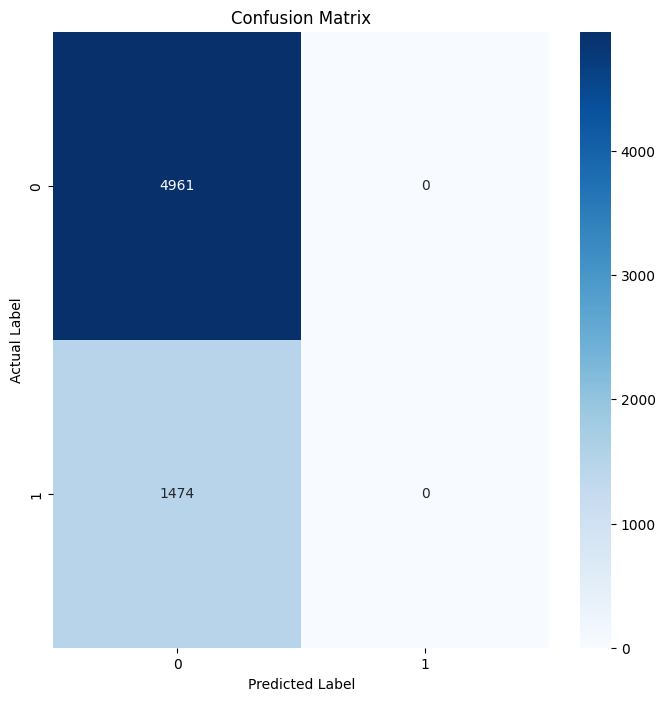

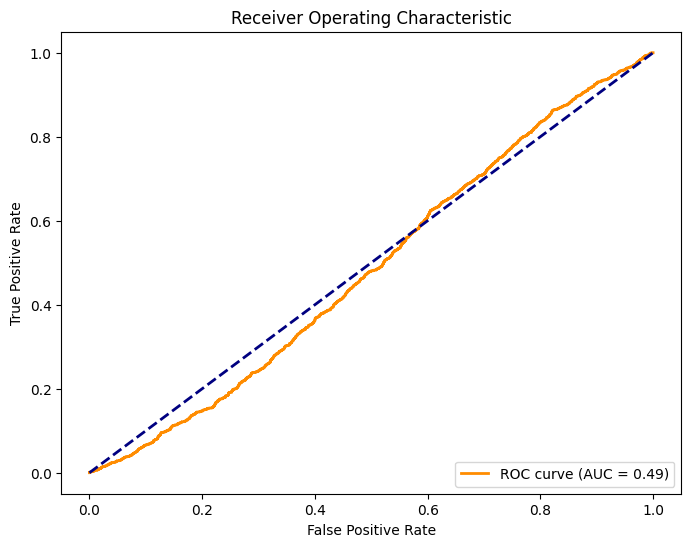

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.7721 - auc: 0.8643 - loss: 0.7427 - precision: 0.0000e+00 - recall: 0.0000e+00
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step

Test Loss: 0.7432
Test Accuracy: 0.7709
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.8719

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4961
           1       0.00      0.00      0.00      1474

    accuracy                           0.77      6435
   macro avg       0.39      0.50      0.44      6435
weighted avg       0.59      0.77      0.67      6435



/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

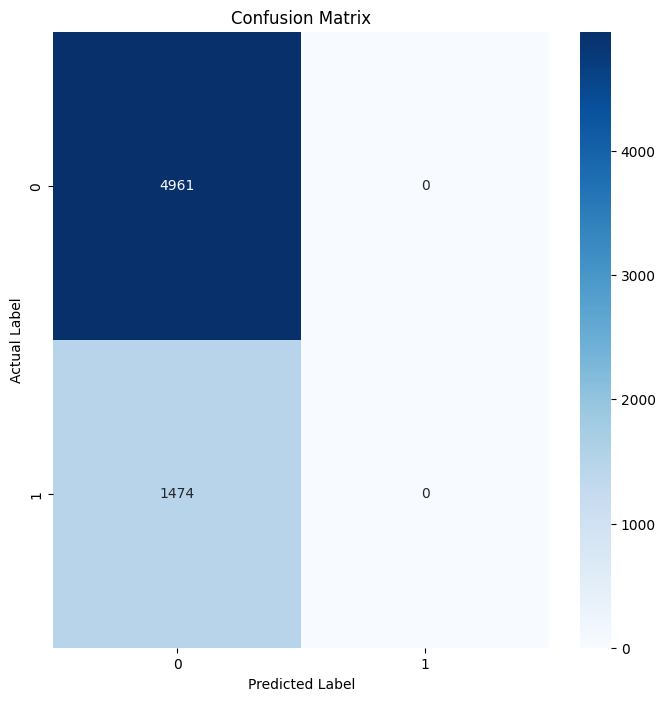

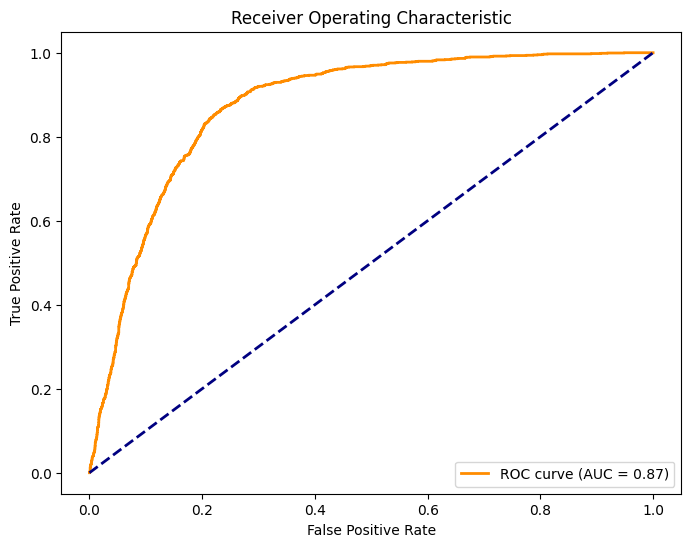

(0.7709401845932007, 0.0, 0.0, 0.8719336986541748)

In [48]:
# Load the Original Dataset
train_dataset, test_dataset, X_test, Y_test = prepare_dataset("Original", generator=generator, noise_dim=NOISE_DIM)

# Evaluate ResNet50 on Original Dataset
model = tf.keras.models.load_model("best_model_Original_ResNet50.keras")
evaluate_model(model, test_dataset, X_test, Y_test)

# Evaluate Custom CNN on Original Dataset
model = tf.keras.models.load_model("best_model_Original_Custom CNN.keras")
evaluate_model(model, test_dataset, X_test, Y_test)


In [49]:
gc.collect()

142170

In [50]:
model_type = "ResNet50"
dataset_type = "SVD"

# Prepare SVD Dataset
train_dataset, test_dataset, X_test, Y_test = prepared_datasets["SVD"]

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    f"best_model_{dataset_type}_{model_type}.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    verbose=1
)


# Train ResNet50 on SVD Dataset

model = build_resnet50(input_shape=(64, 64, 3), num_classes=1, fine_tune_at=100)
model.summary()

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    steps_per_epoch=get_steps_per_epoch(train_dataset),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Training completed for {model_type} on SVD Dataset.")


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 19,977,729 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.4844 - auc: 0.5145 - loss: 1.3149 - precision: 0.2553 - recall: 0.5714
Epoch 1: val_loss improved from inf to 0.99527, saving model to best_model_SVD_ResNet50.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - accuracy: 0.4844 - auc: 0.5145 - loss: 1.3149 - precision: 0.2553 - recall: 0.5714 - val_accuracy: 0.7709 - val_auc: 0.5011 - val_loss: 0.9953 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7773 - auc: 0.6500 - loss: 1.3243 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss did not improve from 0.99527
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.7773 - auc: 0.6500 - loss: 1.3243 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7709 - val_auc: 0.5099 - val_loss: 1.4796 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7383 - auc: 0.6544 - loss: 1.5066 - precis

In [51]:
gc.collect()

8458

In [52]:
# Train Custom CNN on SVD Dataset
model_type = "Custom CNN"
model = build_custom_cnn(input_shape=(64, 64, 3), num_classes=1)
model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    f"best_model_{dataset_type}_{model_type}.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    verbose=1
)


history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=get_steps_per_epoch(train_dataset),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Training completed for {model_type} on SVD Dataset.")

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7305 - auc: 0.6674 - loss: 0.8088 - precision: 0.3265 - recall: 0.3077
Epoch 1: val_loss improved from inf to 0.86897, saving model to best_model_SVD_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.7305 - auc: 0.6674 - loss: 0.8088 - precision: 0.3265 - recall: 0.3077 - val_accuracy: 0.7709 - val_auc: 0.8265 - val_loss: 0.8690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.8242 - auc: 0.8469 - loss: 0.7643 - precision: 0.6786 - recall: 0.5846
Epoch 2: val_loss improved from 0.86897 to 0.82787, saving model to best_model_SVD_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8242 - auc: 0.8469 - loss: 0.7643 - precision: 0.6786 - recall: 0.5846 - val_accuracy: 0.7709 - val_auc: 0.8425 - val_loss: 0.8279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.

Epoch 17/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.8555 - auc: 0.8894 - loss: 0.5788 - precision: 0.7500 - recall: 0.5263
Epoch 17: val_loss did not improve from 0.74354
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8555 - auc: 0.8894 - loss: 0.5788 - precision: 0.7500 - recall: 0.5263 - val_accuracy: 0.7709 - val_auc: 0.8821 - val_loss: 0.7719 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.8555 - auc: 0.8892 - loss: 0.5798 - precision: 0.7838 - recall: 0.5000
Epoch 18: val_loss did not improve from 0.74354
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8555 - auc: 0.8892 - loss: 0.5798 - precision: 0.7838 - recall: 0.5000 - val_accuracy: 0.7709 - val_auc: 0.8832 - val_loss: 0.7646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 19/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.8672 - auc: 0.9346 - loss: 0.5031 - precision: 0.7692 - recall: 0.5455
Epoch 19: val_loss did no

In [53]:
gc.collect()

43017

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 564ms/step - accuracy: 0.7721 - auc: 0.5102 - loss: 0.9938 - precision: 0.0000e+00 - recall: 0.0000e+00
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 665ms/step

Test Loss: 0.9953
Test Accuracy: 0.7709
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.5011

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4961
           1       0.00      0.00      0.00      1474

    accuracy                           0.77      6435
   macro avg       0.39      0.50      0.44      6435
weighted avg       0.59      0.77      0.67      6435



/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

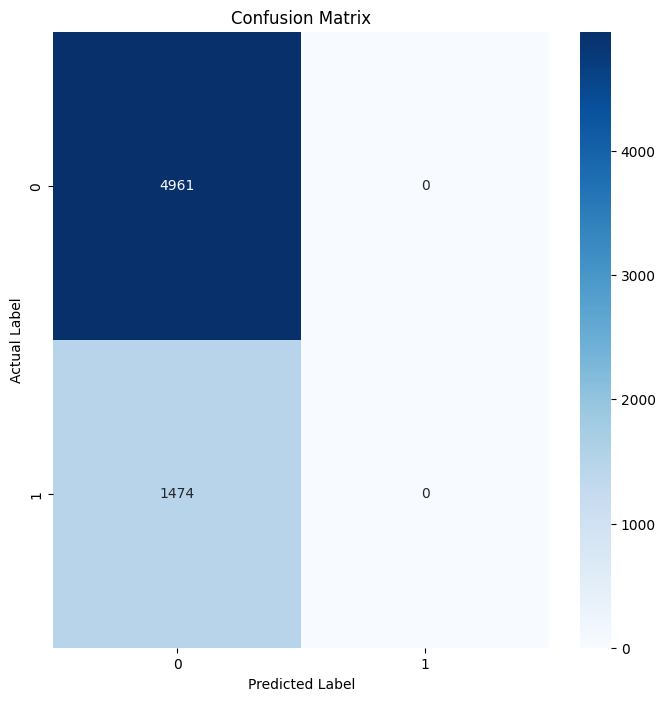

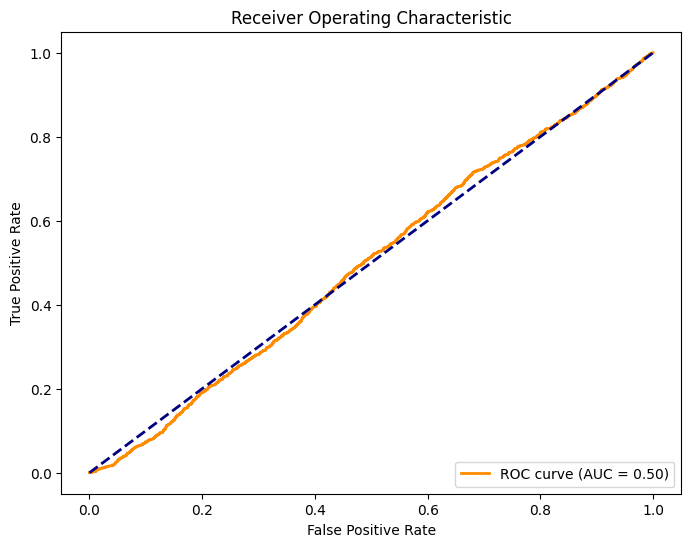

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7721 - auc: 0.8715 - loss: 0.7430 - precision: 0.0000e+00 - recall: 0.0000e+00
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step

Test Loss: 0.7435
Test Accuracy: 0.7709
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.8793

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4961
           1       0.00      0.00      0.00      1474

    accuracy                           0.77      6435
   macro avg       0.39      0.50      0.44      6435
weighted avg       0.59      0.77      0.67      6435



/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

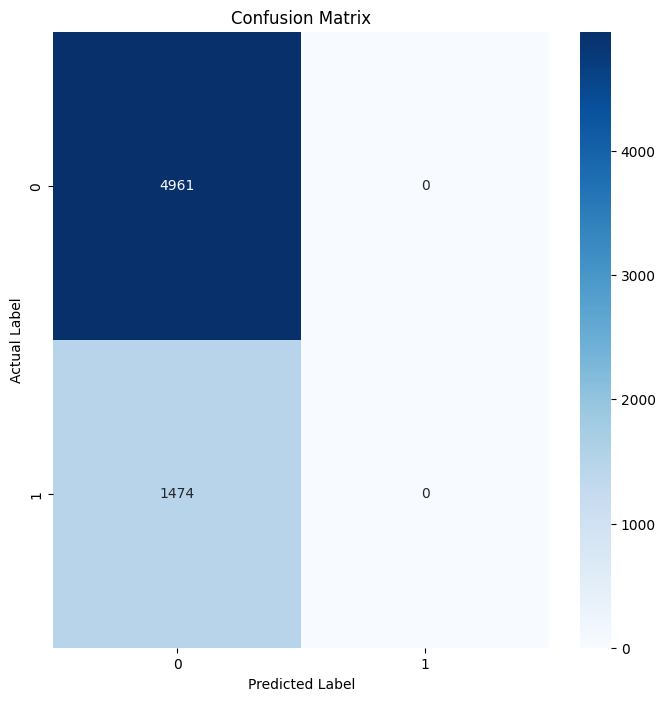

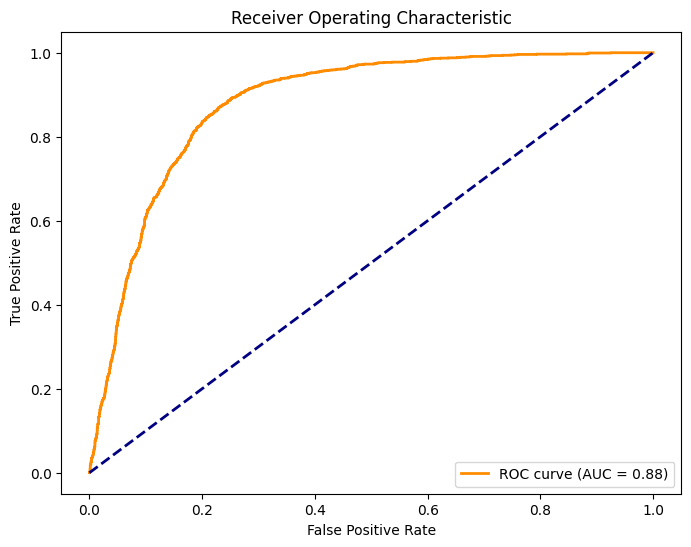

(0.7709401845932007, 0.0, 0.0, 0.8793201446533203)

In [54]:
# Load the SVD Dataset
train_dataset, test_dataset, X_test, Y_test = prepare_dataset("SVD", generator=generator, noise_dim=NOISE_DIM)

# Evaluate ResNet50 on SVD Dataset
model = tf.keras.models.load_model("best_model_SVD_ResNet50.keras")
evaluate_model(model, test_dataset, X_test, Y_test)

# Evaluate Custom CNN on SVD Dataset
model = tf.keras.models.load_model("best_model_SVD_Custom CNN.keras")
evaluate_model(model, test_dataset, X_test, Y_test)

In [55]:
model_type = "ResNet50"
dataset_type = "Original + Augmented"



# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    f"best_model_{dataset_type}_{model_type}.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    verbose=1
)

# Train ResNet50 on Original + Augmented Dataset
model = build_resnet50(input_shape=(64, 64, 3), num_classes=1, fine_tune_at=100)
model.summary()

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=get_steps_per_epoch(train_dataset),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Training completed for {model_type} on Original + Augmented Dataset.")


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 19,977,729 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.4727 - auc: 0.5326 - loss: 1.4436 - precision: 0.2177 - recall: 0.6154
Epoch 1: val_loss improved from inf to 1.01097, saving model to best_model_Original + Augmented_ResNet50.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - accuracy: 0.4727 - auc: 0.5326 - loss: 1.4436 - precision: 0.2177 - recall: 0.6154 - val_accuracy: 0.7709 - val_auc: 0.5717 - val_loss: 1.0110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7617 - auc: 0.5624 - loss: 1.5410 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss did not improve from 1.01097
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.7617 - auc: 0.5624 - loss: 1.5410 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7709 - val_auc: 0.5000 - val_loss: 2.4542 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7383 - auc: 0.6327 - loss

In [56]:
gc.collect()

14630

In [57]:
# Train Custom CNN on Original + Augmented Dataset
model_type = "Custom CNN"
model = build_custom_cnn(input_shape=(64, 64, 3), num_classes=1)
model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    f"best_model_{dataset_type}_{model_type}.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=get_steps_per_epoch(train_dataset),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Training completed for {model_type} on Original + Augmented Dataset.")


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3672 - auc: 0.4255 - loss: 1.1601 - precision: 0.2353 - recall: 0.6984
Epoch 1: val_loss improved from inf to 0.87846, saving model to best_model_Original + Augmented_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3672 - auc: 0.4255 - loss: 1.1601 - precision: 0.2353 - recall: 0.6984 - val_accuracy: 0.7709 - val_auc: 0.8125 - val_loss: 0.8785 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.8047 - auc: 0.8339 - loss: 0.7044 - precision: 0.5484 - recall: 0.6071
Epoch 2: val_loss improved from 0.87846 to 0.86176, saving model to best_model_Original + Augmented_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8047 - auc: 0.8339 - loss: 0.7044 - precision: 0.5484 - recall: 0.6071 - val_accuracy: 0.7709 - val_auc: 0.8216 - val_loss: 0.8618 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.8359 - auc: 0.8753 - loss: 0.6039 - precision: 0.6364 - recall: 0.7000
Epoch 16: val_loss did not improve from 0.72982
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8359 - auc: 0.8753 - loss: 0.6039 - precision: 0.6364 - recall: 0.7000 - val_accuracy: 0.7709 - val_auc: 0.8755 - val_loss: 0.7340 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 17/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.8438 - auc: 0.8775 - loss: 0.5879 - precision: 0.6167 - recall: 0.6852
Epoch 17: val_loss improved from 0.72982 to 0.72935, saving model to best_model_Original + Augmented_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8438 - auc: 0.8775 - loss: 0.5879 - precision: 0.6167 - recall: 0.6852 - val_accuracy: 0.7709 - val_auc: 0.8765 - val_loss: 0.7293 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.8633 - auc: 0.8871 - loss: 0.5914 - pre

Epoch 32/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.8242 - auc: 0.8614 - loss: 0.5968 - precision: 0.6094 - recall: 0.6610
Epoch 32: val_loss improved from 0.67622 to 0.65880, saving model to best_model_Original + Augmented_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8242 - auc: 0.8614 - loss: 0.5968 - precision: 0.6094 - recall: 0.6610 - val_accuracy: 0.7764 - val_auc: 0.8843 - val_loss: 0.6588 - val_precision: 0.7612 - val_recall: 0.0346
Epoch 33/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.8867 - auc: 0.9341 - loss: 0.4964 - precision: 0.7143 - recall: 0.7547
Epoch 33: val_loss improved from 0.65880 to 0.64984, saving model to best_model_Original + Augmented_Custom CNN.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8867 - auc: 0.9341 - loss: 0.4964 - precision: 0.7143 - recall: 0.7547 - val_accuracy: 0.7786 - val_auc: 0.8872 - val_loss: 0.6498 - val_precision: 0.7248 - val_recall: 0.0536
Epoch 34/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 48/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.8477 - auc: 0.9051 - loss: 0.5416 - precision: 0.7500 - recall: 0.6000
Epoch 48: val_loss did not improve from 0.63183
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8477 - auc: 0.9051 - loss: 0.5416 - precision: 0.7500 - recall: 0.6000 - val_accuracy: 0.8334 - val_auc: 0.8903 - val_loss: 0.6795 - val_precision: 0.6672 - val_recall: 0.5441
Epoch 49/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.8906 - auc: 0.9252 - loss: 0.4641 - precision: 0.7115 - recall: 0.7400
Epoch 49: val_loss did not improve from 0.63183
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8906 - auc: 0.9252 - loss: 0.4641 - precision: 0.7115 - recall: 0.7400 - val_accuracy: 0.8384 - val_auc: 0.8900 - val_loss: 0.6821 - val_precision: 0.6639 - val_recall: 0.5963
Epoch 50/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8594 - auc: 0.9101 - loss: 0.5070 - precision: 0.6724 - recall: 0.6964
Epoch 50: val_loss did not improve from 0

In [58]:
gc.collect()

43017

64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 602ms/step - accuracy: 0.6093 - auc: 0.5557 - loss: 1.1297 - precision: 0.0000e+00 - recall: 0.0000e+00
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 693ms/step

Test Loss: 1.1316
Test Accuracy: 0.6064
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.5635

Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.75      9903
           1       0.00      0.00      0.00      6428

    accuracy                           0.61     16331
   macro avg       0.30      0.50      0.38     16331
weighted avg       0.37      0.61      0.46     16331



/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

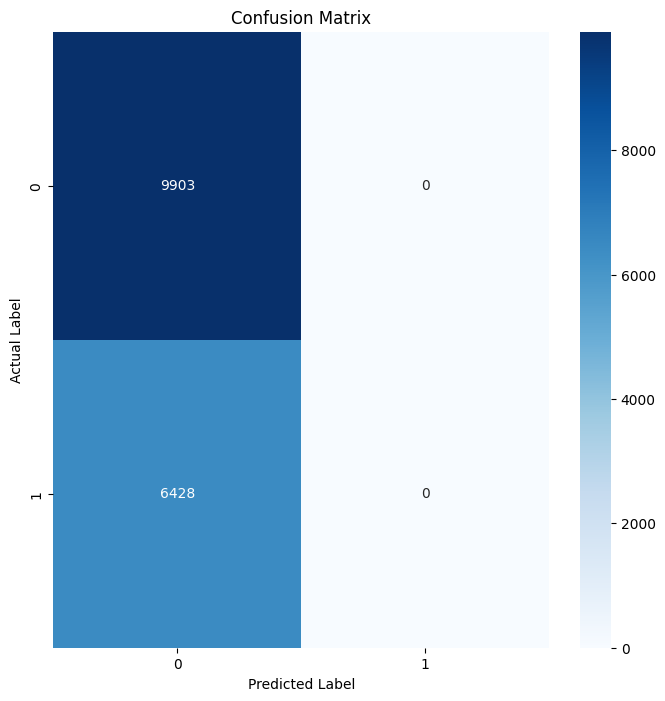

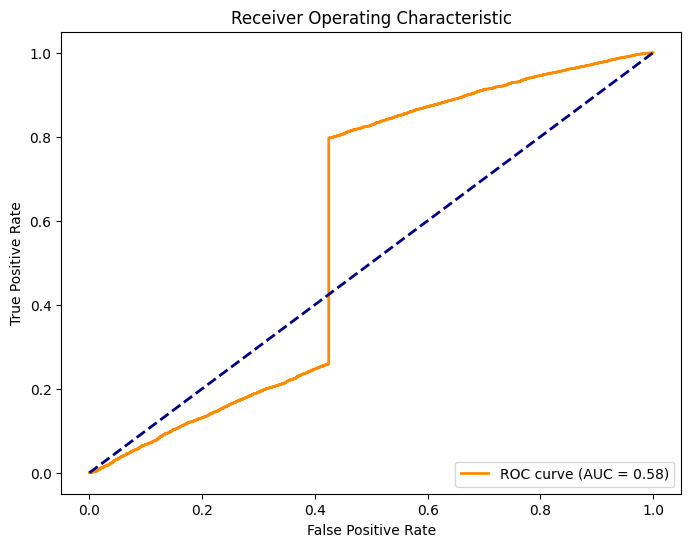

64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.8349 - auc: 0.9475 - loss: 0.6065 - precision: 0.9626 - recall: 0.6006
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step

Test Loss: 0.6106
Test Accuracy: 0.8299
Test Precision: 0.9623
Test Recall: 0.5910
Test AUC: 0.9463

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      9903
           1       0.96      0.59      0.73      6428

    accuracy                           0.83     16331
   macro avg       0.87      0.79      0.80     16331
weighted avg       0.86      0.83      0.82     16331



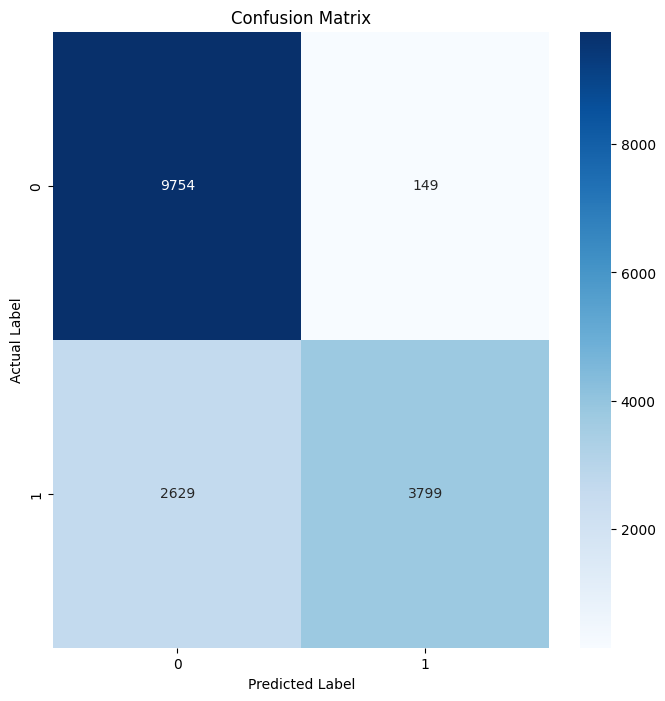

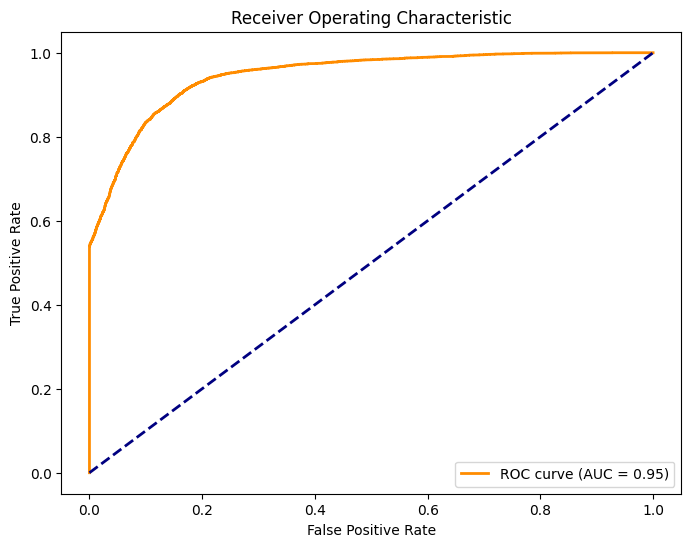

(0.8298940658569336,
 0.9622593522071838,
 0.5910080671310425,
 0.9462718963623047)

In [36]:
# Load the Original + Augmented Dataset
train_dataset, test_dataset, X_test, Y_test = prepared_datasets["Original + Augmented"]

# Evaluate ResNet50 on Original + Augmented Dataset
model = tf.keras.models.load_model("best_model_Original + Augmented_ResNet50.keras")
evaluate_model(model, test_dataset, X_test, Y_test)

# Evaluate Custom CNN on Original + Augmented Dataset
model = tf.keras.models.load_model("best_model_Original + Augmented_Custom CNN.keras")
evaluate_model(model, test_dataset, X_test, Y_test)

In [37]:
(
    (train_dataset_original, train_dataset_svd), 
    (test_dataset_original, test_dataset_svd), 
    (X_test_original, X_test_svd), 
    Y_test
) = prepared_datasets["Hybrid CNN"]

In [44]:
# Combine Original and SVD datasets
train_dataset_combined = tf.data.Dataset.zip((train_dataset_original, train_dataset_svd))
test_dataset_combined = tf.data.Dataset.zip((test_dataset_original, test_dataset_svd))

# Format datasets to a compatible structure
def format_multi_input_data(original, svd):
    return {"Original_Input": original[0], "SVD_Input": svd[0]}, original[1]

train_dataset_combined = train_dataset_combined.map(format_multi_input_data)
test_dataset_combined = test_dataset_combined.map(format_multi_input_data)

In [45]:
gc.collect()

19312

In [46]:
model_type = "Hybrid CNN"
dataset_type = "Hybrid CNN"

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    f"best_model_{dataset_type}_{model_type}.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    verbose=1
)

# Train Hybrid CNN
model = build_hybrid_cnn(input_shape=(64, 64, 3), num_classes=1)
train_inputs = (train_dataset_original, train_dataset_svd)
test_inputs = (test_dataset_original, test_dataset_svd)
model.summary()

history = model.fit(
    train_dataset_combined,
    validation_data=test_dataset_combined,
    epochs=100,
    steps_per_epoch=get_steps_per_epoch(train_dataset_original),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Training completed for {model_type} on Hybrid CNN Dataset.")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Original_Input      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SVD_Input           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │        896 │ Original_Input[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │        896 │ SVD_Input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 32, 32,    │          0 │ leaky_re_lu_20[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ leaky_re_lu_23[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 16, 16,    │          0 │ leaky_re_lu_21[0

 Total params: 4,383,105 (16.72 MB)

 Trainable params: 4,382,209 (16.72 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100


/geode2/home/u080/sbidanta/Quartz/iis/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Original_Input', 'SVD_Input']. Received: the structure of inputs={'Original_Input': '*', 'SVD_Input': '*'}
  warnings.warn(


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7930 - auc: 0.7907 - loss: 1.8164 - precision: 0.5610 - recall: 0.5337
Epoch 1: val_loss improved from inf to 0.45702, saving model to best_model_Hybrid CNN_Hybrid CNN.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7934 - auc: 0.7913 - loss: 1.8057 - precision: 0.5618 - recall: 0.5338 - val_accuracy: 0.8309 - val_auc: 0.8829 - val_loss: 0.4570 - val_precision: 0.6335 - val_recall: 0.6214
Epoch 2/100


2024-12-16 13:53:20.302611: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/N/soft/rhel8/python/gnu/3.10.5/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.45702
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8309 - val_auc: 0.8829 - val_loss: 0.4570 - val_precision: 0.6335 - val_recall: 0.6214
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8473 - auc: 0.8973 - loss: 0.3326 - precision: 0.7113 - recall: 0.5660
Epoch 3: val_loss did not improve from 0.45702
101/101 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8473 - auc: 0.8973 - loss: 0.3326 - precision: 0.7114 - recall: 0.5658 - val_accuracy: 0.2747 - val_auc: 0.8819 - val_loss: 1.0011 - val_precision: 0.2400 - val_recall: 1.0000
Epoch 4/100


2024-12-16 13:56:02.600023: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss did not improve from 0.45702
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2747 - val_auc: 0.8819 - val_loss: 1.0011 - val_precision: 0.2400 - val_recall: 1.0000
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8531 - auc: 0.9031 - loss: 0.3232 - precision: 0.7069 - recall: 0.6182
Epoch 5: val_loss did not improve from 0.45702
101/101 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.8531 - auc: 0.9031 - loss: 0.3232 - precision: 0.7070 - recall: 0.6182 - val_accuracy: 0.2525 - val_auc: 0.8517 - val_loss: 1.0685 - val_precision: 0.2346 - val_recall: 1.0000
Epoch 6/100

Epoch 6: val_loss did not improve from 0.45702
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2525 - val_auc: 0.8517 - val_loss: 1.0685 - val_precision: 

2024-12-16 14:02:05.991283: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_loss did not improve from 0.45702
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6402 - val_auc: 0.8900 - val_loss: 0.7533 - val_precision: 0.3853 - val_recall: 0.9586
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8670 - auc: 0.9138 - loss: 0.3063 - precision: 0.7291 - recall: 0.6714
Epoch 9: val_loss improved from 0.45702 to 0.43419, saving model to best_model_Hybrid CNN_Hybrid CNN.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.8670 - auc: 0.9138 - loss: 0.3063 - precision: 0.7292 - recall: 0.6713 - val_accuracy: 0.8228 - val_auc: 0.9155 - val_loss: 0.4342 - val_precision: 0.5733 - val_recall: 0.8860
Epoch 10/100

Epoch 10: val_loss did not improve from 0.43419
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy

2024-12-16 14:15:33.032184: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_loss did not improve from 0.29060
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6563 - val_auc: 0.8092 - val_loss: 0.6214 - val_precision: 0.3862 - val_recall: 0.8494
Epoch 17/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8740 - auc: 0.9217 - loss: 0.2944 - precision: 0.7386 - recall: 0.7016
Epoch 17: val_loss improved from 0.29060 to 0.28988, saving model to best_model_Hybrid CNN_Hybrid CNN.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8741 - auc: 0.9217 - loss: 0.2943 - precision: 0.7387 - recall: 0.7016 - val_accuracy: 0.8713 - val_auc: 0.9277 - val_loss: 0.2899 - val_precision: 0.6943 - val_recall: 0.7829
Epoch 18/100

Epoch 18: val_loss did not improve from 0.28988
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accura

In [47]:
gc.collect()

1760

In [49]:
# Convert numpy arrays to TensorFlow Datasets
X_test_original_ds = tf.data.Dataset.from_tensor_slices((X_test_original, Y_test))
X_test_svd_ds = tf.data.Dataset.from_tensor_slices((X_test_svd, Y_test))

# Combine Original and SVD datasets
X_test_combined = tf.data.Dataset.zip((X_test_original_ds, X_test_svd_ds))

# Format datasets to a compatible structure
def format_multi_input_data(original, svd):
    return {"Original_Input": original[0], "SVD_Input": svd[0]}, original[1]

# Map the combined dataset to format it
X_test_combined = X_test_combined.map(format_multi_input_data)

# Batch the combined dataset (optional)
X_test_combined = X_test_combined.batch(32).prefetch(tf.data.AUTOTUNE)


26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.8749 - auc: 0.9234 - loss: 0.2954 - precision: 0.7022 - recall: 0.7830
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step

Test Loss: 0.2899
Test Accuracy: 0.8713
Test Precision: 0.6943
Test Recall: 0.7829
Test AUC: 0.9277

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      4961
           1       0.69      0.78      0.74      1474

    accuracy                           0.87      6435
   macro avg       0.81      0.84      0.83      6435
weighted avg       0.88      0.87      0.87      6435



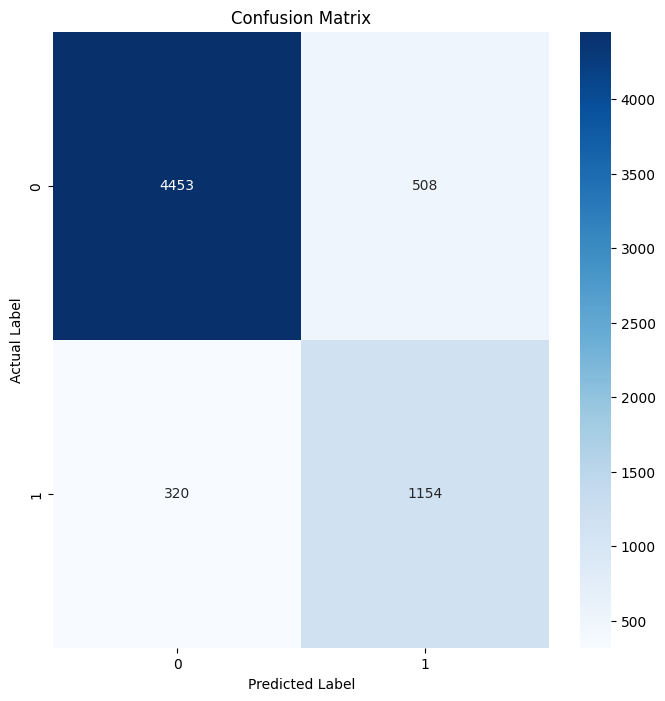

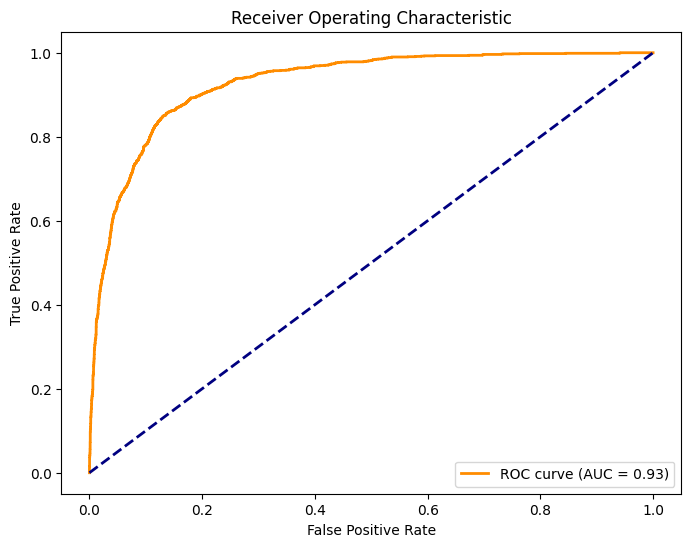

(0.8713286519050598, 0.694344162940979, 0.7829036712646484, 0.9277275204658508)

In [51]:
# Load and Evaluate Hybrid CNN
model = tf.keras.models.load_model("best_model_Hybrid CNN_Hybrid CNN.keras")
test_inputs = (test_dataset_original, test_dataset_svd)
evaluate_model(model, test_dataset_combined, X_test_combined, Y_test)


In [52]:
def grad_cam_multi_input(model, dataset, layer_name=None):
    """
    Grad-CAM for a multi-input model like Hybrid CNN.
    """
    # Identify the last Conv2D layer if not provided
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    if layer_name is None:
        raise ValueError("No Conv2D layer found in the model.")

    # Grad model with outputs of target Conv2D layer and final predictions
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    for inputs, labels in dataset.take(1):  # Take one batch of combined inputs
        with tf.GradientTape() as tape:
            # Forward pass through the model
            conv_outputs, predictions = grad_model([inputs["Original_Input"], inputs["SVD_Input"]])
            loss = predictions[:, 0]  # Focus on the first class (target)

        # Compute gradients
        grads = tape.gradient(loss, conv_outputs)
        guided_grads = tf.maximum(grads, 0)  # ReLU for gradients

        # Generate Grad-CAM heatmap
        heatmap = tf.reduce_mean(guided_grads, axis=-1)
        heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

        return heatmap.numpy(), inputs, predictions.numpy()


In [53]:
def display_multi_input_grad_cam(heatmap, original_image, alpha=0.4):
    """
    Overlay Grad-CAM heatmap on the original image.
    """
    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Scale to 0-255
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # Apply colormap

    # Superimpose heatmap on the original image
    superimposed_img = cv2.addWeighted(original_image, 1 - alpha, heatmap_resized, alpha, 0)

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


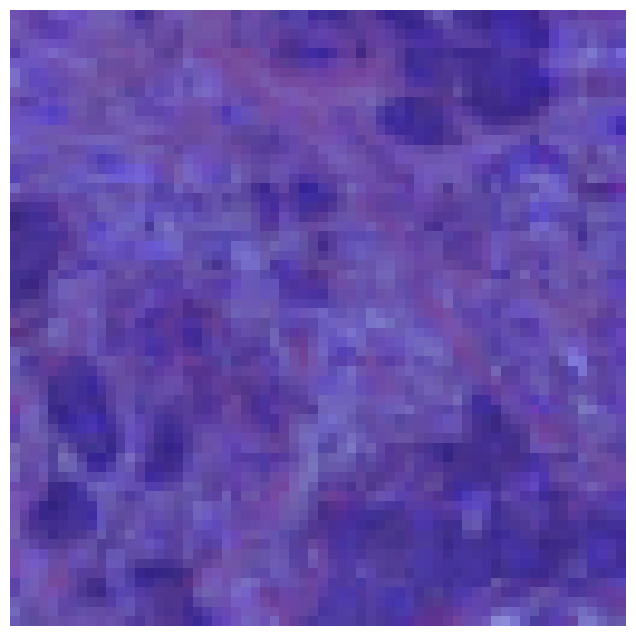

In [57]:
# Assuming your Hybrid CNN model is trained and loaded as 'hybrid_model'
layer_name = "conv2d_24"  # Replace with the actual Conv2D layer name

# Generate Grad-CAM heatmap
heatmap, inputs, predictions = grad_cam_multi_input(model, X_test_combined, layer_name=layer_name)

# Extract the first input image for visualization
original_image = (inputs["Original_Input"][0].numpy() * 255).astype(np.uint8)

# Display Grad-CAM heatmap on the original input image
display_multi_input_grad_cam(heatmap[0], original_image)
